In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

# Konfigurasi agar GPU digunakan secara efisien
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU Terdeteksi: ", physical_devices[0])
else:
    print("Peringatan: GPU tidak terdeteksi. Training akan lambat.")

GPU Terdeteksi:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
# Create the .kaggle directory if it doesn't exist
!mkdir -p ~/.kaggle

# Move the kaggle.json file to the .kaggle directory
# IMPORTANT: Make sure you have uploaded kaggle.json to your Colab session's /content/ directory first.
# If you uploaded it somewhere else, adjust the source path accordingly.
!mv /content/kaggle.json ~/.kaggle/

# Set read-only permissions for the kaggle.json file for security
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API credentials set up successfully!")

Kaggle API credentials set up successfully!


In [3]:
# Install kaggle if not already installed
!pip install -q kaggle

# Make sure your Kaggle API credentials (kaggle.json) are set up in ~/.kaggle/
# If you haven't done this, please refer to the previous instructions.

# Download the dataset
!kaggle datasets download -d joosthazelzet/lego-brick-images

# Unzip the downloaded dataset to the specified directory
# The zip file will be downloaded to the current working directory (/content/)
!unzip -q /content/lego-brick-images.zip -d /content/dataset/

# Clean up the zip file after extraction
!rm /content/lego-brick-images.zip

print("Dataset downloaded and extracted to /content/dataset/")

Dataset URL: https://www.kaggle.com/datasets/joosthazelzet/lego-brick-images
License(s): GPL-2.0
 96% 977M/1.00G [00:10<00:00, 80.1MB/s]
100% 1.00G/1.00G [00:11<00:00, 96.1MB/s]
Dataset downloaded and extracted to /content/dataset/


In [4]:
# Parameter Konfigurasi
BATCH_SIZE = 64
IMG_HEIGHT = 64  # Menggunakan 64x64 agar detail LEGO cukup terlihat
IMG_WIDTH = 64
CHANNELS = 3     # RGB


# --- OPSI B: Membuat Dataset Loader ---
# Ganti 'path/to/images' dengan path folder dataset Anda
dataset_dir = '/content/dataset/LEGO brick images v1'

# Jika folder kosong/tidak ada, kita buat dummy data agar kode tetap jalan (untuk testing)
if not os.path.exists(dataset_dir) or not os.listdir(dataset_dir):
    print("Dataset tidak ditemukan. Membuat data dummy untuk demonstrasi struktur kode.")
    os.makedirs(dataset_dir, exist_ok=True)
    # Membuat 100 gambar random noise sebagai placeholder
    for i in range(100):
        img = np.random.randint(0, 255, (64, 64, 3), dtype=np.uint8)
        tf.keras.utils.save_img(f"{dataset_dir}/dummy_{i}.png", img)

# Memuat dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    label_mode=None, # Kita tidak butuh label untuk GAN
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Normalisasi ke [-1, 1]
train_dataset = train_dataset.map(lambda x: (x - 127.5) / 127.5)

# Optimasi performa (Caching & Prefetching)
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 6379 files.


In [5]:
latent_dim = 128

def build_generator():
    model = keras.Sequential(name="generator")

    # Input: Latent Vector
    # Mulai dengan dense layer yang cukup besar untuk di-reshape
    # Kita ingin mulai dari ukuran 8x8 dengan 512 filter
    model.add(layers.Dense(8 * 8 * 512, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Reshape menjadi tensor 3D
    model.add(layers.Reshape((8, 8, 512)))

    # Upsampling 1: 8x8 -> 16x16
    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Upsampling 2: 16x16 -> 32x32
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Upsampling 3: 32x32 -> 64x64
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Output Layer: 64x64 -> 64x64x3 (RGB)
    # Aktivasi TANH penting agar output di range [-1, 1]
    model.add(layers.Conv2D(CHANNELS, (3, 3), padding='same', activation='tanh'))

    return model

def build_discriminator():
    model = keras.Sequential(name="discriminator")

    # Input: Gambar 64x64x3
    # Downsampling 1: 64 -> 32
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Downsampling 2: 32 -> 16
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Downsampling 3: 16 -> 8
    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Flatten dan Output
    model.add(layers.Flatten())
    model.add(layers.Dense(1)) # Output berupa logit (skor real/fake)

    return model

# Inisialisasi Model
generator = build_generator()
discriminator = build_discriminator()

generator.summary()
# discriminator.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32768)          │     4,194,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32768)          │       131,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 256)    │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,081,411 (27.01 MB)

 Trainable params: 7,014,979 (26.76 MB)

 Non-trainable params: 66,432 (259.50 KB)

In [6]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        # Metric trackers
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # 1. Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 2. Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # 3. Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # 4. Assemble labels discriminating real from fake images
        # Label 1 untuk fake, 0 untuk real (atau sebaliknya, teknik ini menggunakan label smoothing)
        # Di sini kita pakai standar: 1=Real, 0=Fake.
        # Namun, karena kita concat [Fake, Real], maka labelnya: [0...0, 1...1]
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )

        # Tambahkan sedikit noise pada label (Label Smoothing) untuk stabilitas
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # 5. Train the Discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # 6. Sample random points in the latent space (lagi, untuk Generator)
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 7. Assemble labels that say "all real images" (We want to fool the discriminator)
        misleading_labels = tf.ones((batch_size, 1))

        # 8. Train the Generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [7]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 127.5
        generated_images += 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(10, 4))
        for i in range(self.num_img):
            plt.subplot(1, self.num_img, i+1)
            img = keras.utils.array_to_img(generated_images[i])
            plt.imshow(img)
            plt.axis('off')

        plt.suptitle(f"Epoch {epoch+1}")
        plt.show() # Tampilkan inline di Colab

        # Opsional: Simpan ke file
        # plt.savefig(f"generated_lego_epoch_{epoch}.png")
        # plt.close()

Mulai Training...
Epoch 1/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - d_loss: 0.4903 - g_loss: 0.7182

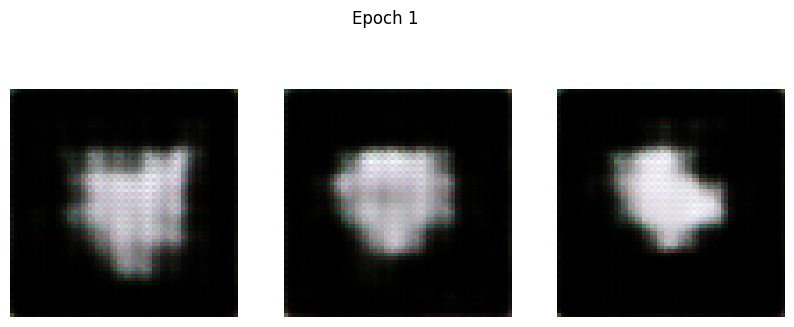

100/100 ━━━━━━━━━━━━━━━━━━━━ 50s 205ms/step - d_loss: 0.4910 - g_loss: 0.7184
Epoch 2/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - d_loss: 0.6775 - g_loss: 0.6990

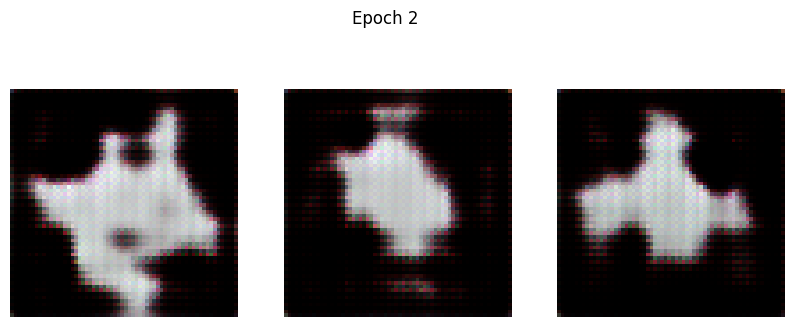

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - d_loss: 0.6776 - g_loss: 0.6991
Epoch 3/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.6717 - g_loss: 0.7066

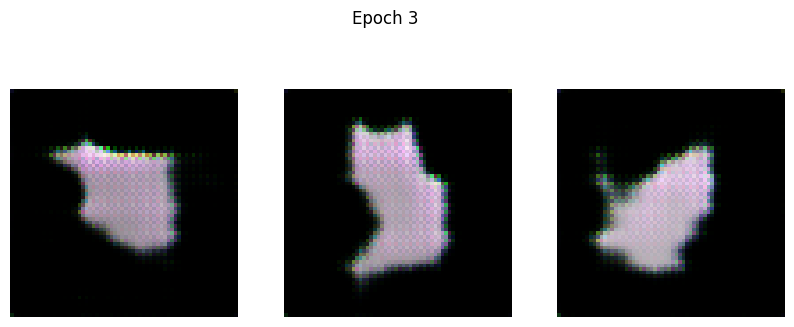

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.6717 - g_loss: 0.7066
Epoch 4/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.6637 - g_loss: 0.7284

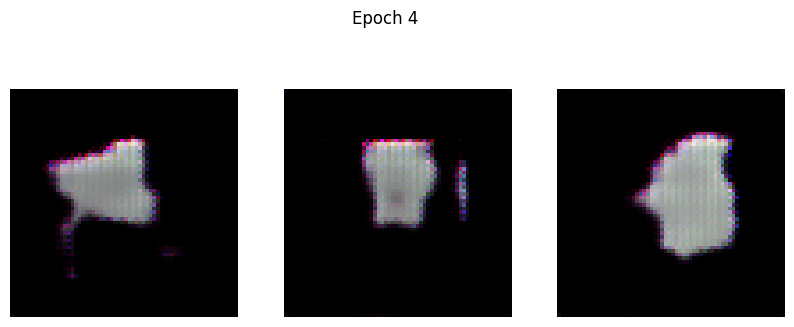

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.6637 - g_loss: 0.7284
Epoch 5/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.6756 - g_loss: 0.7642

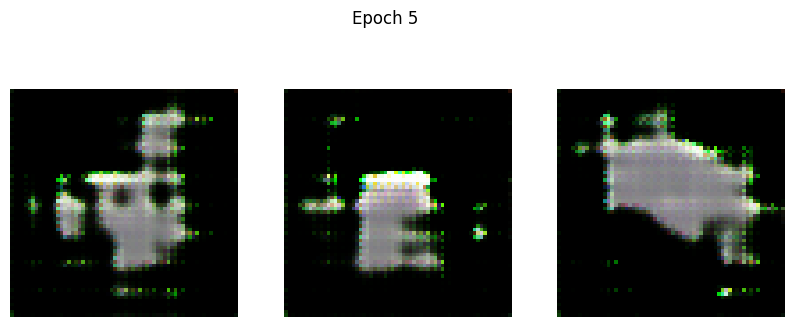

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.6756 - g_loss: 0.7641
Epoch 6/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6638 - g_loss: 0.7500

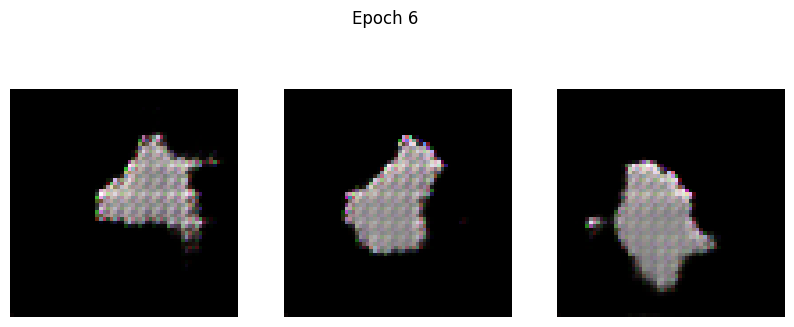

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6637 - g_loss: 0.7501
Epoch 7/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.6637 - g_loss: 0.7717

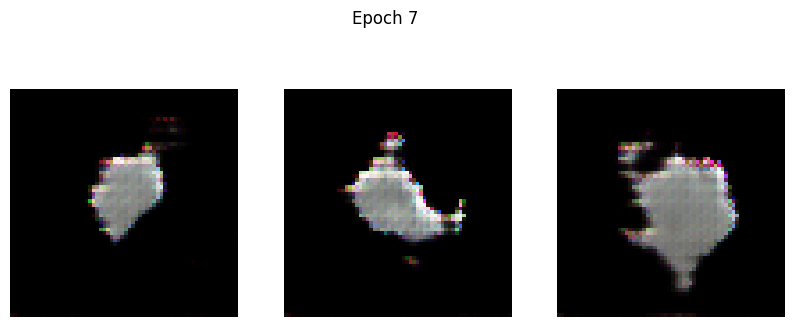

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.6636 - g_loss: 0.7717
Epoch 8/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.6596 - g_loss: 0.8383

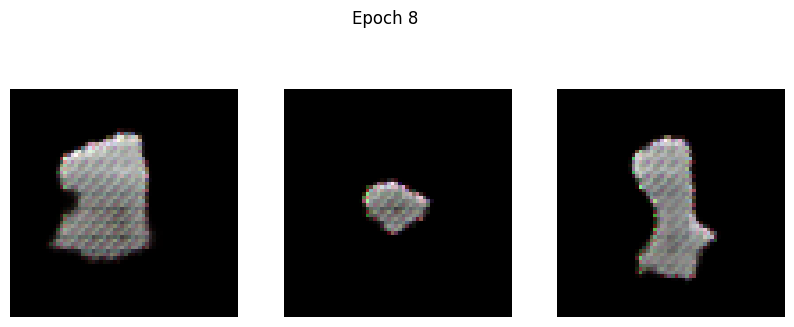

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.6596 - g_loss: 0.8379
Epoch 9/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.6655 - g_loss: 0.8049

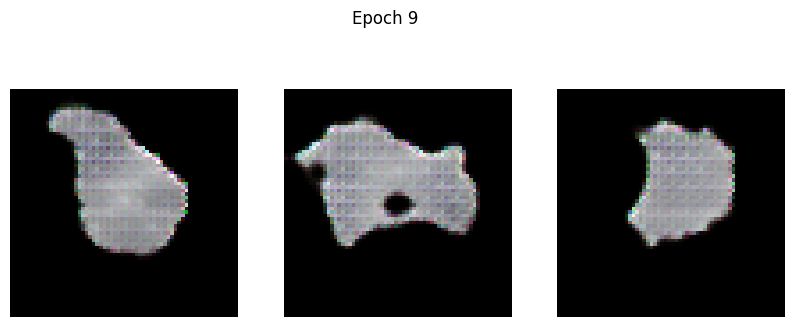

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - d_loss: 0.6654 - g_loss: 0.8046
Epoch 10/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.6624 - g_loss: 0.7399

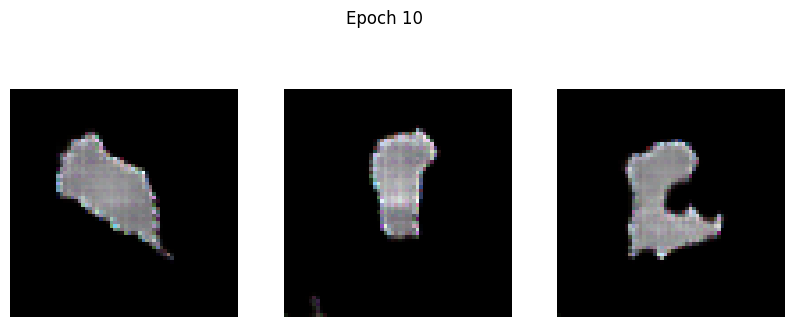

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - d_loss: 0.6624 - g_loss: 0.7399
Epoch 11/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.6641 - g_loss: 0.7455

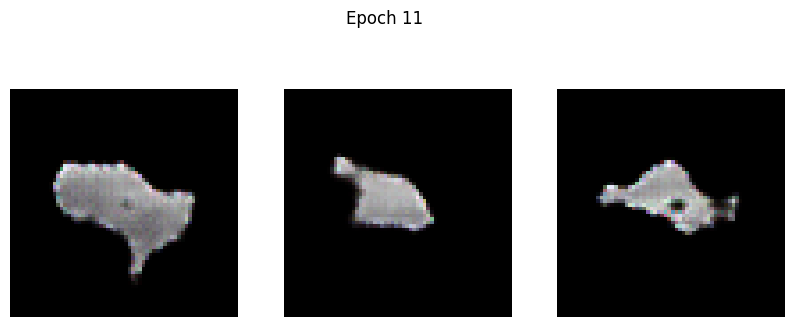

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.6641 - g_loss: 0.7453
Epoch 12/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.6529 - g_loss: 0.7324

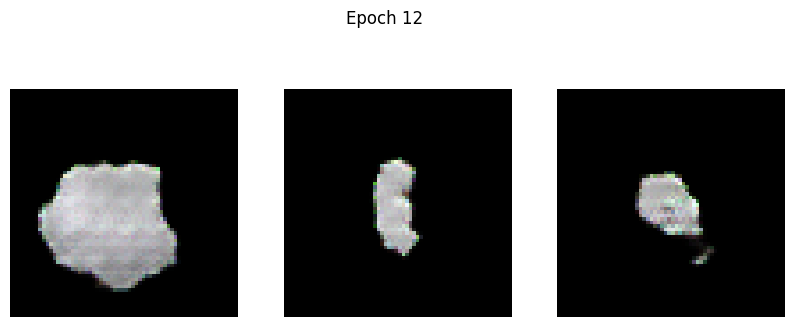

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - d_loss: 0.6529 - g_loss: 0.7324
Epoch 13/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.6531 - g_loss: 0.7648

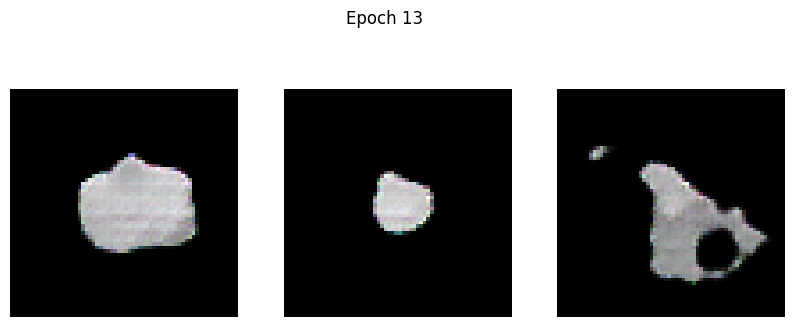

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.6530 - g_loss: 0.7648
Epoch 14/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.6430 - g_loss: 0.8013

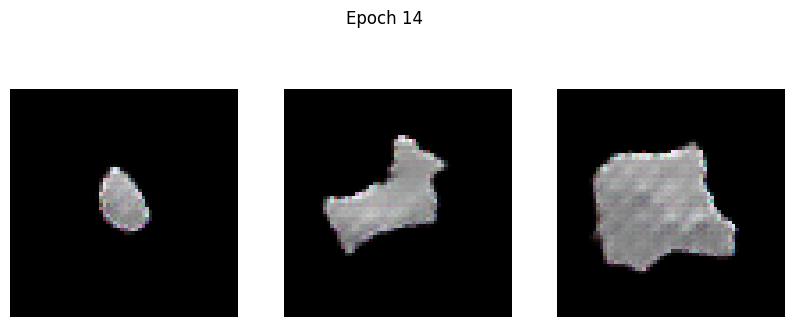

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.6430 - g_loss: 0.8013
Epoch 15/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.6466 - g_loss: 0.8128

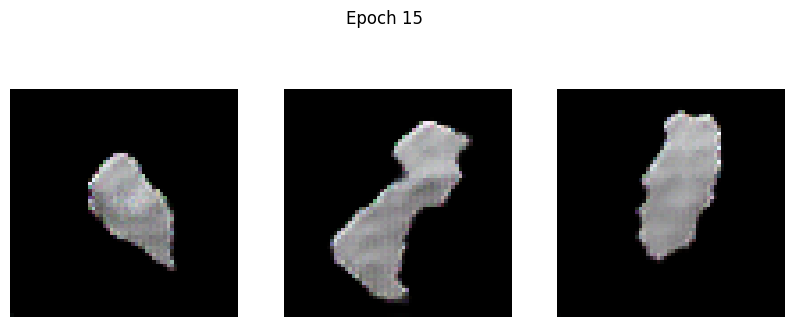

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.6465 - g_loss: 0.8128
Epoch 16/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.6238 - g_loss: 0.8402

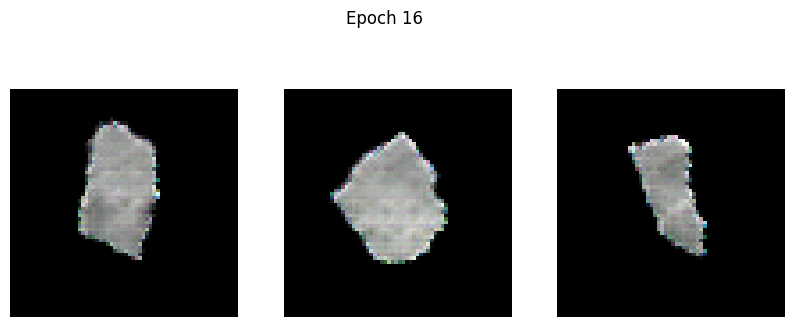

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.6238 - g_loss: 0.8404
Epoch 17/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.6228 - g_loss: 0.8690

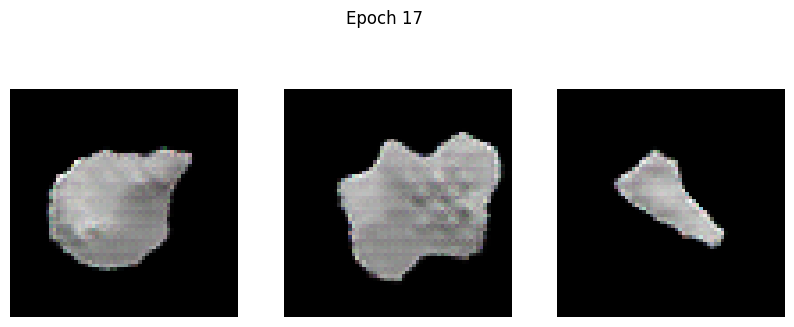

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.6227 - g_loss: 0.8688
Epoch 18/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.5996 - g_loss: 0.8885

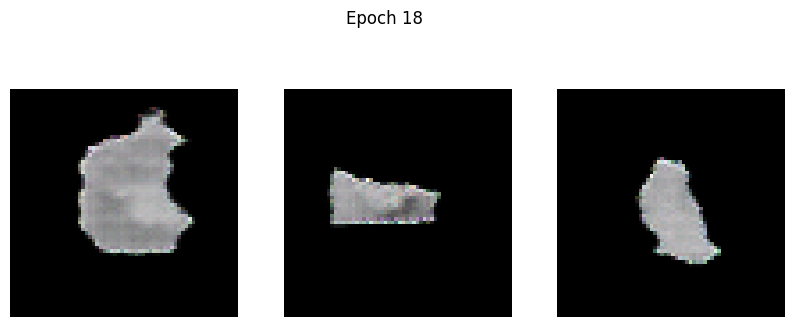

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.5996 - g_loss: 0.8888
Epoch 19/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.5818 - g_loss: 0.9170

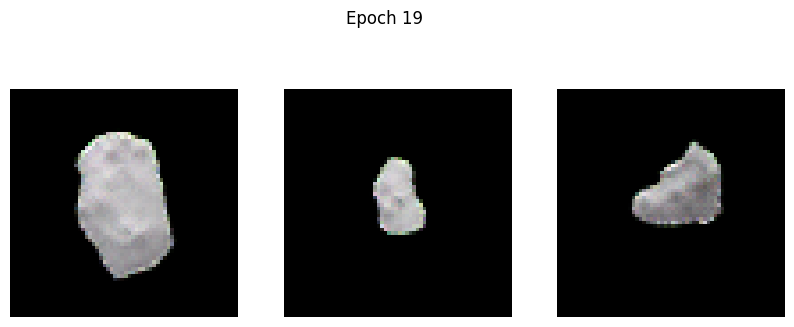

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.5818 - g_loss: 0.9170
Epoch 20/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.5716 - g_loss: 0.9395

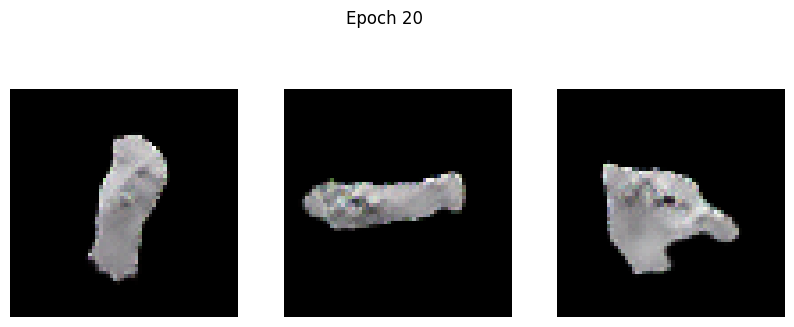

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.5716 - g_loss: 0.9397
Epoch 21/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.5624 - g_loss: 0.9911

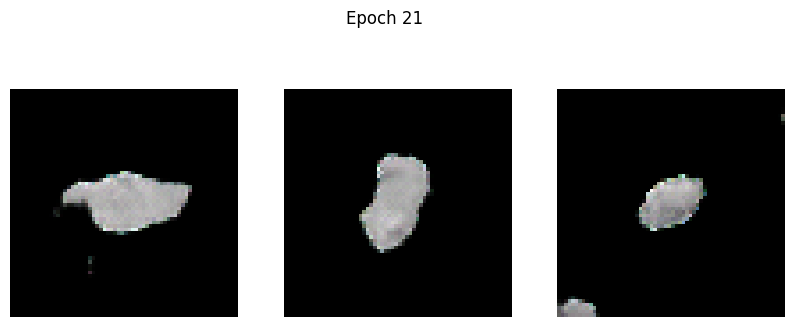

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.5629 - g_loss: 0.9916
Epoch 22/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.5776 - g_loss: 0.9229

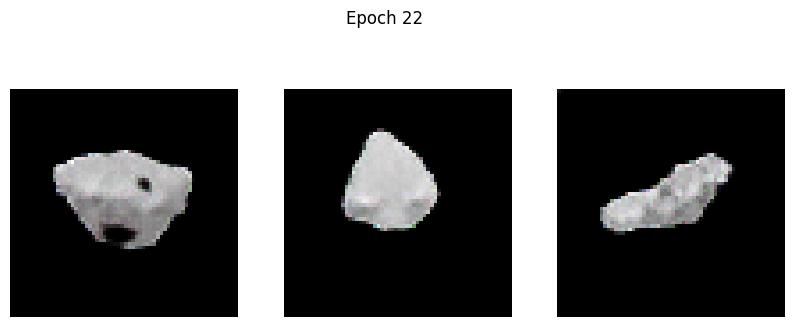

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.5774 - g_loss: 0.9230
Epoch 23/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.5447 - g_loss: 0.9758

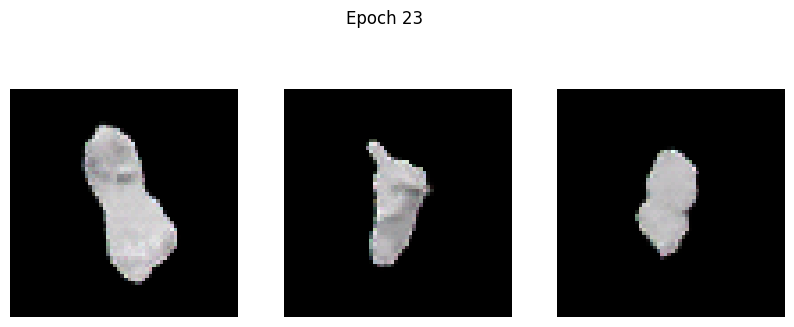

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.5447 - g_loss: 0.9760
Epoch 24/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.5297 - g_loss: 1.0455

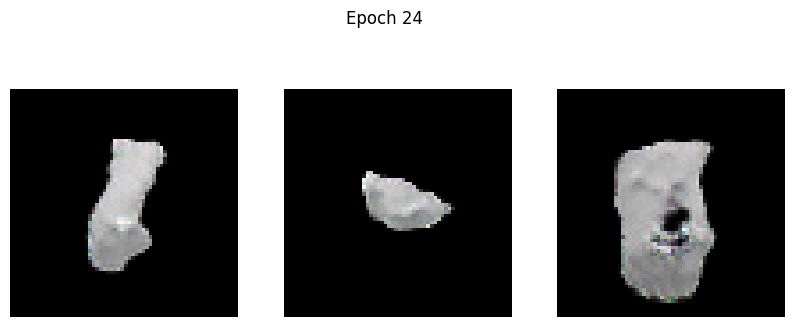

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.5296 - g_loss: 1.0457
Epoch 25/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.5176 - g_loss: 1.0794

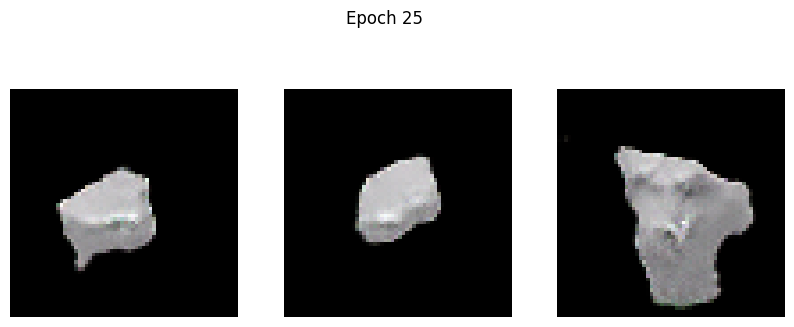

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.5176 - g_loss: 1.0796
Epoch 26/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.4994 - g_loss: 1.0966

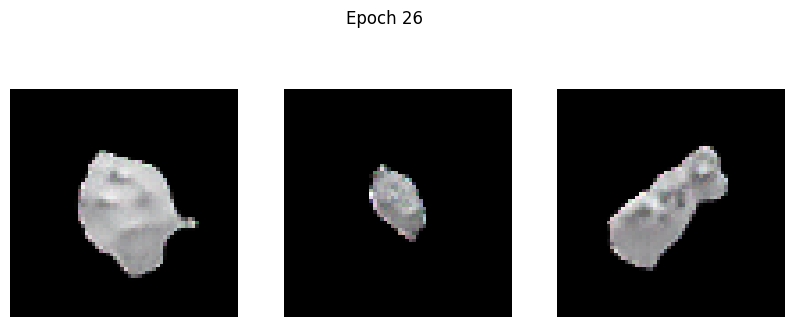

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.4994 - g_loss: 1.0968
Epoch 27/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.5196 - g_loss: 1.2052

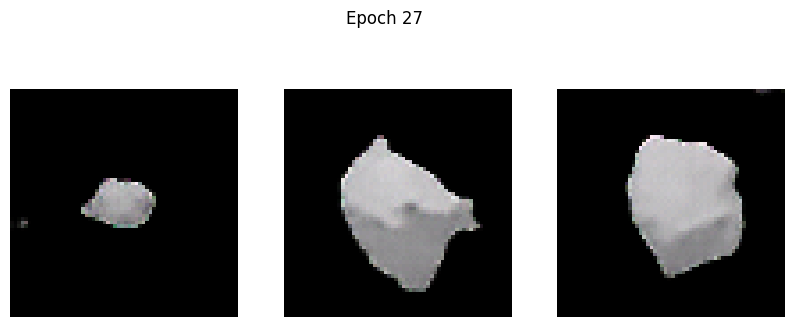

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.5197 - g_loss: 1.2054
Epoch 28/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.4814 - g_loss: 1.1104

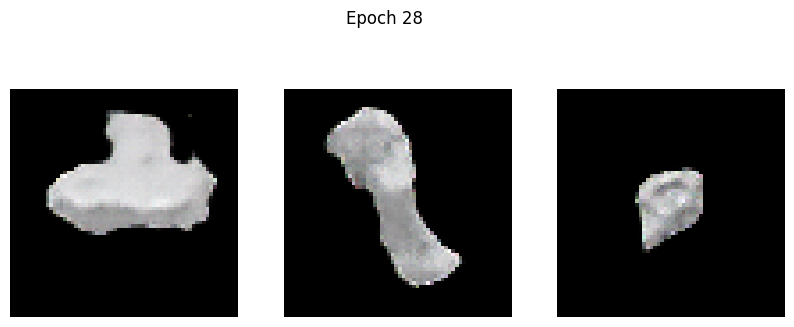

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.4814 - g_loss: 1.1108
Epoch 29/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.4710 - g_loss: 1.2014

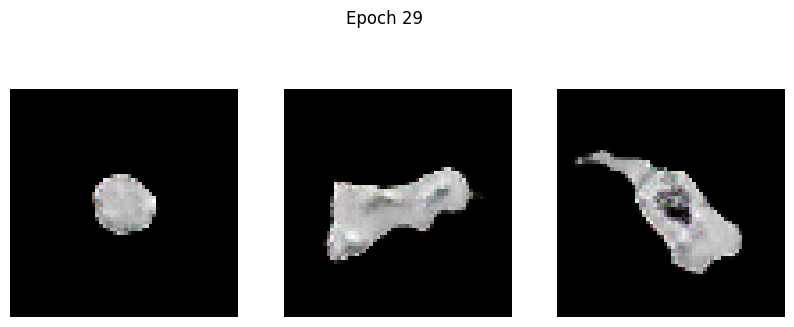

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.4710 - g_loss: 1.2016
Epoch 30/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.4754 - g_loss: 1.2749

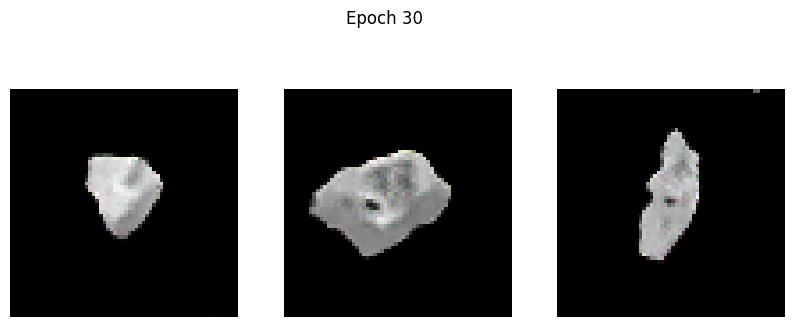

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.4754 - g_loss: 1.2747
Epoch 31/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.4919 - g_loss: 1.2831

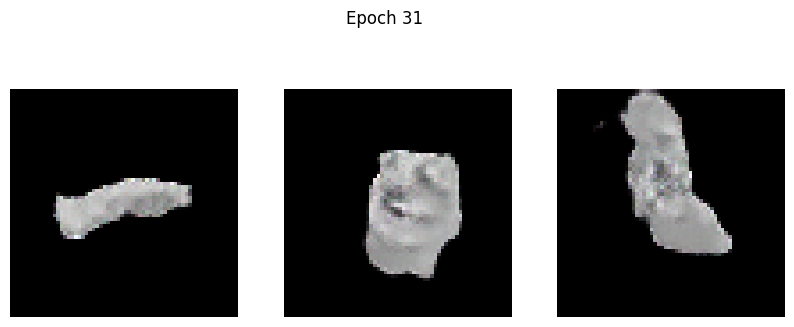

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.4921 - g_loss: 1.2831
Epoch 32/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.4400 - g_loss: 1.2031

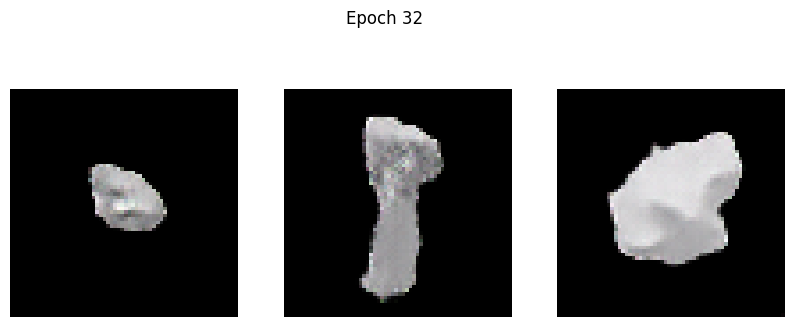

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.4400 - g_loss: 1.2036
Epoch 33/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.4482 - g_loss: 1.2992

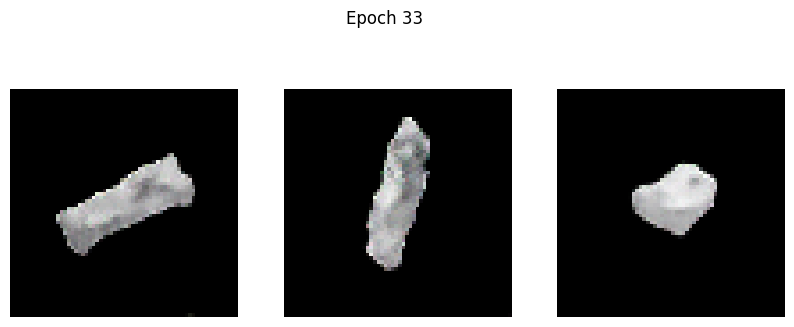

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.4482 - g_loss: 1.2993
Epoch 34/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.4413 - g_loss: 1.3331

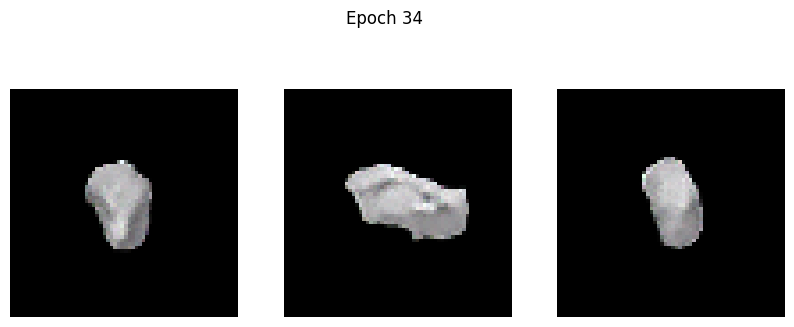

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.4414 - g_loss: 1.3334
Epoch 35/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.4147 - g_loss: 1.3158

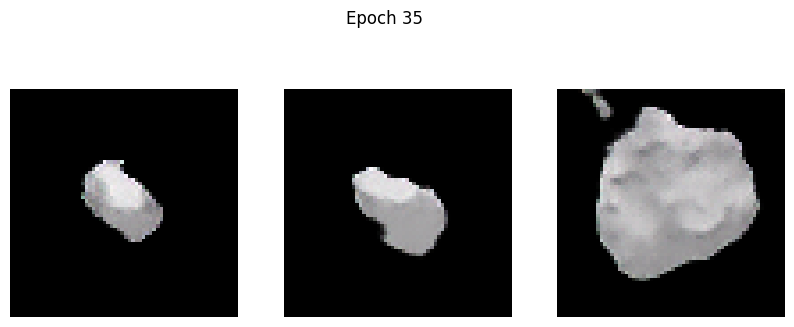

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.4147 - g_loss: 1.3160
Epoch 36/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.4243 - g_loss: 1.3791

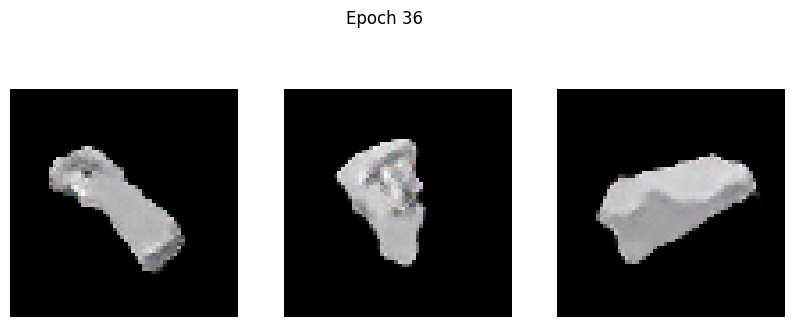

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.4242 - g_loss: 1.3791
Epoch 37/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.4553 - g_loss: 1.4467

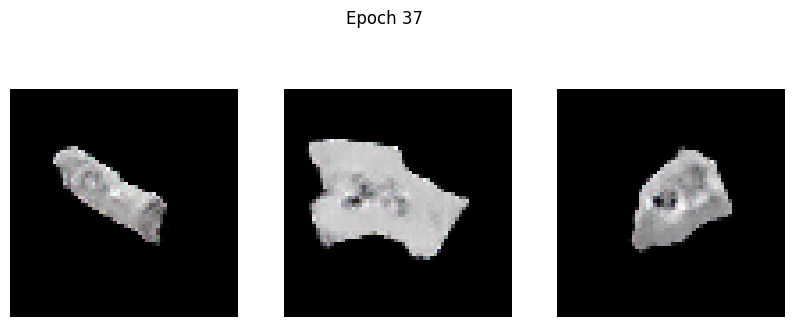

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.4551 - g_loss: 1.4467
Epoch 38/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3927 - g_loss: 1.4218

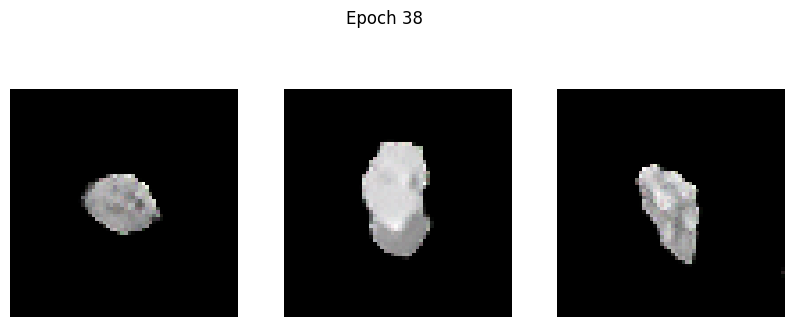

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3928 - g_loss: 1.4220
Epoch 39/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.4105 - g_loss: 1.4779

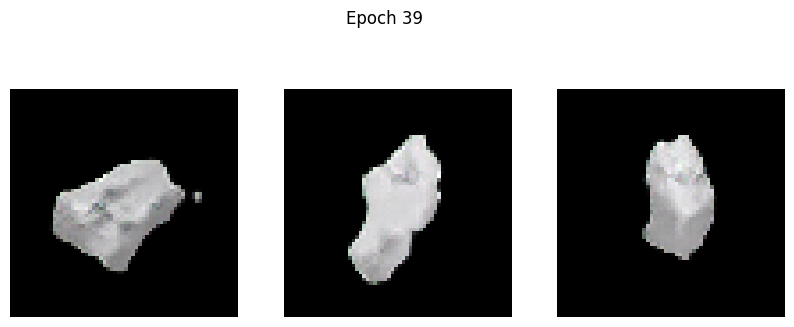

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.4105 - g_loss: 1.4778
Epoch 40/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.4004 - g_loss: 1.4785

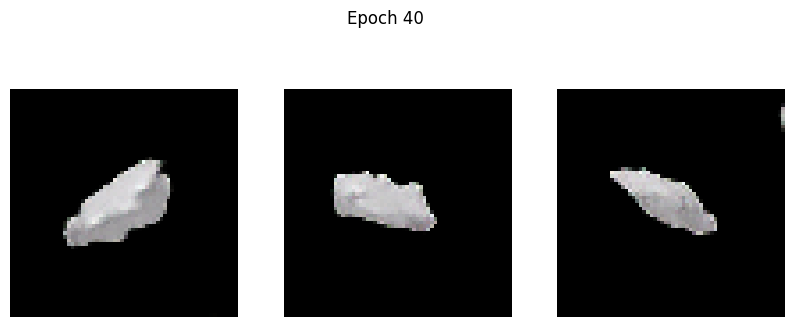

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.4003 - g_loss: 1.4786
Epoch 41/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.4015 - g_loss: 1.5309

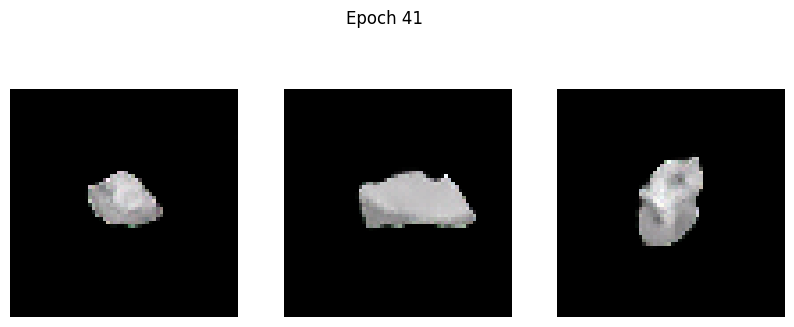

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.4014 - g_loss: 1.5309
Epoch 42/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.3870 - g_loss: 1.5634

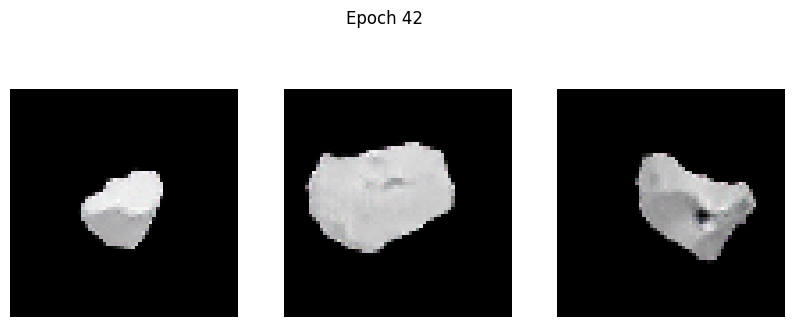

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3873 - g_loss: 1.5636
Epoch 43/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.3868 - g_loss: 1.5657

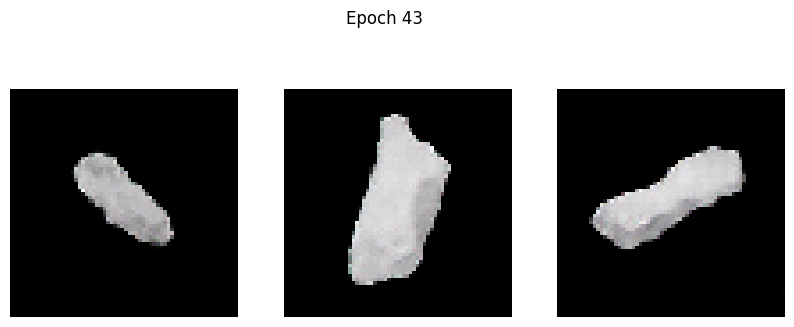

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.3876 - g_loss: 1.5669
Epoch 44/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3624 - g_loss: 1.4683

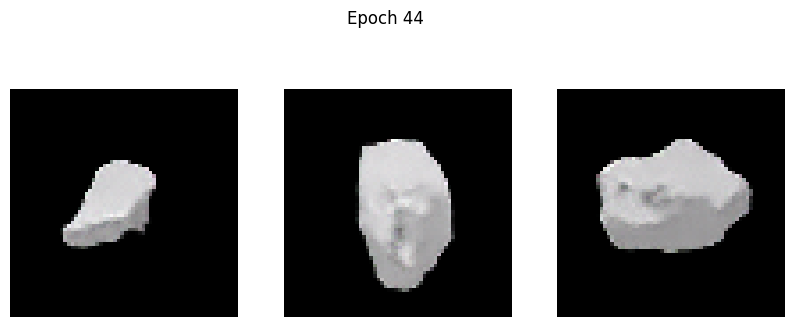

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - d_loss: 0.3624 - g_loss: 1.4682
Epoch 45/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.3552 - g_loss: 1.5161

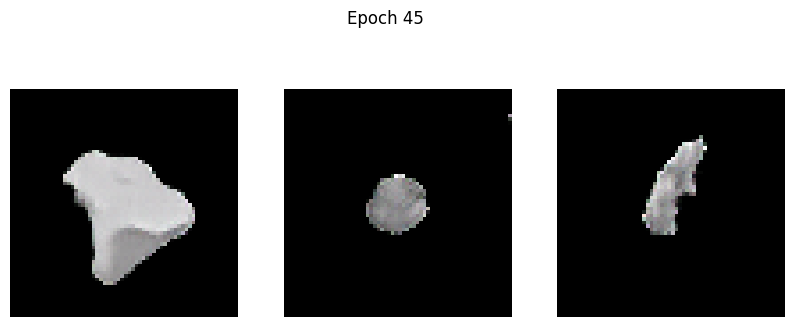

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.3552 - g_loss: 1.5165
Epoch 46/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.3651 - g_loss: 1.6073

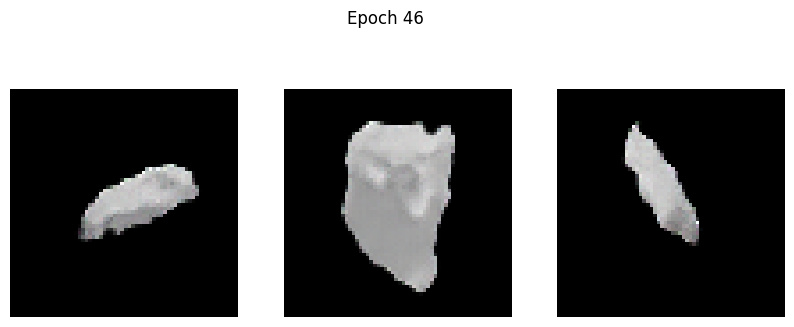

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.3652 - g_loss: 1.6073
Epoch 47/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.3820 - g_loss: 1.6374

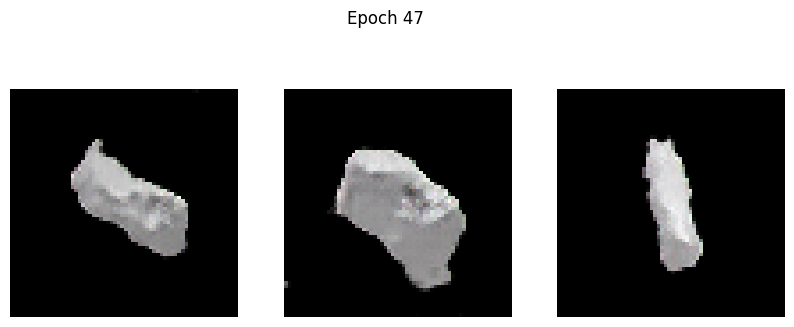

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.3818 - g_loss: 1.6373
Epoch 48/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3562 - g_loss: 1.6881

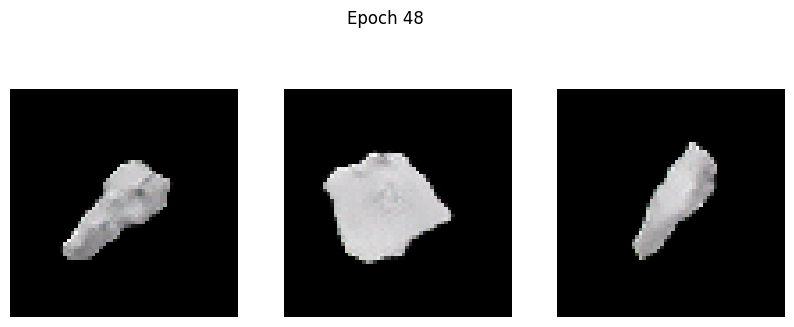

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3563 - g_loss: 1.6879
Epoch 49/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3554 - g_loss: 1.6903

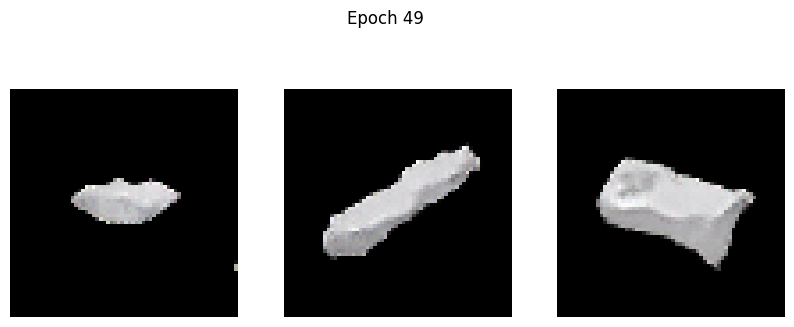

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3554 - g_loss: 1.6901
Epoch 50/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3411 - g_loss: 1.7398

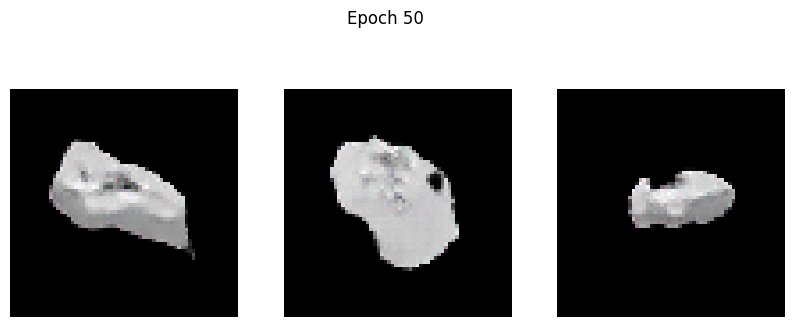

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3412 - g_loss: 1.7399
Epoch 51/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3693 - g_loss: 1.7147

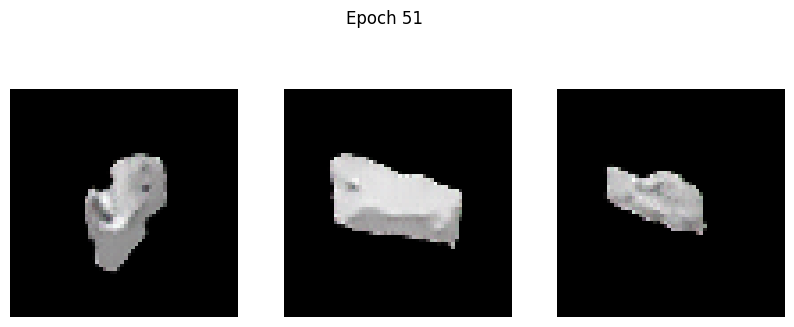

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3693 - g_loss: 1.7148
Epoch 52/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.3276 - g_loss: 1.7140

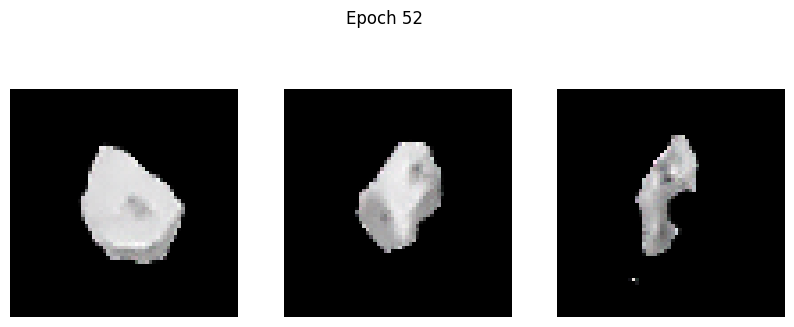

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.3277 - g_loss: 1.7143
Epoch 53/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.3868 - g_loss: 1.8616

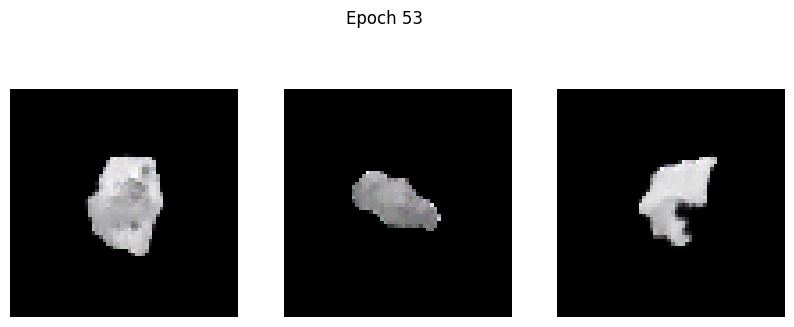

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.3870 - g_loss: 1.8611
Epoch 54/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.3134 - g_loss: 1.6701

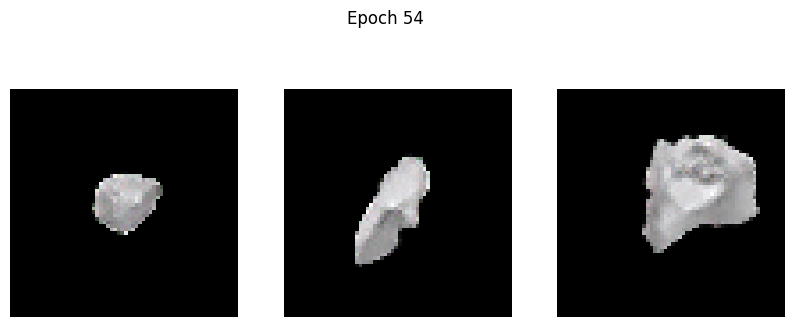

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3134 - g_loss: 1.6705
Epoch 55/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3287 - g_loss: 1.8073

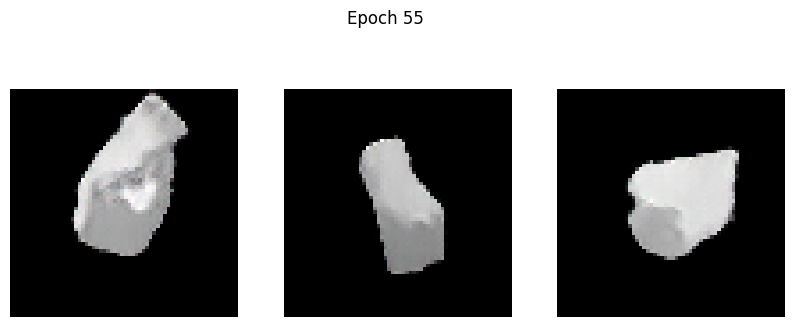

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3289 - g_loss: 1.8079
Epoch 56/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3618 - g_loss: 1.7644

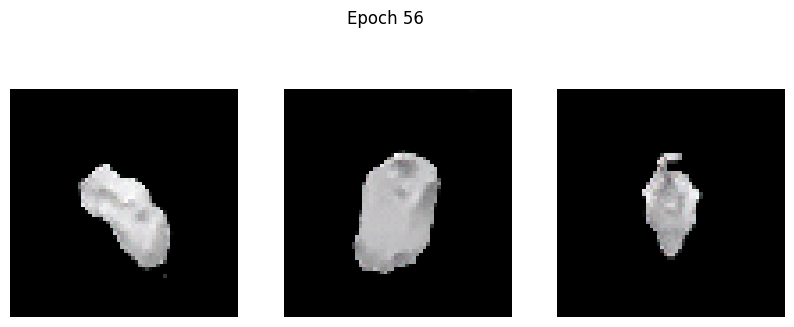

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3615 - g_loss: 1.7645
Epoch 57/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3119 - g_loss: 1.8313

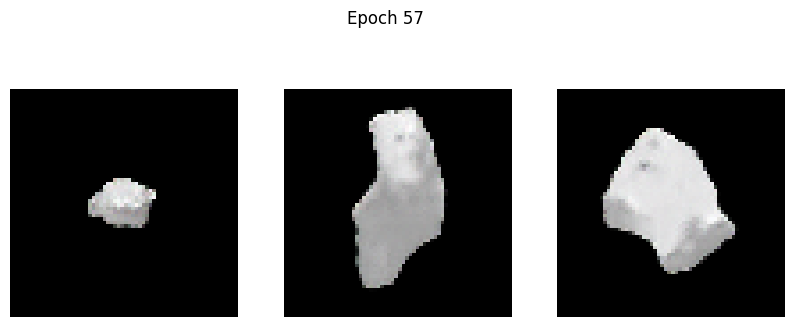

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3119 - g_loss: 1.8314
Epoch 58/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3388 - g_loss: 1.8881

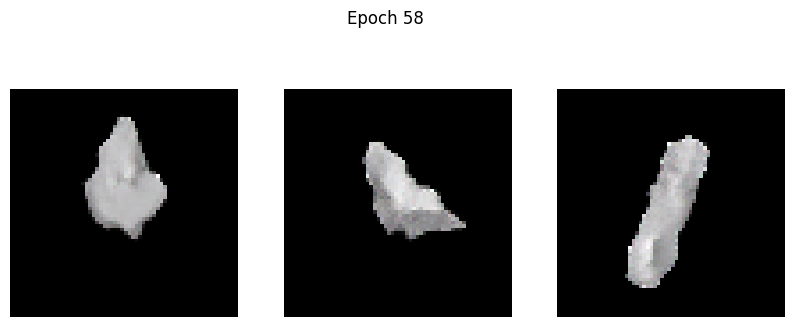

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3392 - g_loss: 1.8886
Epoch 59/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2989 - g_loss: 1.7649

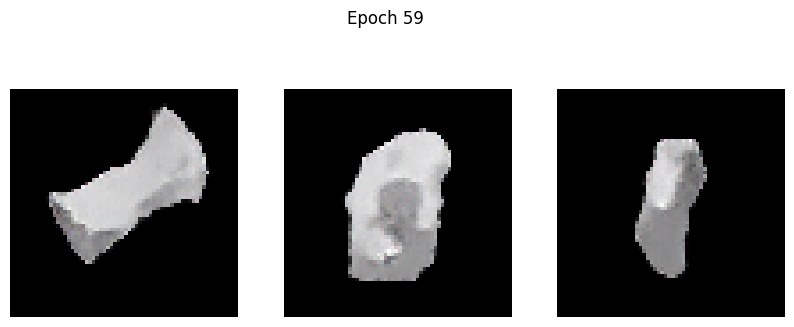

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2989 - g_loss: 1.7650
Epoch 60/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3114 - g_loss: 1.8956

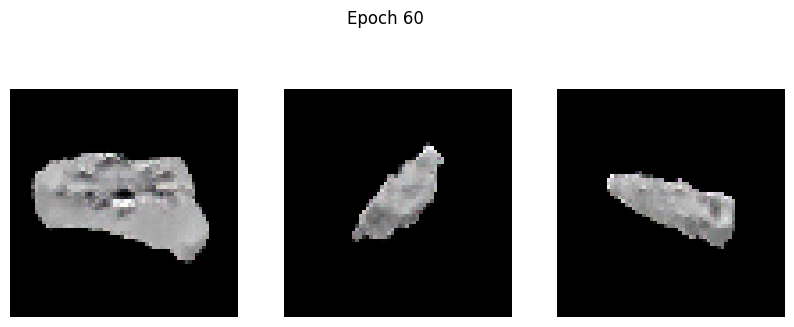

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3114 - g_loss: 1.8957
Epoch 61/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.3660 - g_loss: 1.9303

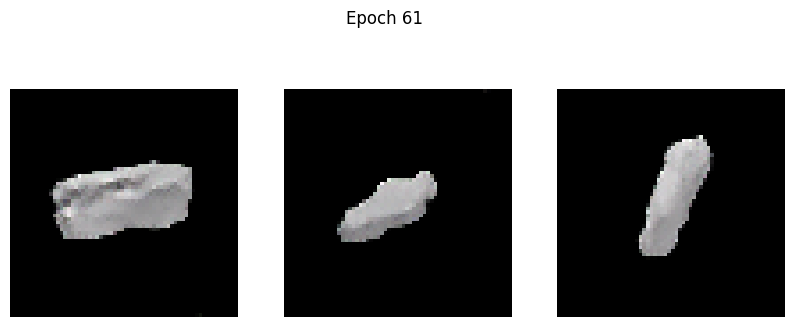

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3657 - g_loss: 1.9303
Epoch 62/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2872 - g_loss: 1.8643

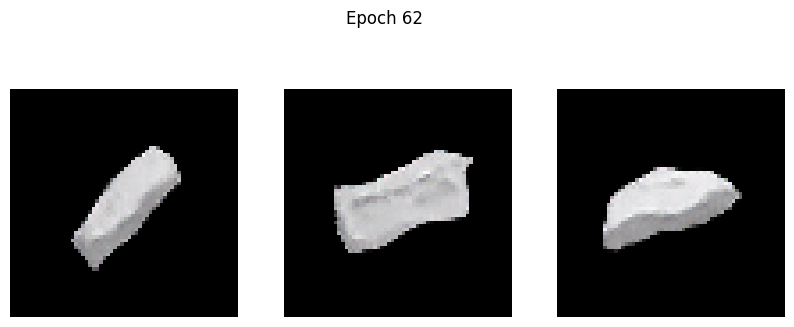

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2874 - g_loss: 1.8648
Epoch 63/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2803 - g_loss: 1.9147

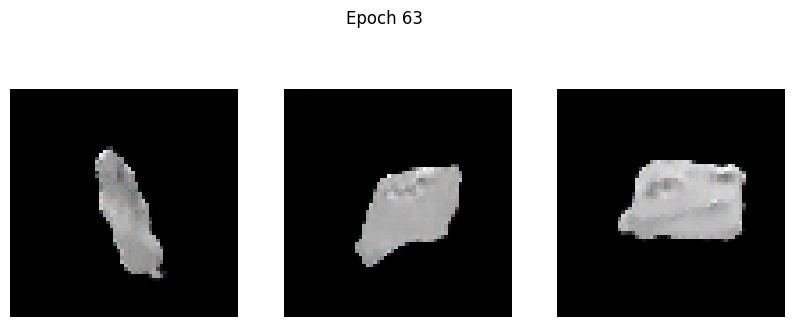

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2805 - g_loss: 1.9149
Epoch 64/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.3498 - g_loss: 2.0601

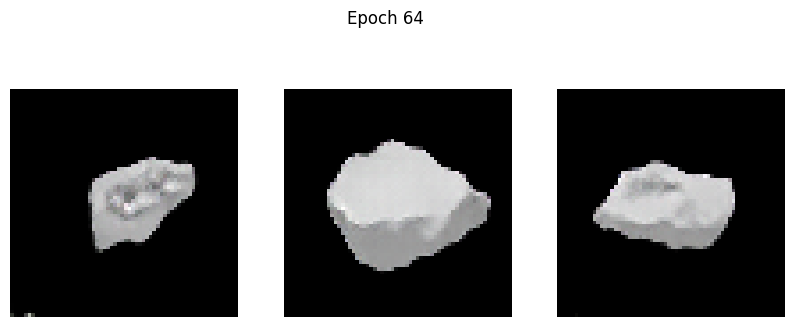

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.3495 - g_loss: 2.0597
Epoch 65/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.3022 - g_loss: 1.9985

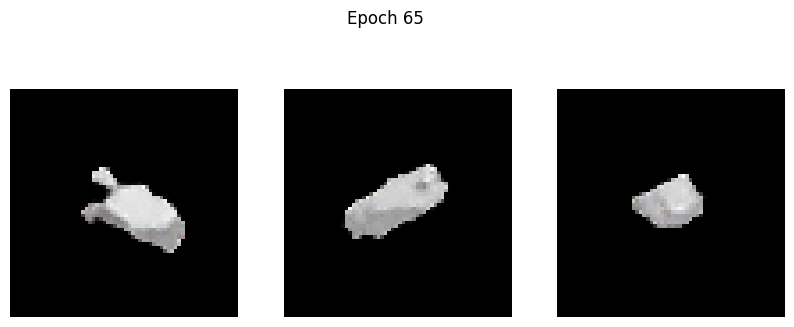

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3022 - g_loss: 1.9985
Epoch 66/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2775 - g_loss: 1.9511

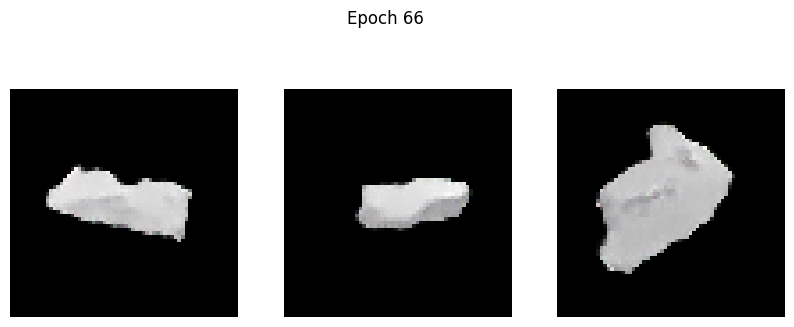

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2776 - g_loss: 1.9512
Epoch 67/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.3104 - g_loss: 2.1048

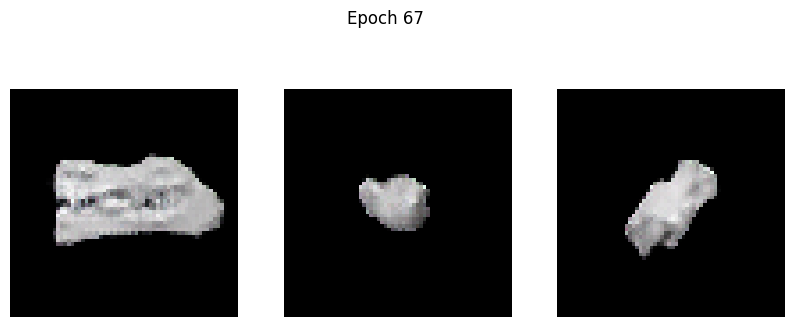

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.3114 - g_loss: 2.1056
Epoch 68/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.4429 - g_loss: 1.8702

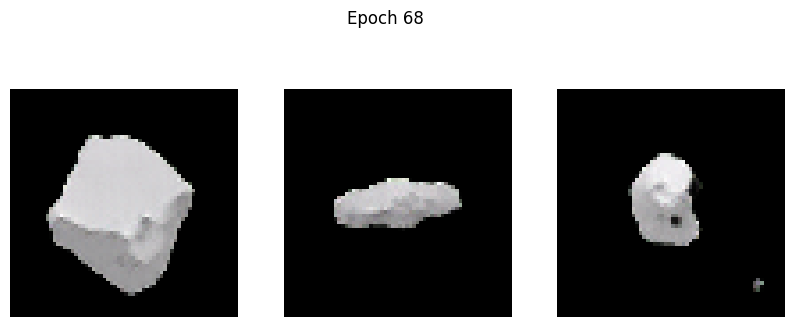

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.4419 - g_loss: 1.8698
Epoch 69/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2720 - g_loss: 1.9114

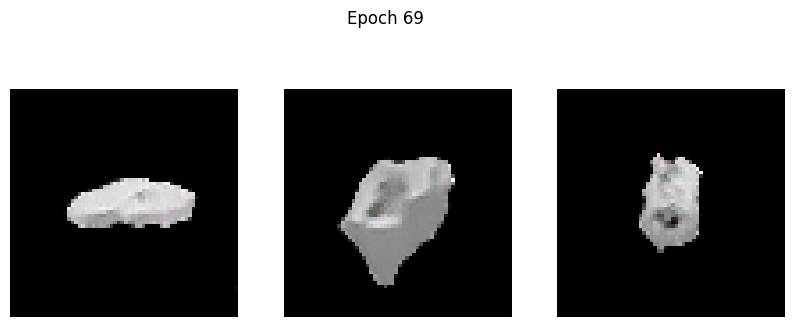

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2721 - g_loss: 1.9117
Epoch 70/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2895 - g_loss: 2.0568

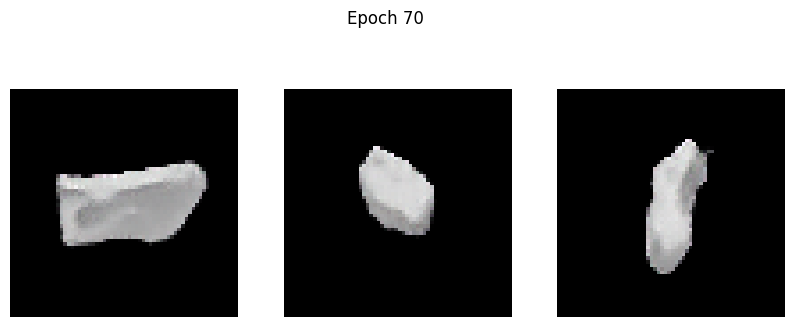

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2894 - g_loss: 2.0562
Epoch 71/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2818 - g_loss: 2.0187

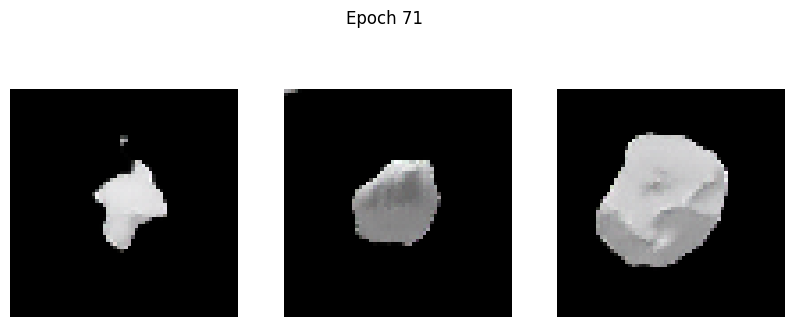

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2819 - g_loss: 2.0190
Epoch 72/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2456 - g_loss: 2.0578

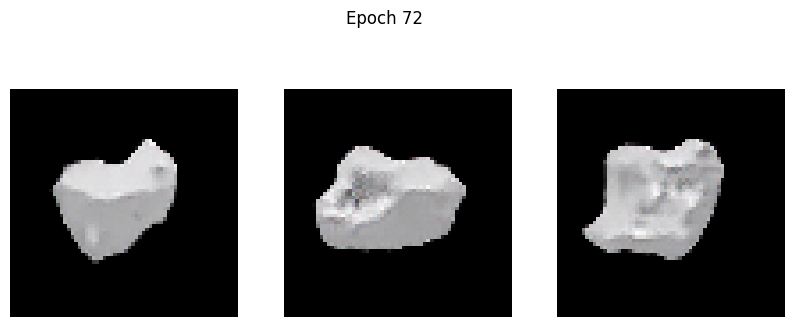

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2457 - g_loss: 2.0579
Epoch 73/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2827 - g_loss: 2.1365

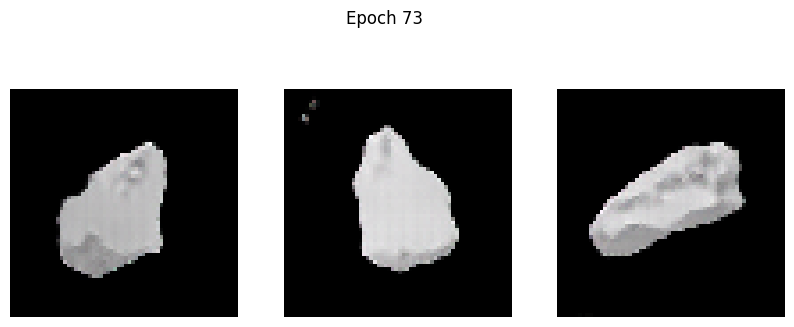

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2826 - g_loss: 2.1364
Epoch 74/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2791 - g_loss: 2.2311

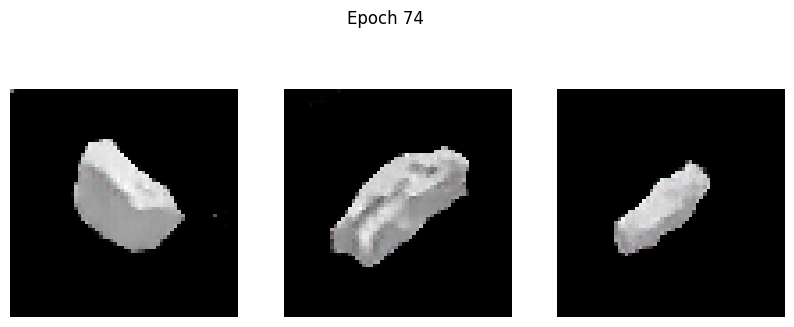

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2793 - g_loss: 2.2309
Epoch 75/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2810 - g_loss: 2.1374

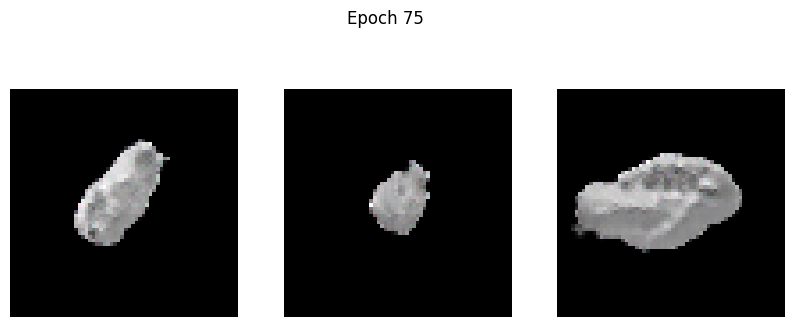

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2809 - g_loss: 2.1373
Epoch 76/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3123 - g_loss: 2.1608

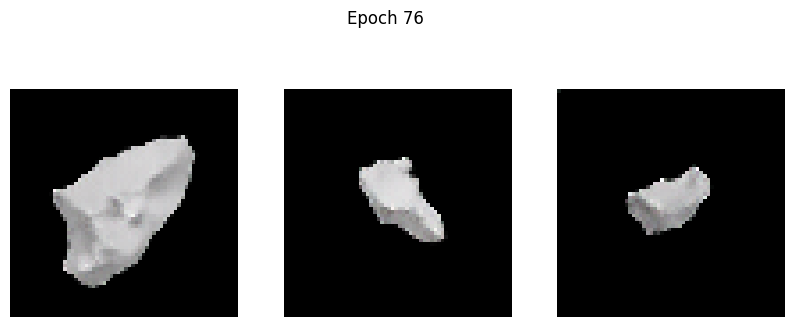

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3120 - g_loss: 2.1608
Epoch 77/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2942 - g_loss: 2.1886

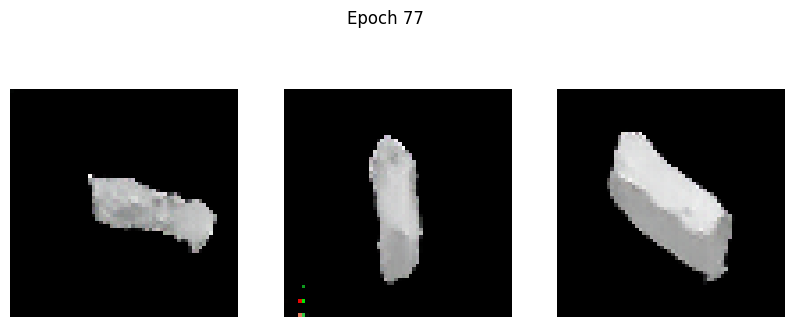

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2944 - g_loss: 2.1888
Epoch 78/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2935 - g_loss: 2.1263

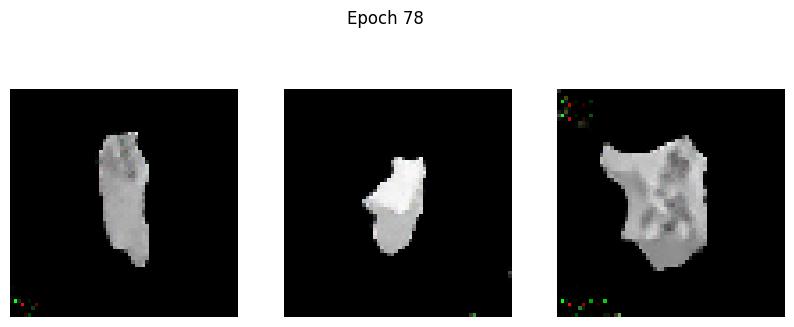

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2933 - g_loss: 2.1262
Epoch 79/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2931 - g_loss: 2.1896

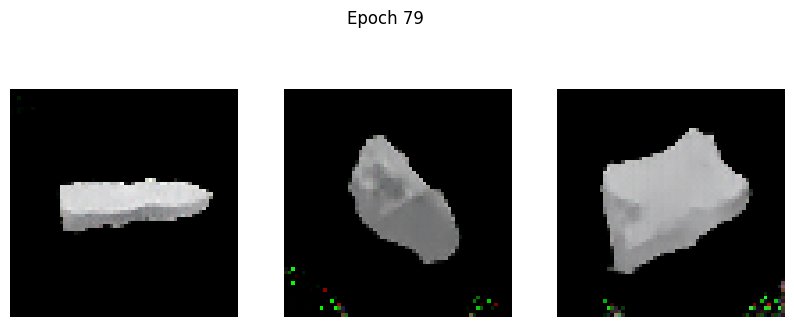

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2934 - g_loss: 2.1896
Epoch 80/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2962 - g_loss: 2.0847

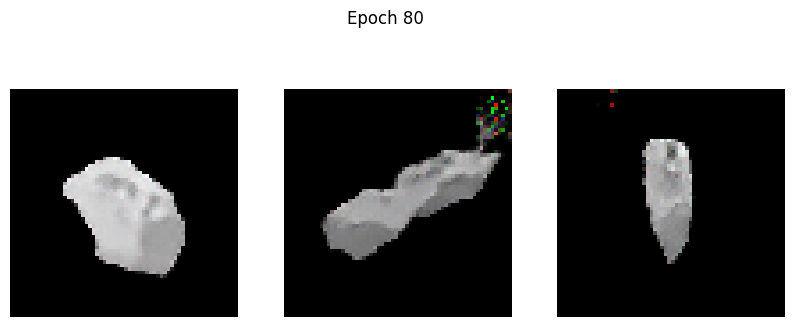

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.2960 - g_loss: 2.0846
Epoch 81/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.3063 - g_loss: 2.2912

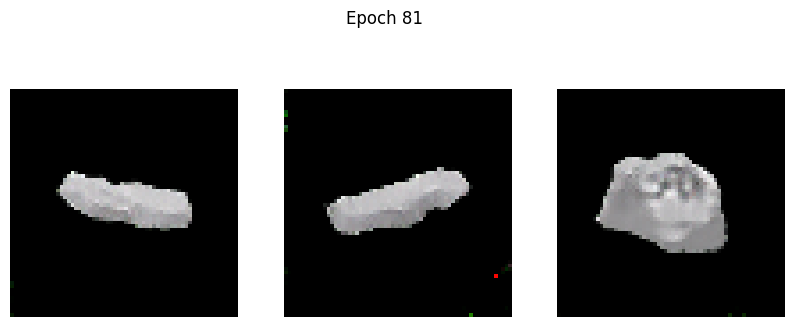

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3063 - g_loss: 2.2908
Epoch 82/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2736 - g_loss: 2.1482

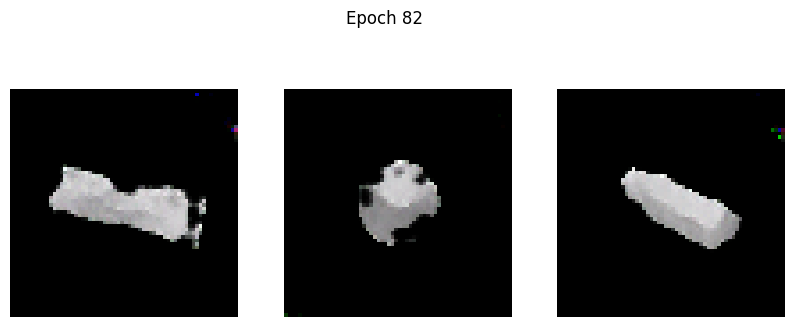

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2741 - g_loss: 2.1492
Epoch 83/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2631 - g_loss: 2.0783

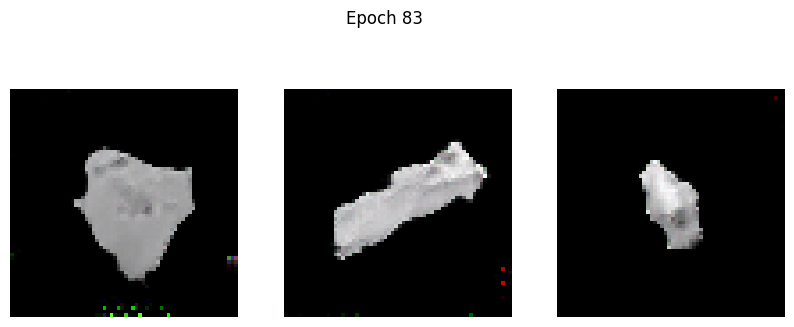

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2630 - g_loss: 2.0784
Epoch 84/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.3138 - g_loss: 2.2027

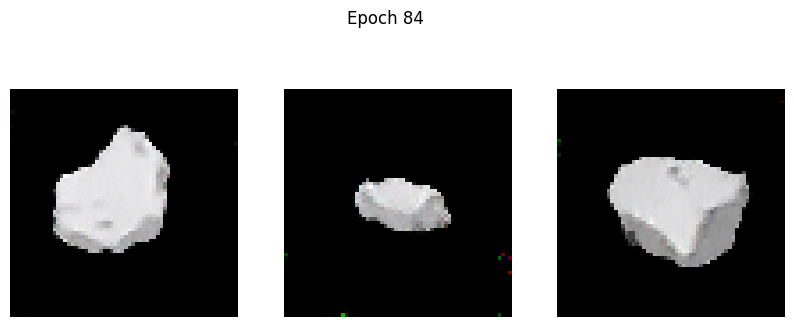

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.3140 - g_loss: 2.2028
Epoch 85/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2473 - g_loss: 2.1226

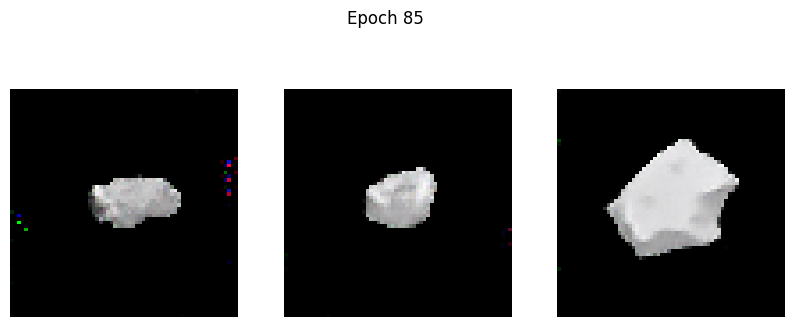

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2474 - g_loss: 2.1227
Epoch 86/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.3616 - g_loss: 2.4281

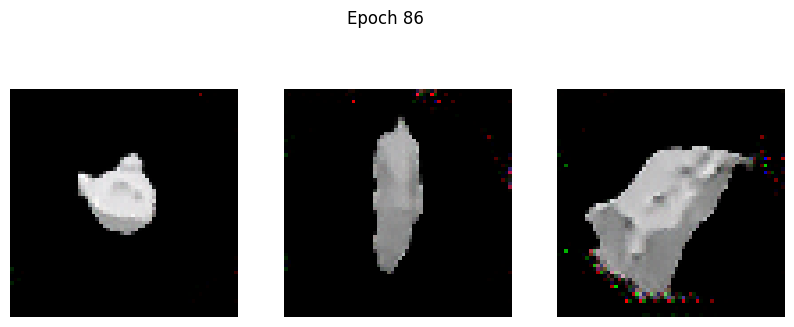

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.3620 - g_loss: 2.4280
Epoch 87/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2451 - g_loss: 2.0673

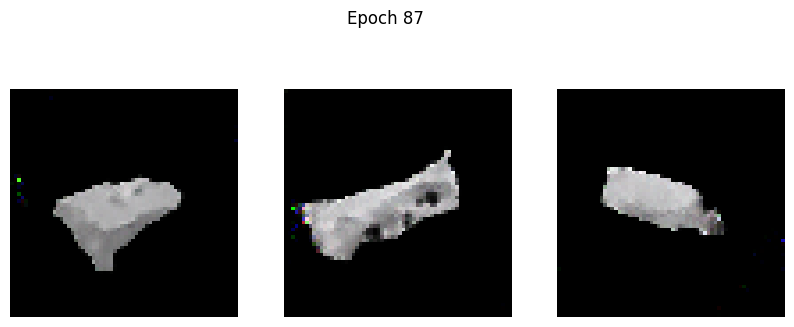

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.2452 - g_loss: 2.0672
Epoch 88/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.2532 - g_loss: 2.1699

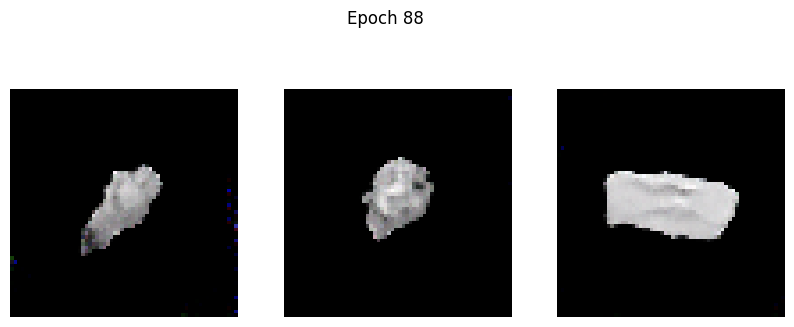

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.2533 - g_loss: 2.1697
Epoch 89/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2636 - g_loss: 2.2202

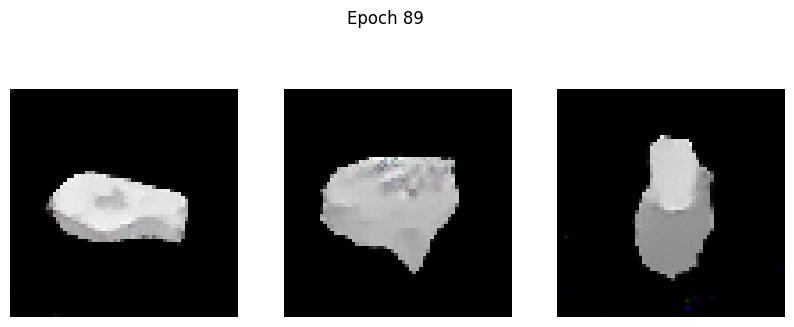

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.2635 - g_loss: 2.2199
Epoch 90/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2335 - g_loss: 2.1489

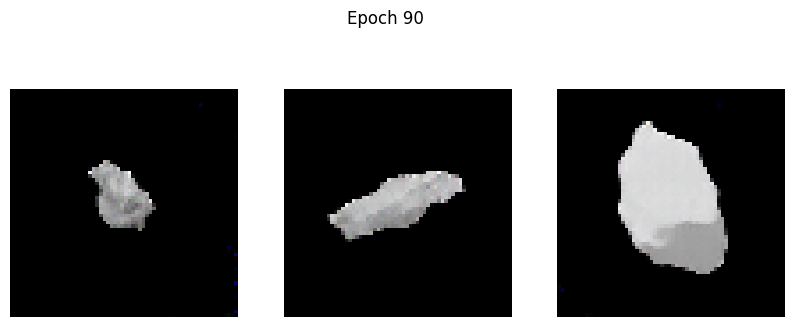

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.2335 - g_loss: 2.1493
Epoch 91/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2572 - g_loss: 2.2621

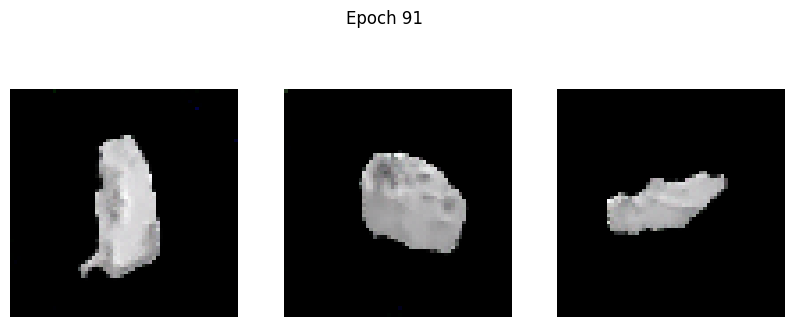

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2575 - g_loss: 2.2621
Epoch 92/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2480 - g_loss: 2.3246

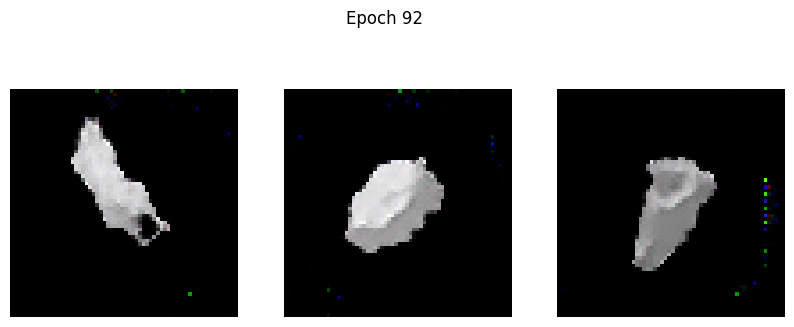

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2481 - g_loss: 2.3250
Epoch 93/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.3305 - g_loss: 2.5279

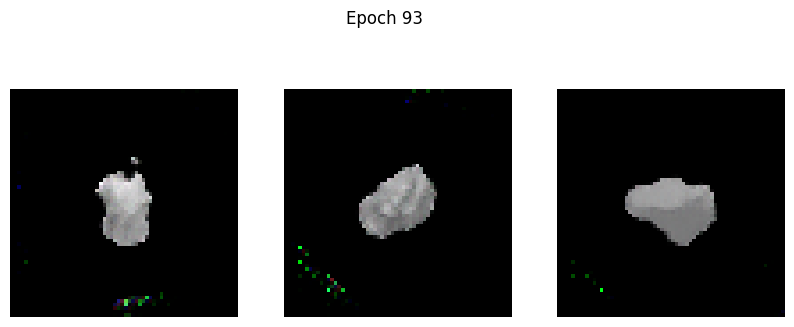

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.3312 - g_loss: 2.5295
Epoch 94/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2406 - g_loss: 2.1544

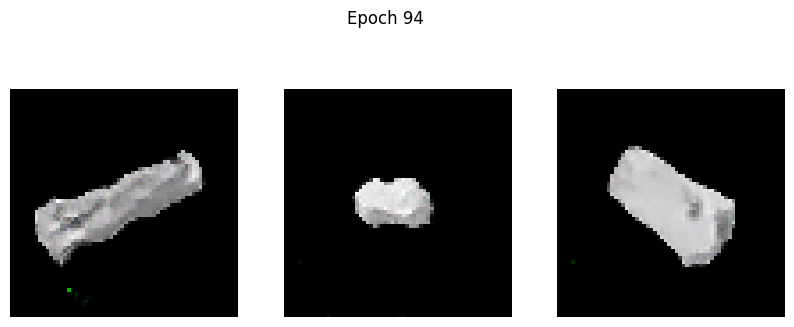

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2405 - g_loss: 2.1543
Epoch 95/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2285 - g_loss: 2.1900

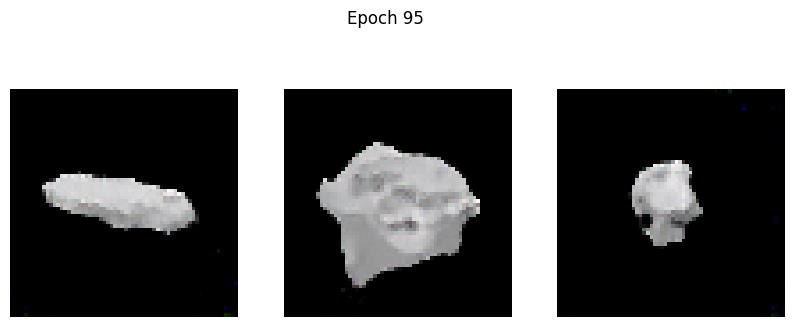

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2286 - g_loss: 2.1903
Epoch 96/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2386 - g_loss: 2.2545

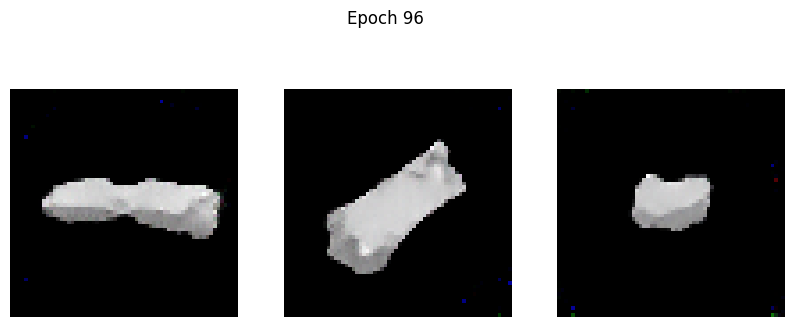

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2386 - g_loss: 2.2548
Epoch 97/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2383 - g_loss: 2.2932

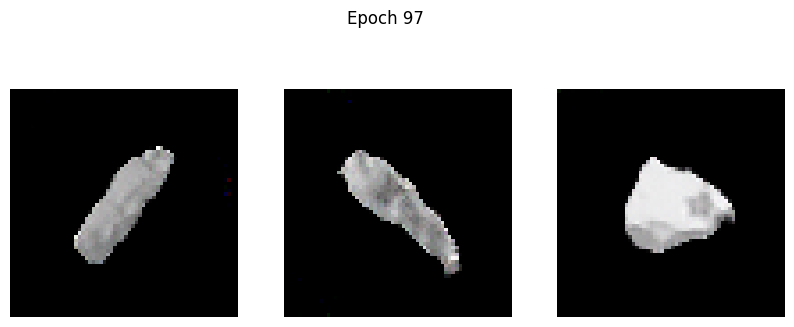

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2384 - g_loss: 2.2935
Epoch 98/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2368 - g_loss: 2.3157

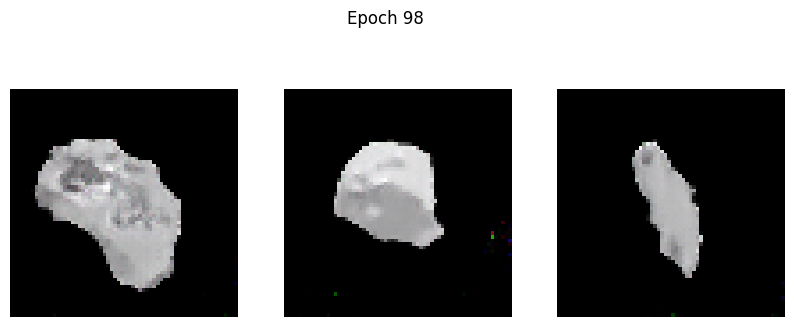

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - d_loss: 0.2371 - g_loss: 2.3159
Epoch 99/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.2440 - g_loss: 2.2706

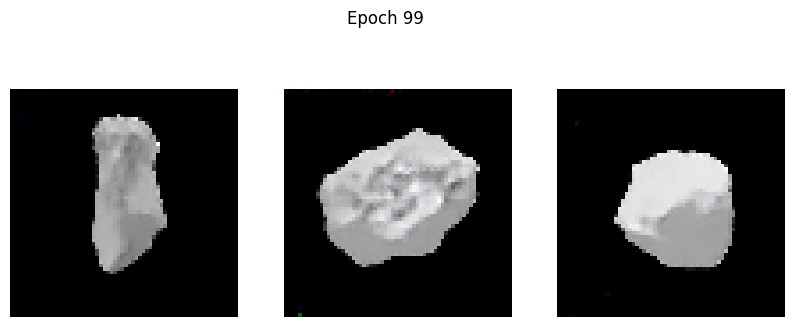

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.2439 - g_loss: 2.2711
Epoch 100/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.2229 - g_loss: 2.3912

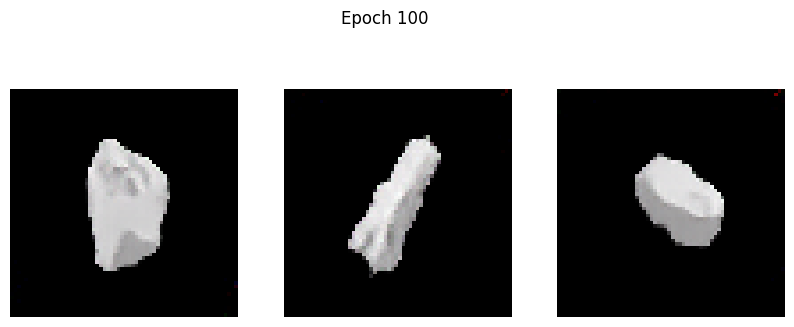

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.2230 - g_loss: 2.3909
Epoch 101/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.2409 - g_loss: 2.4262

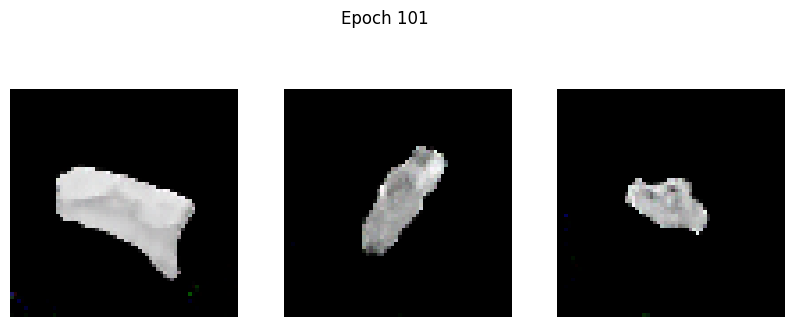

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - d_loss: 0.2409 - g_loss: 2.4261
Epoch 102/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2693 - g_loss: 2.4400

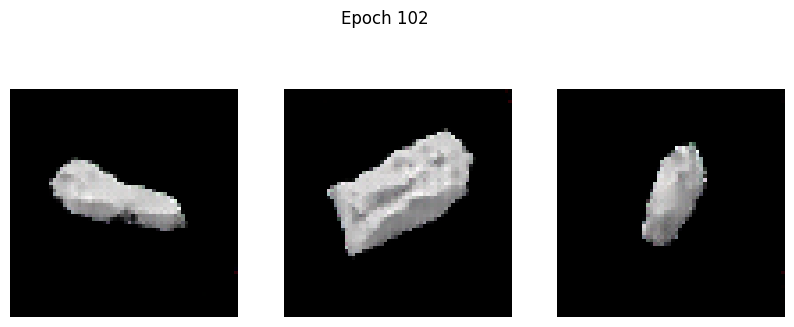

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2699 - g_loss: 2.4422
Epoch 103/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.4342 - g_loss: 2.4684

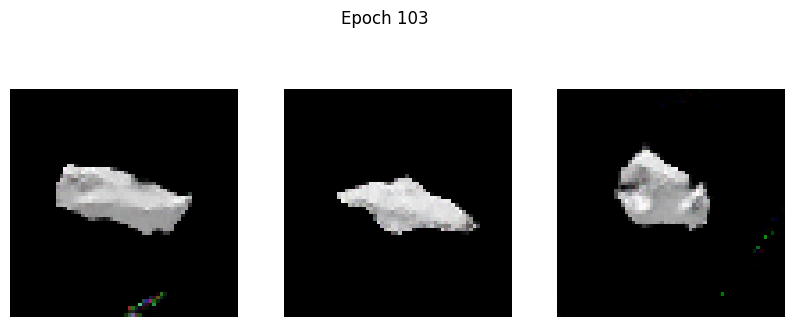

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.4326 - g_loss: 2.4667
Epoch 104/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2013 - g_loss: 2.2981

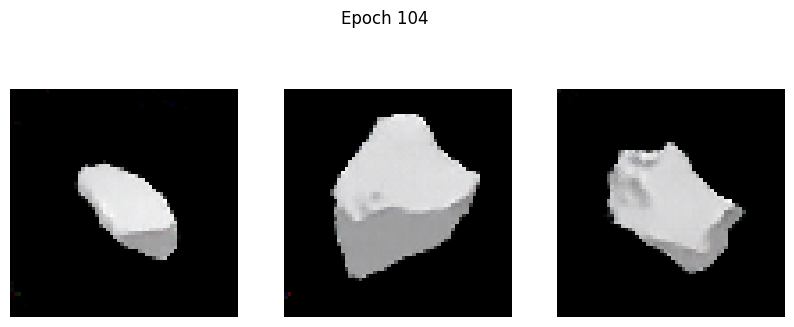

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2013 - g_loss: 2.2982
Epoch 105/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2163 - g_loss: 2.4266

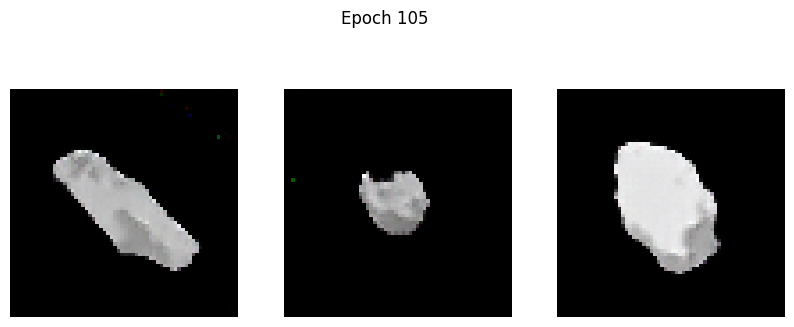

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2164 - g_loss: 2.4267
Epoch 106/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.2120 - g_loss: 2.4157

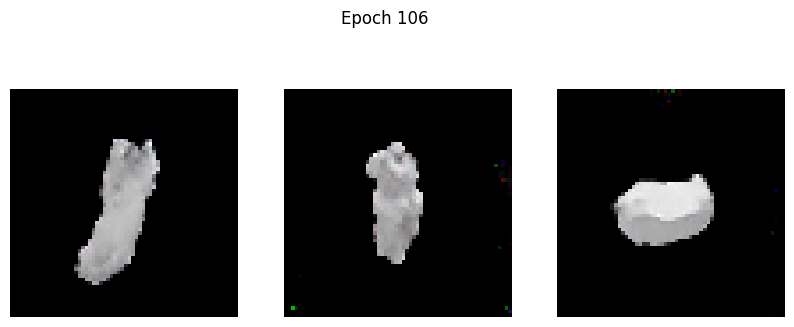

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.2121 - g_loss: 2.4160
Epoch 107/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.2164 - g_loss: 2.4017

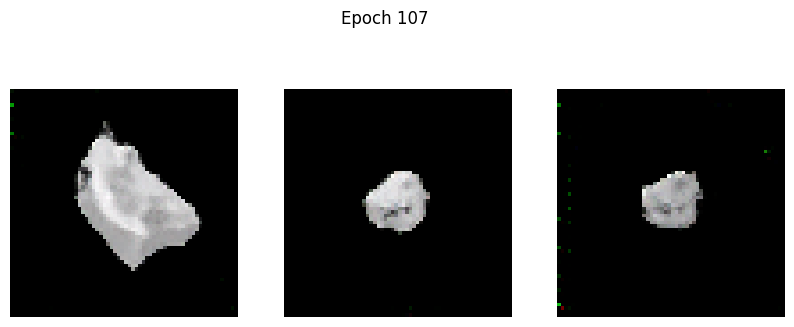

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.2162 - g_loss: 2.4021
Epoch 108/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.3012 - g_loss: 2.6213

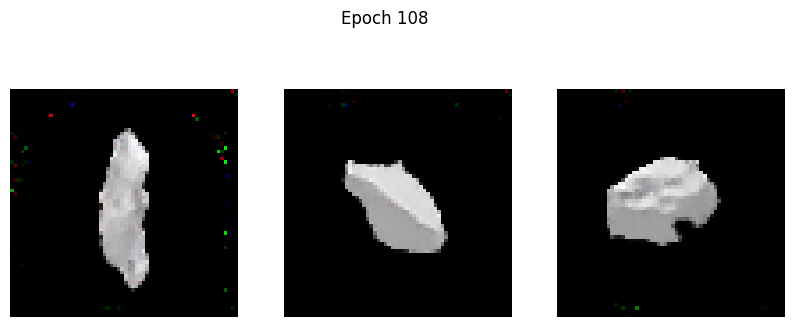

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.3010 - g_loss: 2.6208
Epoch 109/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1964 - g_loss: 2.4291

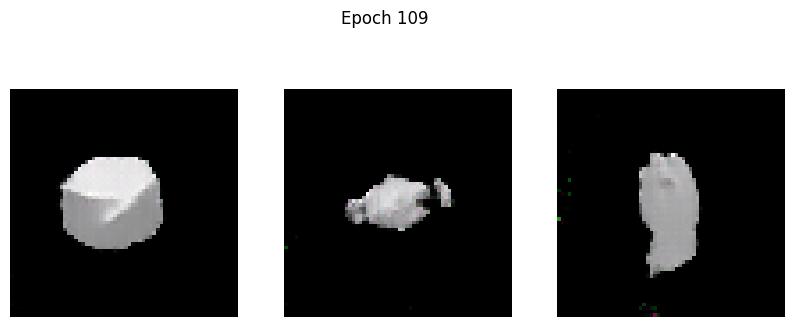

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1967 - g_loss: 2.4300
Epoch 110/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.3937 - g_loss: 2.6844

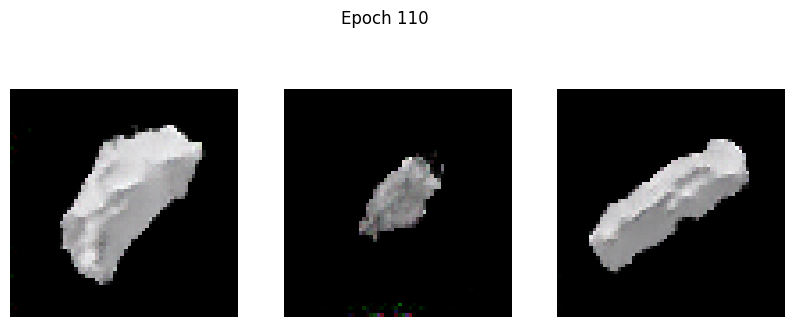

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.3925 - g_loss: 2.6825
Epoch 111/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1965 - g_loss: 2.4179

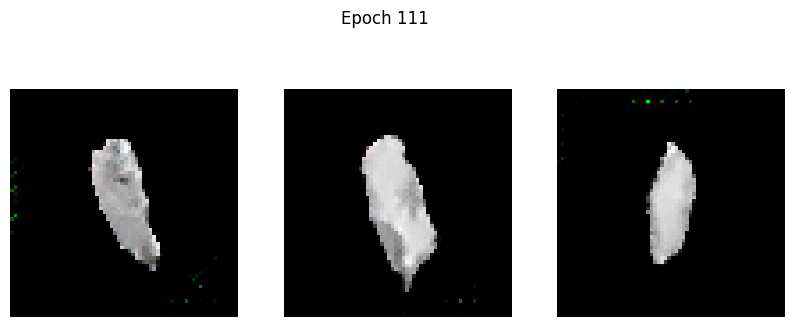

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1967 - g_loss: 2.4183
Epoch 112/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2013 - g_loss: 2.4705

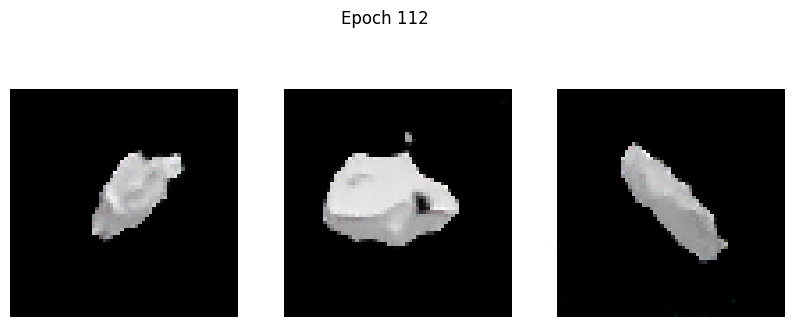

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2013 - g_loss: 2.4708
Epoch 113/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2185 - g_loss: 2.5915

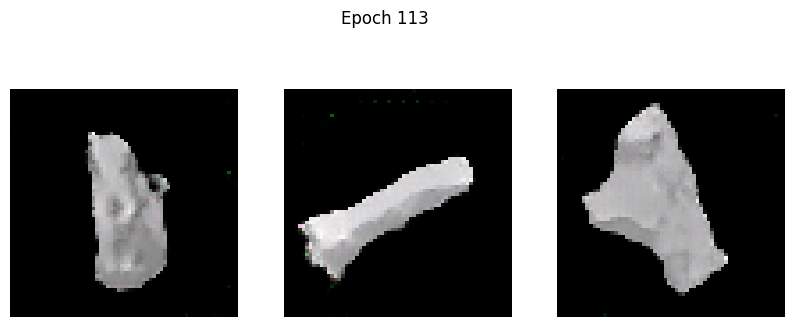

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2184 - g_loss: 2.5914
Epoch 114/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.2262 - g_loss: 2.6355

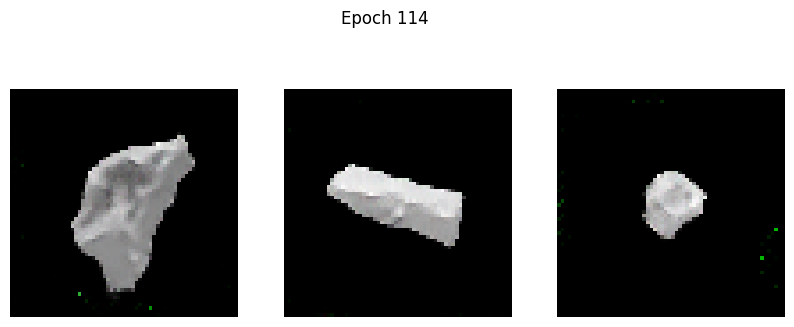

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2263 - g_loss: 2.6352
Epoch 115/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1934 - g_loss: 2.5755

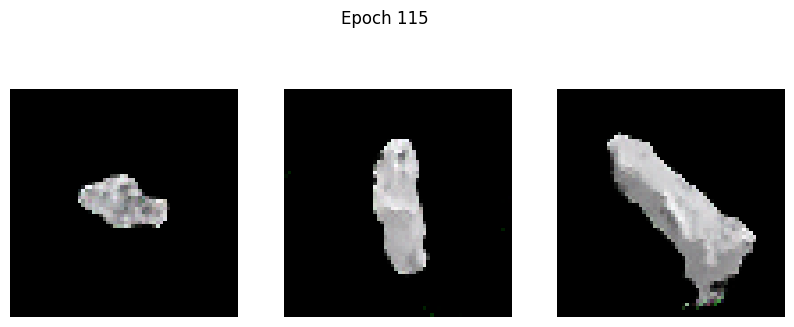

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1934 - g_loss: 2.5755
Epoch 116/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2187 - g_loss: 2.6397

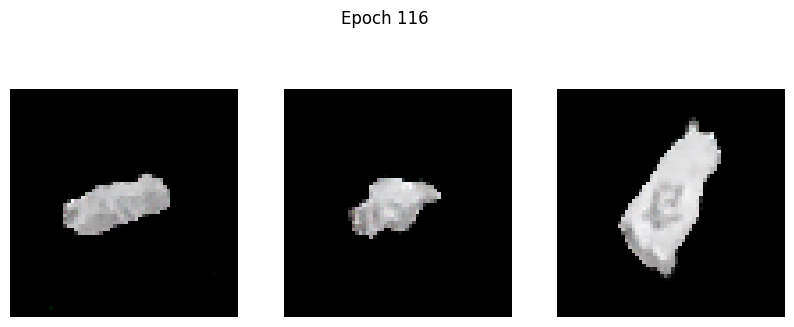

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2187 - g_loss: 2.6394
Epoch 117/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1925 - g_loss: 2.6211

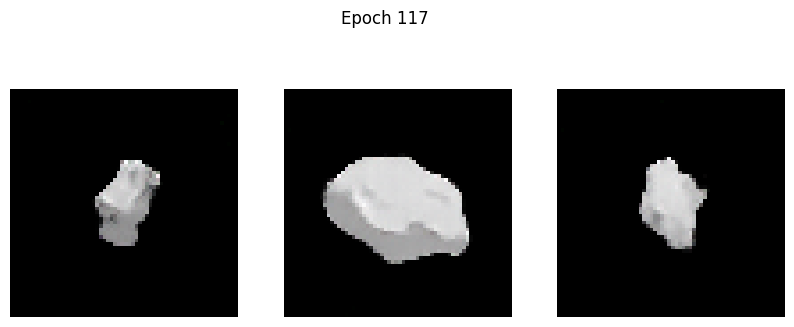

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1927 - g_loss: 2.6215
Epoch 118/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2317 - g_loss: 2.6760

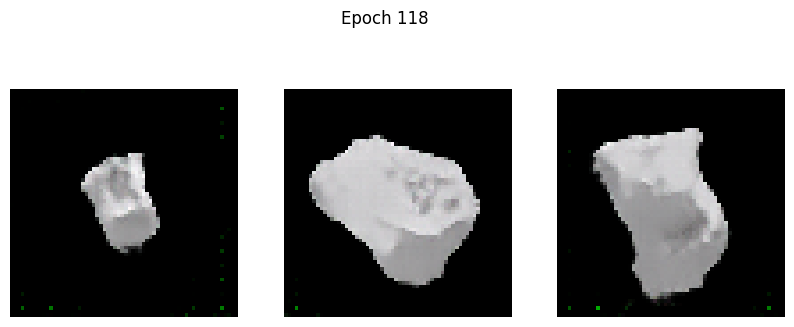

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2314 - g_loss: 2.6759
Epoch 119/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.3614 - g_loss: 2.9337

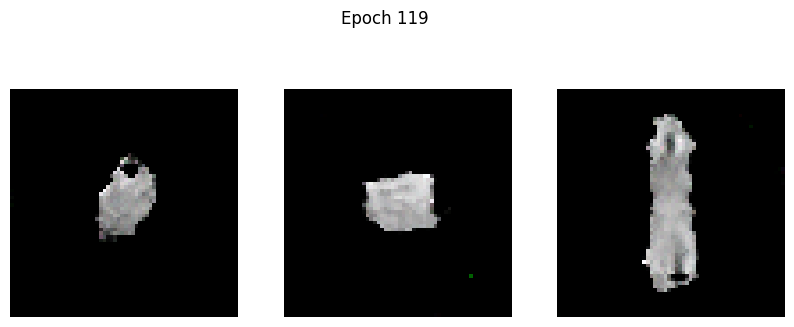

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.3619 - g_loss: 2.9330
Epoch 120/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.1786 - g_loss: 2.4261

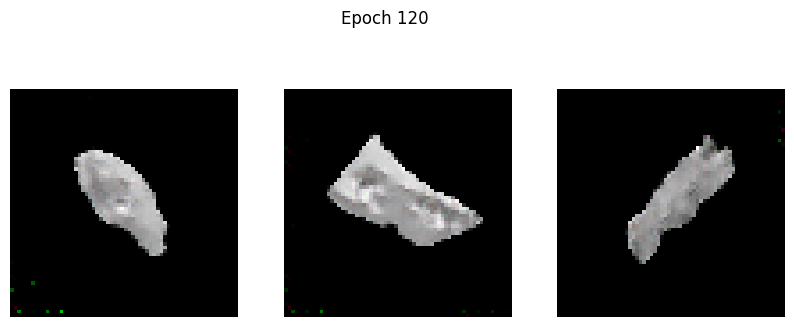

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1786 - g_loss: 2.4266
Epoch 121/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1852 - g_loss: 2.5933

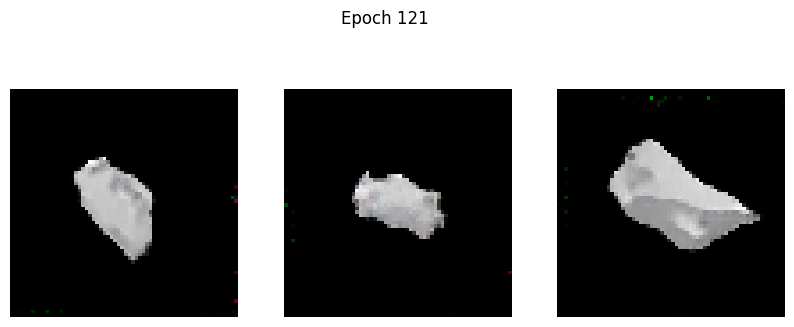

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1852 - g_loss: 2.5933
Epoch 122/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1833 - g_loss: 2.6250

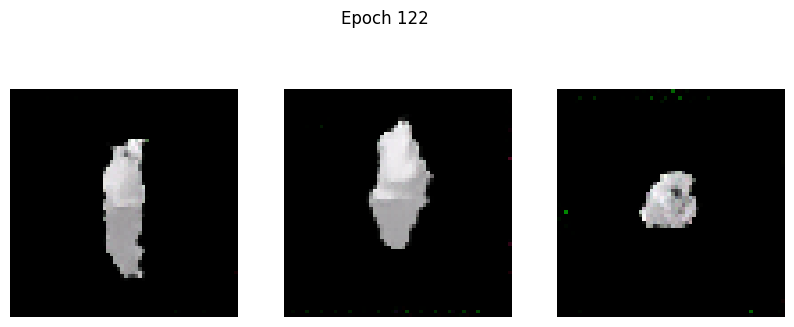

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1832 - g_loss: 2.6252
Epoch 123/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2170 - g_loss: 2.6728

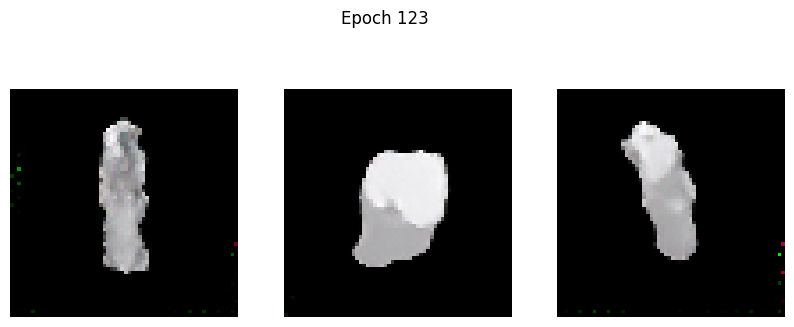

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2169 - g_loss: 2.6728
Epoch 124/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1774 - g_loss: 2.7208

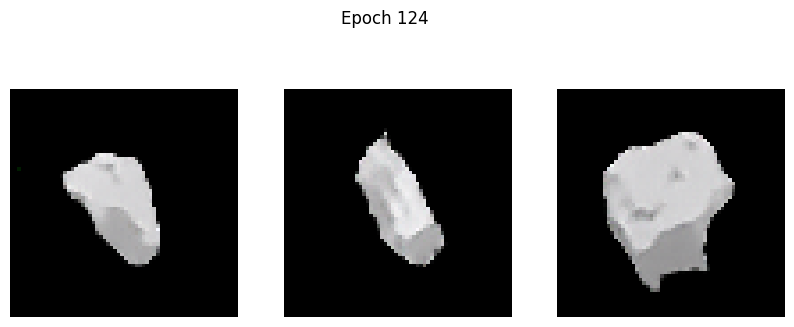

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1774 - g_loss: 2.7205
Epoch 125/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2432 - g_loss: 2.7870

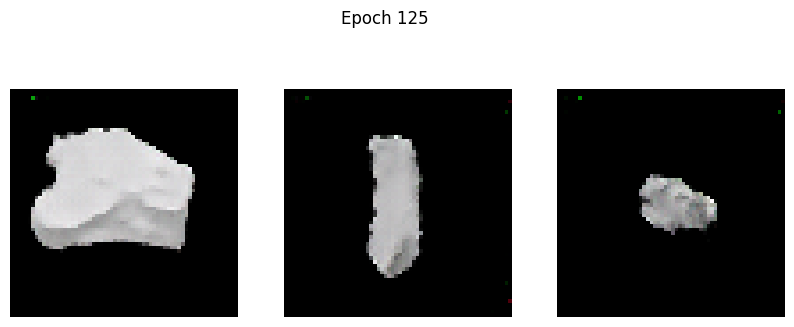

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2437 - g_loss: 2.7869
Epoch 126/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2025 - g_loss: 2.6884

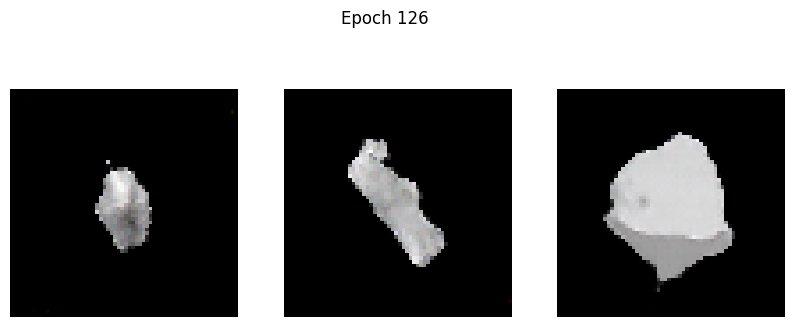

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2024 - g_loss: 2.6881
Epoch 127/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1632 - g_loss: 2.6286

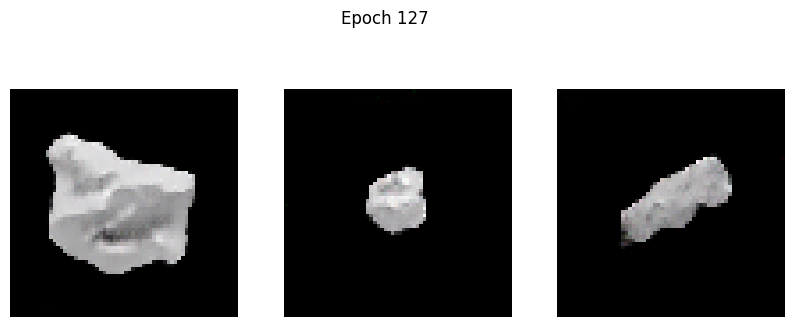

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1632 - g_loss: 2.6290
Epoch 128/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1820 - g_loss: 2.8592

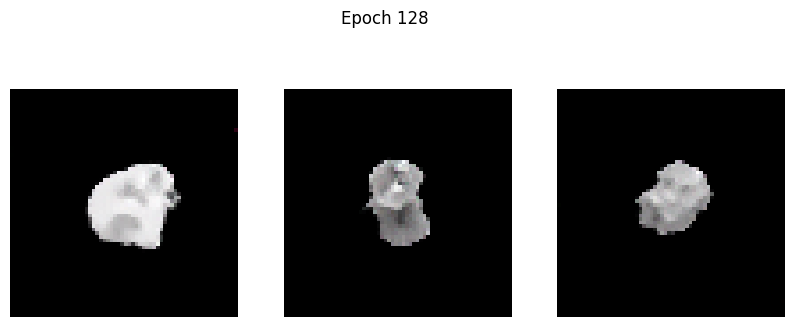

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1821 - g_loss: 2.8585
Epoch 129/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2089 - g_loss: 2.8463

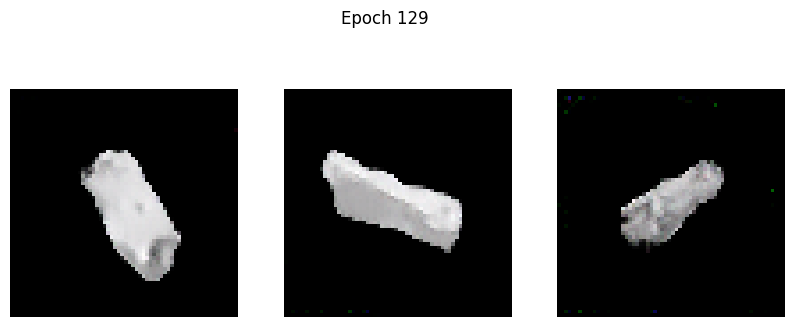

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2087 - g_loss: 2.8458
Epoch 130/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1718 - g_loss: 2.8382

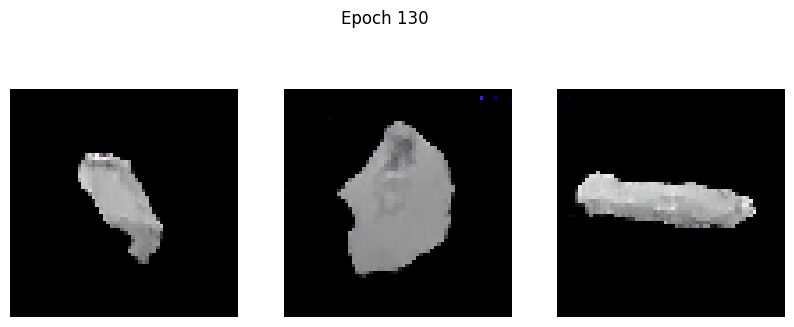

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1719 - g_loss: 2.8378
Epoch 131/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2796 - g_loss: 2.9657

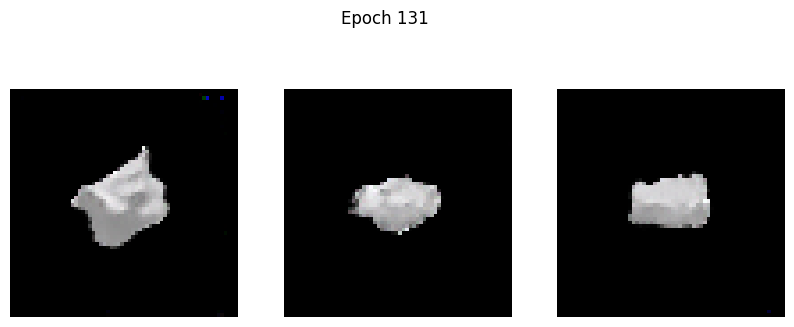

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2822 - g_loss: 2.9689
Epoch 132/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2223 - g_loss: 2.5044

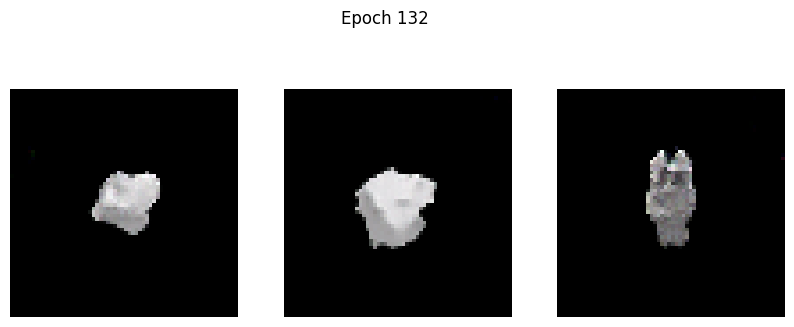

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2220 - g_loss: 2.5046
Epoch 133/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1621 - g_loss: 2.5785

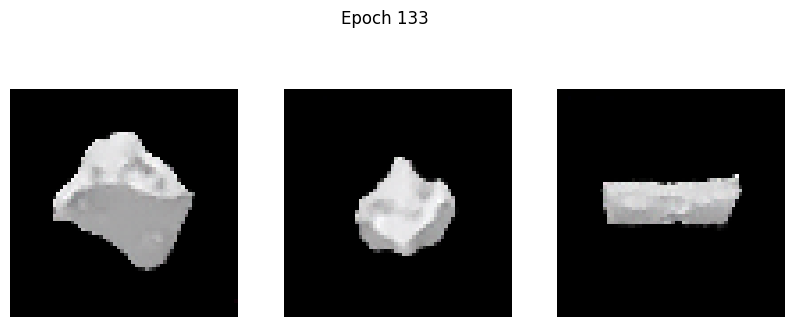

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1620 - g_loss: 2.5788
Epoch 134/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1557 - g_loss: 2.6746

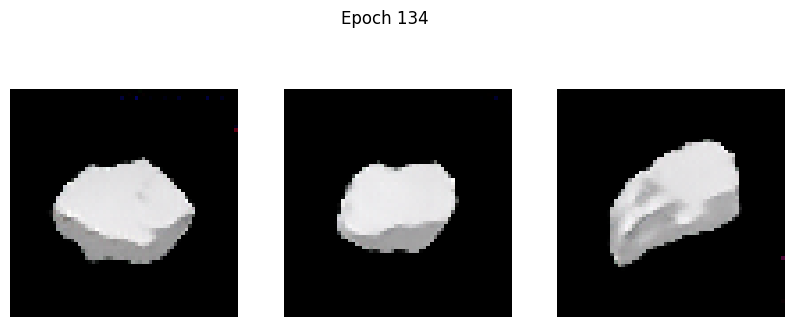

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1558 - g_loss: 2.6750
Epoch 135/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1695 - g_loss: 2.7697

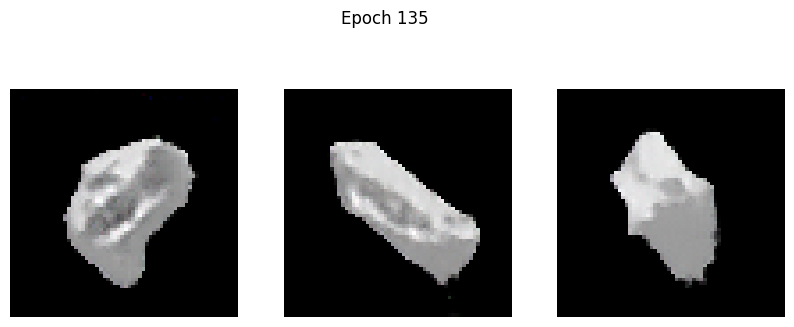

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1697 - g_loss: 2.7697
Epoch 136/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1696 - g_loss: 2.8269

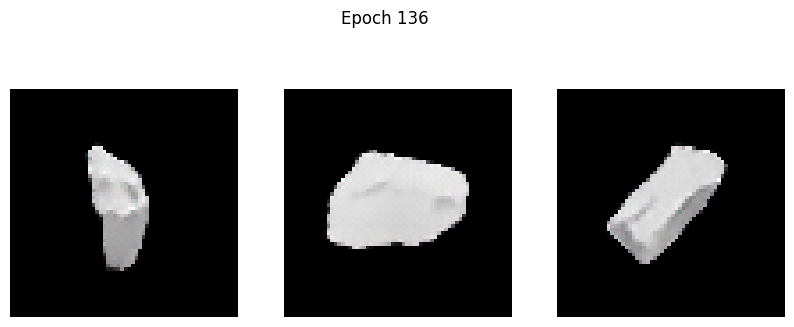

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1696 - g_loss: 2.8266
Epoch 137/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1798 - g_loss: 2.8620

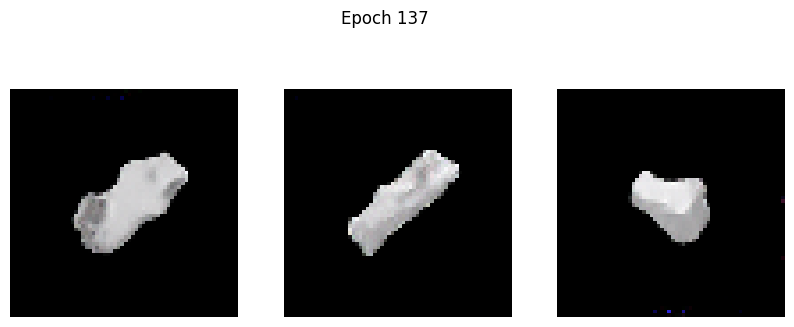

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1798 - g_loss: 2.8622
Epoch 138/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1732 - g_loss: 2.8594

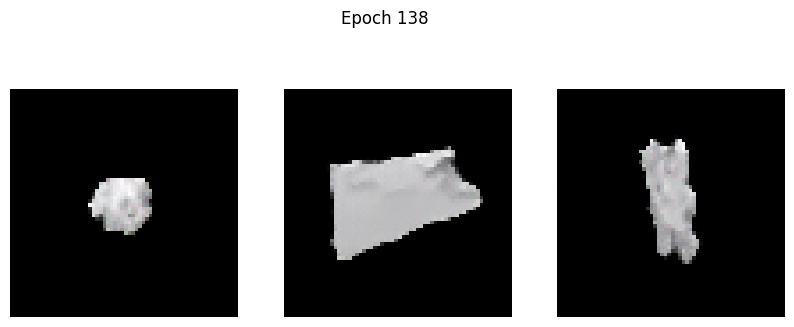

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1737 - g_loss: 2.8603
Epoch 139/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1838 - g_loss: 2.8334

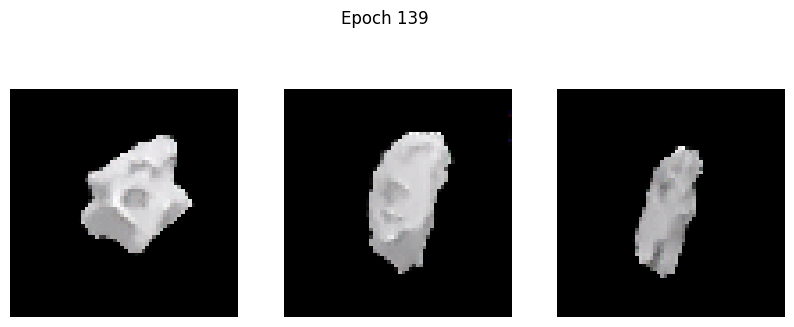

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1836 - g_loss: 2.8331
Epoch 140/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1658 - g_loss: 2.8684

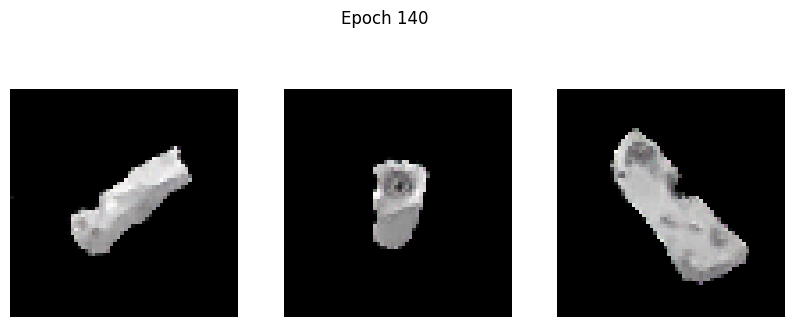

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1662 - g_loss: 2.8685
Epoch 141/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2163 - g_loss: 2.9907

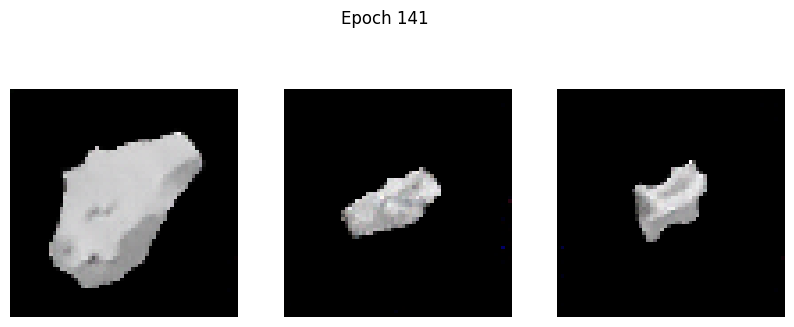

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2159 - g_loss: 2.9897
Epoch 142/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1775 - g_loss: 2.9162

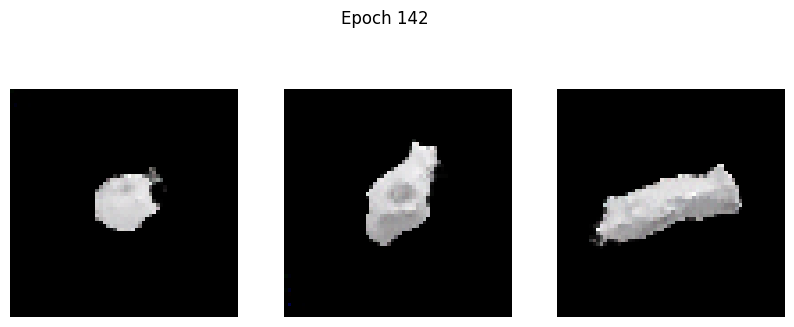

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.1774 - g_loss: 2.9160
Epoch 143/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1718 - g_loss: 2.9385

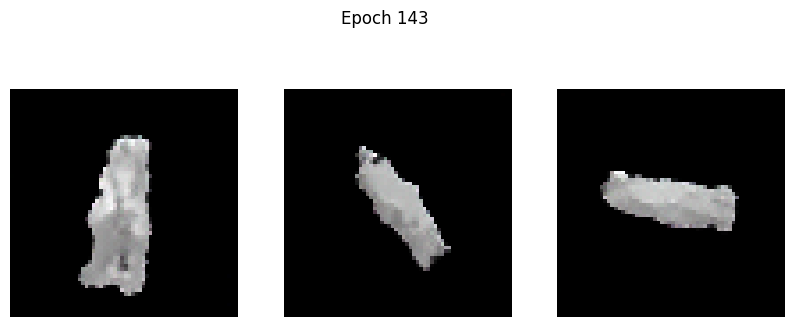

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1730 - g_loss: 2.9401
Epoch 144/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2211 - g_loss: 2.7707

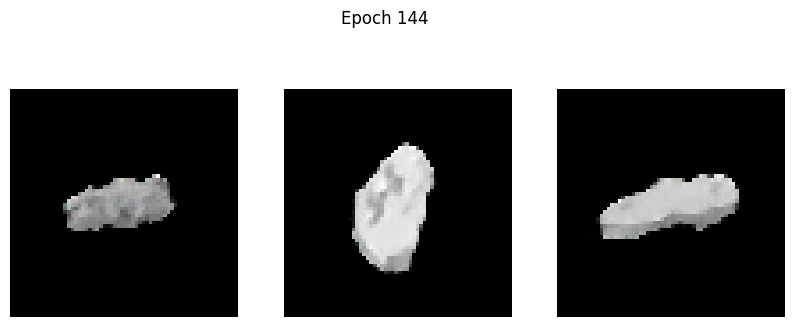

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2208 - g_loss: 2.7713
Epoch 145/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1478 - g_loss: 2.8783

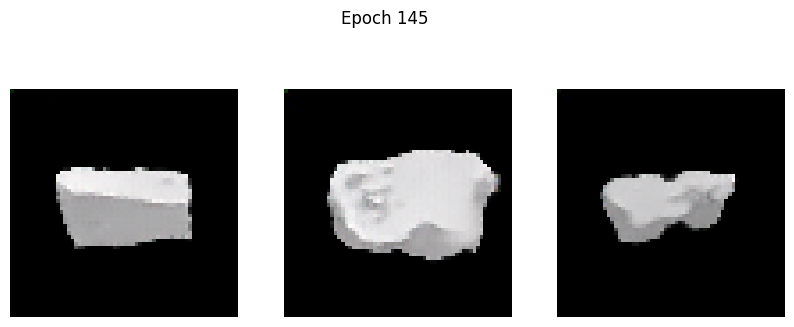

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1477 - g_loss: 2.8782
Epoch 146/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1532 - g_loss: 2.9697

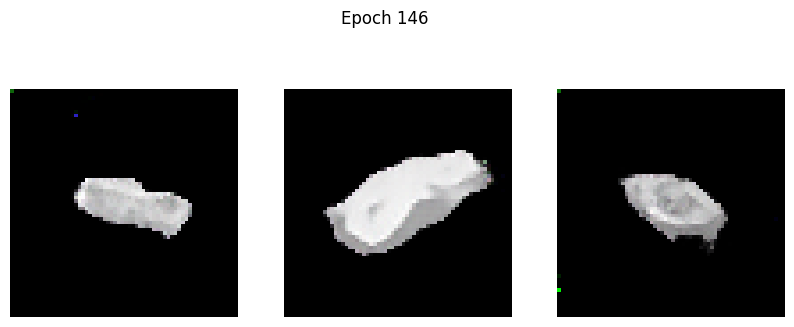

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1532 - g_loss: 2.9695
Epoch 147/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1468 - g_loss: 2.9453

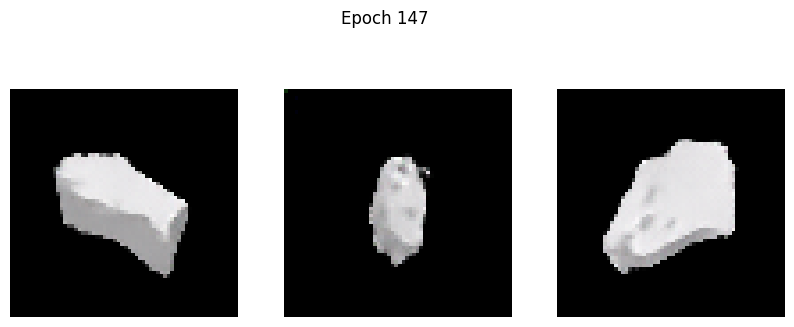

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1470 - g_loss: 2.9454
Epoch 148/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1462 - g_loss: 3.0143

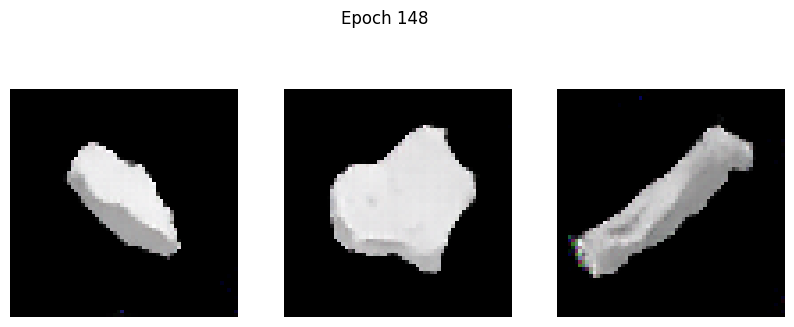

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1465 - g_loss: 3.0142
Epoch 149/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2836 - g_loss: 3.0785

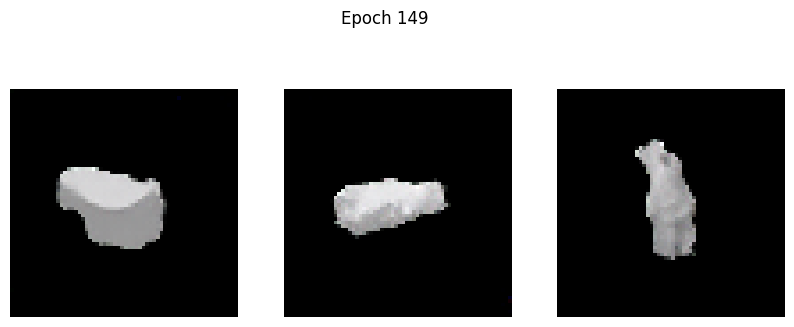

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2830 - g_loss: 3.0780
Epoch 150/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1603 - g_loss: 3.0210

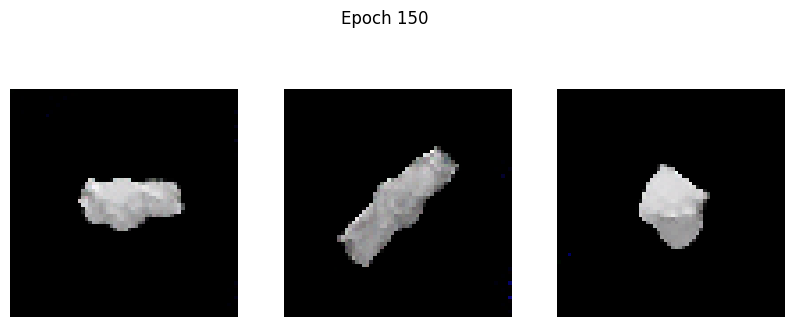

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1604 - g_loss: 3.0208
Epoch 151/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1487 - g_loss: 2.8909

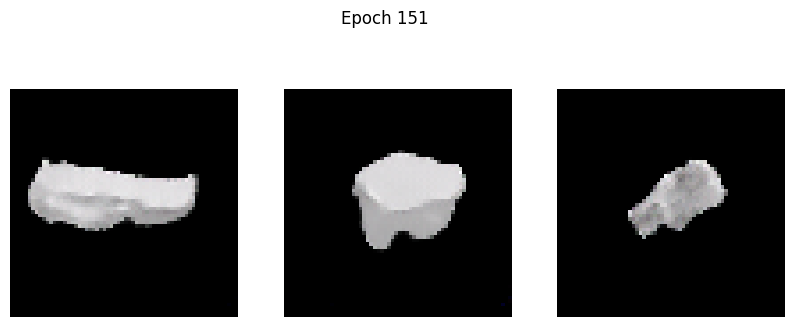

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1488 - g_loss: 2.8921
Epoch 152/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2594 - g_loss: 3.1633

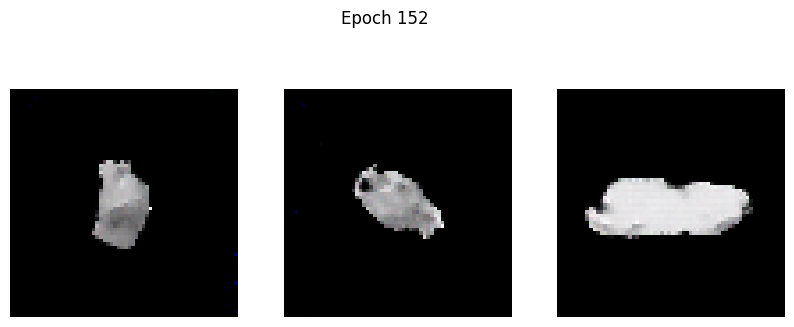

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2587 - g_loss: 3.1625
Epoch 153/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1773 - g_loss: 3.0193

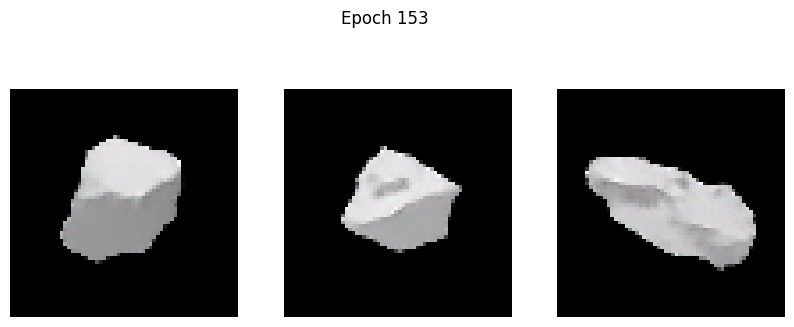

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1774 - g_loss: 3.0198
Epoch 154/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1465 - g_loss: 3.0166

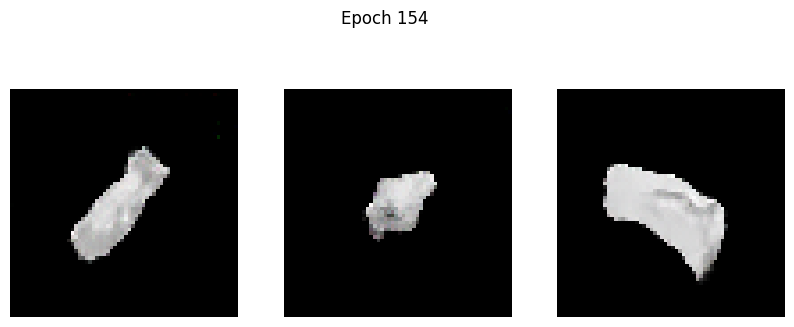

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1466 - g_loss: 3.0169
Epoch 155/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1331 - g_loss: 2.9711

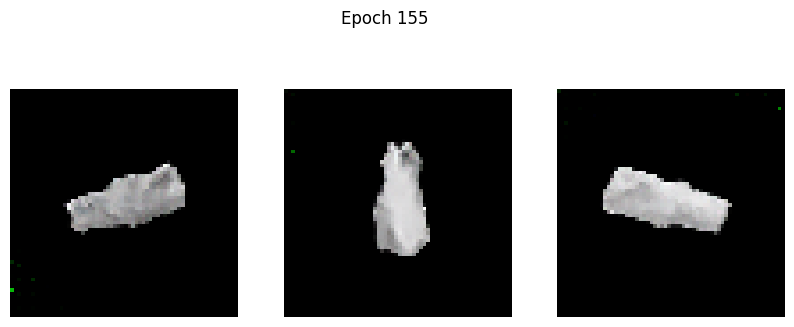

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1332 - g_loss: 2.9716
Epoch 156/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2076 - g_loss: 3.1022

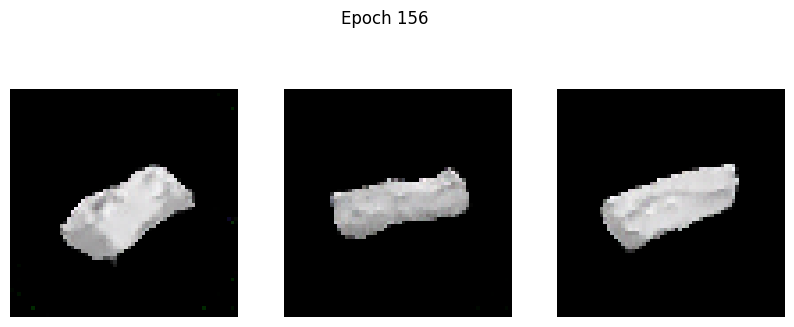

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2080 - g_loss: 3.1027
Epoch 157/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1453 - g_loss: 3.0673

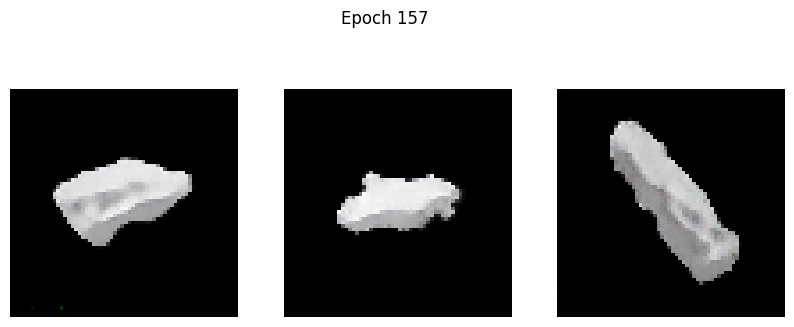

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1453 - g_loss: 3.0669
Epoch 158/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1495 - g_loss: 3.1243

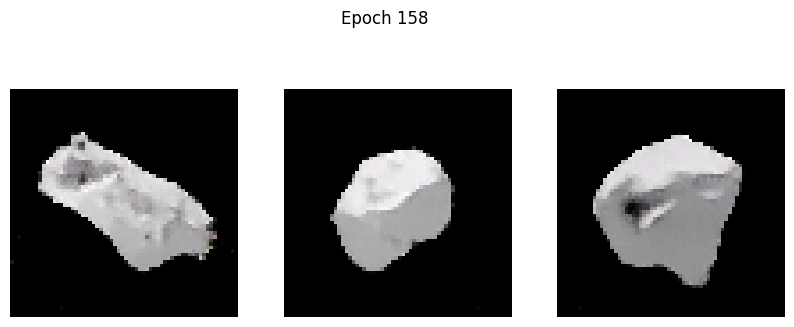

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1494 - g_loss: 3.1240
Epoch 159/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2081 - g_loss: 3.2557

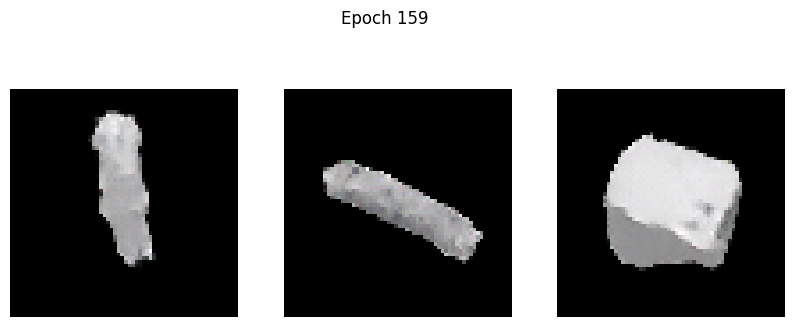

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2085 - g_loss: 3.2556
Epoch 160/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1534 - g_loss: 3.0189

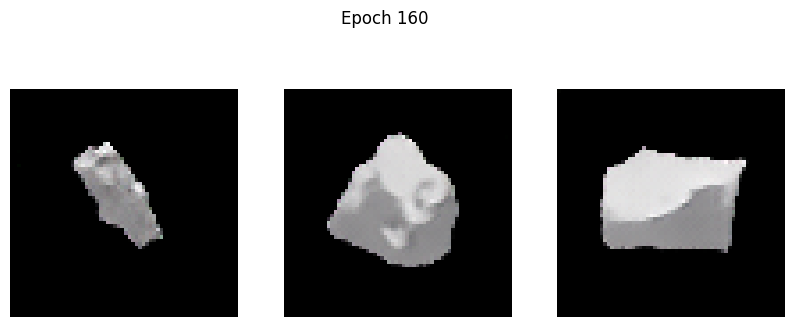

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1535 - g_loss: 3.0193
Epoch 161/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.1736 - g_loss: 3.0990

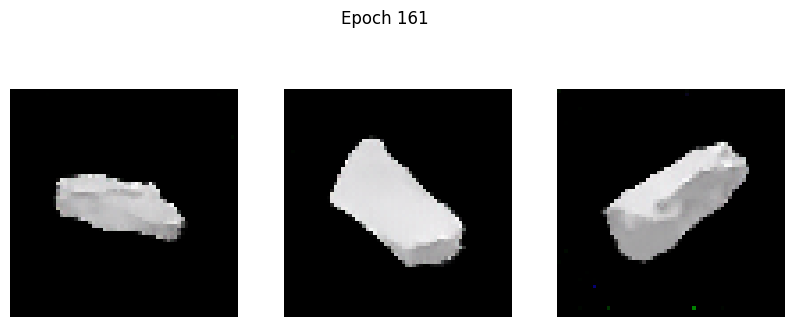

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.1734 - g_loss: 3.0989
Epoch 162/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.1813 - g_loss: 3.2447

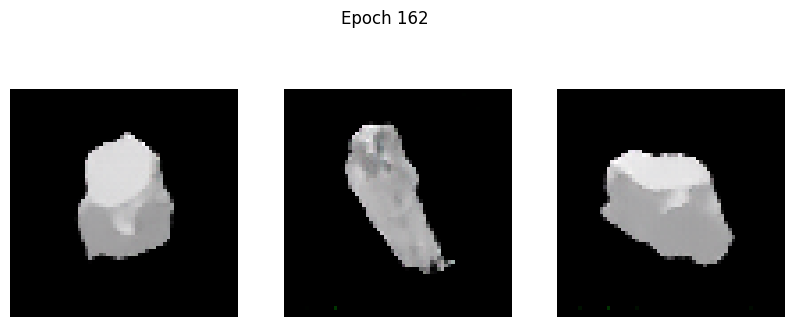

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.1811 - g_loss: 3.2437
Epoch 163/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2310 - g_loss: 3.3612

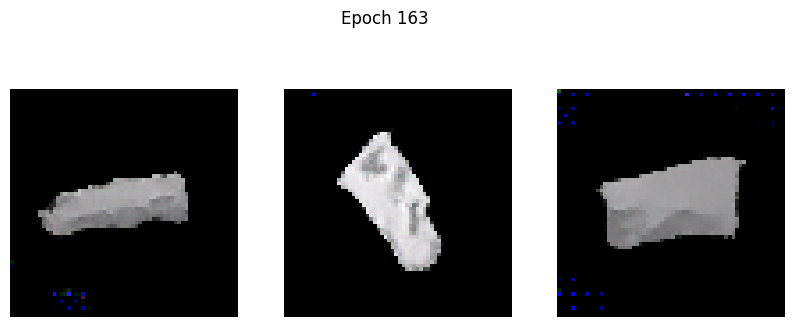

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2315 - g_loss: 3.3614
Epoch 164/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1397 - g_loss: 3.0028

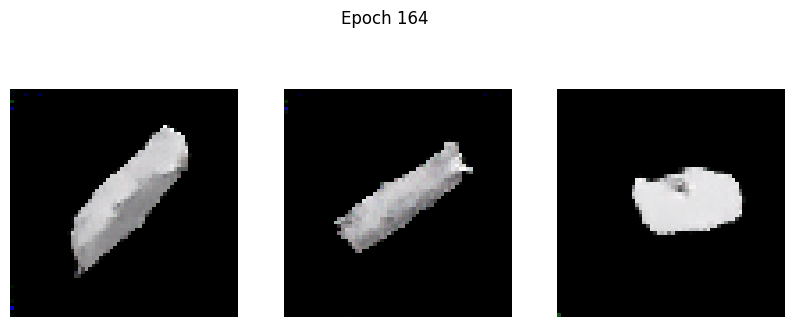

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1397 - g_loss: 3.0030
Epoch 165/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1433 - g_loss: 3.2459

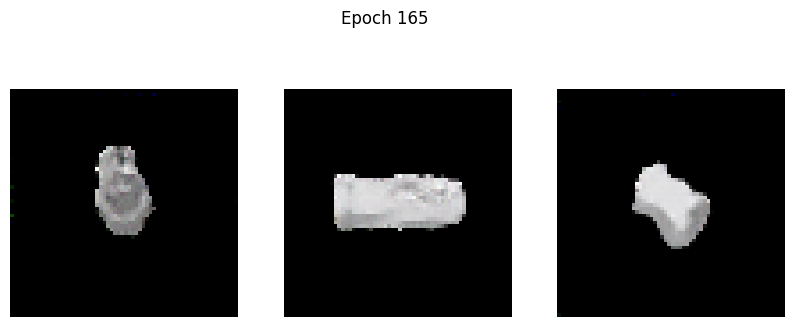

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1434 - g_loss: 3.2454
Epoch 166/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1402 - g_loss: 3.1848

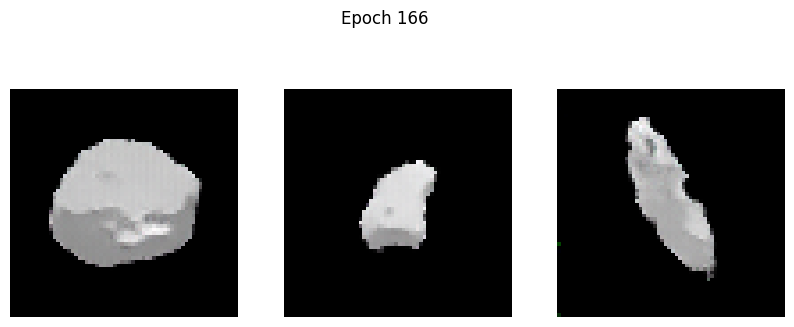

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1404 - g_loss: 3.1851
Epoch 167/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1691 - g_loss: 3.2818

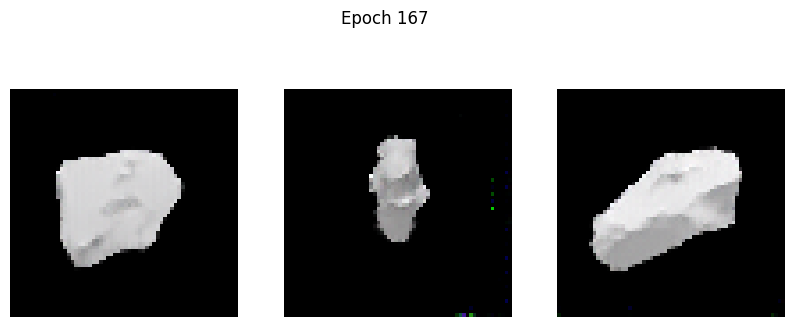

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1689 - g_loss: 3.2811
Epoch 168/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1448 - g_loss: 3.2482

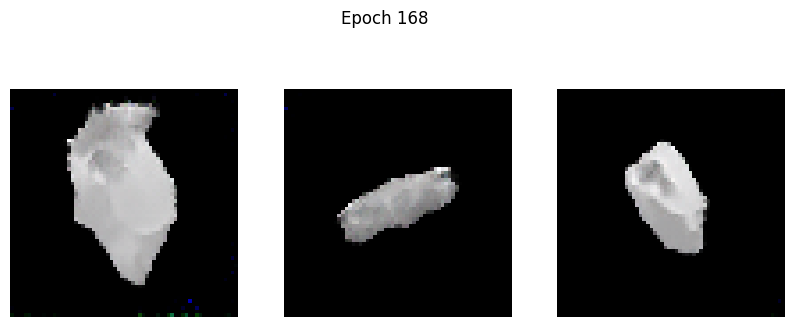

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1449 - g_loss: 3.2481
Epoch 169/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2714 - g_loss: 3.4135

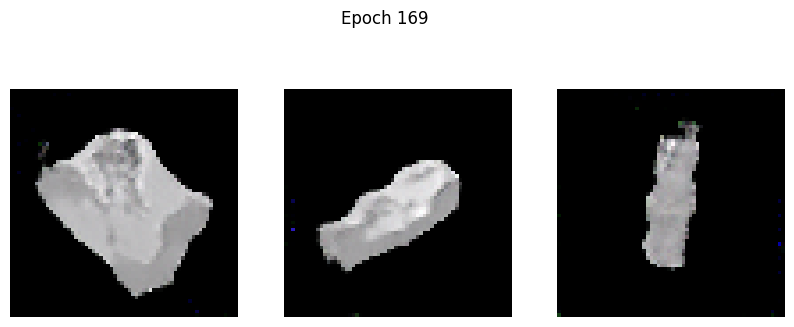

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2713 - g_loss: 3.4133
Epoch 170/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1324 - g_loss: 3.0397

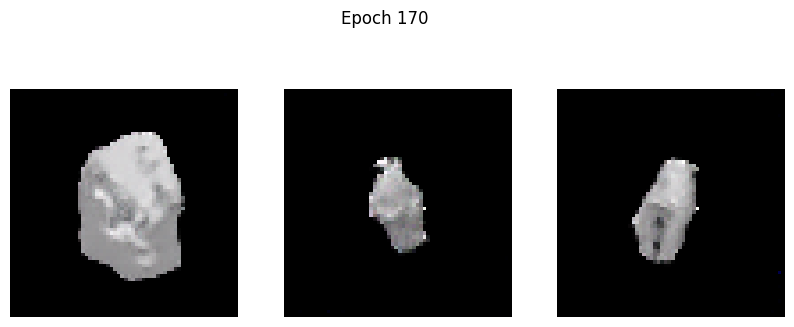

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1323 - g_loss: 3.0399
Epoch 171/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1254 - g_loss: 3.2272

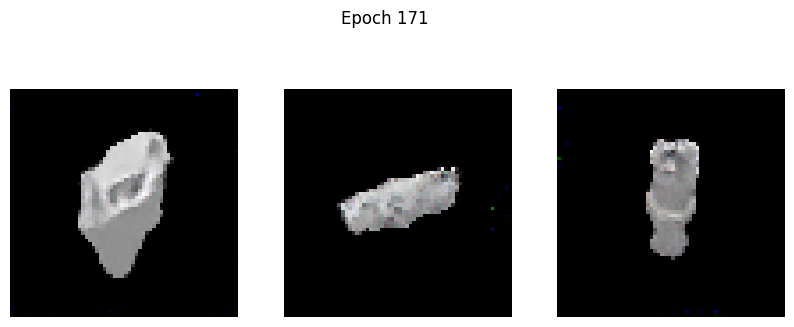

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - d_loss: 0.1254 - g_loss: 3.2271
Epoch 172/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.1381 - g_loss: 3.2747

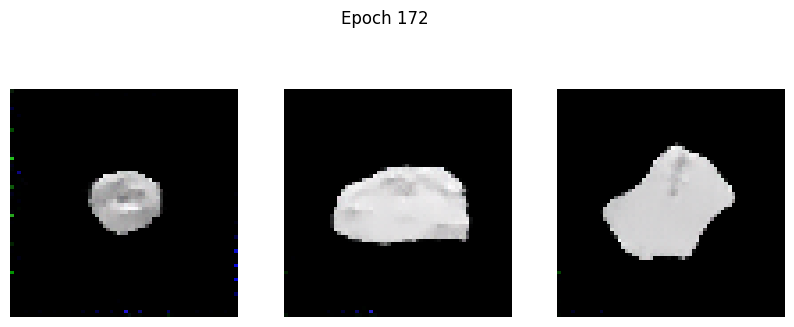

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - d_loss: 0.1387 - g_loss: 3.2751
Epoch 173/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.1371 - g_loss: 3.2100

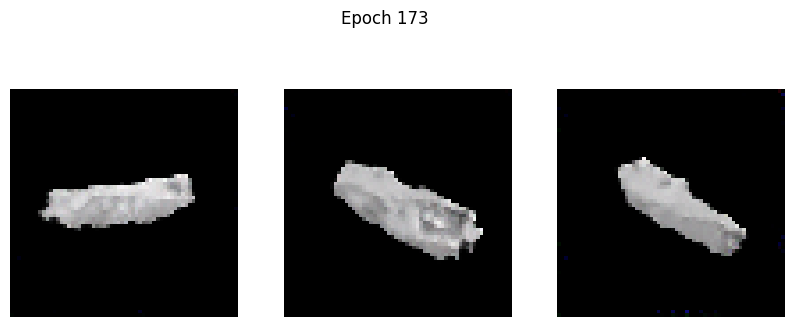

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1373 - g_loss: 3.2101
Epoch 174/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.1251 - g_loss: 3.3041

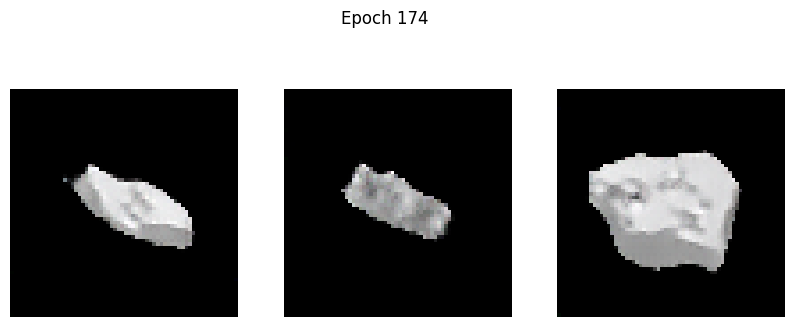

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.1252 - g_loss: 3.3040
Epoch 175/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1583 - g_loss: 3.4807

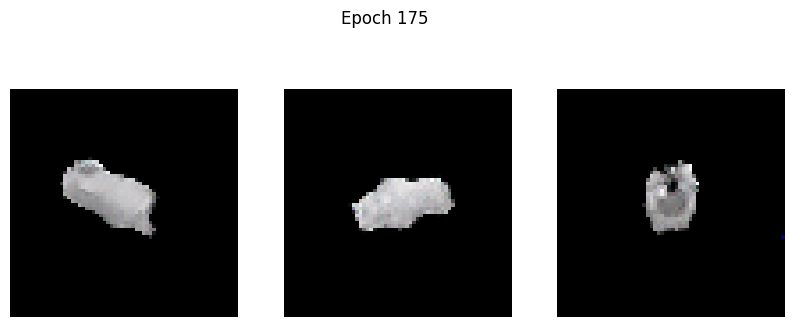

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1580 - g_loss: 3.4796
Epoch 176/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3694 - g_loss: 3.6659

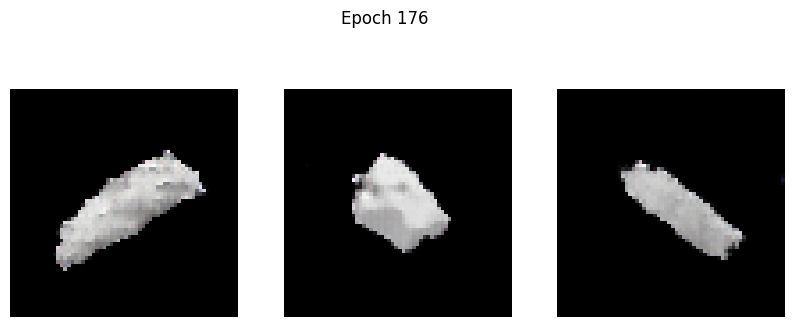

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3736 - g_loss: 3.6721
Epoch 177/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2328 - g_loss: 2.7556

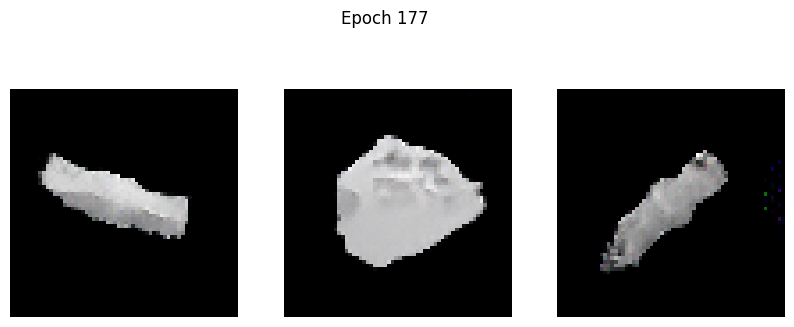

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2325 - g_loss: 2.7565
Epoch 178/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1452 - g_loss: 2.9580

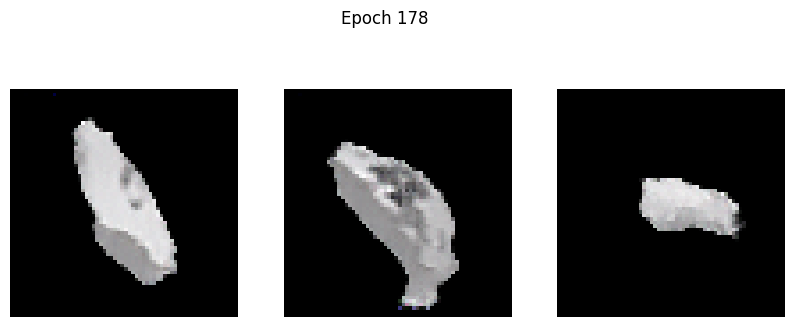

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1452 - g_loss: 2.9585
Epoch 179/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.1380 - g_loss: 3.0407

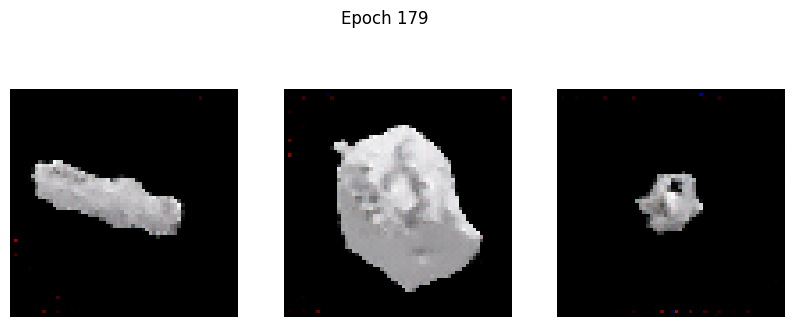

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.1380 - g_loss: 3.0409
Epoch 180/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.1348 - g_loss: 3.0362

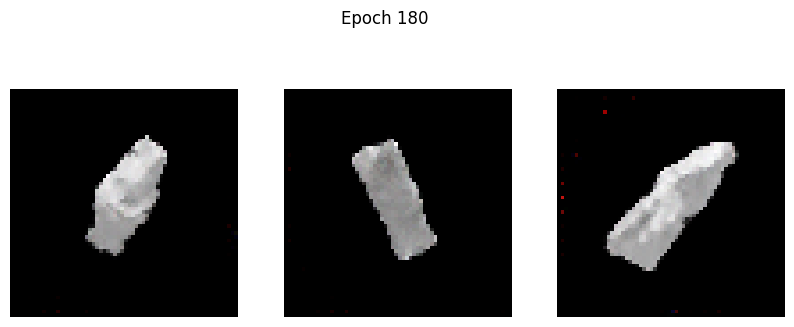

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1348 - g_loss: 3.0369
Epoch 181/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1251 - g_loss: 3.1070

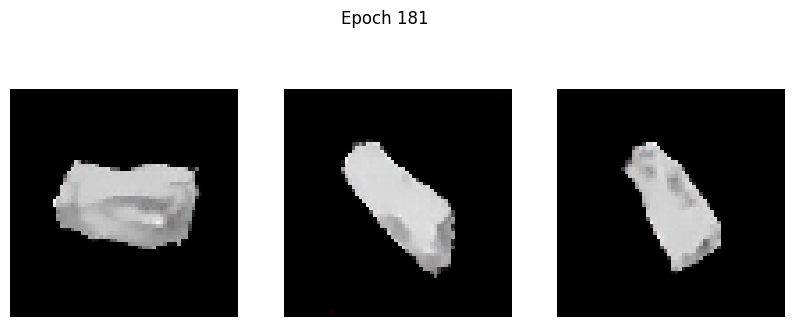

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1252 - g_loss: 3.1071
Epoch 182/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1282 - g_loss: 3.1839

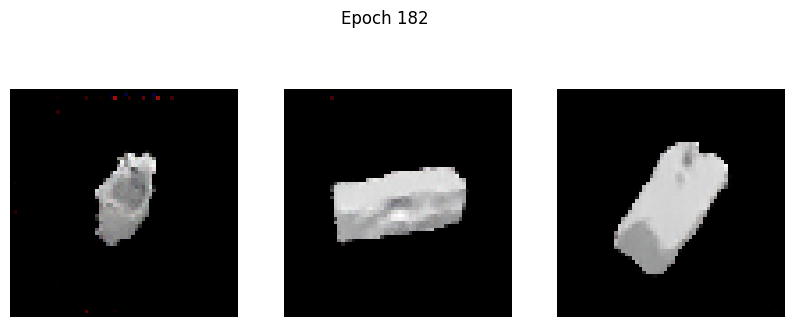

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1281 - g_loss: 3.1838
Epoch 183/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1286 - g_loss: 3.2486

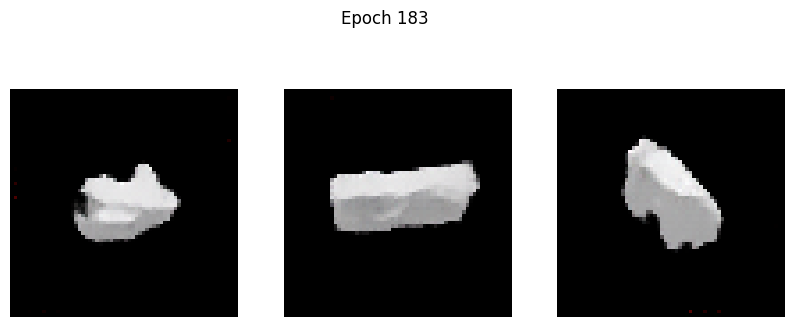

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1286 - g_loss: 3.2488
Epoch 184/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1282 - g_loss: 3.2655

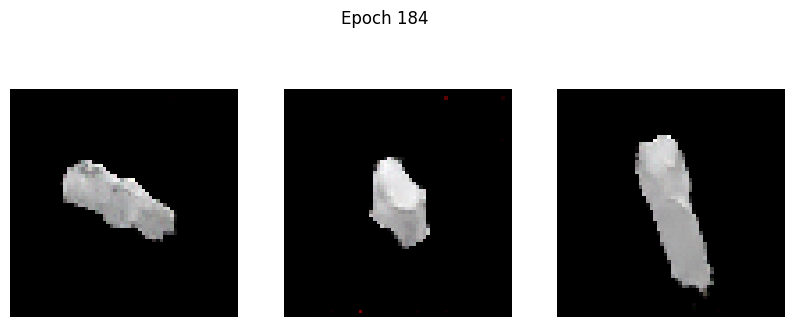

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1282 - g_loss: 3.2653
Epoch 185/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1592 - g_loss: 3.2281

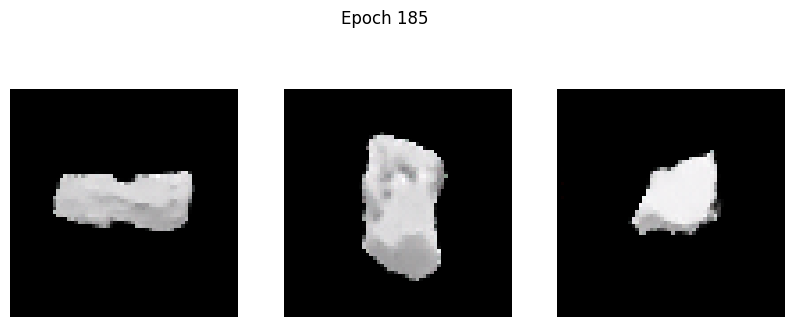

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1591 - g_loss: 3.2284
Epoch 186/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1225 - g_loss: 3.3961

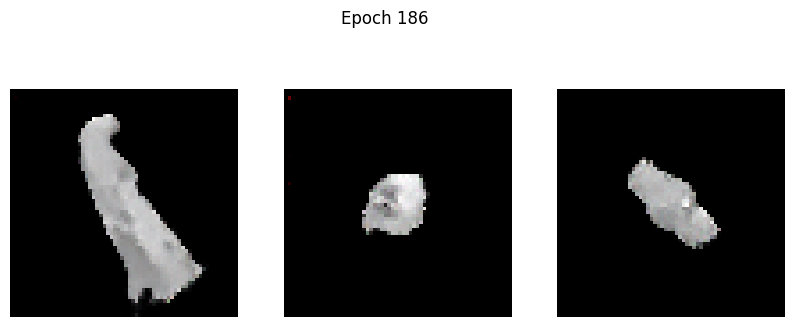

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1226 - g_loss: 3.3955
Epoch 187/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1392 - g_loss: 3.3685

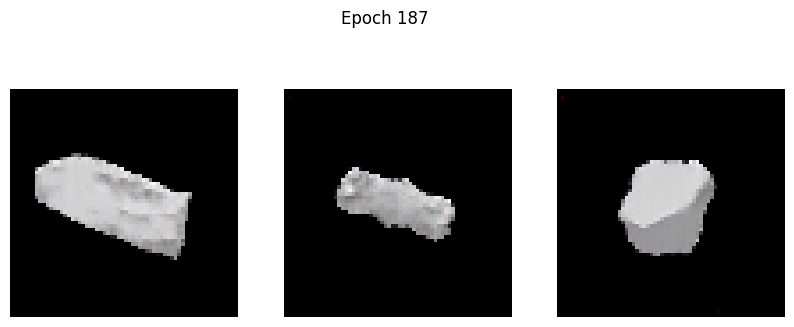

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1393 - g_loss: 3.3689
Epoch 188/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1260 - g_loss: 3.3559

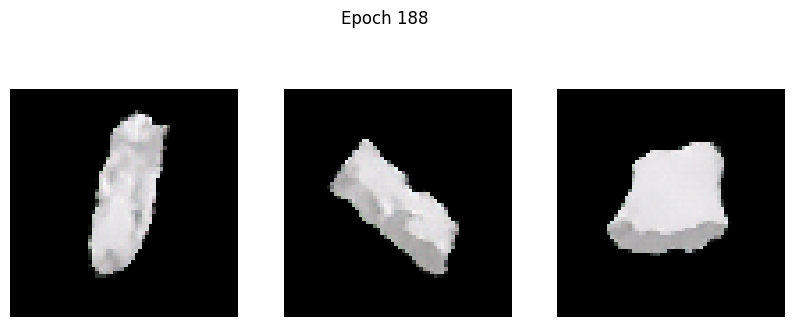

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1266 - g_loss: 3.3572
Epoch 189/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1514 - g_loss: 3.3869

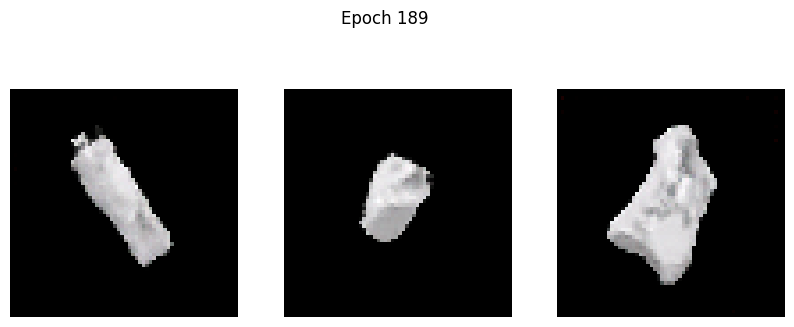

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1512 - g_loss: 3.3864
Epoch 190/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1993 - g_loss: 3.5048

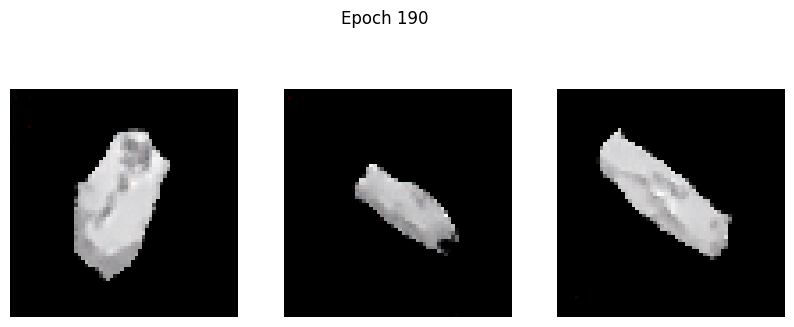

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1991 - g_loss: 3.5039
Epoch 191/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1061 - g_loss: 3.3146

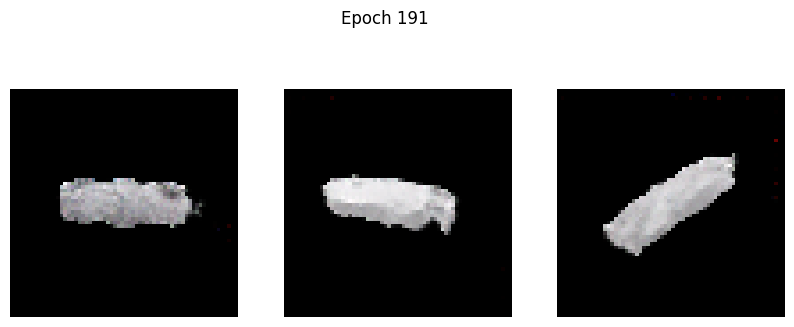

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1062 - g_loss: 3.3151
Epoch 192/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1306 - g_loss: 3.5165

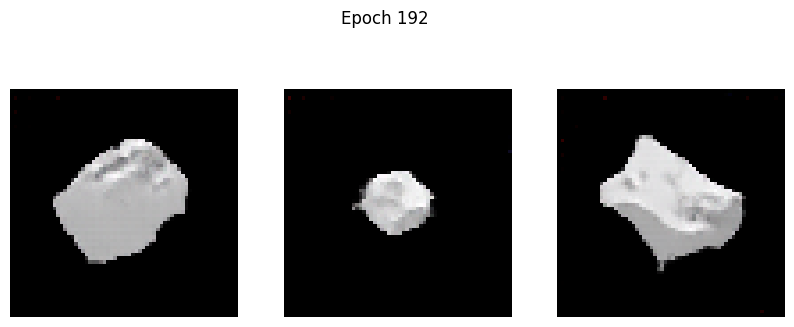

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1307 - g_loss: 3.5157
Epoch 193/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1195 - g_loss: 3.4254

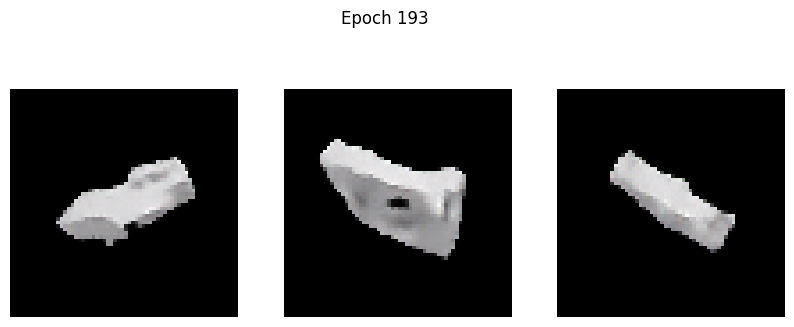

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1195 - g_loss: 3.4254
Epoch 194/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1053 - g_loss: 3.4726

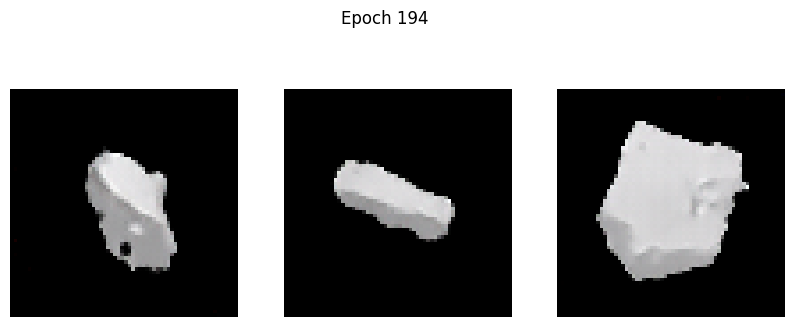

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1055 - g_loss: 3.4725
Epoch 195/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1261 - g_loss: 3.4359

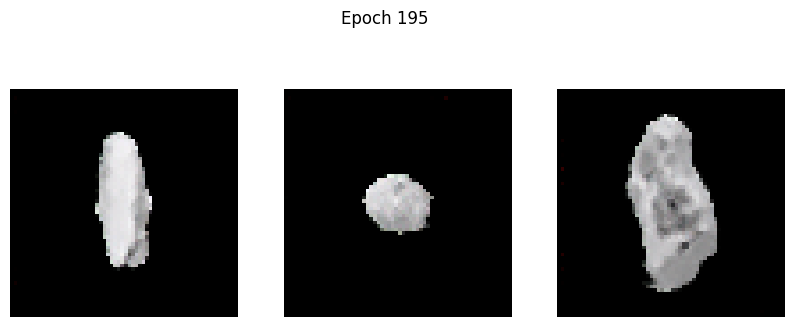

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1263 - g_loss: 3.4365
Epoch 196/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1769 - g_loss: 3.5638

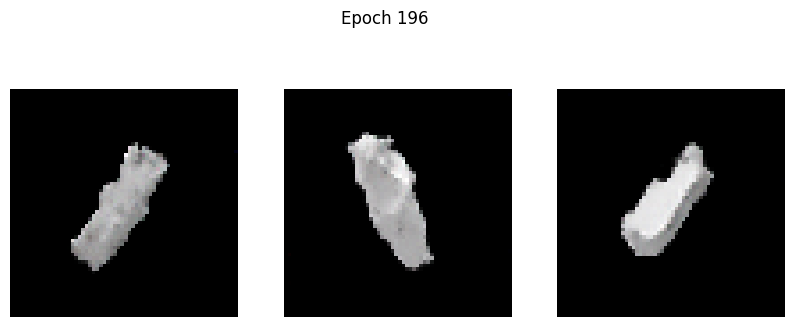

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1767 - g_loss: 3.5639
Epoch 197/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0981 - g_loss: 3.4345

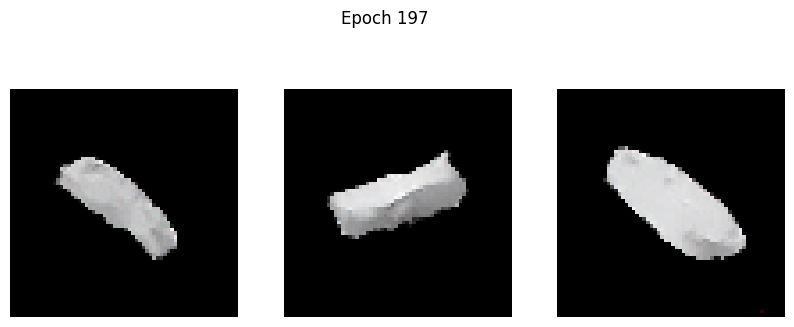

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0981 - g_loss: 3.4346
Epoch 198/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1242 - g_loss: 3.4323

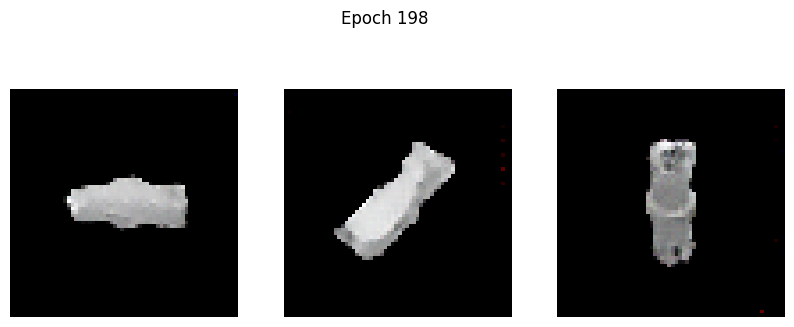

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1243 - g_loss: 3.4329
Epoch 199/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1327 - g_loss: 3.5108

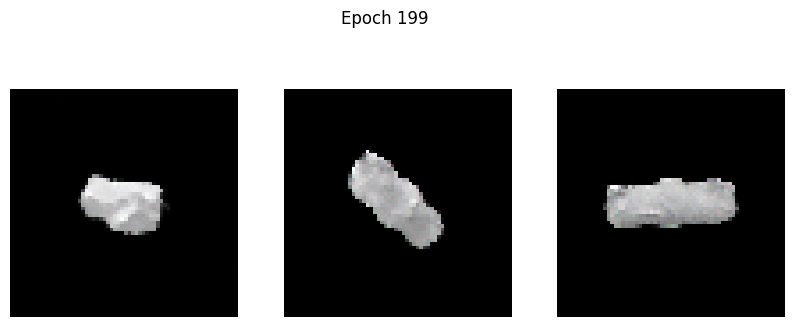

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1326 - g_loss: 3.5111
Epoch 200/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2190 - g_loss: 3.6825

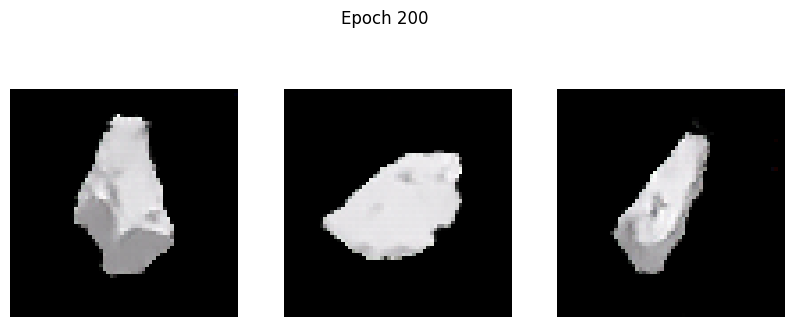

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2189 - g_loss: 3.6822
Epoch 201/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1349 - g_loss: 3.6211

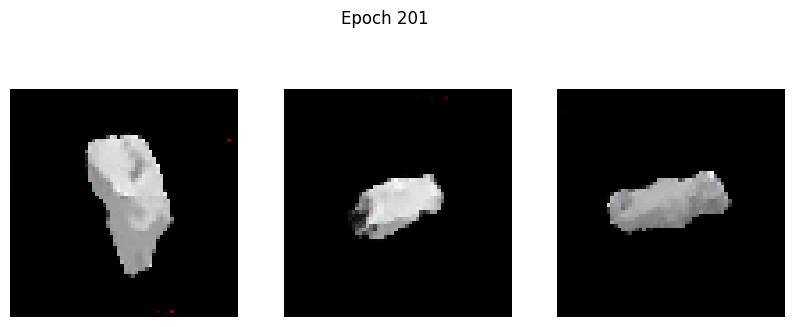

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1348 - g_loss: 3.6202
Epoch 202/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1128 - g_loss: 3.5818

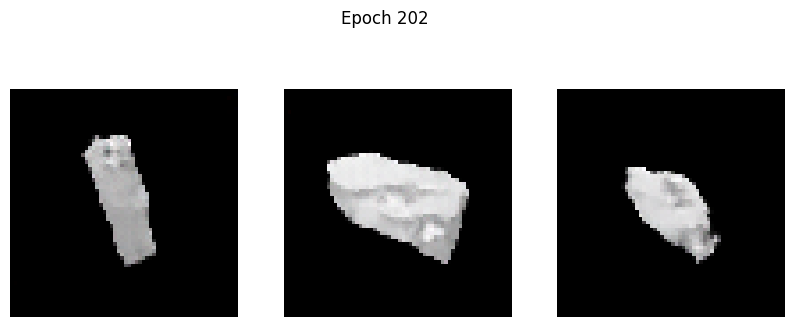

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1129 - g_loss: 3.5819
Epoch 203/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1010 - g_loss: 3.5290

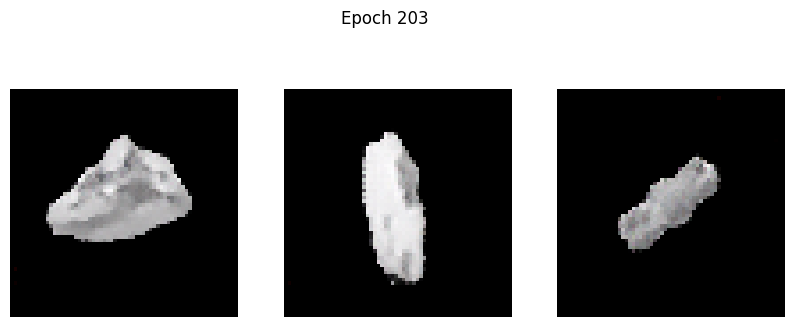

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1011 - g_loss: 3.5292
Epoch 204/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1445 - g_loss: 3.6319

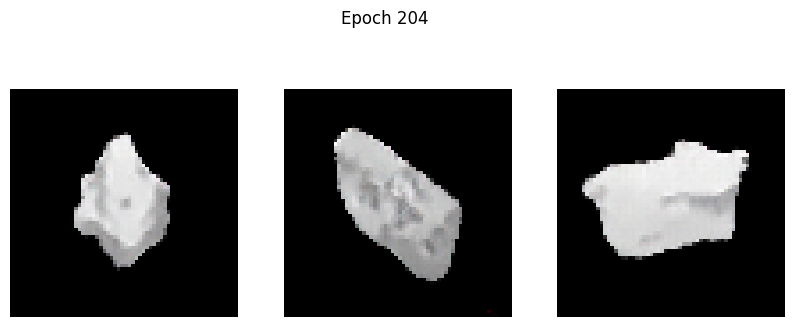

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1449 - g_loss: 3.6322
Epoch 205/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1580 - g_loss: 3.6223

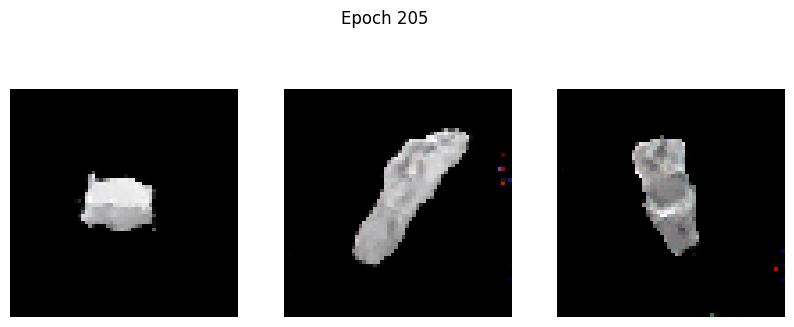

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1577 - g_loss: 3.6218
Epoch 206/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1279 - g_loss: 3.7241

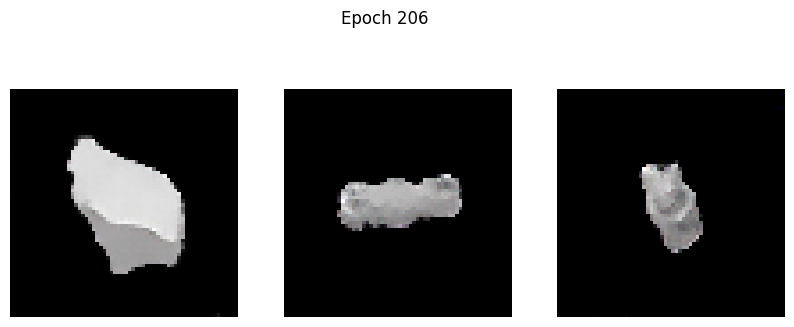

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.1289 - g_loss: 3.7255
Epoch 207/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.1103 - g_loss: 3.5057

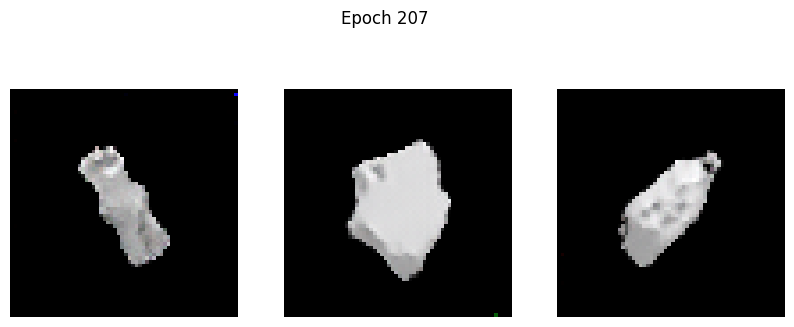

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.1102 - g_loss: 3.5056
Epoch 208/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.1211 - g_loss: 3.5936

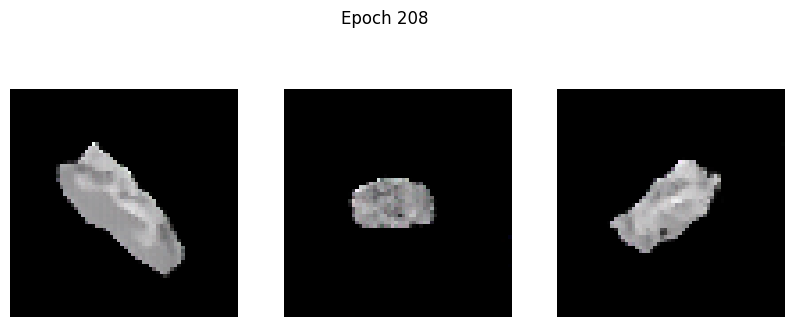

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: 0.1217 - g_loss: 3.5945
Epoch 209/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.3668 - g_loss: 3.7352

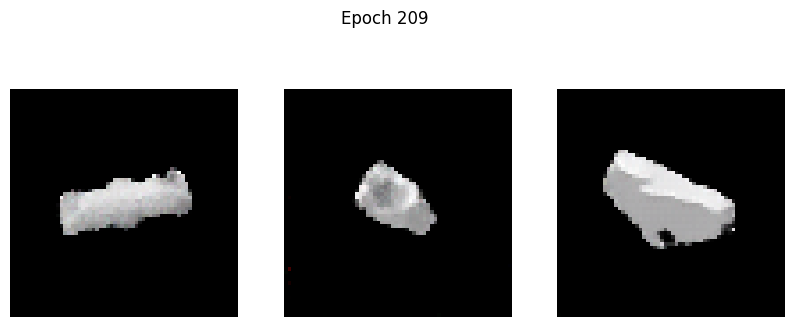

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.3651 - g_loss: 3.7327
Epoch 210/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0980 - g_loss: 3.5511

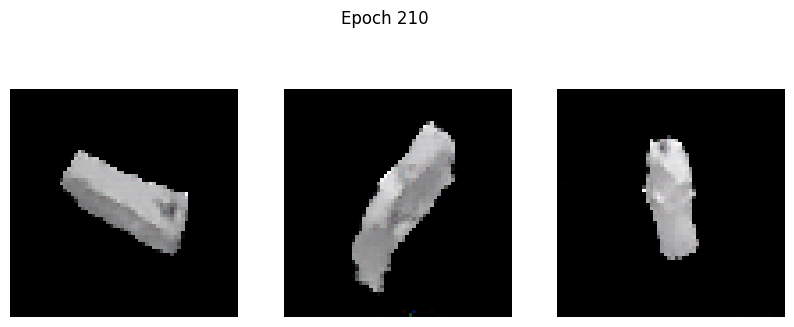

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.0980 - g_loss: 3.5504
Epoch 211/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0959 - g_loss: 3.5377

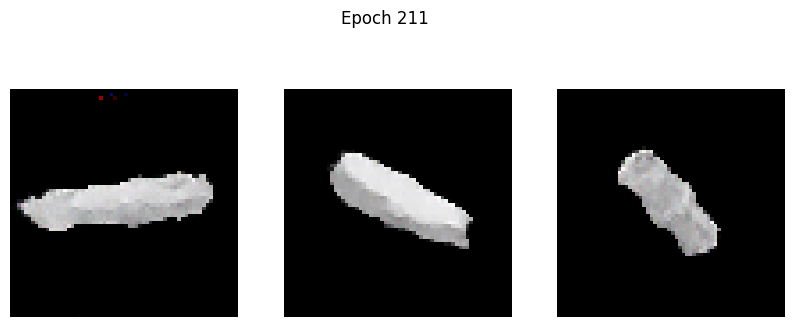

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0960 - g_loss: 3.5378
Epoch 212/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1139 - g_loss: 3.7392

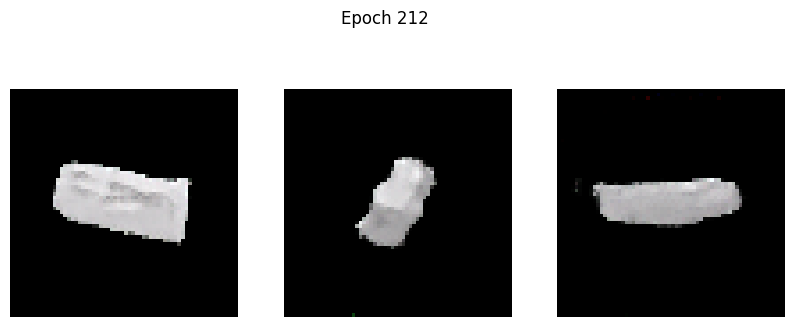

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.1140 - g_loss: 3.7386
Epoch 213/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1014 - g_loss: 3.5678

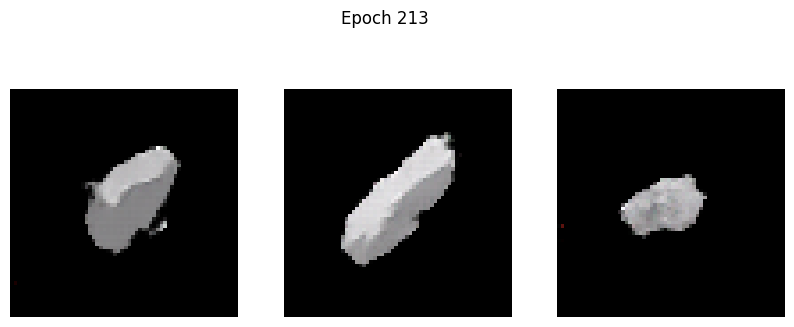

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1014 - g_loss: 3.5680
Epoch 214/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1029 - g_loss: 3.6189

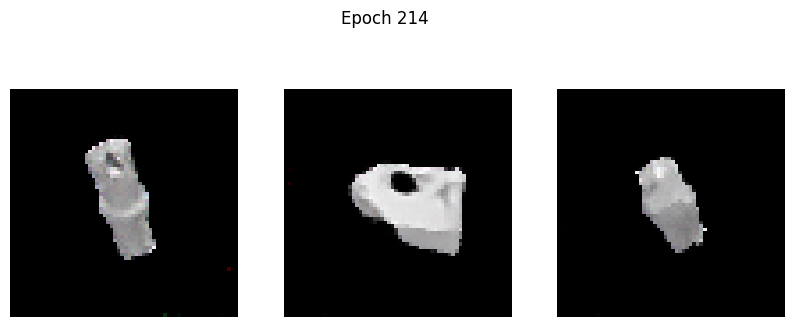

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1034 - g_loss: 3.6202
Epoch 215/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1165 - g_loss: 3.6554

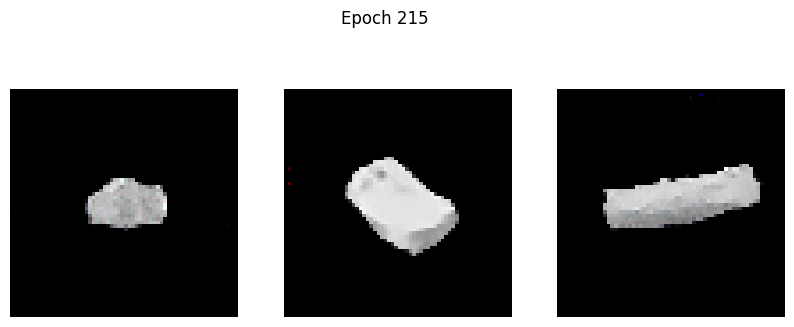

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1166 - g_loss: 3.6555
Epoch 216/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1175 - g_loss: 3.7470

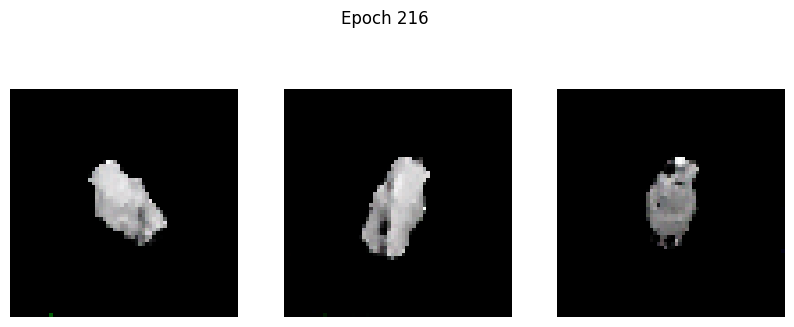

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1177 - g_loss: 3.7465
Epoch 217/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1018 - g_loss: 3.7195

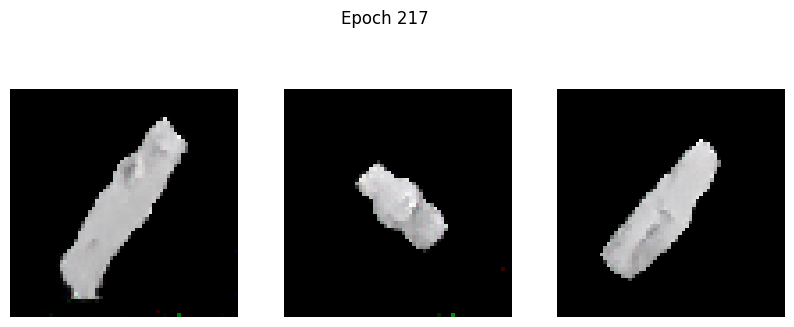

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1018 - g_loss: 3.7190
Epoch 218/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0985 - g_loss: 3.7432

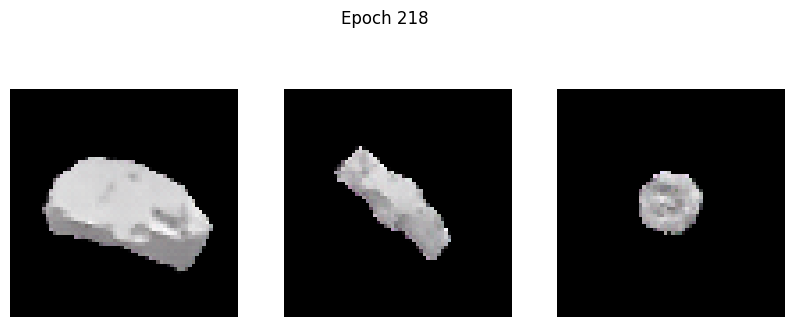

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0987 - g_loss: 3.7439
Epoch 219/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2426 - g_loss: 3.8502

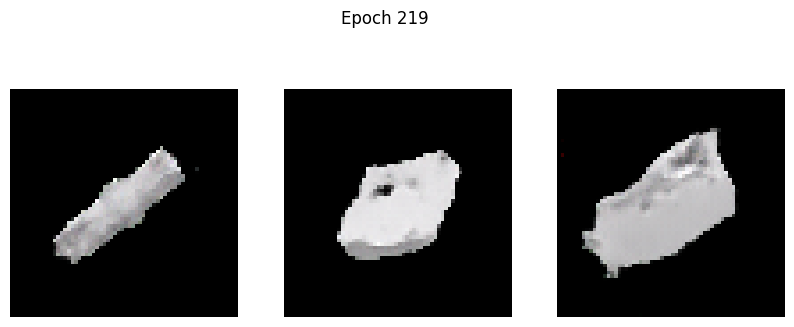

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2420 - g_loss: 3.8488
Epoch 220/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1599 - g_loss: 3.6697

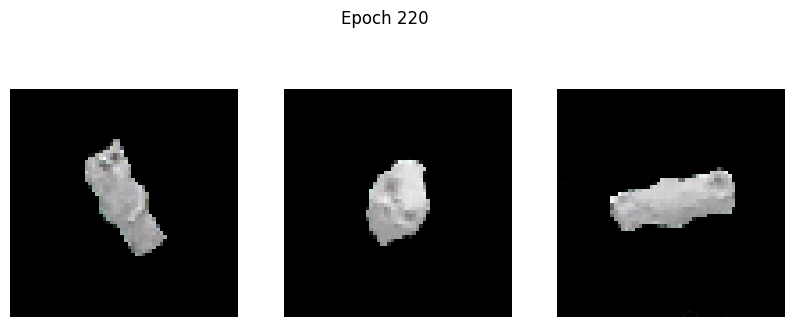

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1597 - g_loss: 3.6700
Epoch 221/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1246 - g_loss: 3.6890

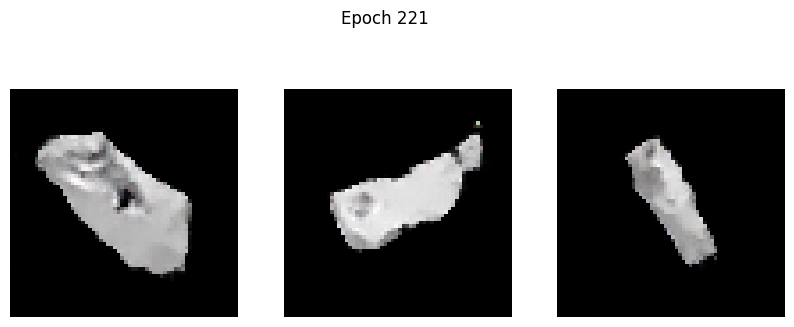

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1252 - g_loss: 3.6901
Epoch 222/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1177 - g_loss: 3.7918

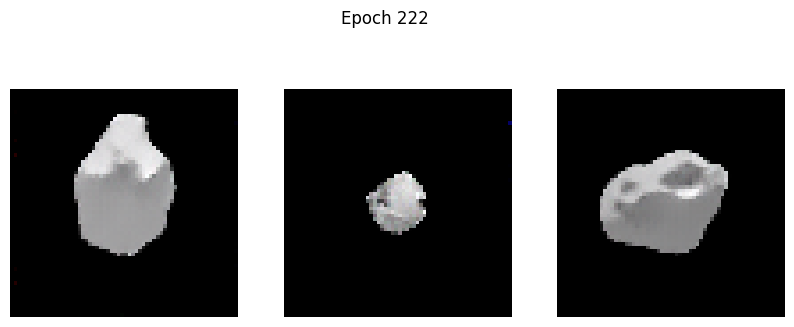

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1175 - g_loss: 3.7909
Epoch 223/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1017 - g_loss: 3.6952

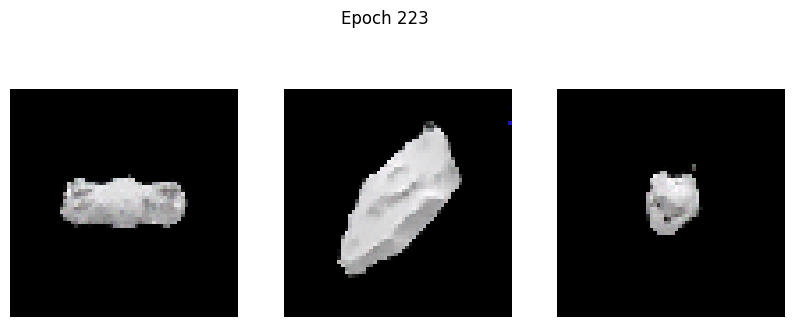

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1017 - g_loss: 3.6953
Epoch 224/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1425 - g_loss: 3.7902

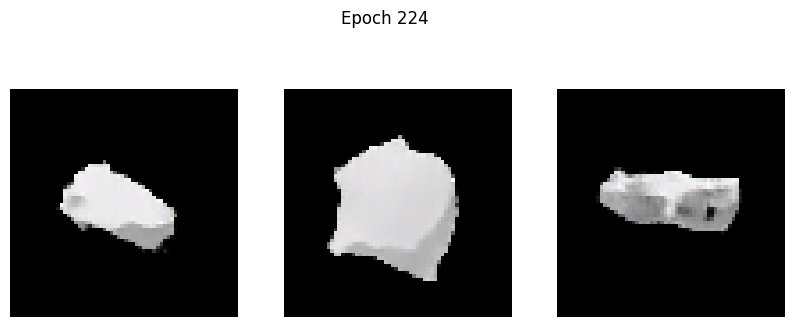

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1431 - g_loss: 3.7914
Epoch 225/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0902 - g_loss: 3.6452

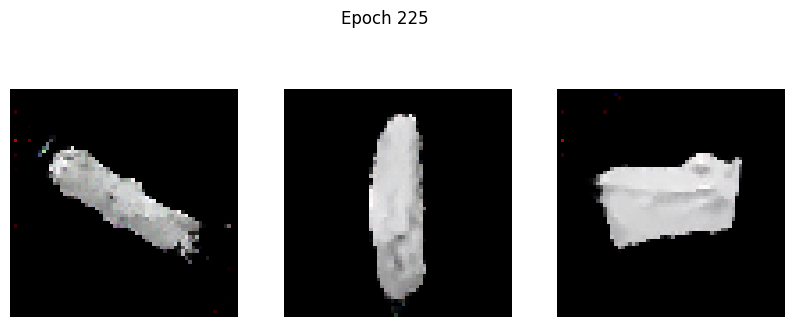

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0903 - g_loss: 3.6460
Epoch 226/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1030 - g_loss: 3.7896

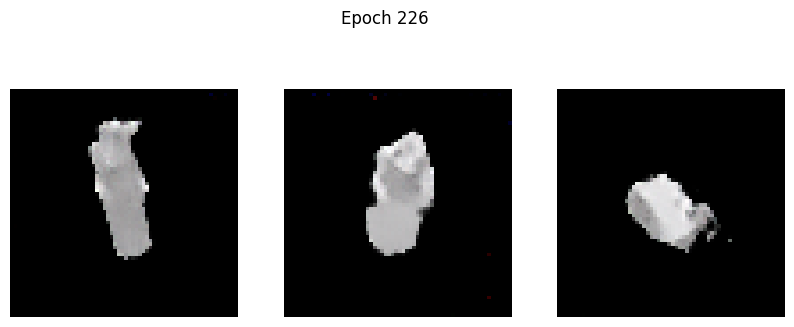

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1030 - g_loss: 3.7898
Epoch 227/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.7217 - g_loss: 4.3724

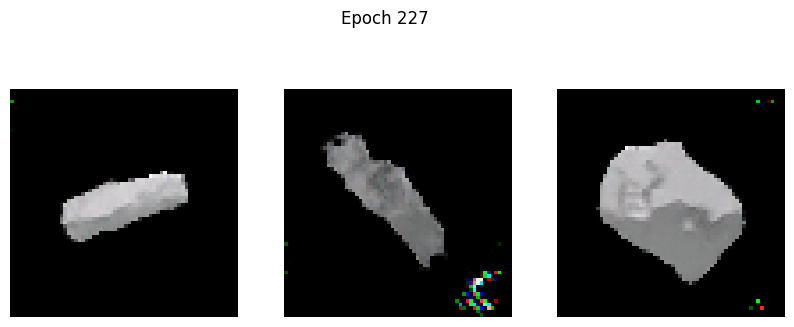

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.7186 - g_loss: 4.3679
Epoch 228/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1036 - g_loss: 3.5936

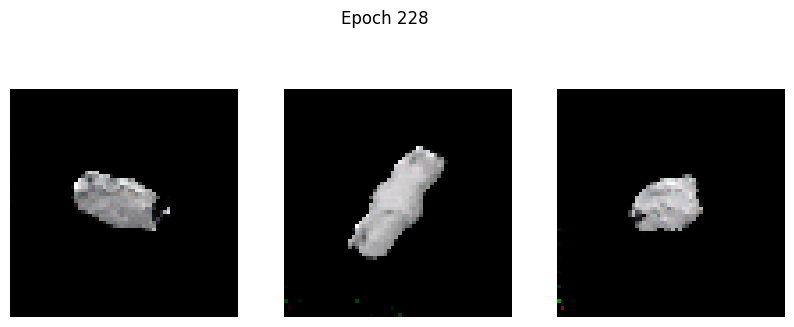

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1036 - g_loss: 3.5937
Epoch 229/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0844 - g_loss: 3.6635

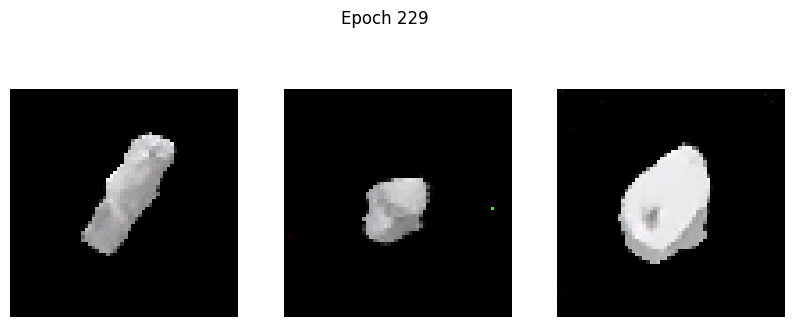

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0844 - g_loss: 3.6633
Epoch 230/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0873 - g_loss: 3.6754

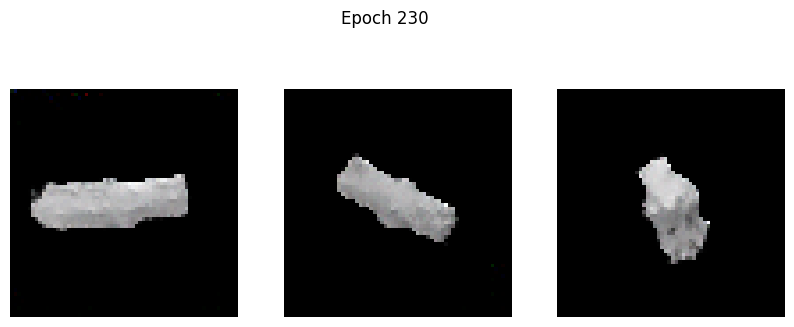

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0873 - g_loss: 3.6754
Epoch 231/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0901 - g_loss: 3.7438

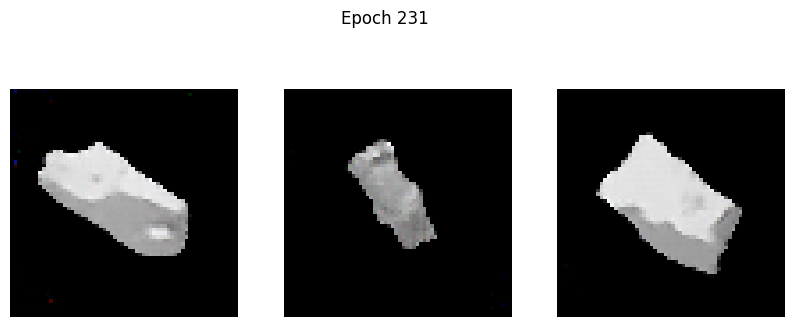

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0901 - g_loss: 3.7435
Epoch 232/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0840 - g_loss: 3.8310

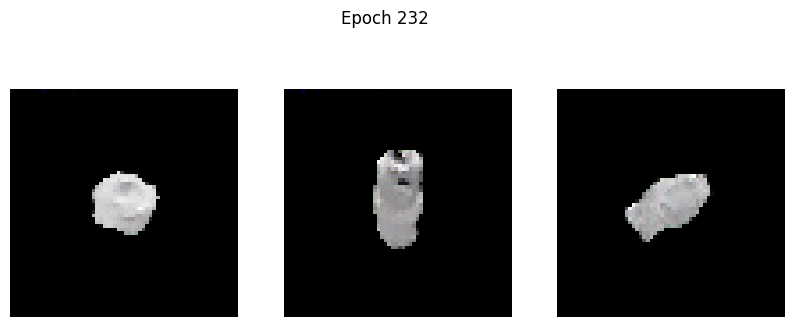

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0842 - g_loss: 3.8310
Epoch 233/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1470 - g_loss: 3.9442

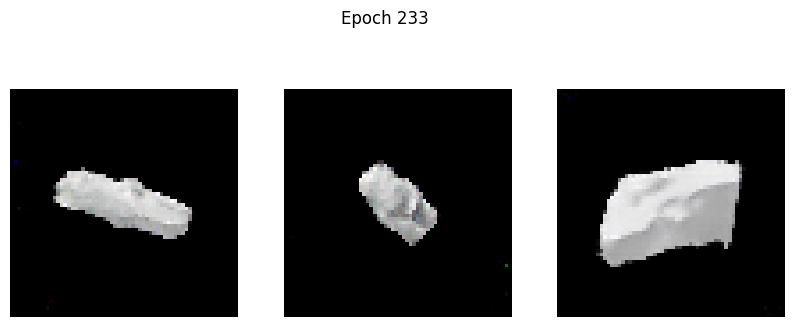

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1471 - g_loss: 3.9439
Epoch 234/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0896 - g_loss: 3.8553

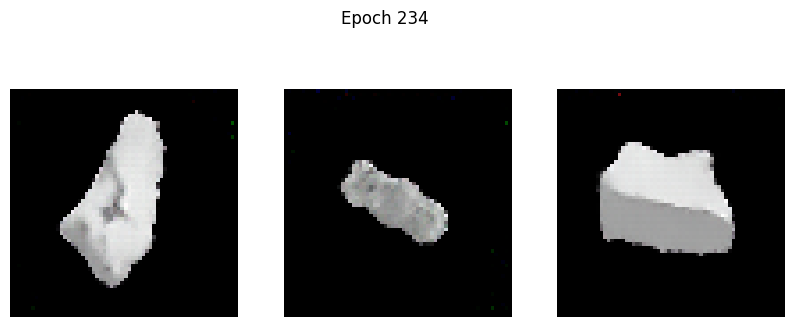

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0897 - g_loss: 3.8548
Epoch 235/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0819 - g_loss: 3.9159

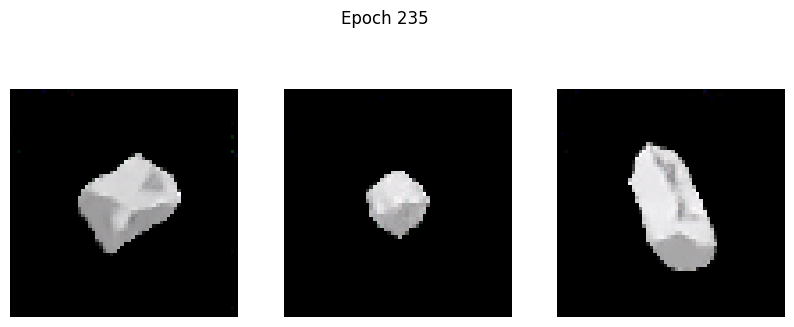

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0821 - g_loss: 3.9161
Epoch 236/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2459 - g_loss: 4.0592

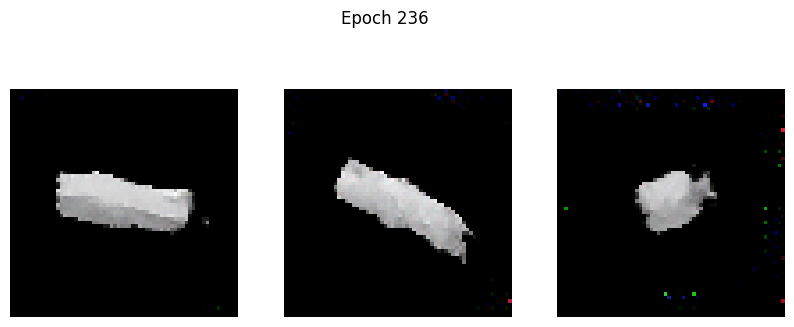

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2463 - g_loss: 4.0586
Epoch 237/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0969 - g_loss: 3.7028

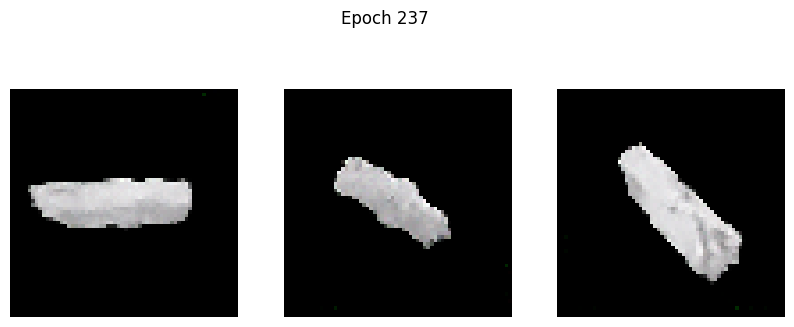

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0969 - g_loss: 3.7030
Epoch 238/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1017 - g_loss: 3.7850

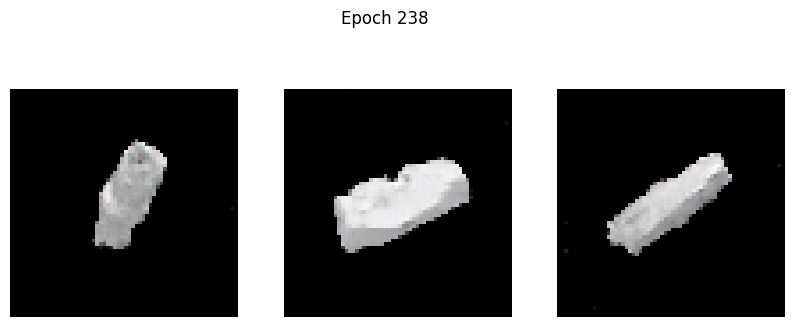

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1016 - g_loss: 3.7850
Epoch 239/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0888 - g_loss: 3.7755

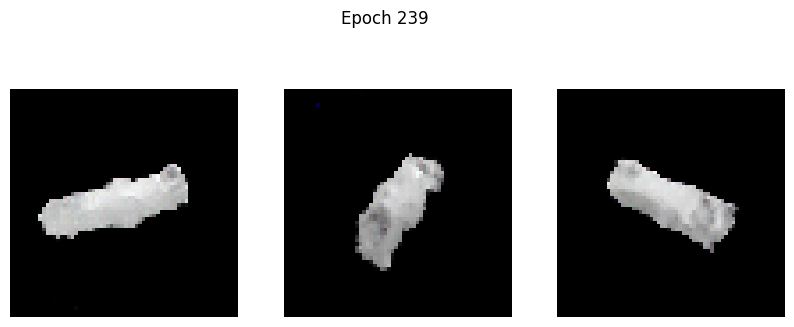

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0887 - g_loss: 3.7757
Epoch 240/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1596 - g_loss: 3.9198

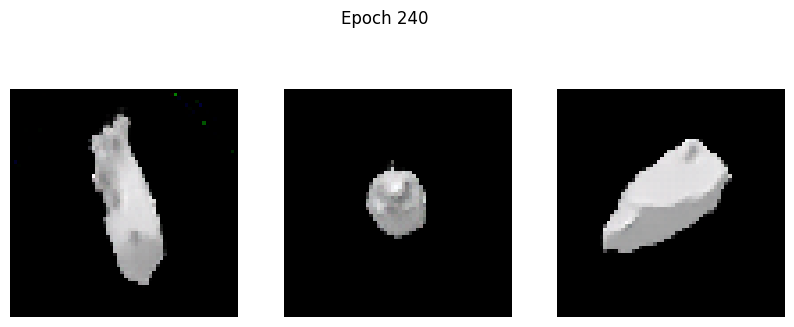

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1598 - g_loss: 3.9200
Epoch 241/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0942 - g_loss: 3.8412

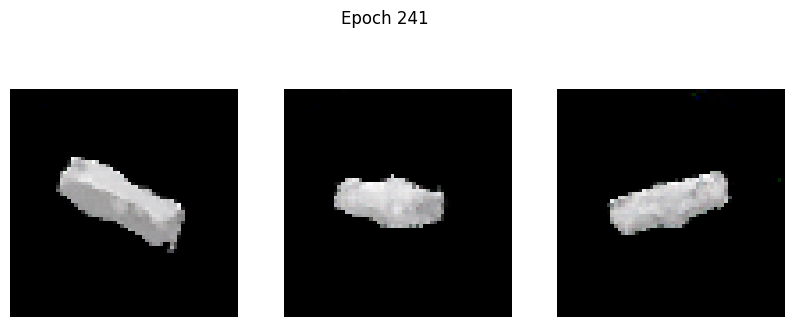

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0942 - g_loss: 3.8408
Epoch 242/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0949 - g_loss: 3.9556

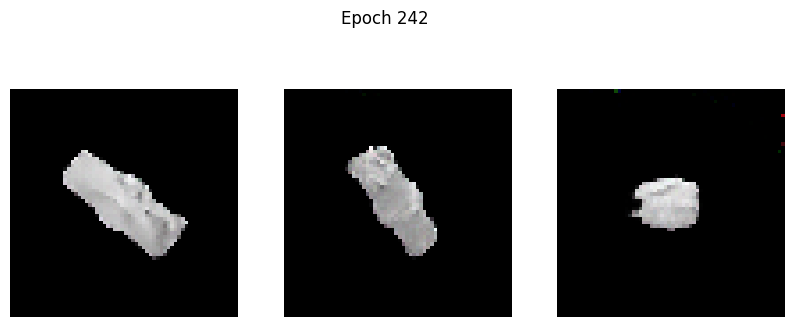

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0949 - g_loss: 3.9555
Epoch 243/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0838 - g_loss: 3.9097

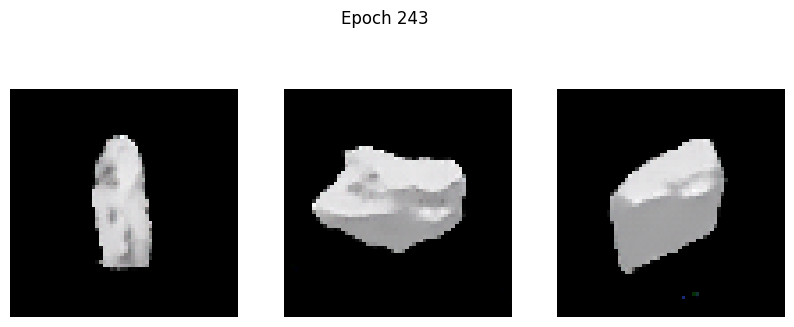

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0839 - g_loss: 3.9100
Epoch 244/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0960 - g_loss: 3.9237

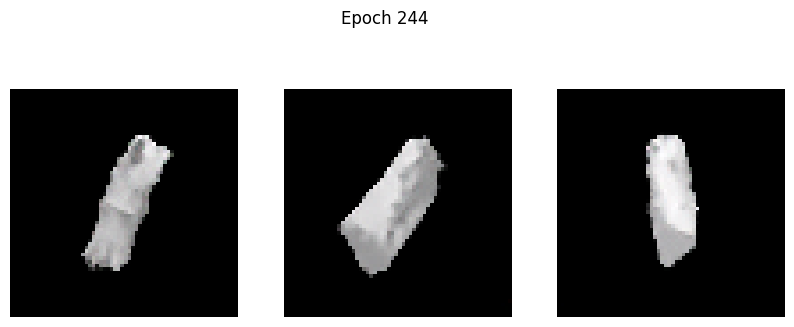

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0962 - g_loss: 3.9241
Epoch 245/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1330 - g_loss: 4.1134

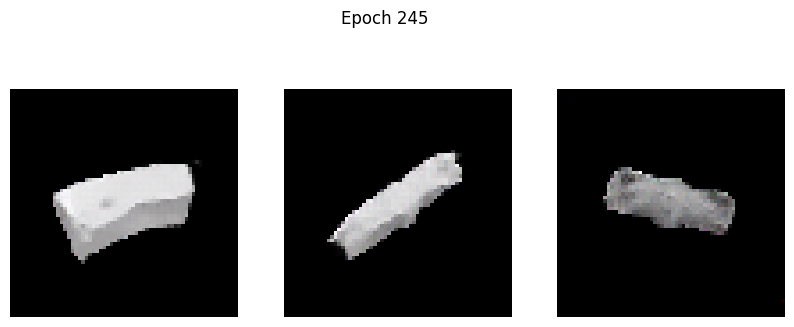

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1328 - g_loss: 4.1121
Epoch 246/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0910 - g_loss: 4.0267

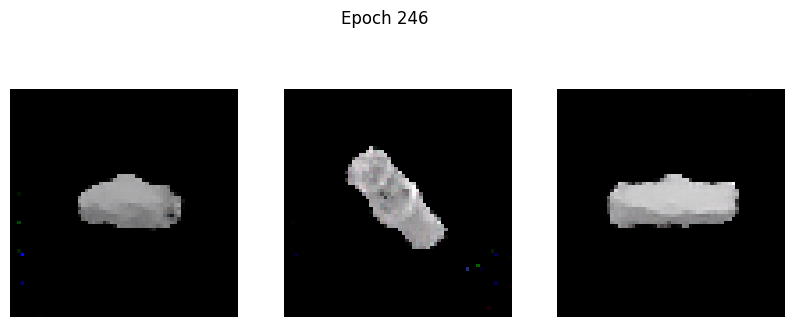

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0913 - g_loss: 4.0266
Epoch 247/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0724 - g_loss: 3.8750

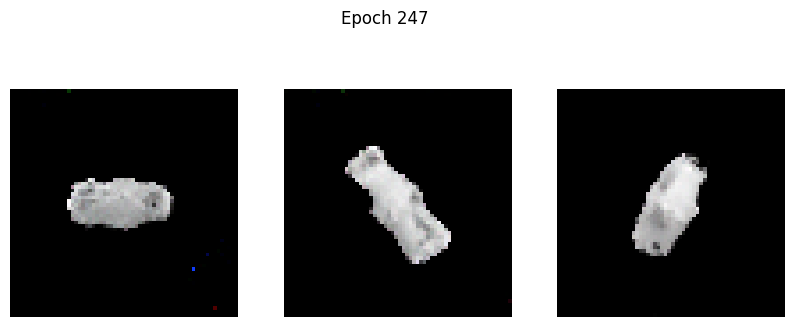

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0723 - g_loss: 3.8751
Epoch 248/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0755 - g_loss: 3.9694

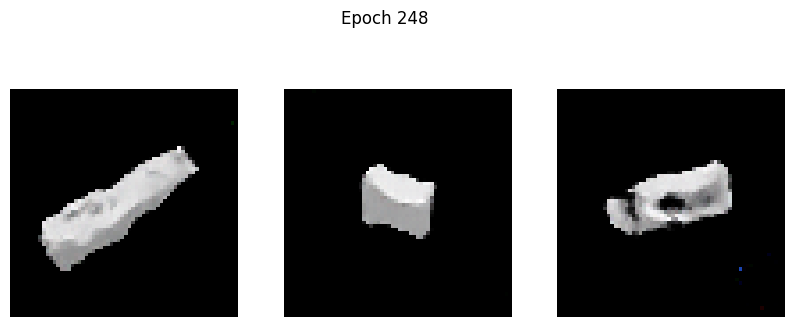

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0756 - g_loss: 3.9693
Epoch 249/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1266 - g_loss: 4.1593

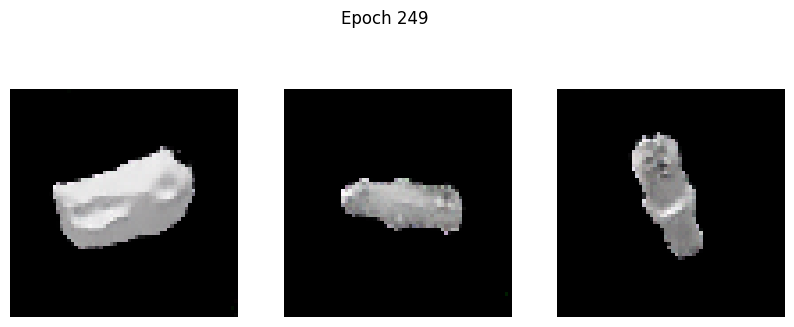

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1280 - g_loss: 4.1617
Epoch 250/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1134 - g_loss: 3.8464

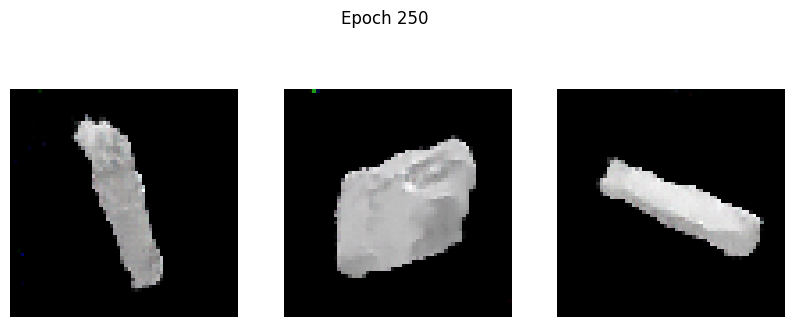

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1132 - g_loss: 3.8465
Epoch 251/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0826 - g_loss: 4.1089

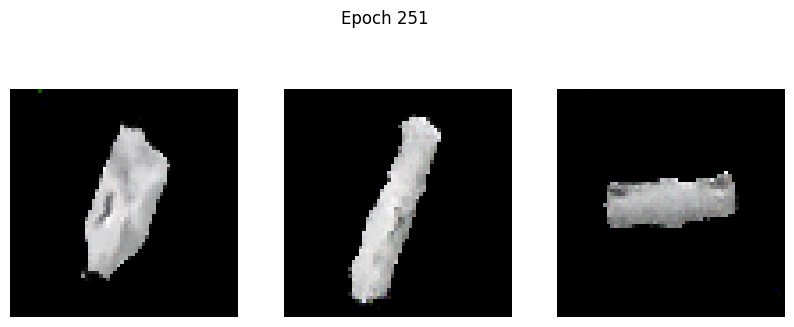

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0826 - g_loss: 4.1079
Epoch 252/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.6428 - g_loss: 4.4938

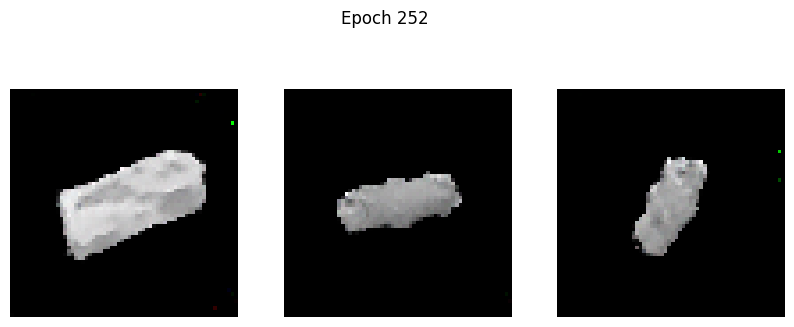

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.6410 - g_loss: 4.4898
Epoch 253/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0770 - g_loss: 3.6348

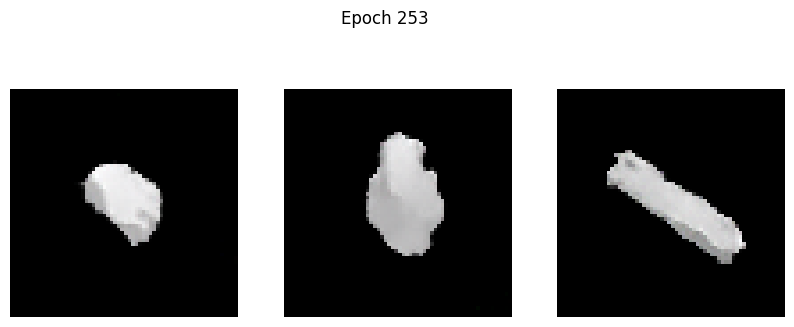

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0770 - g_loss: 3.6348
Epoch 254/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0702 - g_loss: 3.7739

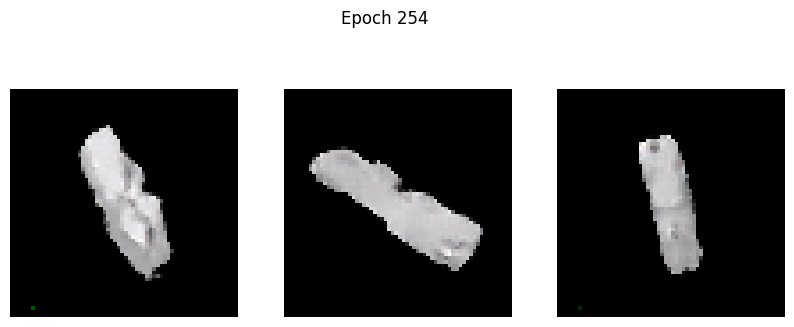

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0703 - g_loss: 3.7740
Epoch 255/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0889 - g_loss: 3.7919

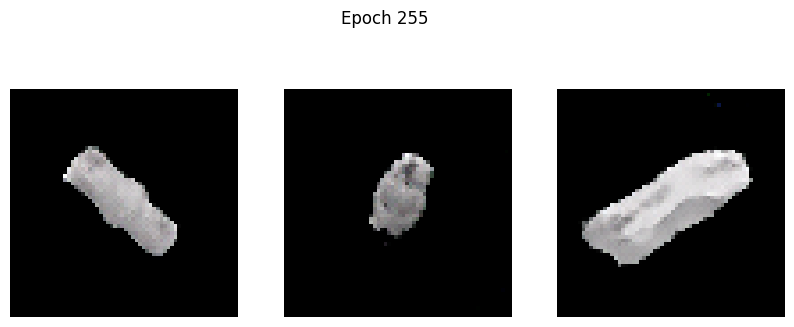

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0888 - g_loss: 3.7925
Epoch 256/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0772 - g_loss: 3.8789

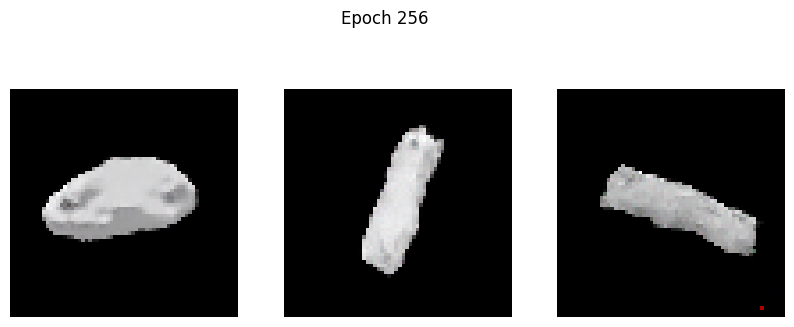

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0772 - g_loss: 3.8782
Epoch 257/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0832 - g_loss: 3.8236

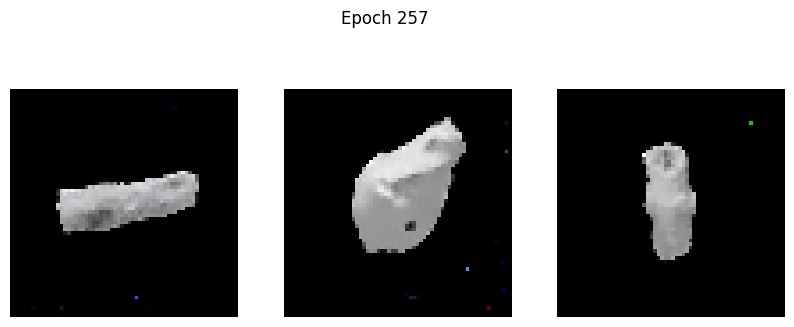

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0833 - g_loss: 3.8246
Epoch 258/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0798 - g_loss: 3.9074

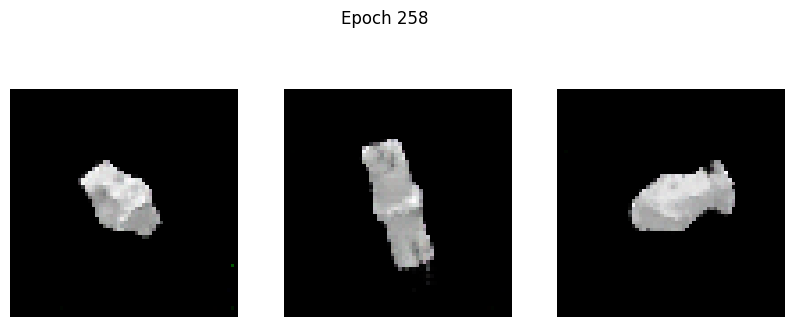

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0798 - g_loss: 3.9081
Epoch 259/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1142 - g_loss: 4.0364

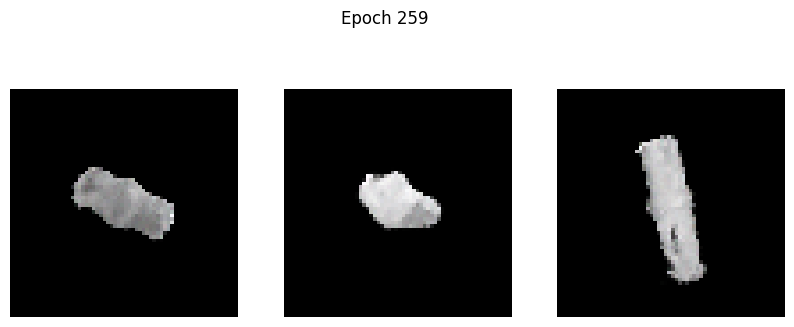

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1138 - g_loss: 4.0360
Epoch 260/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0676 - g_loss: 4.0488

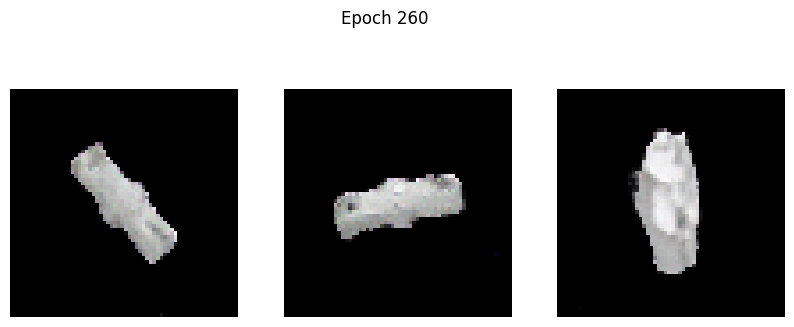

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0678 - g_loss: 4.0489
Epoch 261/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0971 - g_loss: 4.0188

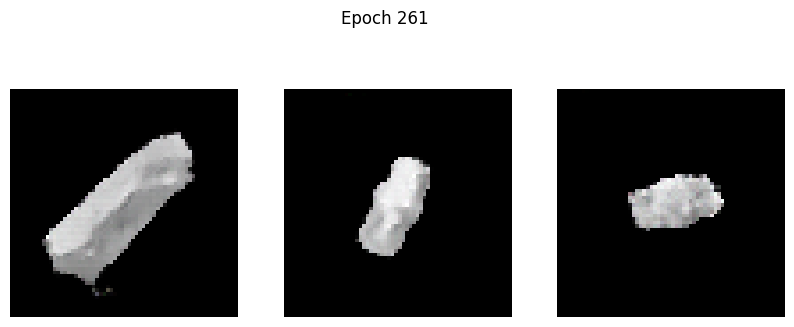

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0970 - g_loss: 4.0190
Epoch 262/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0881 - g_loss: 4.1480

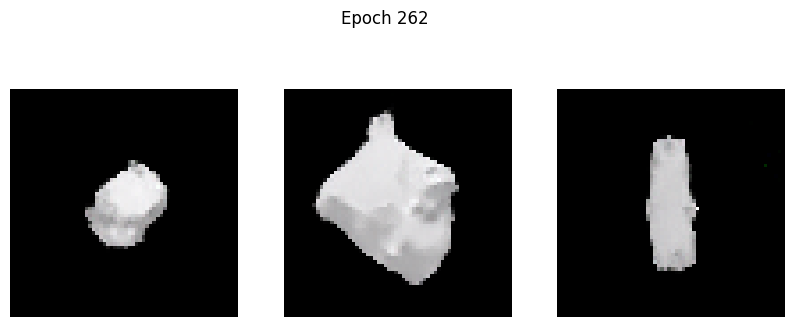

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0881 - g_loss: 4.1479
Epoch 263/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.3165 - g_loss: 4.3869

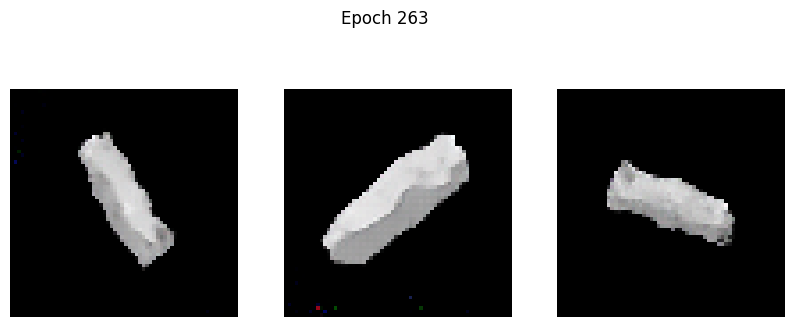

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.3157 - g_loss: 4.3849
Epoch 264/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0739 - g_loss: 4.0290

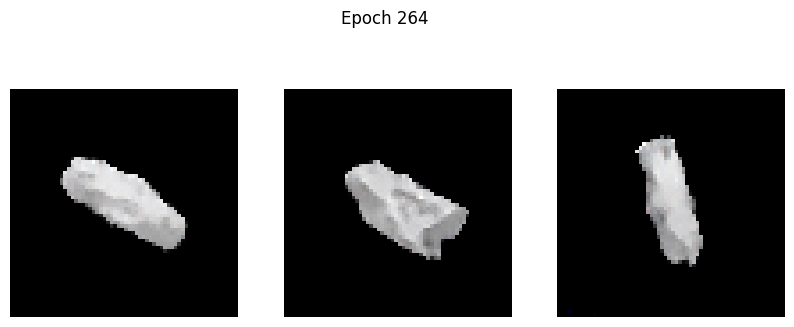

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0739 - g_loss: 4.0285
Epoch 265/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1002 - g_loss: 4.0924

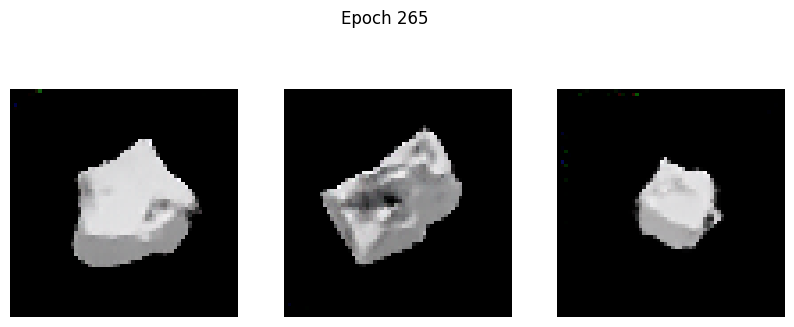

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1000 - g_loss: 4.0917
Epoch 266/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0897 - g_loss: 4.0512

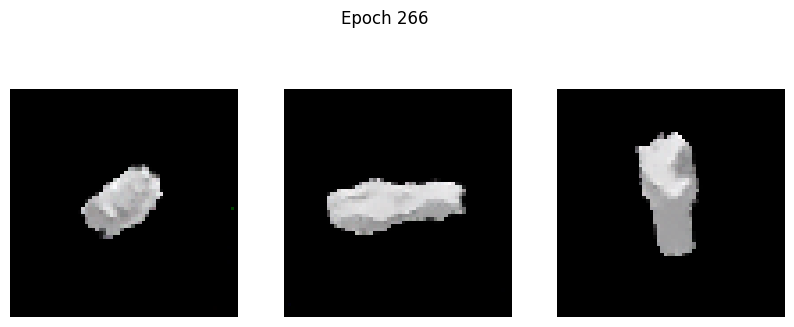

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0897 - g_loss: 4.0512
Epoch 267/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0719 - g_loss: 4.0799

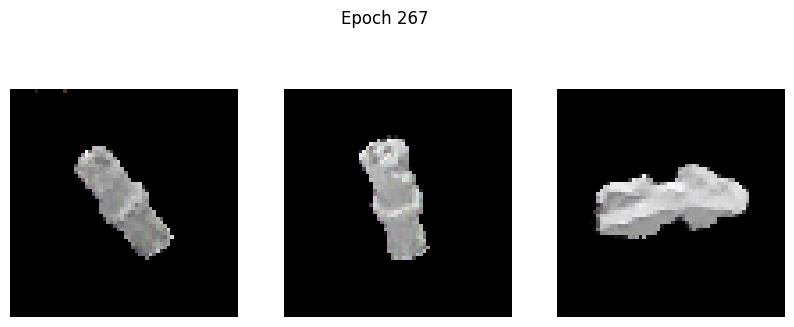

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0720 - g_loss: 4.0798
Epoch 268/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0871 - g_loss: 4.0803

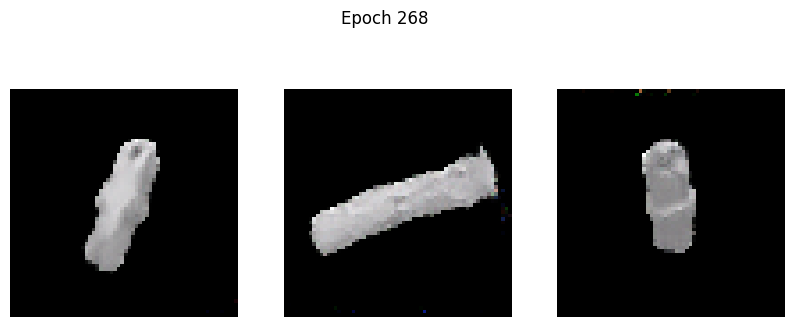

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0873 - g_loss: 4.0807
Epoch 269/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1002 - g_loss: 4.1214

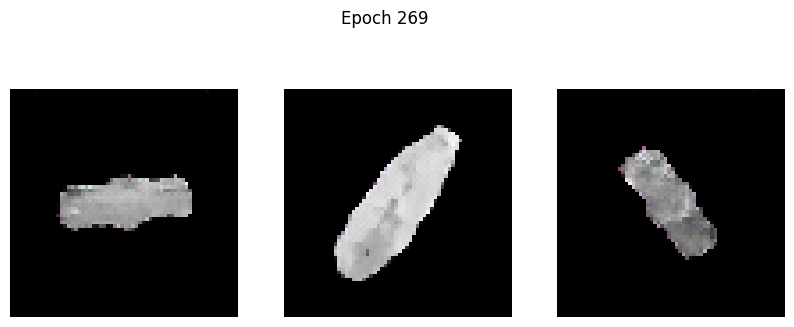

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1029 - g_loss: 4.1255
Epoch 270/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2344 - g_loss: 3.7367

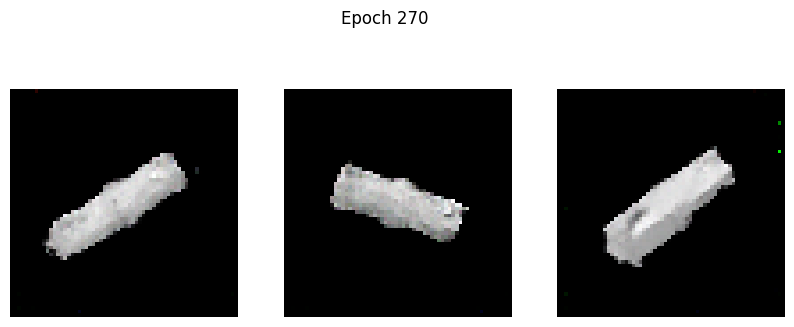

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.2335 - g_loss: 3.7368
Epoch 271/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0697 - g_loss: 3.8622

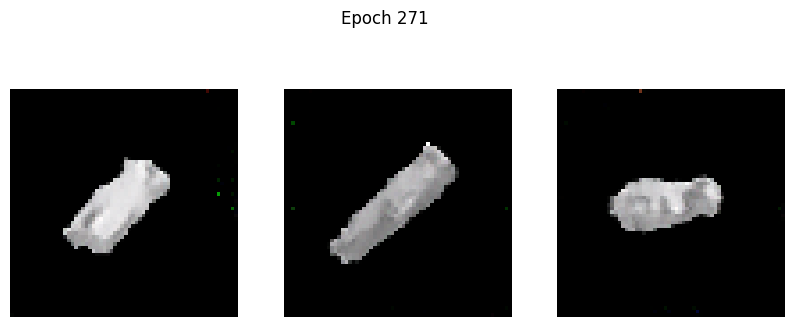

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0699 - g_loss: 3.8626
Epoch 272/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0734 - g_loss: 3.9827

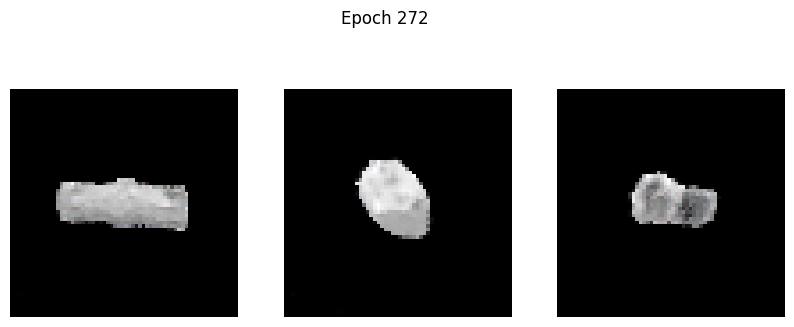

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0734 - g_loss: 3.9825
Epoch 273/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0554 - g_loss: 3.9674

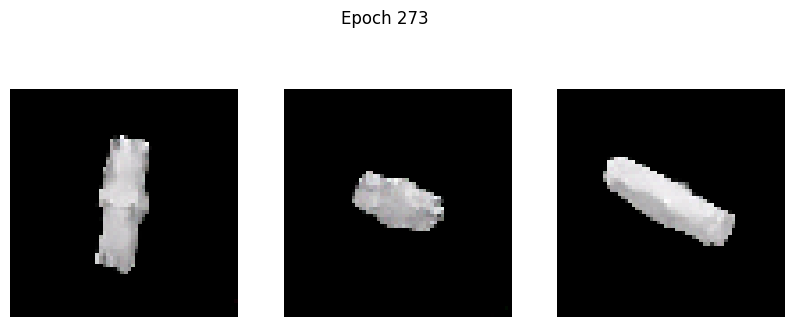

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0555 - g_loss: 3.9674
Epoch 274/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0854 - g_loss: 4.1019

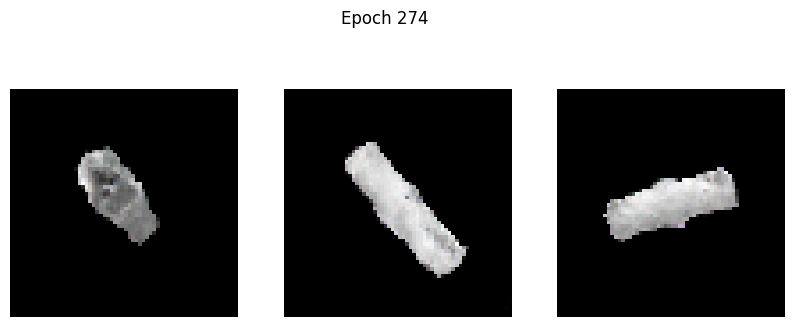

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0853 - g_loss: 4.1021
Epoch 275/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0752 - g_loss: 4.1959

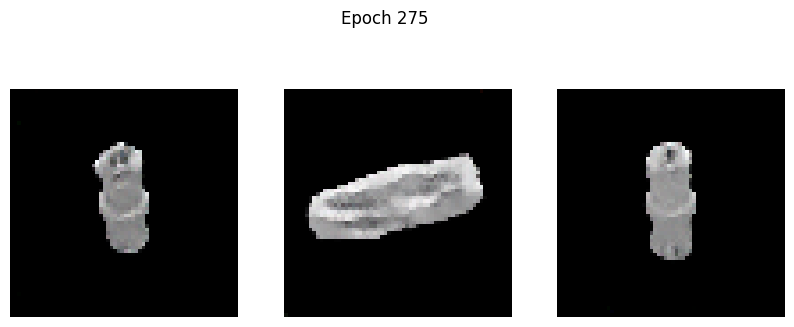

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0752 - g_loss: 4.1950
Epoch 276/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1026 - g_loss: 4.1348

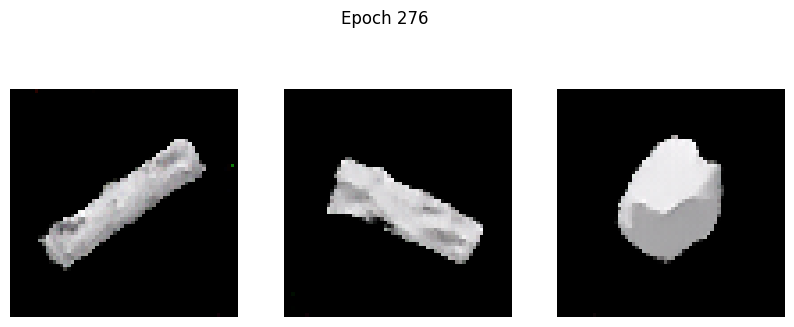

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1025 - g_loss: 4.1345
Epoch 277/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0658 - g_loss: 4.1346

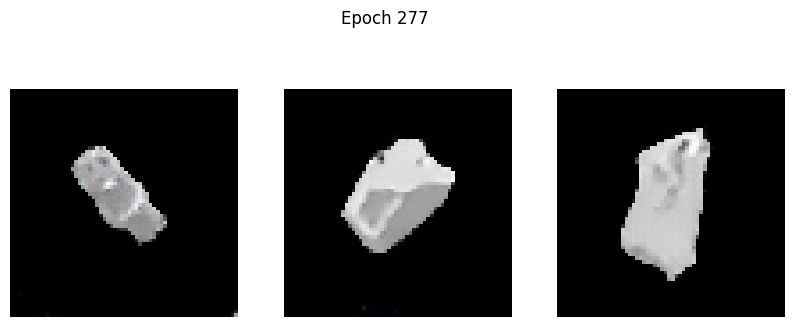

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.0659 - g_loss: 4.1353
Epoch 278/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1342 - g_loss: 4.3587

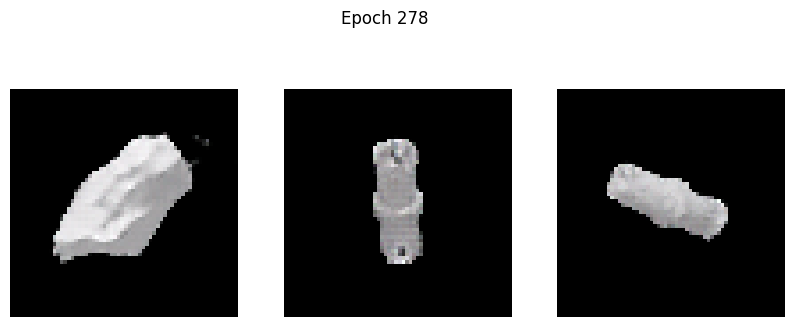

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.1340 - g_loss: 4.3579
Epoch 279/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0810 - g_loss: 4.2648

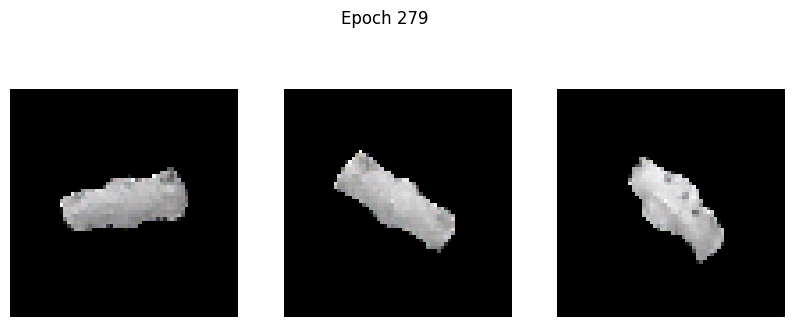

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0811 - g_loss: 4.2649
Epoch 280/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1699 - g_loss: 4.4718

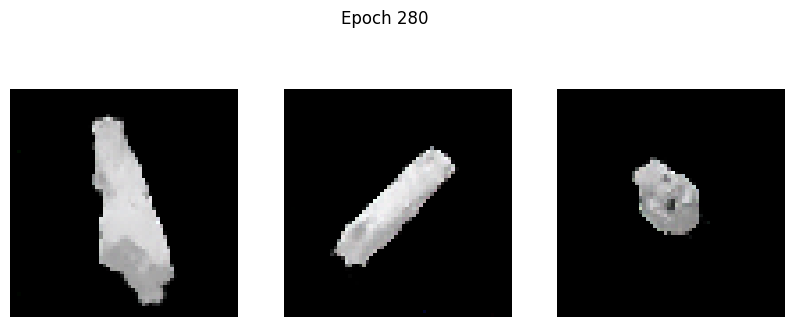

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1705 - g_loss: 4.4716
Epoch 281/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2684 - g_loss: 4.3900

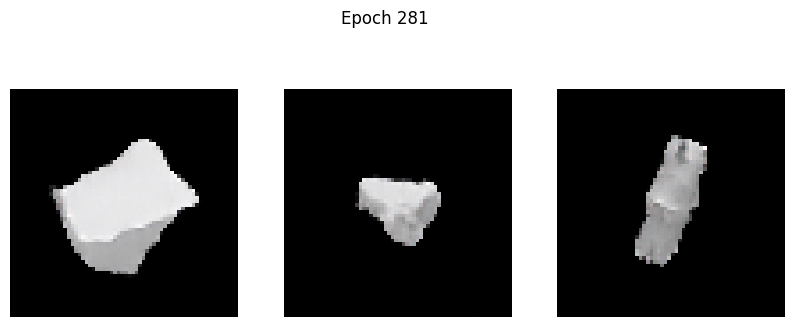

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2671 - g_loss: 4.3869
Epoch 282/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0582 - g_loss: 4.0959

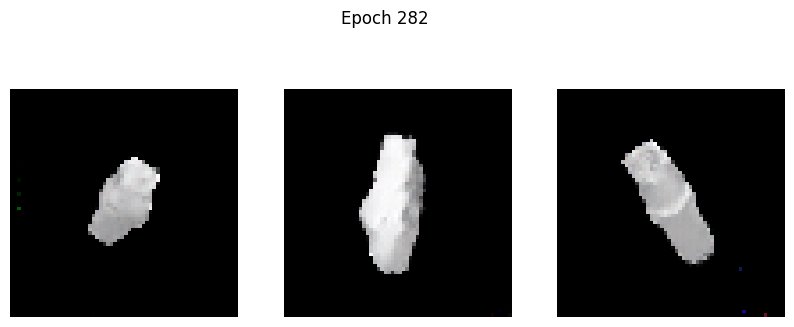

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0583 - g_loss: 4.0957
Epoch 283/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0789 - g_loss: 4.2272

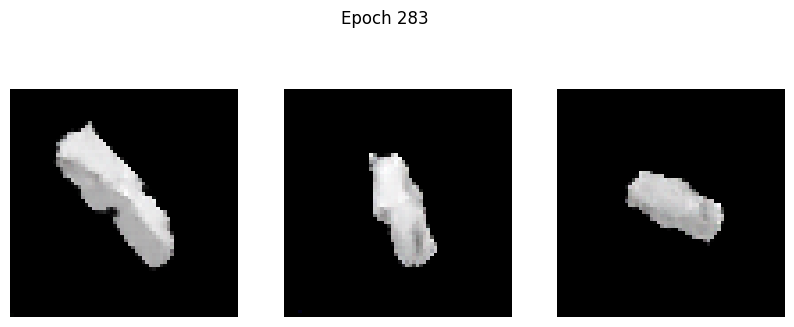

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0789 - g_loss: 4.2269
Epoch 284/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0795 - g_loss: 4.1892

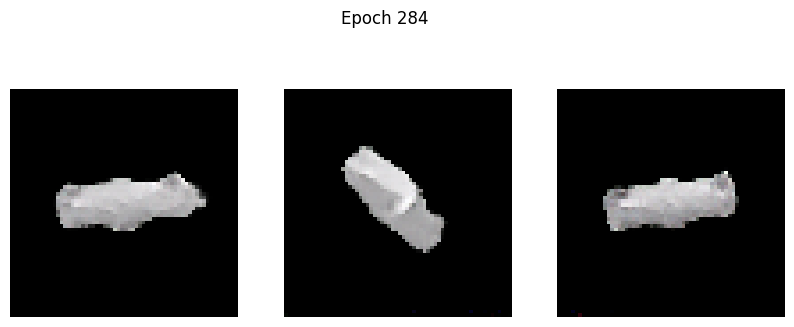

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.0794 - g_loss: 4.1894
Epoch 285/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0663 - g_loss: 4.1574

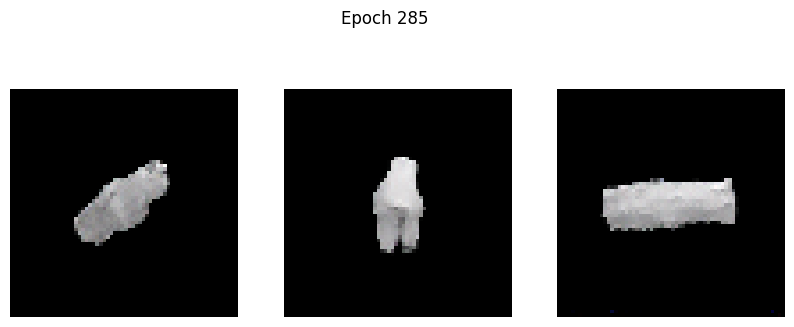

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0662 - g_loss: 4.1576
Epoch 286/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0505 - g_loss: 4.3487

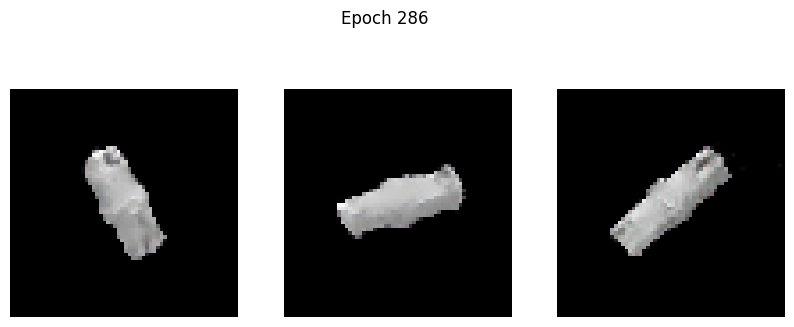

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0507 - g_loss: 4.3485
Epoch 287/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1188 - g_loss: 4.3739

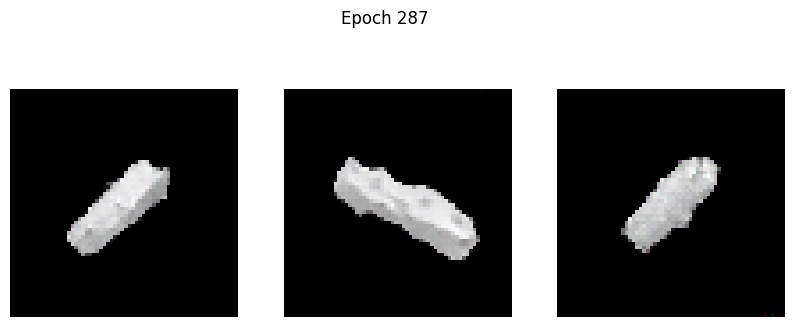

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1188 - g_loss: 4.3738
Epoch 288/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1472 - g_loss: 4.4055

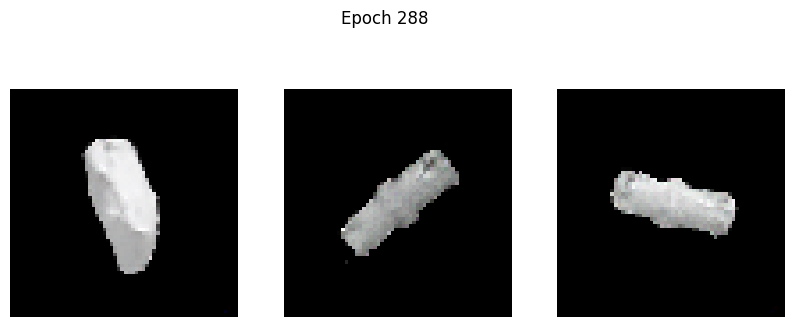

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1466 - g_loss: 4.4041
Epoch 289/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0709 - g_loss: 4.2508

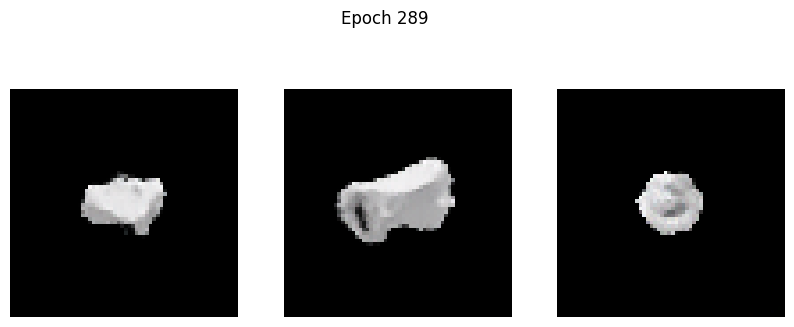

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0710 - g_loss: 4.2511
Epoch 290/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1064 - g_loss: 4.4701

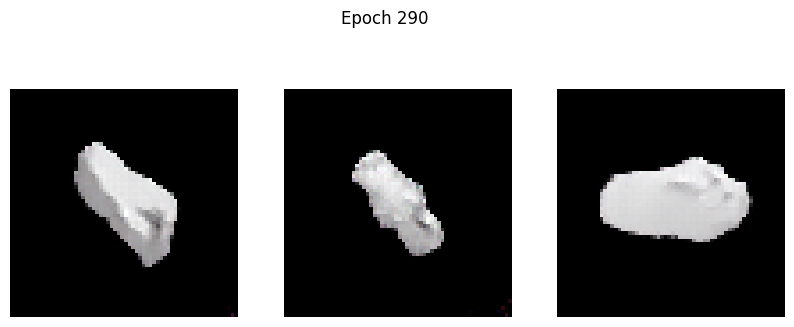

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1064 - g_loss: 4.4692
Epoch 291/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.4041 - g_loss: 4.9160

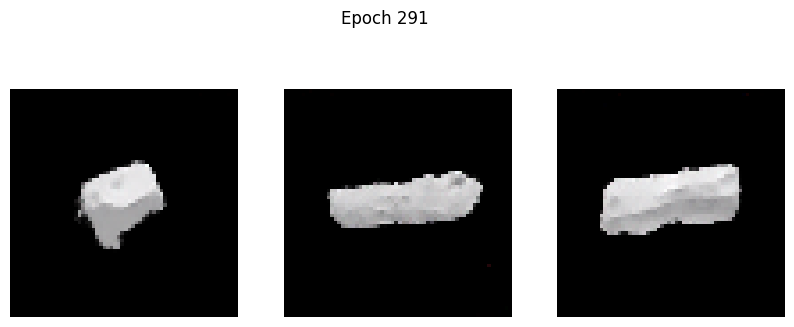

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.4023 - g_loss: 4.9112
Epoch 292/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0494 - g_loss: 4.1799

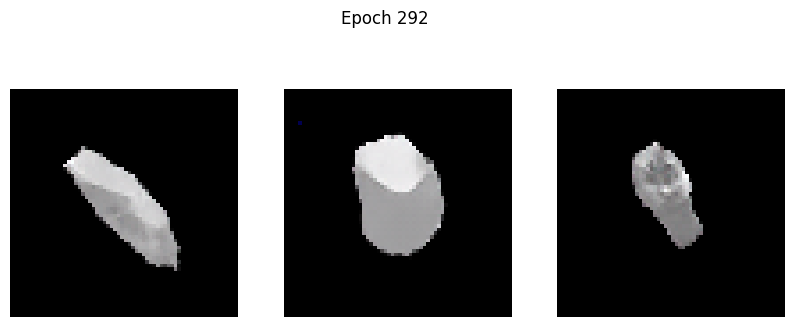

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0495 - g_loss: 4.1804
Epoch 293/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0652 - g_loss: 4.2040

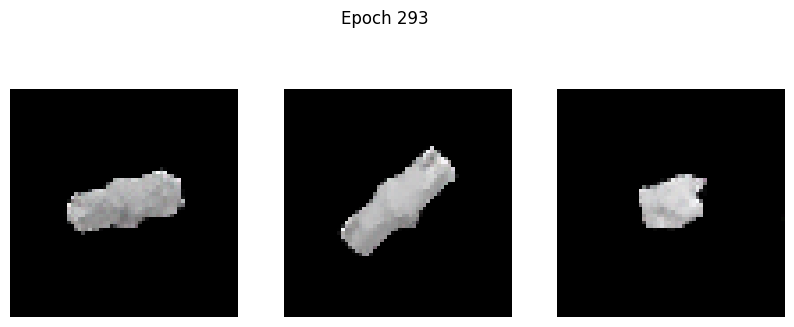

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0652 - g_loss: 4.2040
Epoch 294/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0657 - g_loss: 4.3656

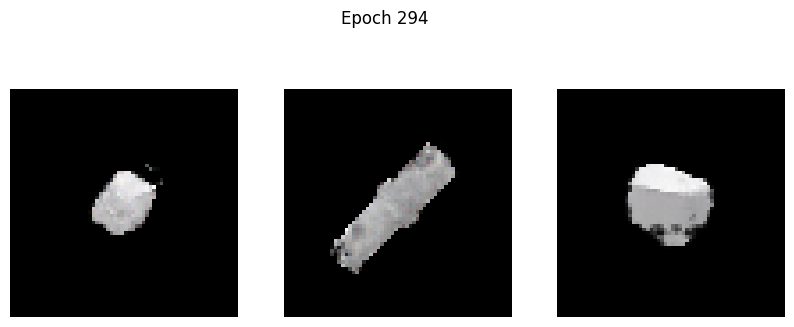

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0657 - g_loss: 4.3651
Epoch 295/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0852 - g_loss: 4.5143

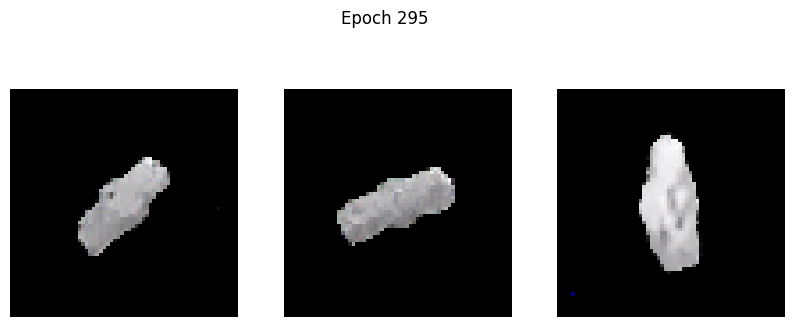

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0851 - g_loss: 4.5129
Epoch 296/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0647 - g_loss: 4.2323

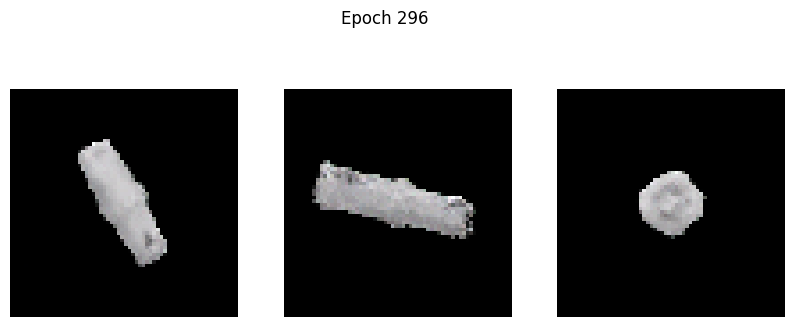

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0648 - g_loss: 4.2326
Epoch 297/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0542 - g_loss: 4.3715

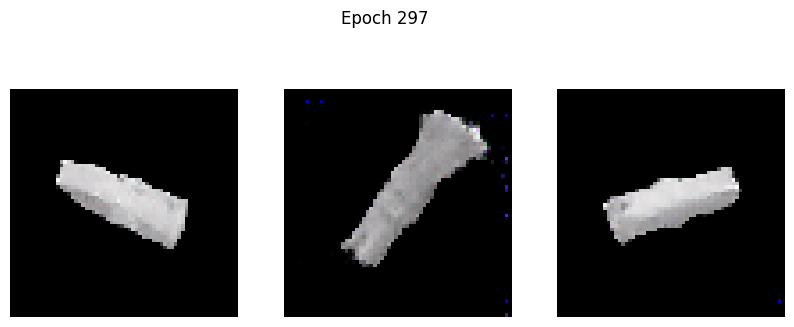

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0542 - g_loss: 4.3719
Epoch 298/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0697 - g_loss: 4.4170

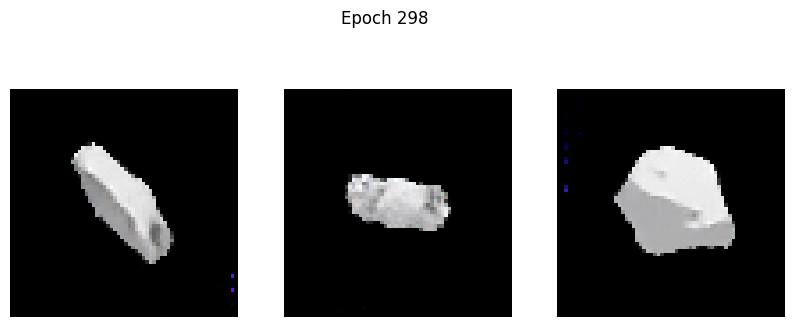

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0697 - g_loss: 4.4172
Epoch 299/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1957 - g_loss: 4.6448

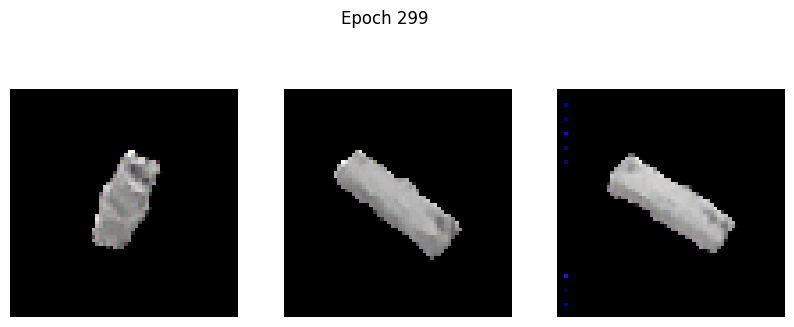

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1965 - g_loss: 4.6451
Epoch 300/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0641 - g_loss: 4.1269

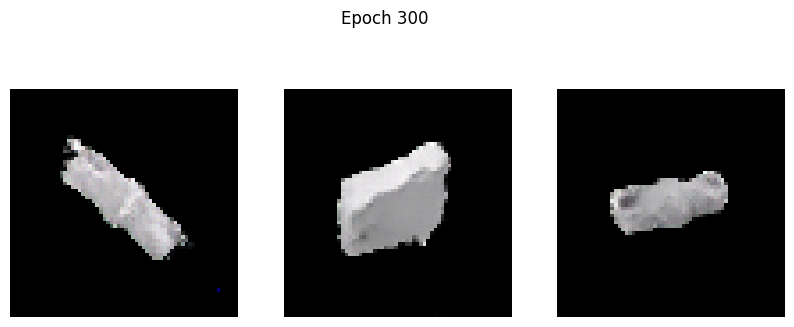

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0642 - g_loss: 4.1275
Epoch 301/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0638 - g_loss: 4.2324

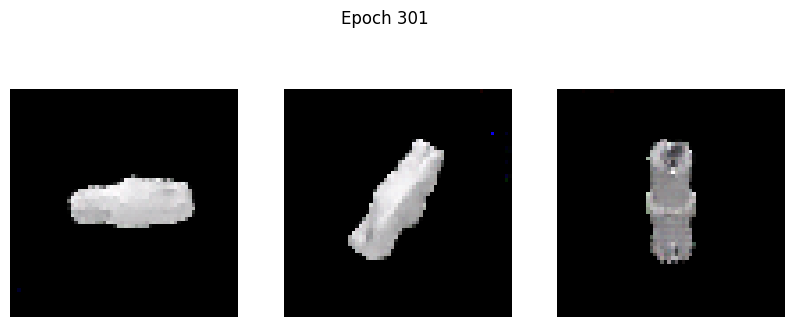

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0638 - g_loss: 4.2333
Epoch 302/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0549 - g_loss: 4.2831

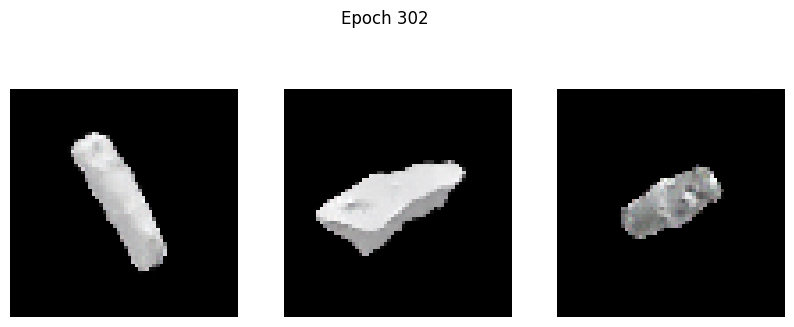

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0550 - g_loss: 4.2828
Epoch 303/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0548 - g_loss: 4.3206

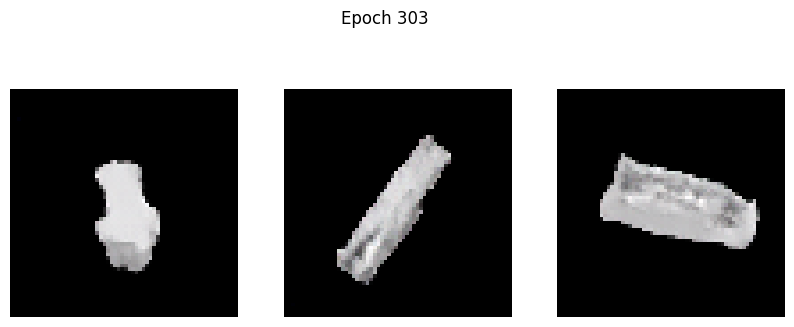

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0549 - g_loss: 4.3205
Epoch 304/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0548 - g_loss: 4.3257

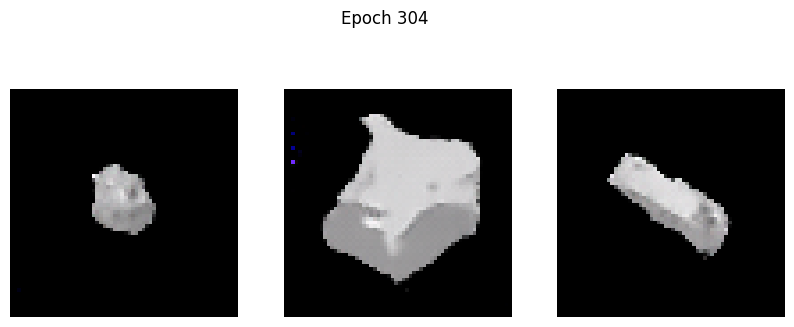

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0549 - g_loss: 4.3261
Epoch 305/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0525 - g_loss: 4.4092

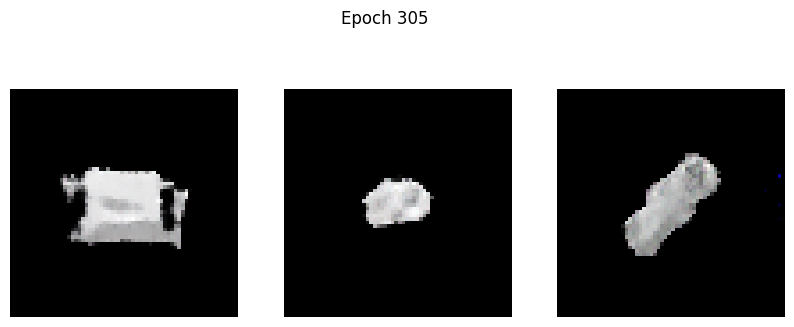

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0527 - g_loss: 4.4097
Epoch 306/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1292 - g_loss: 4.6572

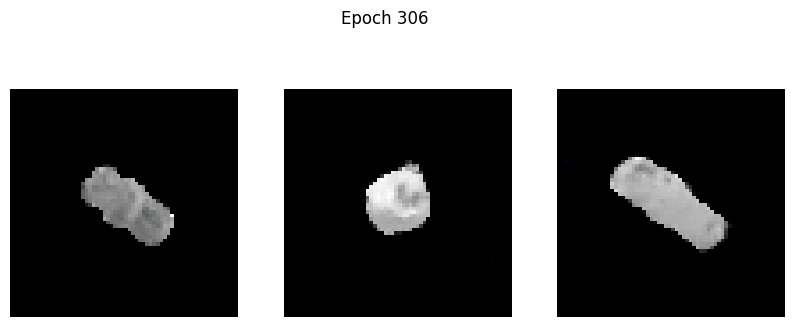

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1292 - g_loss: 4.6560
Epoch 307/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0751 - g_loss: 4.4204

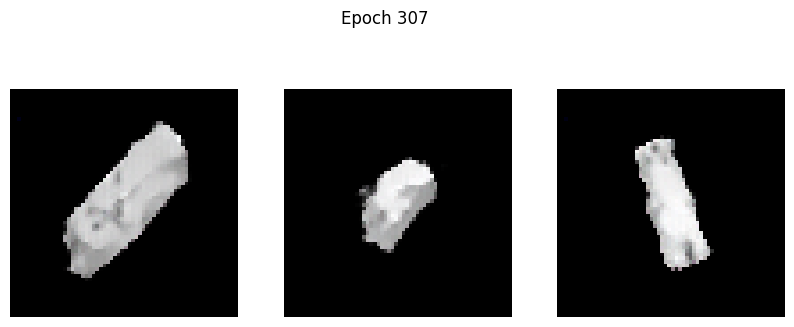

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0752 - g_loss: 4.4210
Epoch 308/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0899 - g_loss: 4.5509

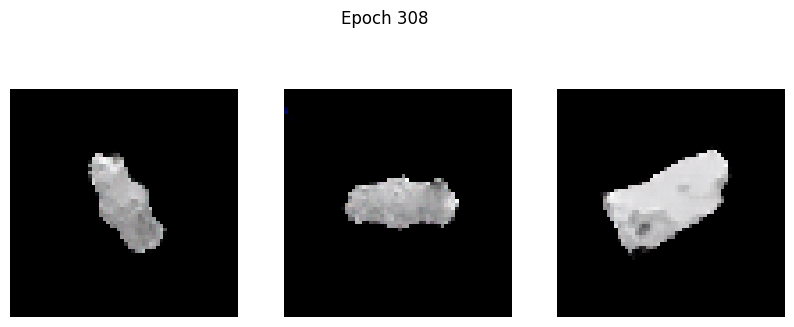

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0898 - g_loss: 4.5510
Epoch 309/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0607 - g_loss: 4.4623

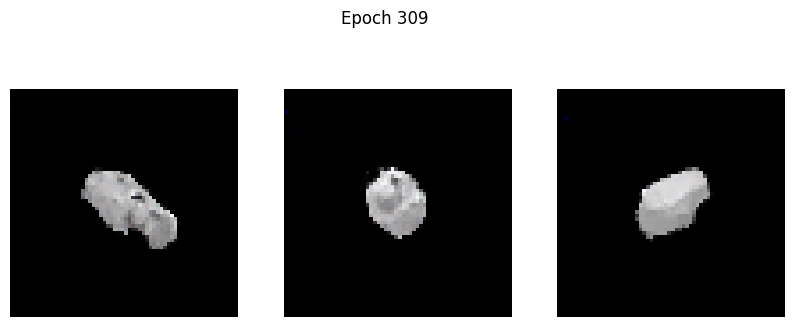

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0608 - g_loss: 4.4625
Epoch 310/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0553 - g_loss: 4.4194

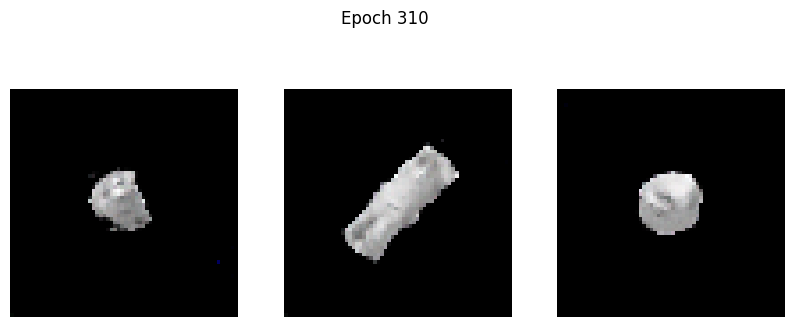

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0557 - g_loss: 4.4208
Epoch 311/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0950 - g_loss: 4.5189

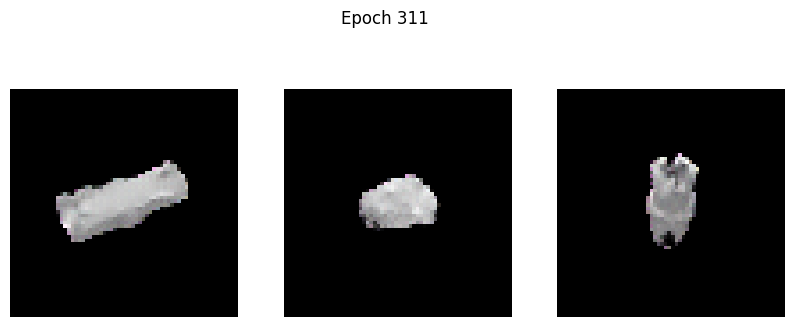

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0956 - g_loss: 4.5198
Epoch 312/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1864 - g_loss: 4.5062

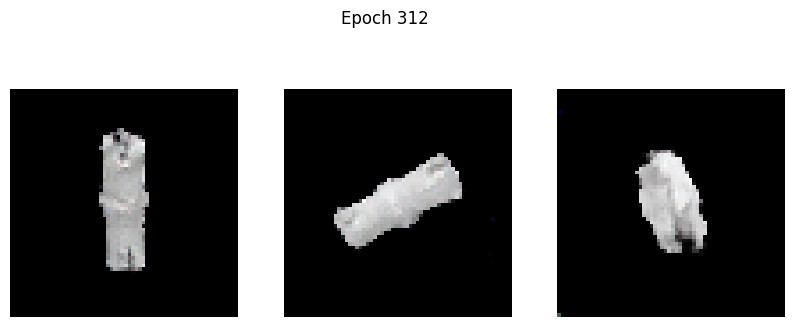

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1857 - g_loss: 4.5056
Epoch 313/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0432 - g_loss: 4.3802

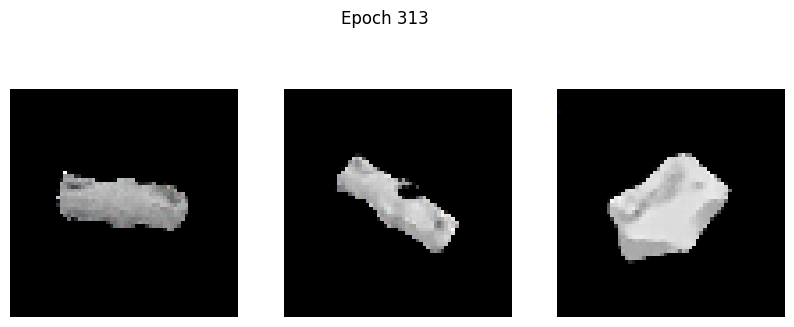

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - d_loss: 0.0432 - g_loss: 4.3802
Epoch 314/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.0306 - g_loss: 4.3631

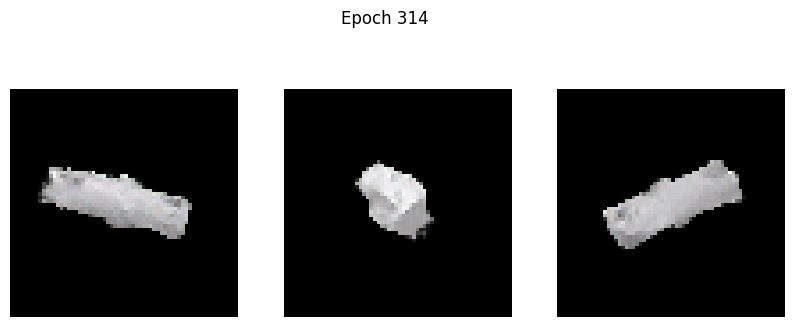

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - d_loss: 0.0307 - g_loss: 4.3637
Epoch 315/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.0594 - g_loss: 4.5074

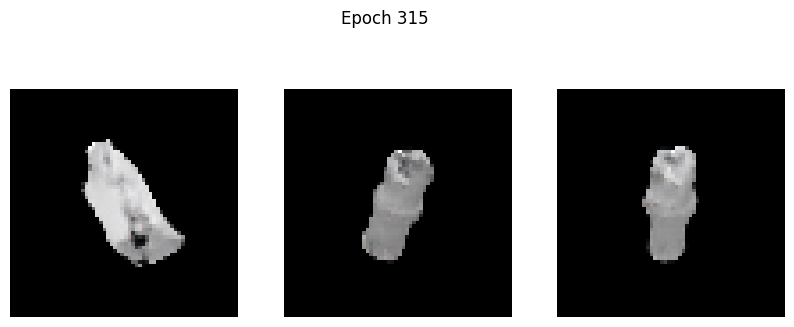

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.0594 - g_loss: 4.5075
Epoch 316/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.0772 - g_loss: 4.4215

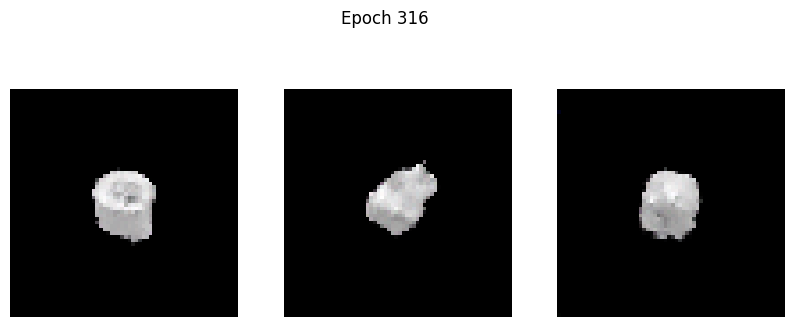

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0771 - g_loss: 4.4223
Epoch 317/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0630 - g_loss: 4.5414

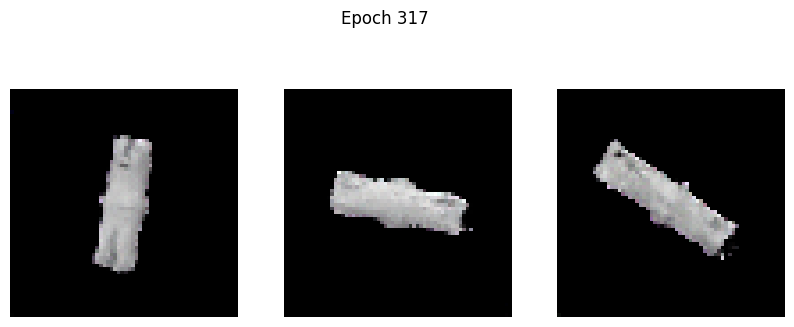

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0640 - g_loss: 4.5442
Epoch 318/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0972 - g_loss: 4.5872

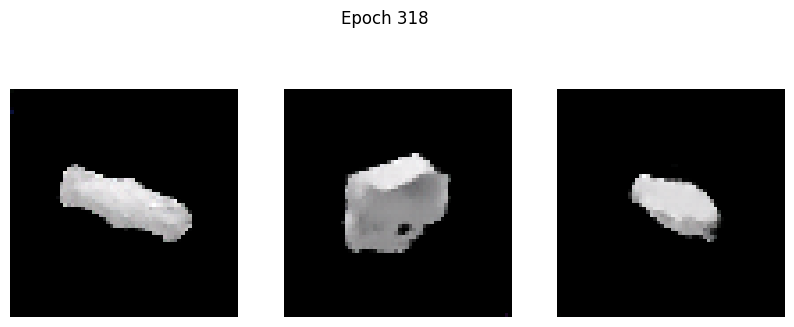

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0969 - g_loss: 4.5870
Epoch 319/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0331 - g_loss: 4.4550

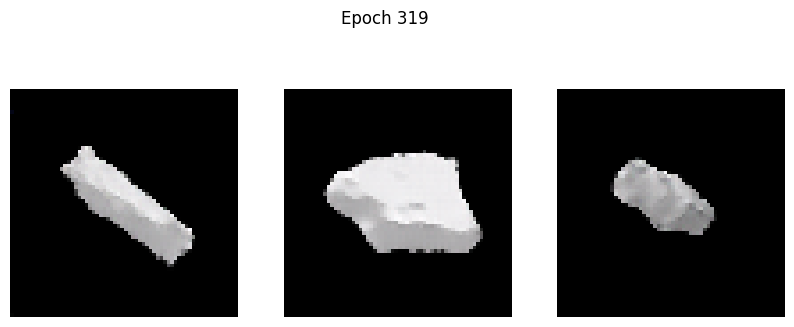

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0332 - g_loss: 4.4554
Epoch 320/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0787 - g_loss: 4.6817

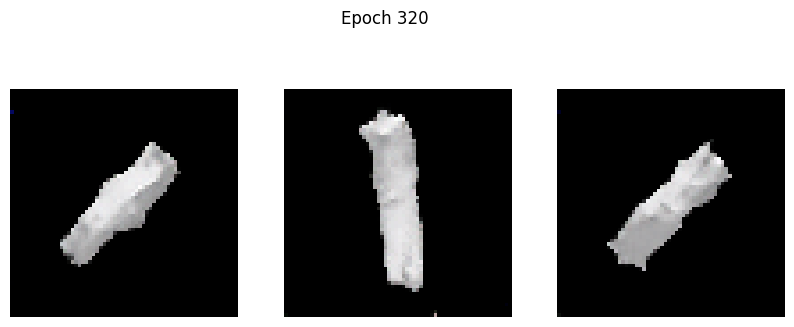

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0790 - g_loss: 4.6815
Epoch 321/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0514 - g_loss: 4.6280

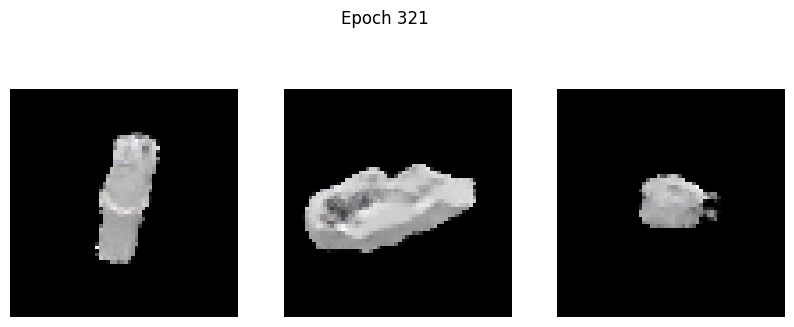

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0514 - g_loss: 4.6276
Epoch 322/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0544 - g_loss: 4.5077

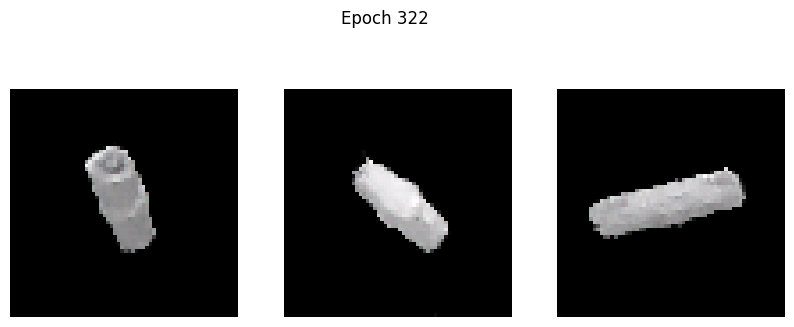

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0544 - g_loss: 4.5078
Epoch 323/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0634 - g_loss: 4.6357

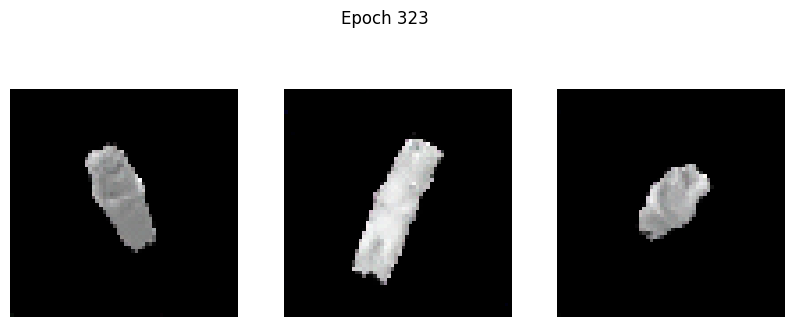

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0635 - g_loss: 4.6366
Epoch 324/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1199 - g_loss: 4.7860

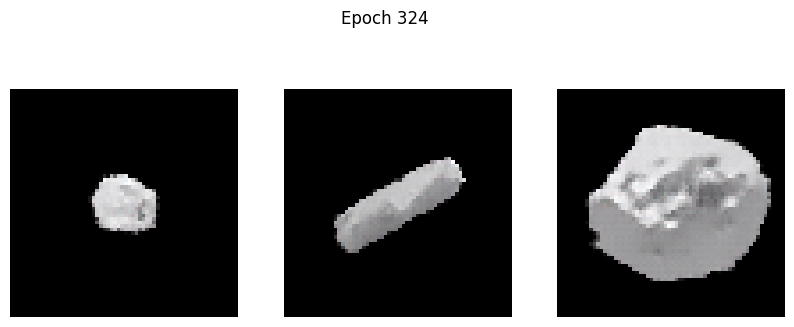

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1199 - g_loss: 4.7854
Epoch 325/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0460 - g_loss: 4.6454

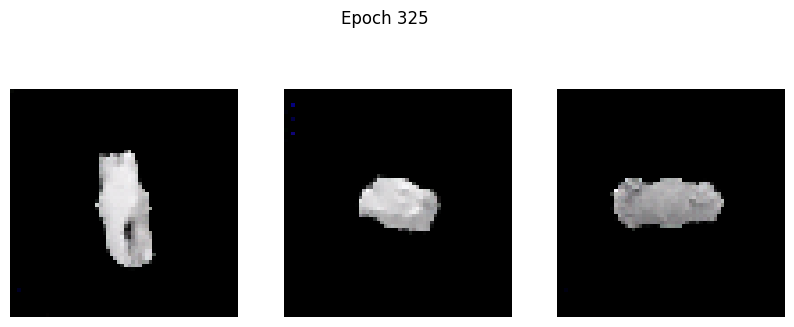

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0460 - g_loss: 4.6448
Epoch 326/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1380 - g_loss: 4.9856

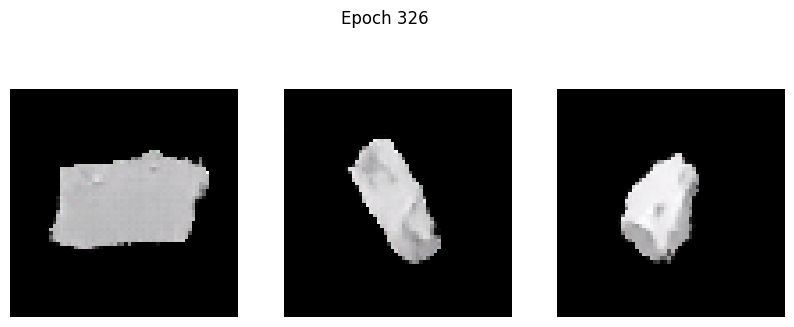

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1377 - g_loss: 4.9834
Epoch 327/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0501 - g_loss: 4.6835

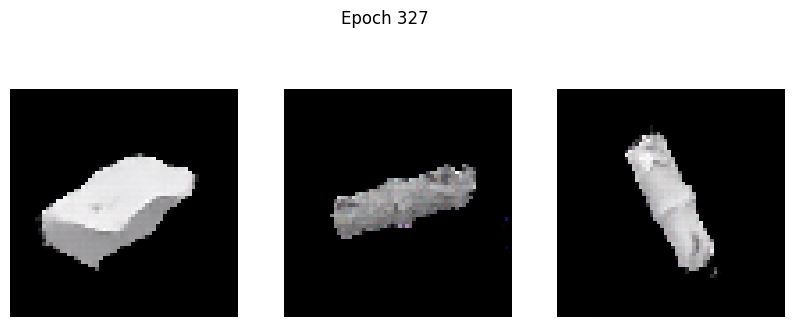

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0501 - g_loss: 4.6831
Epoch 328/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0472 - g_loss: 4.5529

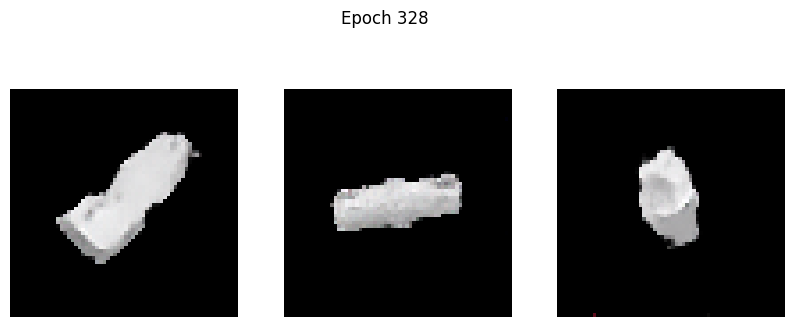

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0474 - g_loss: 4.5538
Epoch 329/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0455 - g_loss: 4.7051

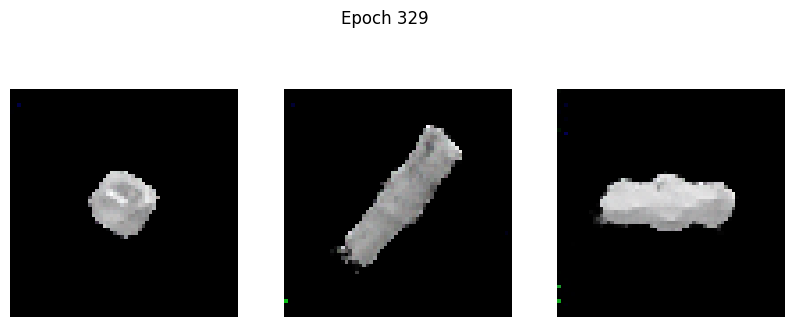

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0454 - g_loss: 4.7048
Epoch 330/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0395 - g_loss: 4.7105

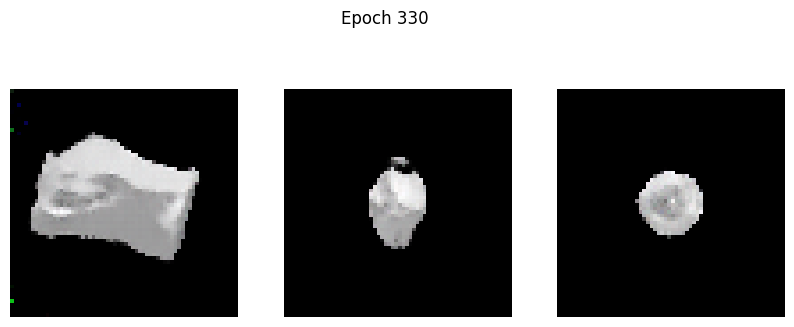

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0395 - g_loss: 4.7111
Epoch 331/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1143 - g_loss: 4.8011

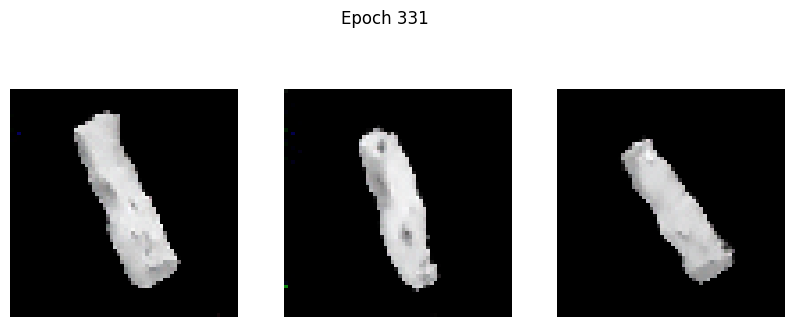

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1145 - g_loss: 4.8015
Epoch 332/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0822 - g_loss: 4.7069

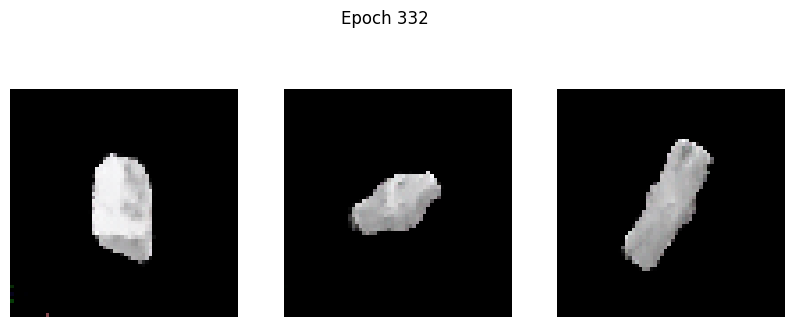

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0820 - g_loss: 4.7065
Epoch 333/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0502 - g_loss: 4.6924

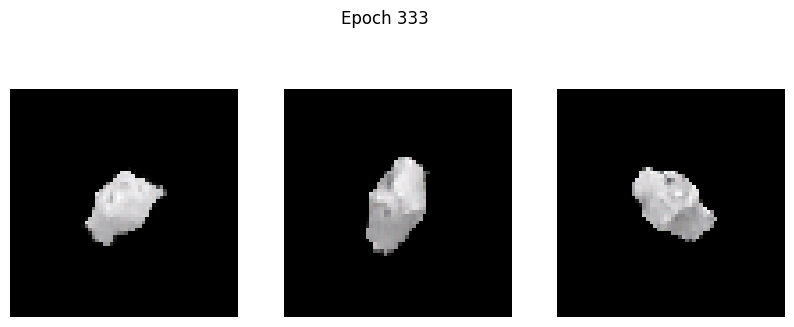

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.0502 - g_loss: 4.6922
Epoch 334/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0305 - g_loss: 4.5861

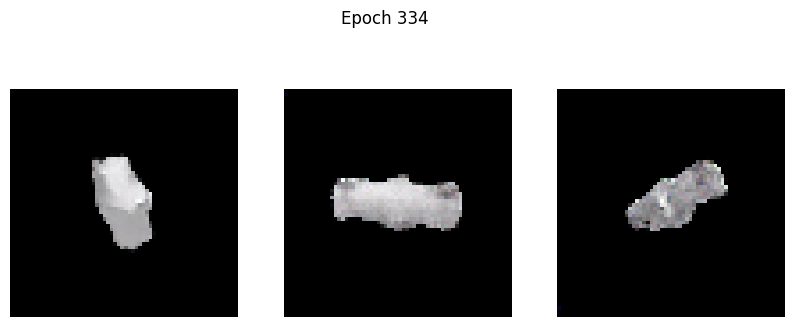

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0305 - g_loss: 4.5868
Epoch 335/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1068 - g_loss: 4.8885

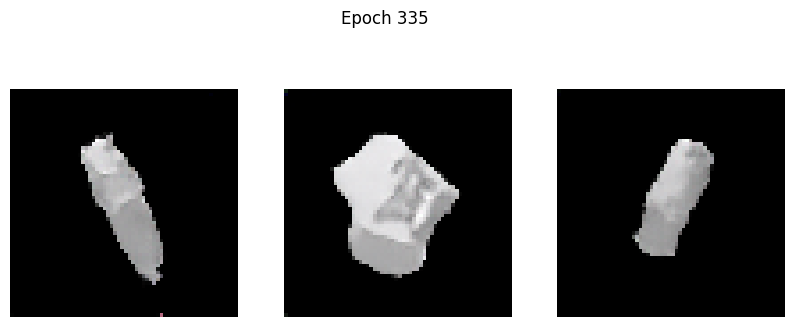

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1072 - g_loss: 4.8893
Epoch 336/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1034 - g_loss: 5.0340

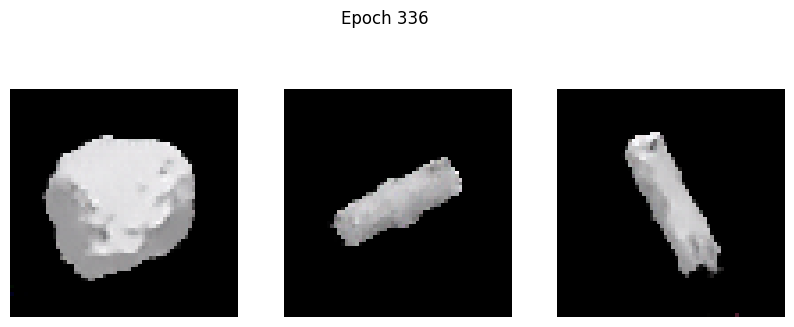

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1030 - g_loss: 5.0312
Epoch 337/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0315 - g_loss: 4.5783

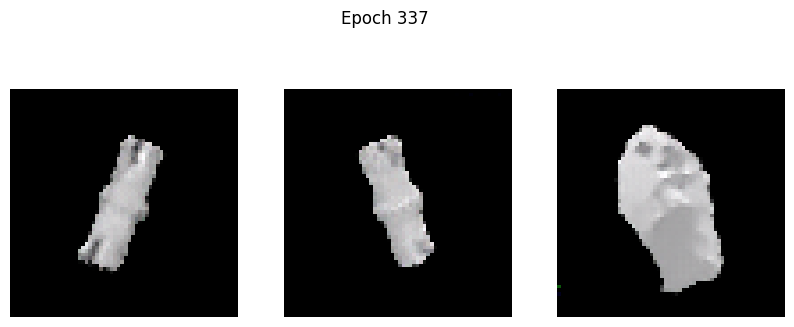

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0315 - g_loss: 4.5793
Epoch 338/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0526 - g_loss: 4.7413

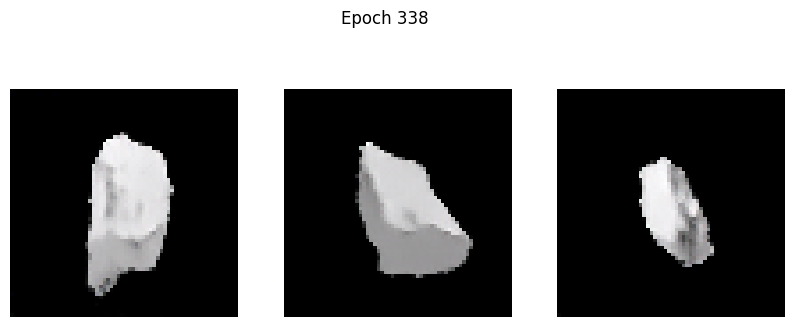

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0526 - g_loss: 4.7413
Epoch 339/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0792 - g_loss: 4.8894

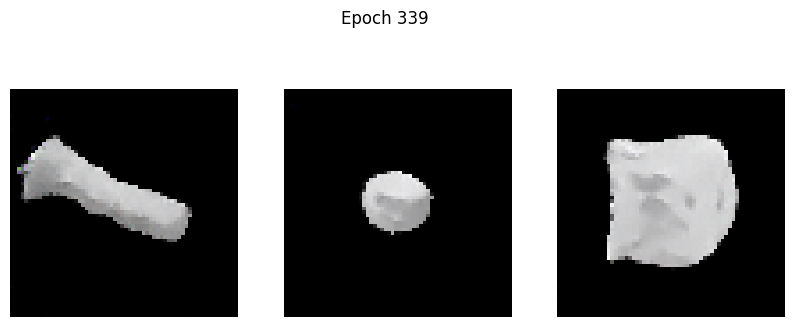

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0793 - g_loss: 4.8897
Epoch 340/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0438 - g_loss: 4.7287

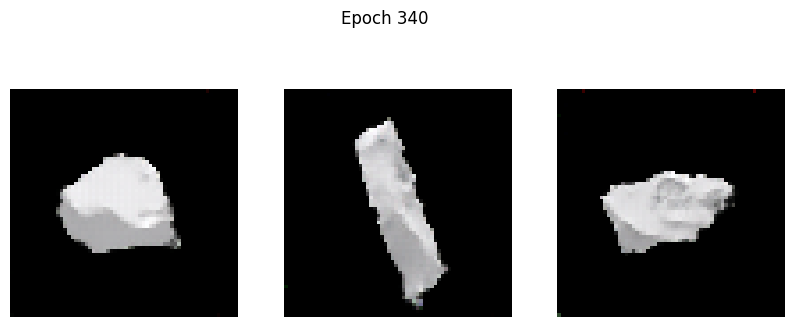

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0441 - g_loss: 4.7308
Epoch 341/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1165 - g_loss: 4.8808

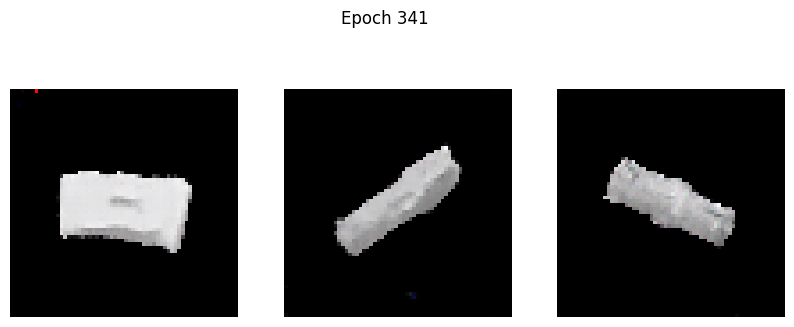

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1161 - g_loss: 4.8803
Epoch 342/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0247 - g_loss: 4.5596

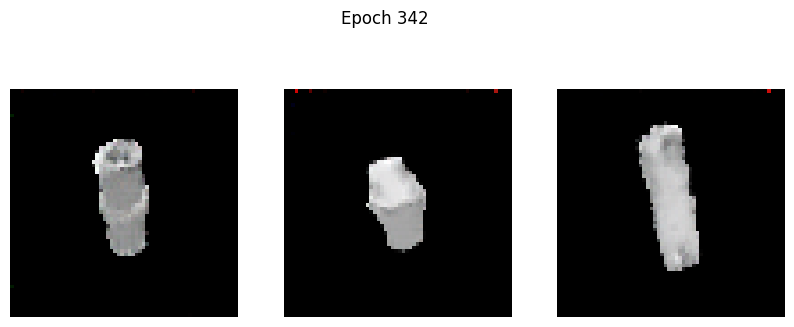

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0247 - g_loss: 4.5596
Epoch 343/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0065 - g_loss: 4.8318

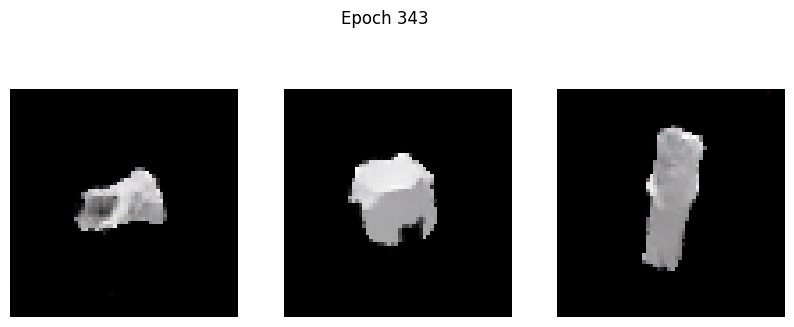

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0066 - g_loss: 4.8314
Epoch 344/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0705 - g_loss: 5.0063

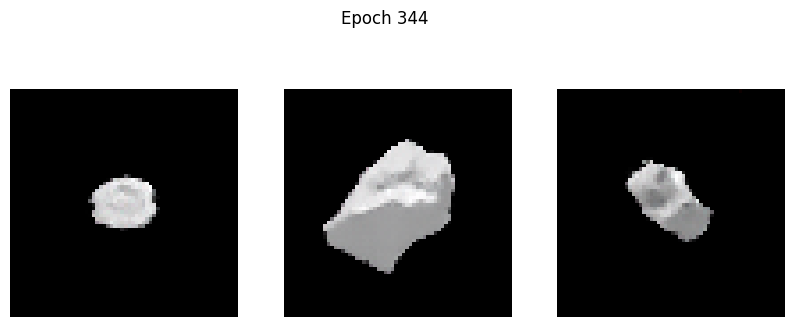

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0705 - g_loss: 5.0055
Epoch 345/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0413 - g_loss: 4.9483

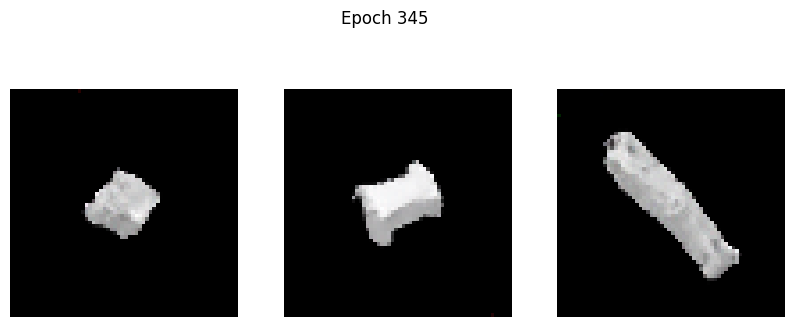

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0411 - g_loss: 4.9476
Epoch 346/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2115 - g_loss: 5.4824

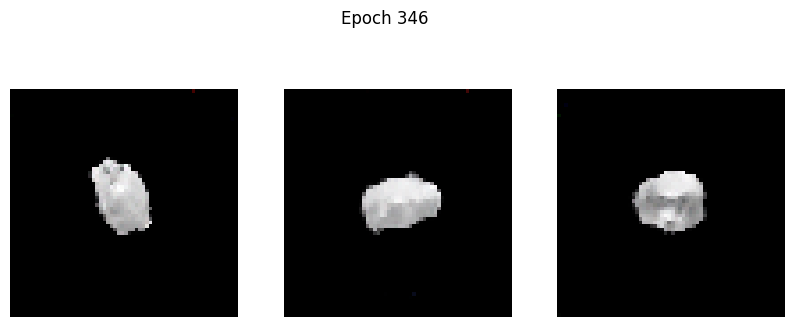

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2109 - g_loss: 5.4796
Epoch 347/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0585 - g_loss: 4.7823

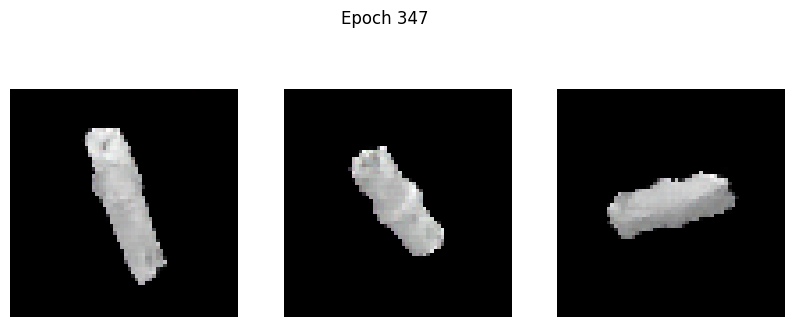

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0583 - g_loss: 4.7830
Epoch 348/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0256 - g_loss: 4.8589

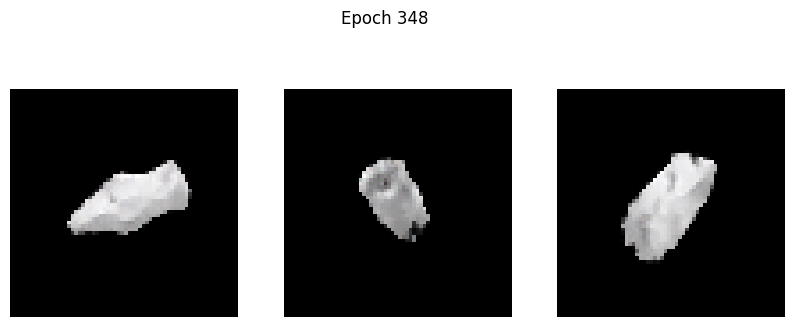

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0256 - g_loss: 4.8586
Epoch 349/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0665 - g_loss: 4.8871

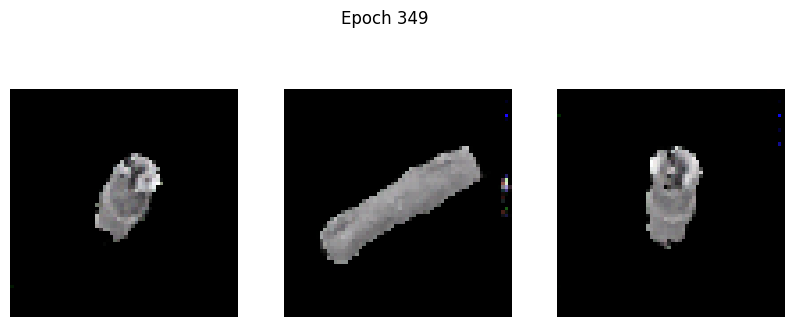

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0663 - g_loss: 4.8864
Epoch 350/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0494 - g_loss: 4.8946

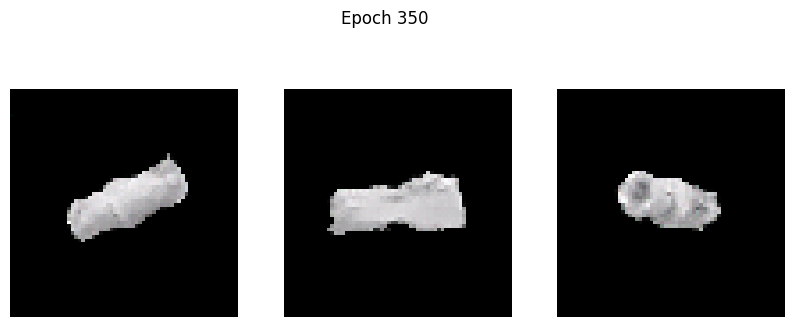

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0496 - g_loss: 4.8955
Epoch 351/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0570 - g_loss: 4.9331

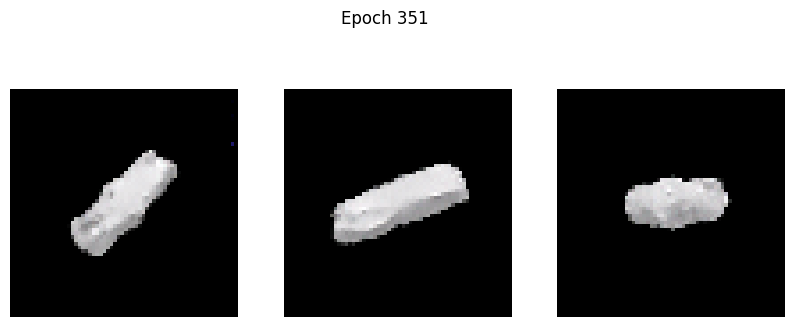

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0571 - g_loss: 4.9336
Epoch 352/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.0341 - g_loss: 4.9473

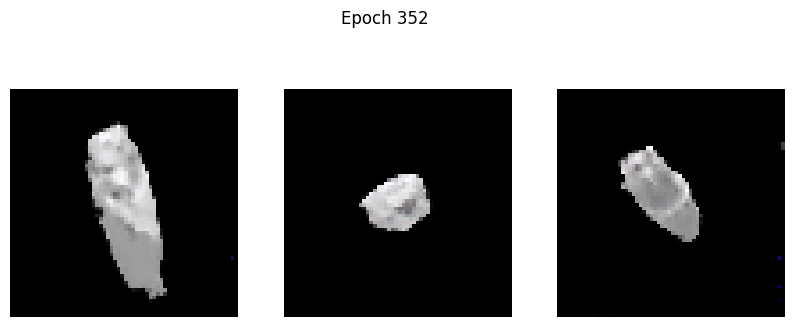

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.0341 - g_loss: 4.9474
Epoch 353/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0520 - g_loss: 5.1182

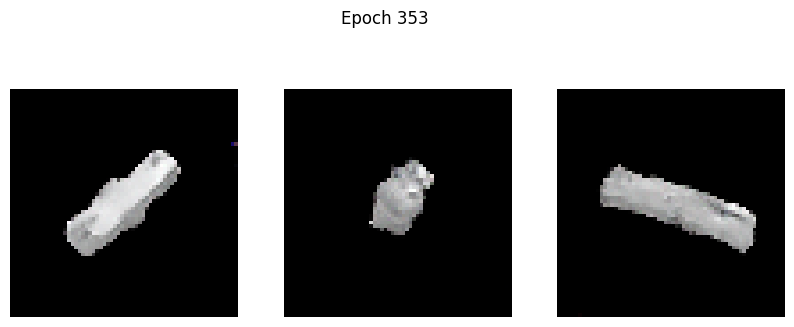

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0523 - g_loss: 5.1185
Epoch 354/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0767 - g_loss: 4.9120

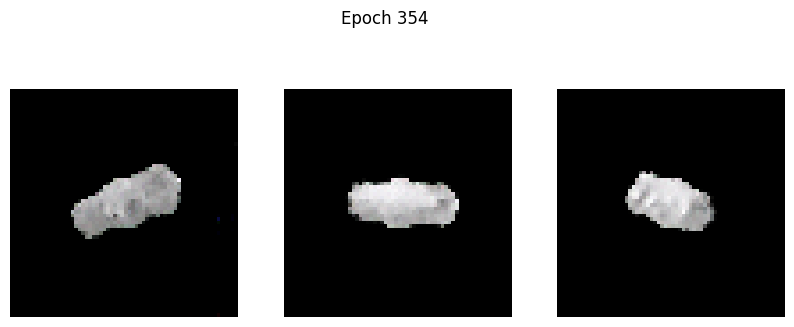

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0774 - g_loss: 4.9145
Epoch 355/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0262 - g_loss: 4.7840

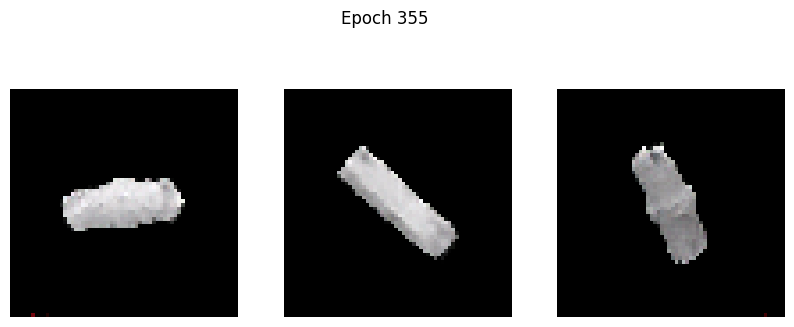

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0261 - g_loss: 4.7847
Epoch 356/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0297 - g_loss: 4.9462

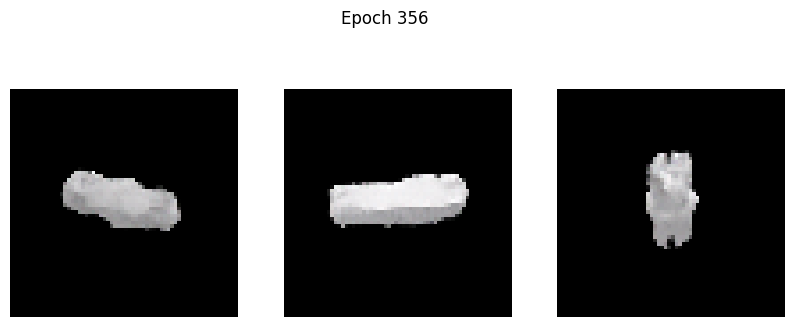

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0301 - g_loss: 4.9475
Epoch 357/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0425 - g_loss: 4.9079

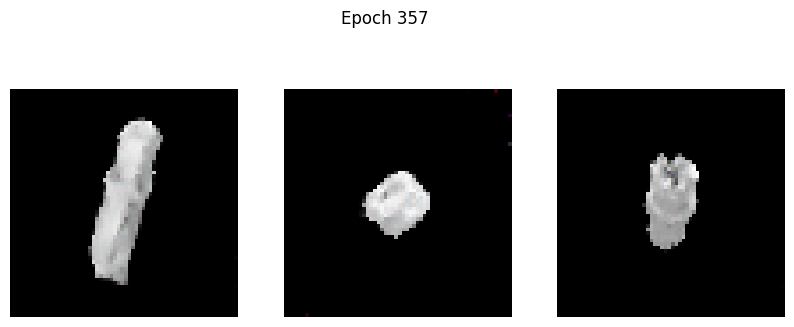

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0425 - g_loss: 4.9073
Epoch 358/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0726 - g_loss: 5.0555

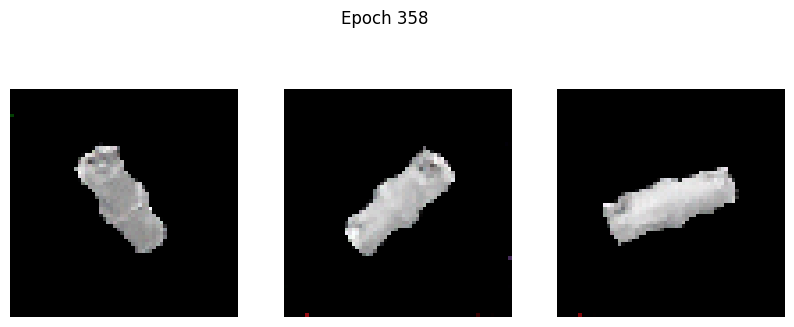

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0723 - g_loss: 5.0541
Epoch 359/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0287 - g_loss: 4.8518

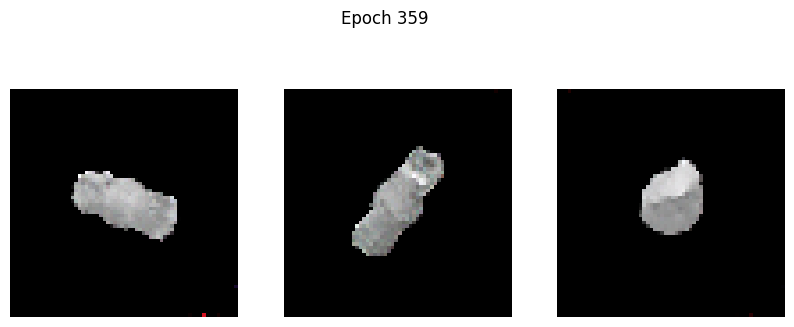

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0290 - g_loss: 4.8540
Epoch 360/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0422 - g_loss: 4.9261

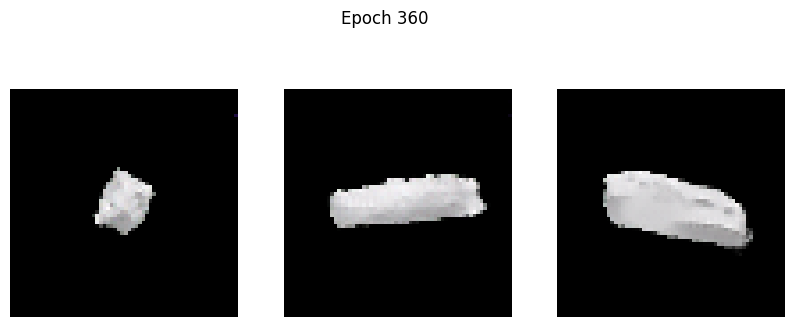

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0420 - g_loss: 4.9250
Epoch 361/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1215 - g_loss: 5.2169

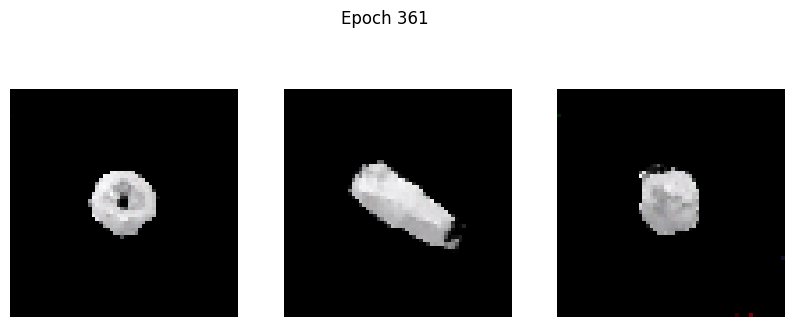

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1210 - g_loss: 5.2162
Epoch 362/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0351 - g_loss: 5.1277

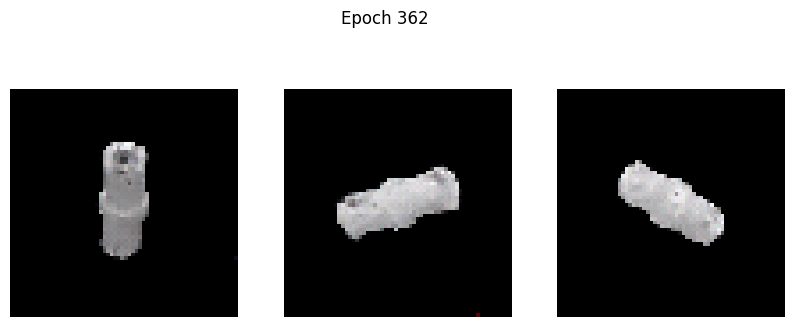

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0350 - g_loss: 5.1266
Epoch 363/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0344 - g_loss: 5.1843

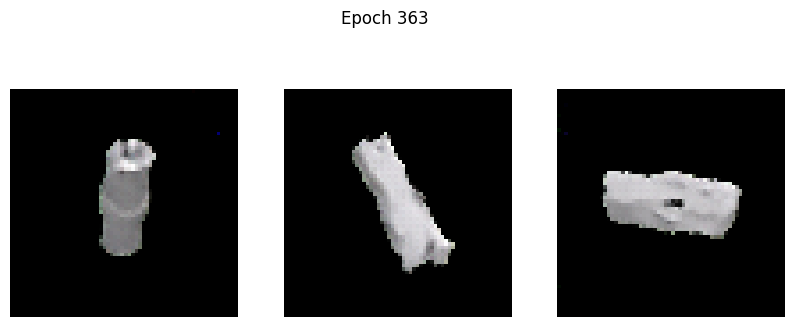

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0366 - g_loss: 5.1896
Epoch 364/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1576 - g_loss: 4.6562

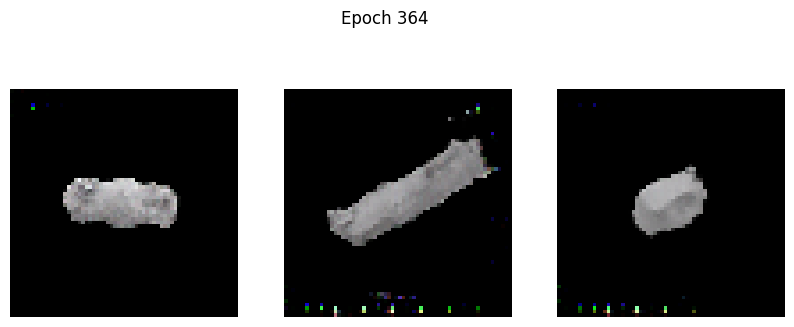

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1569 - g_loss: 4.6562
Epoch 365/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0417 - g_loss: 4.8336

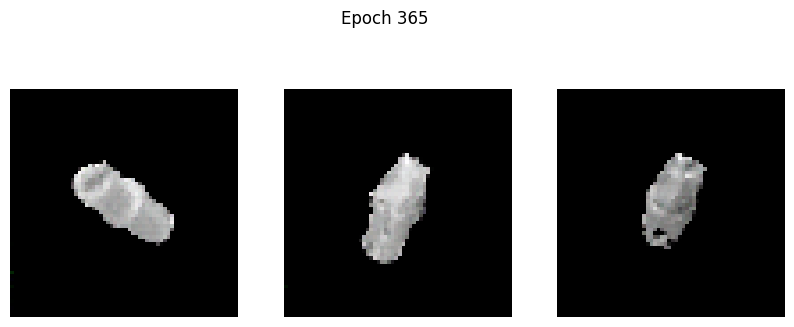

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0417 - g_loss: 4.8334
Epoch 366/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0161 - g_loss: 4.7962

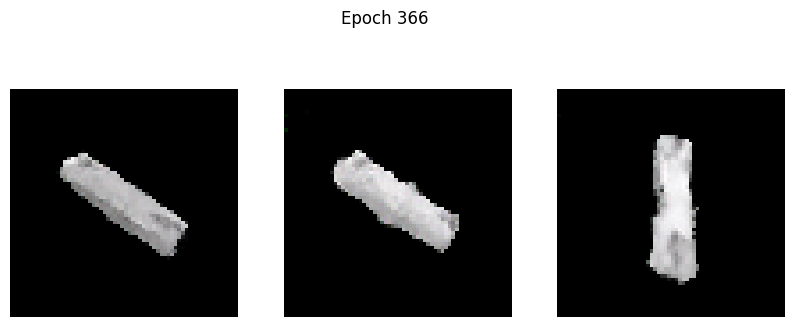

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0162 - g_loss: 4.7965
Epoch 367/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 5.9036e-04 - g_loss: 4.8442

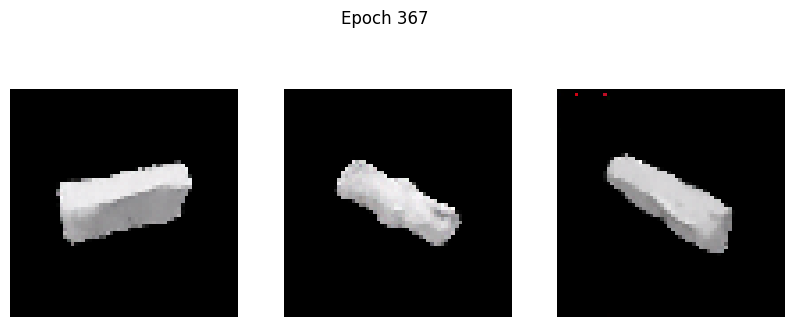

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 6.0743e-04 - g_loss: 4.8446
Epoch 368/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0024 - g_loss: 4.9110

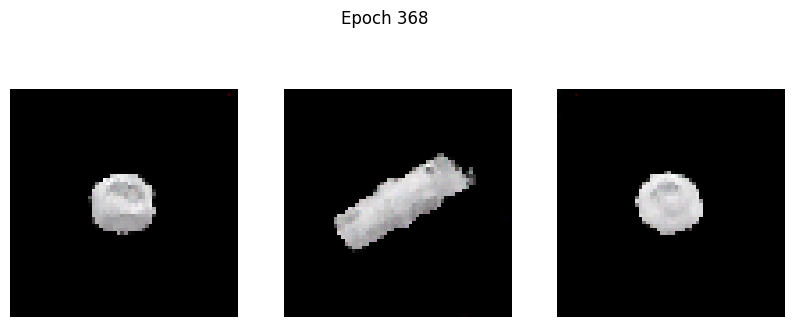

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0022 - g_loss: 4.9122
Epoch 369/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0314 - g_loss: 4.9677

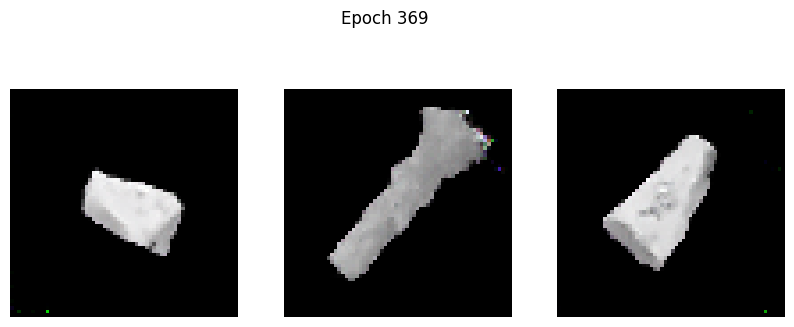

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0313 - g_loss: 4.9682
Epoch 370/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0211 - g_loss: 4.9735

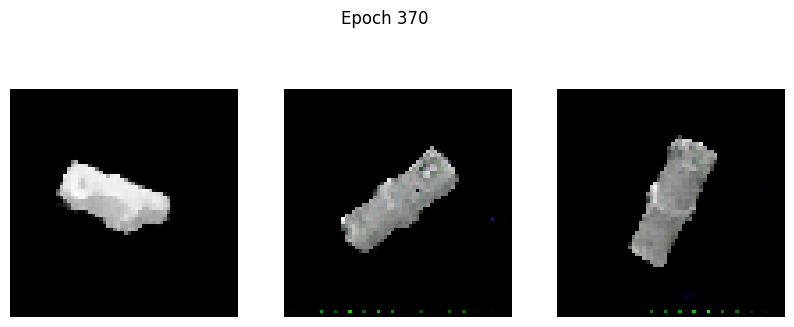

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0212 - g_loss: 4.9744
Epoch 371/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0219 - g_loss: 5.0292

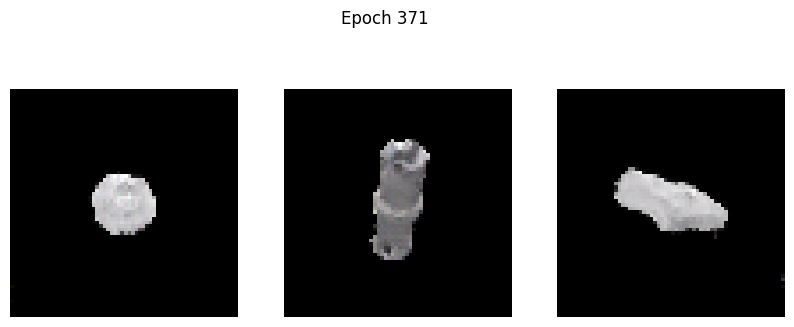

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0220 - g_loss: 5.0299
Epoch 372/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 4.0716e-04 - g_loss: 5.0215

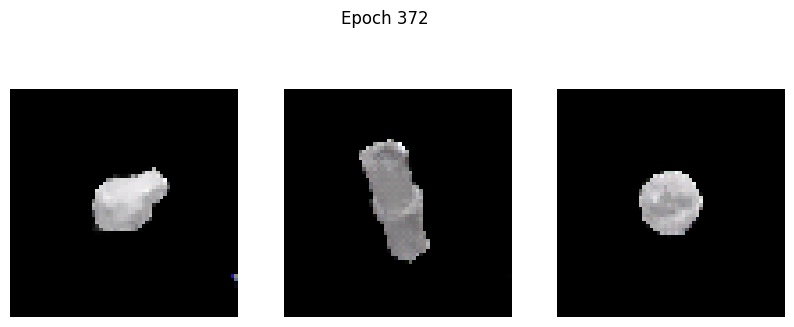

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 2.5718e-04 - g_loss: 5.0218
Epoch 373/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0708 - g_loss: 5.4438

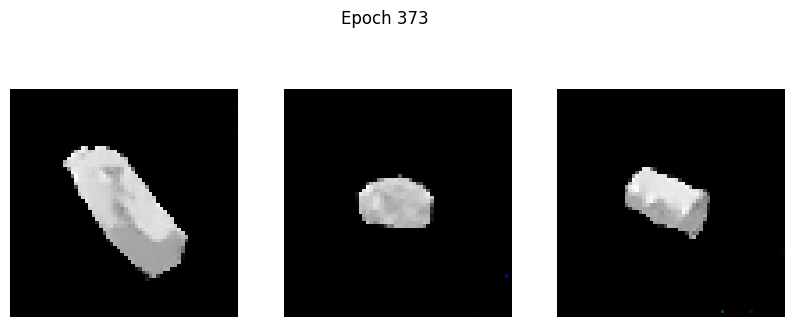

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0713 - g_loss: 5.4460
Epoch 374/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0394 - g_loss: 5.1624

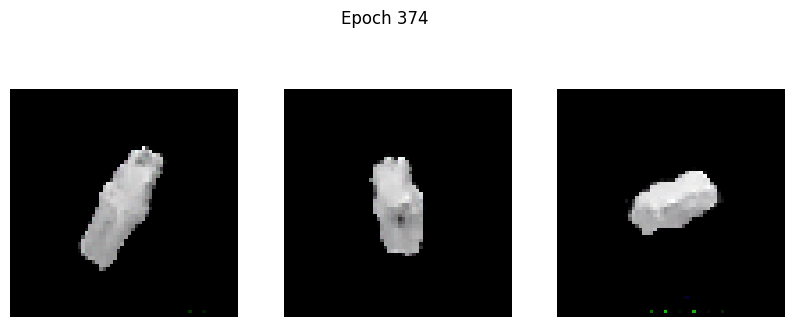

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0396 - g_loss: 5.1641
Epoch 375/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0872 - g_loss: 5.5207

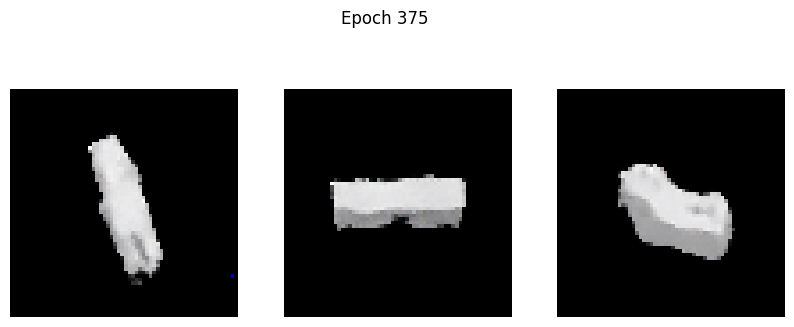

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0870 - g_loss: 5.5195
Epoch 376/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0162 - g_loss: 5.0641

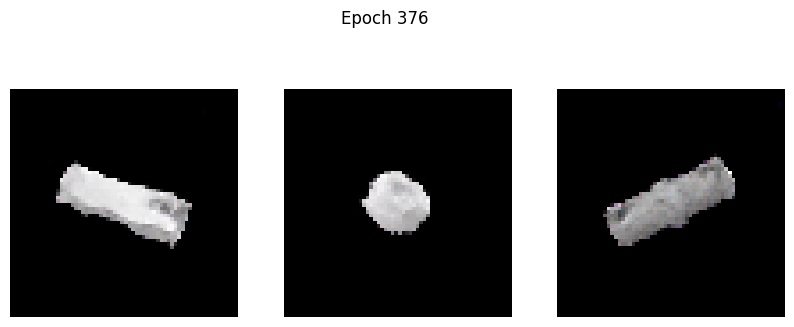

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0163 - g_loss: 5.0657
Epoch 377/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0081 - g_loss: 5.1278

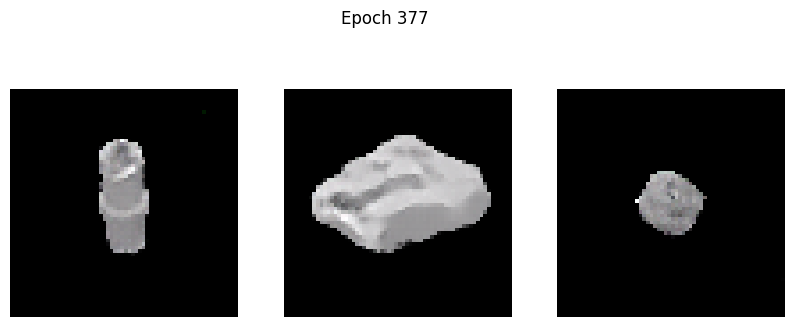

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0082 - g_loss: 5.1277
Epoch 378/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0316 - g_loss: 5.3754

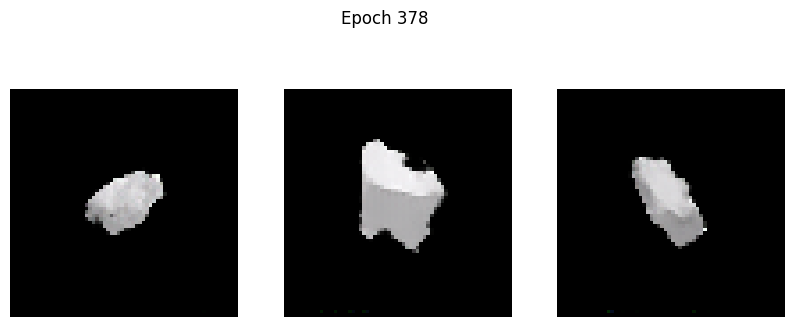

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0318 - g_loss: 5.3766
Epoch 379/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1037 - g_loss: 5.4397

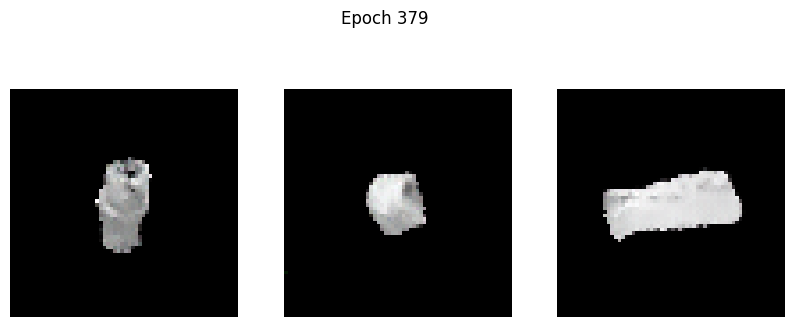

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1033 - g_loss: 5.4382
Epoch 380/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0175 - g_loss: 5.0920

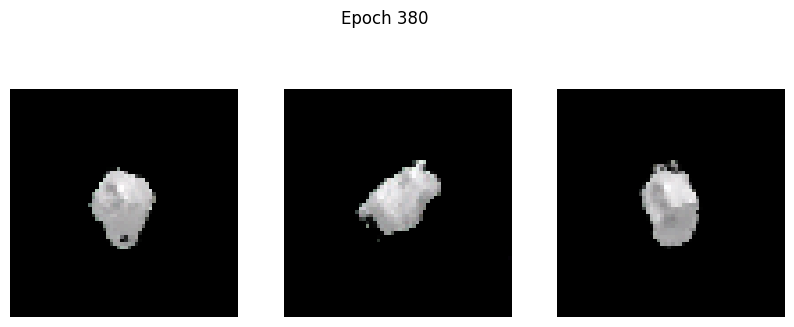

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0176 - g_loss: 5.0930
Epoch 381/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0327 - g_loss: 5.6389

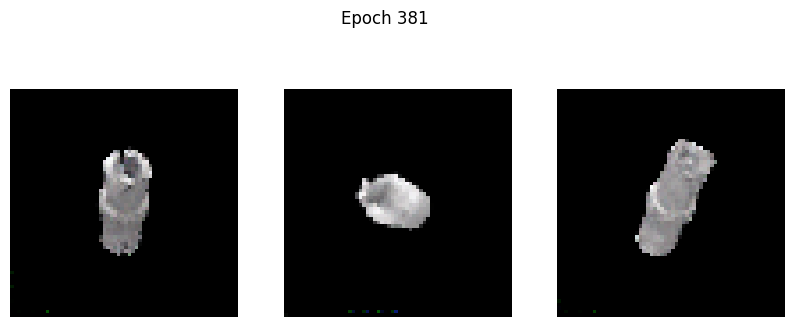

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0327 - g_loss: 5.6367
Epoch 382/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0069 - g_loss: 5.3832

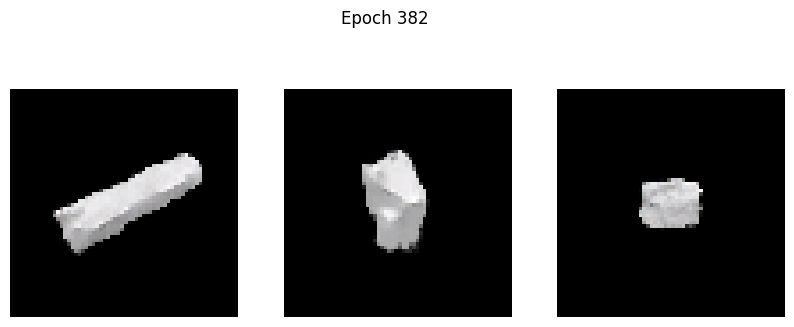

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0069 - g_loss: 5.3823
Epoch 383/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0909 - g_loss: 5.5318

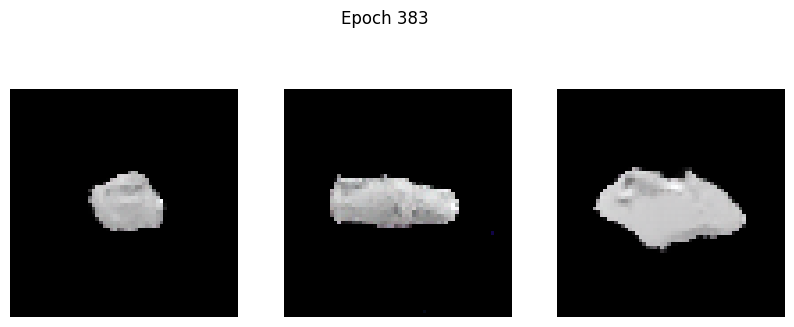

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0908 - g_loss: 5.5314
Epoch 384/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0317 - g_loss: 5.2828

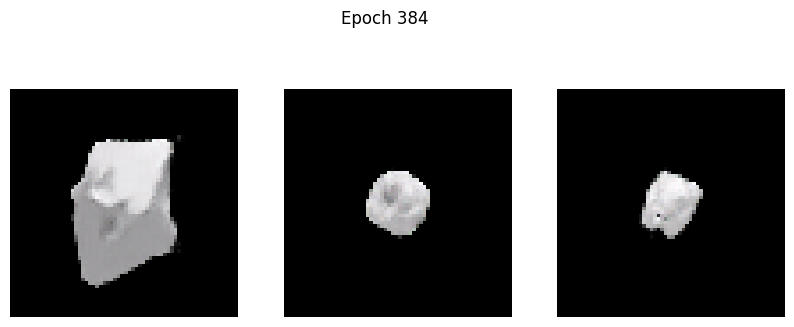

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0316 - g_loss: 5.2828
Epoch 385/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0027 - g_loss: 5.3420

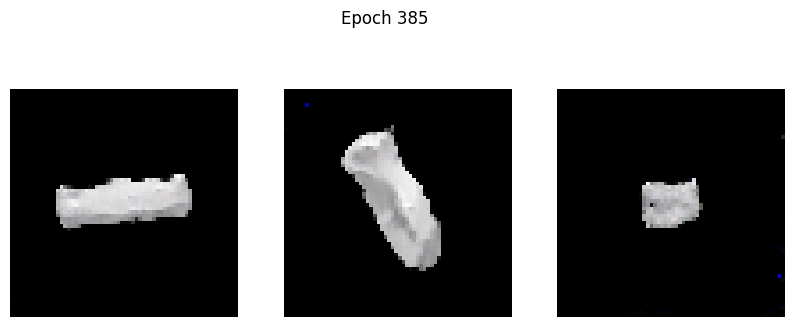

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0028 - g_loss: 5.3419
Epoch 386/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0208 - g_loss: 5.3768

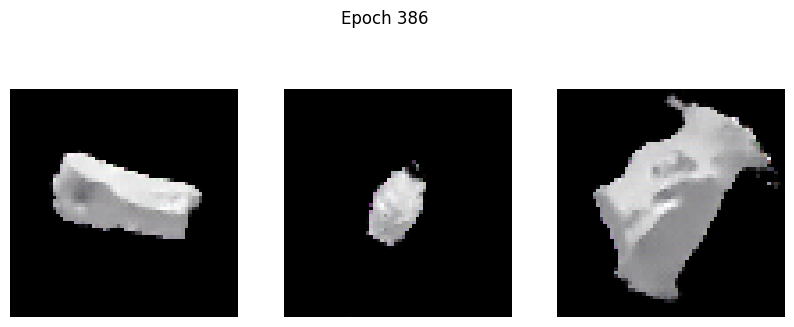

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0222 - g_loss: 5.3791
Epoch 387/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0857 - g_loss: 4.8531

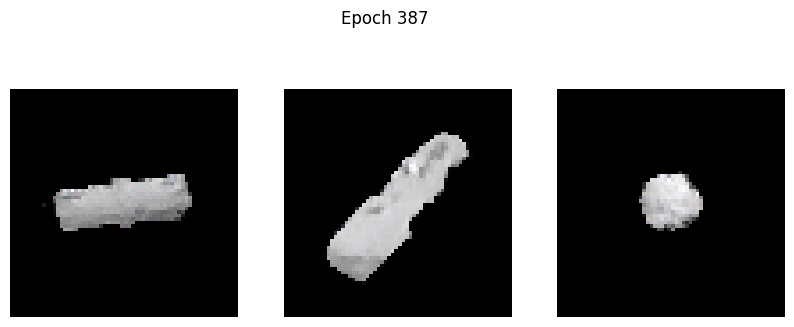

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0853 - g_loss: 4.8543
Epoch 388/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0131 - g_loss: 5.0346

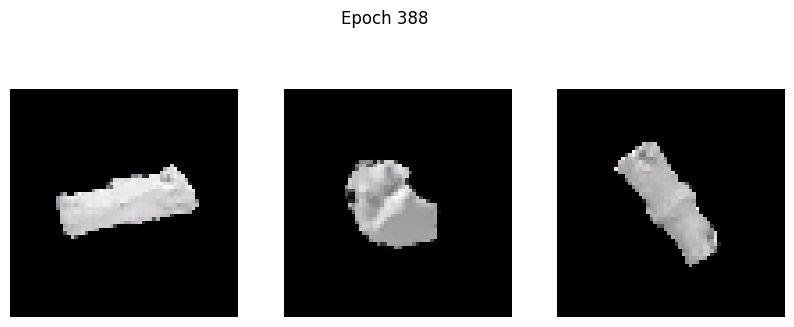

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0130 - g_loss: 5.0355
Epoch 389/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0356 - g_loss: 5.3379

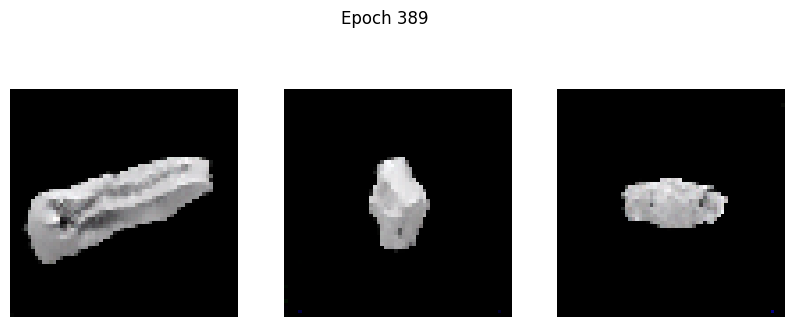

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0358 - g_loss: 5.3388
Epoch 390/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0375 - g_loss: 5.4519

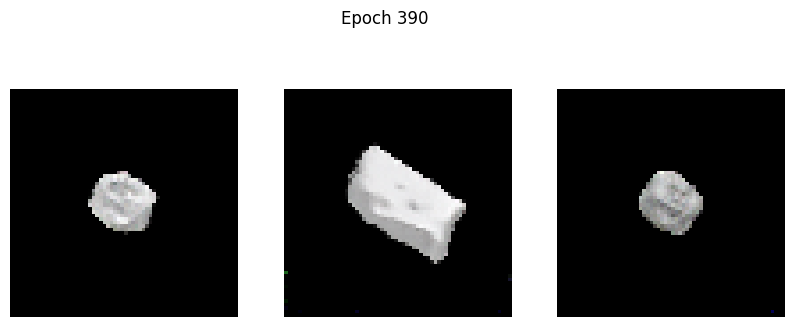

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0374 - g_loss: 5.4502
Epoch 391/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0279 - g_loss: 5.2711

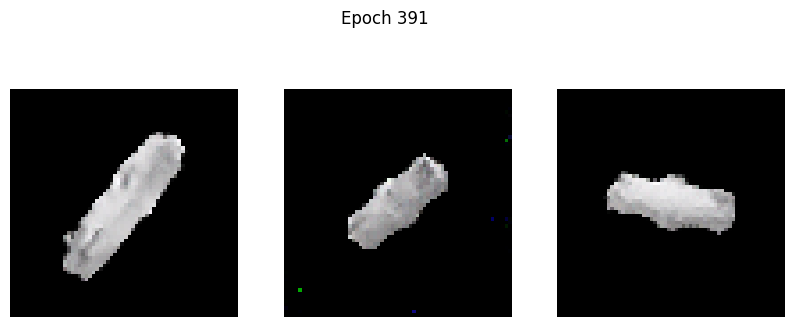

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0280 - g_loss: 5.2727
Epoch 392/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0031 - g_loss: 5.3444

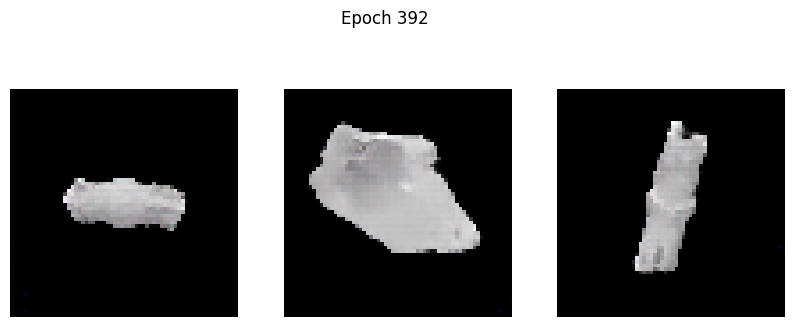

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0029 - g_loss: 5.3453
Epoch 393/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0410 - g_loss: 5.4990

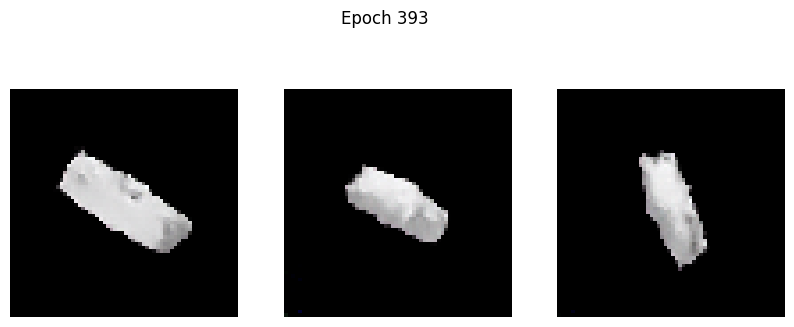

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0407 - g_loss: 5.4978
Epoch 394/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0543 - g_loss: 5.6380

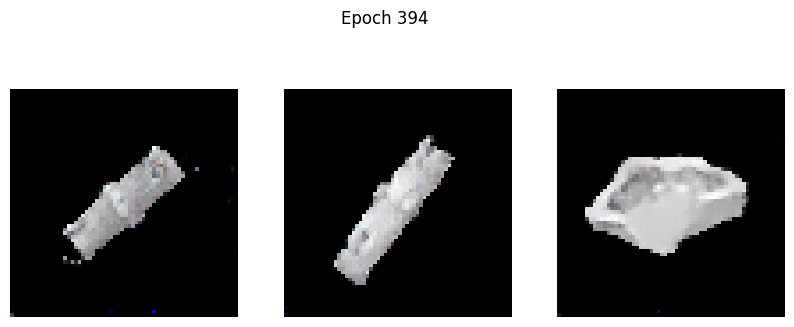

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.0543 - g_loss: 5.6377
Epoch 395/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0800 - g_loss: 5.8870

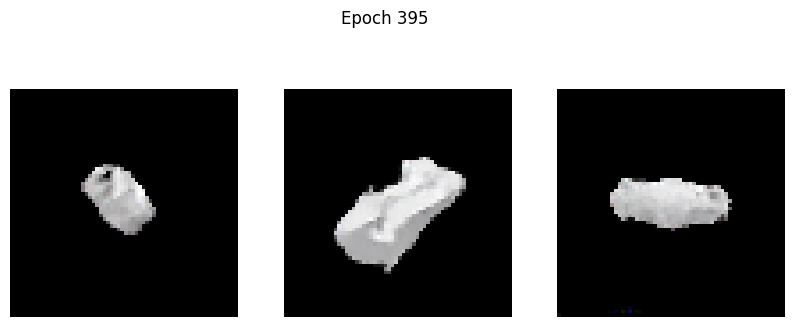

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0795 - g_loss: 5.8825
Epoch 396/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0057 - g_loss: 5.3017

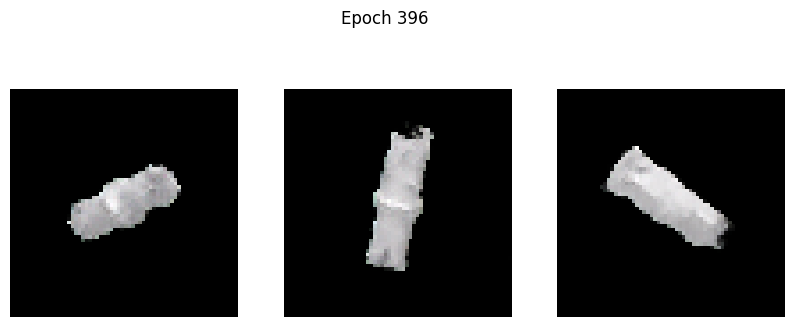

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0048 - g_loss: 5.3039
Epoch 397/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.3508 - g_loss: 6.2299

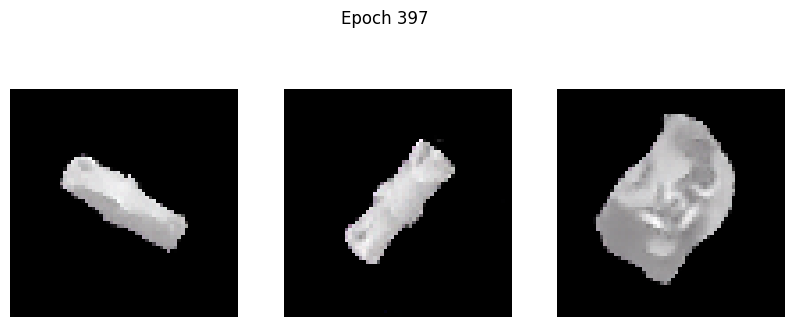

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.3489 - g_loss: 6.2233
Epoch 398/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0065 - g_loss: 5.3122

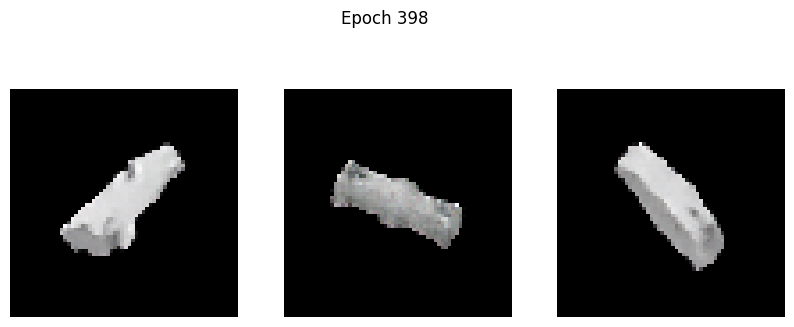

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0065 - g_loss: 5.3117
Epoch 399/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0111 - g_loss: 5.3391

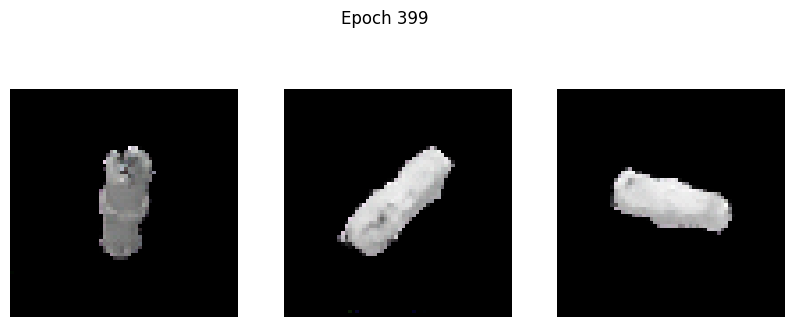

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0112 - g_loss: 5.3391
Epoch 400/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0054 - g_loss: 5.3827

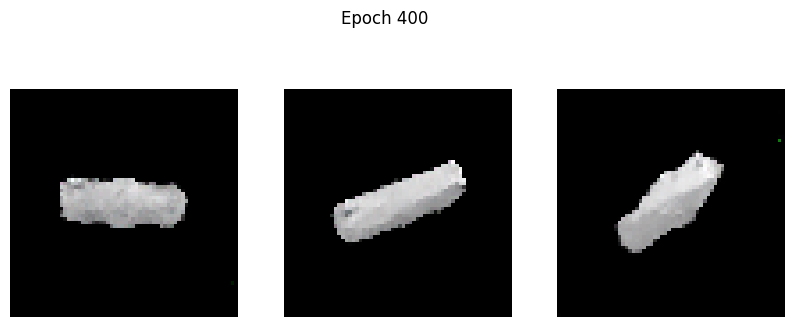

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0056 - g_loss: 5.3842
Epoch 401/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.0169 - g_loss: 5.5139

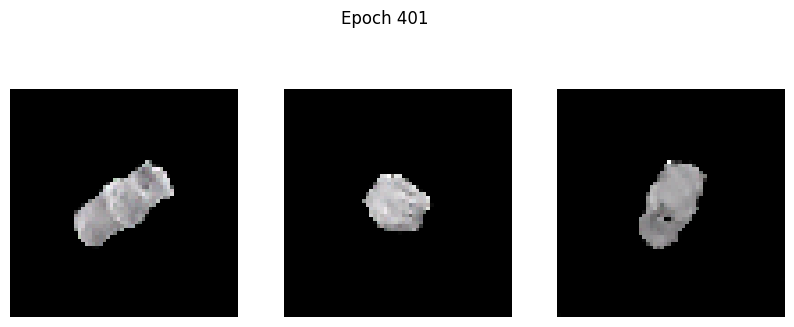

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.0167 - g_loss: 5.5122
Epoch 402/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0212 - g_loss: 5.4345

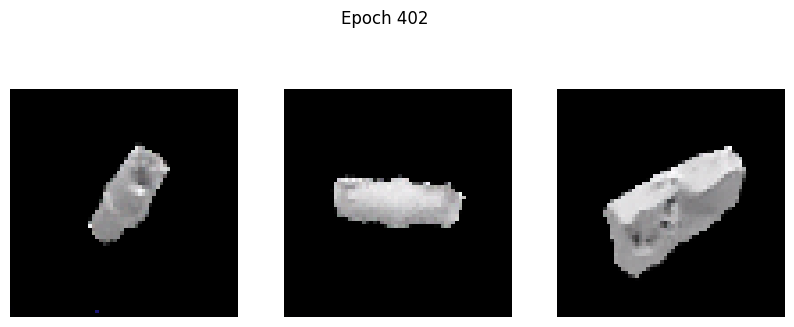

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - d_loss: 0.0211 - g_loss: 5.4346
Epoch 403/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: -0.0193 - g_loss: 5.1780

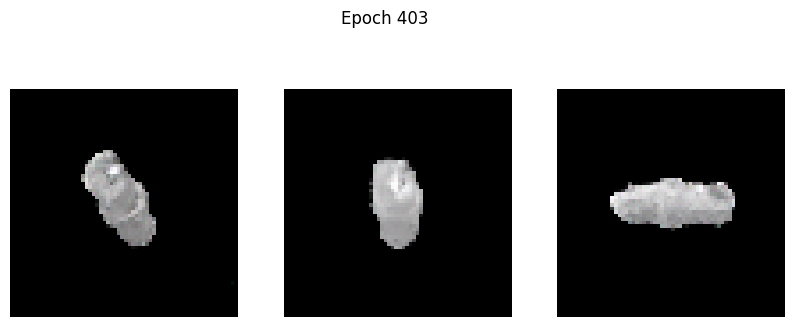

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: -0.0190 - g_loss: 5.1811
Epoch 404/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.0326 - g_loss: 5.3610

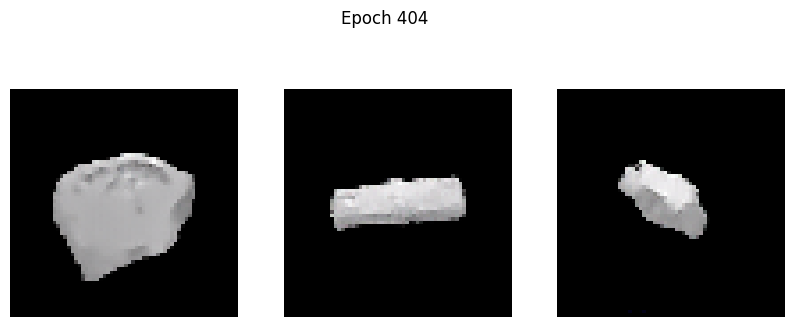

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.0323 - g_loss: 5.3611
Epoch 405/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0357 - g_loss: 5.6430

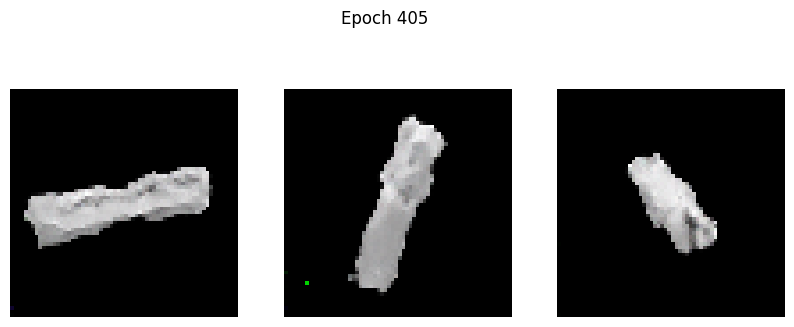

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0356 - g_loss: 5.6427
Epoch 406/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0163 - g_loss: 5.4163

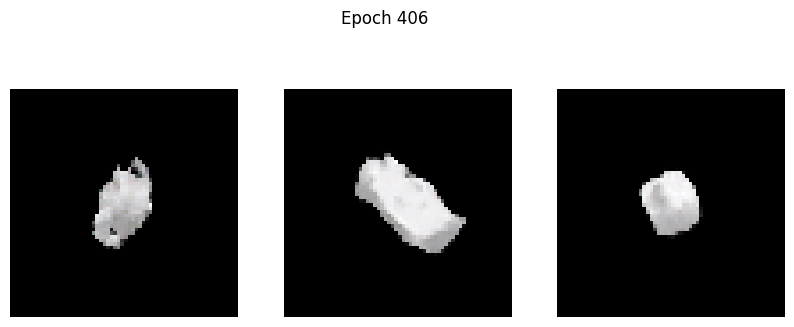

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0163 - g_loss: 5.4167
Epoch 407/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.4108 - g_loss: 6.6827

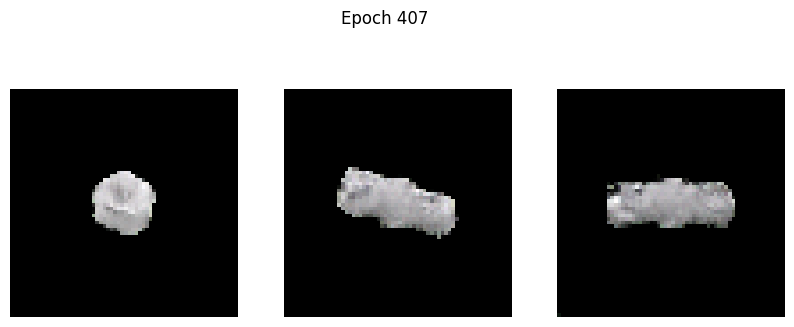

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.4127 - g_loss: 6.6860
Epoch 408/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0161 - g_loss: 4.8870

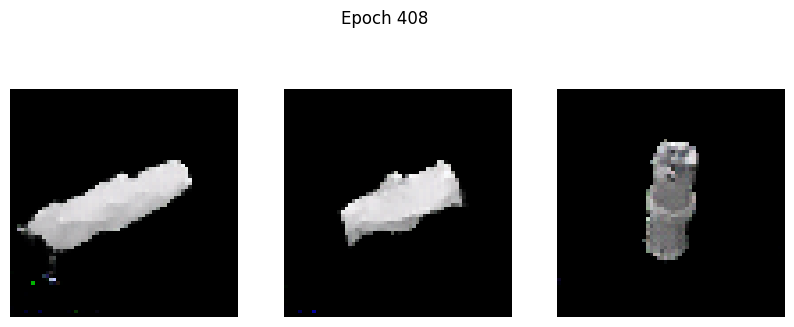

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0161 - g_loss: 4.8865
Epoch 409/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0075 - g_loss: 5.1588

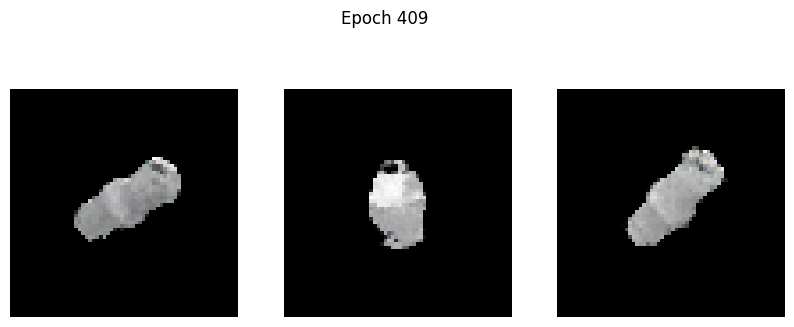

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0078 - g_loss: 5.1608
Epoch 410/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0199 - g_loss: 5.2845

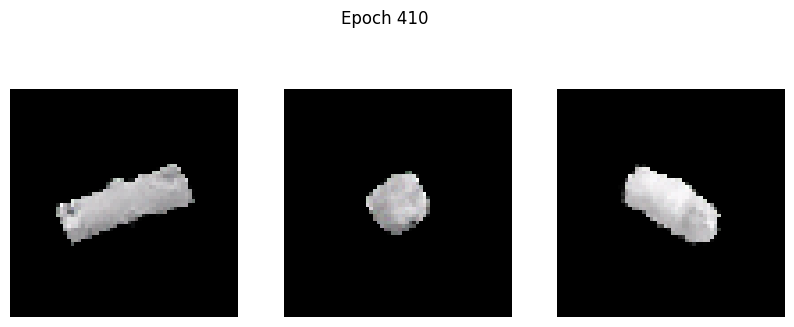

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0199 - g_loss: 5.2840
Epoch 411/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0199 - g_loss: 5.3012

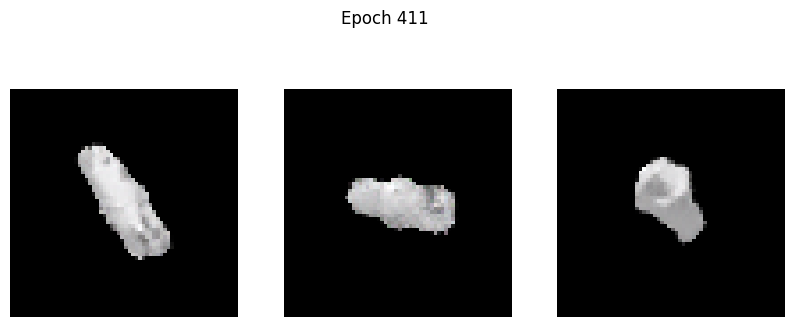

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0197 - g_loss: 5.3015
Epoch 412/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0100 - g_loss: 5.3729

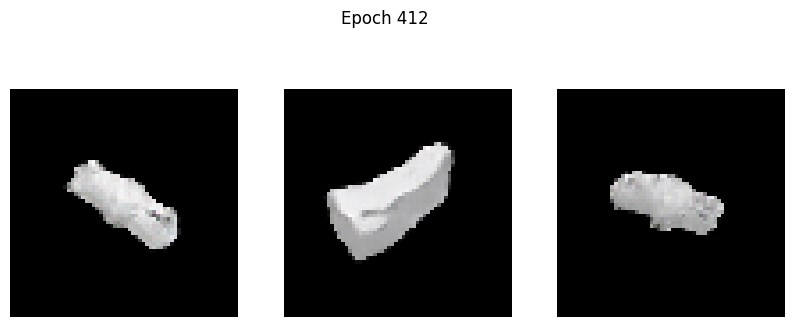

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0098 - g_loss: 5.3718
Epoch 413/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0252 - g_loss: 5.2946

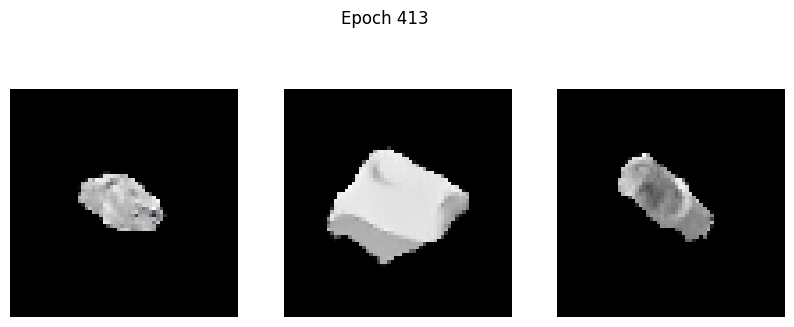

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0251 - g_loss: 5.2944
Epoch 414/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0021 - g_loss: 5.5102

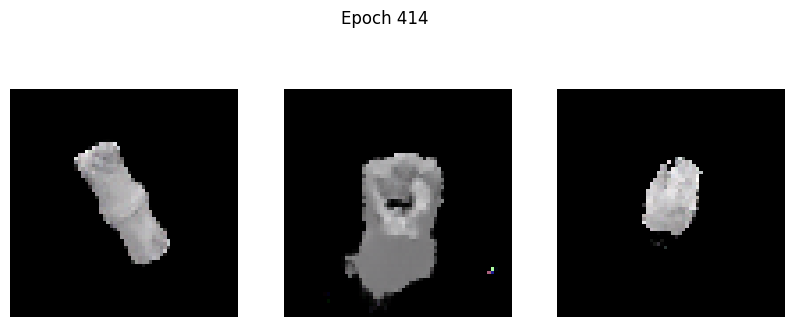

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0024 - g_loss: 5.5115
Epoch 415/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0112 - g_loss: 5.4729

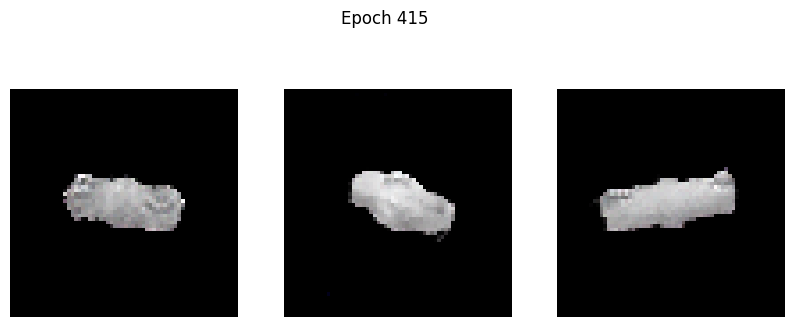

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0109 - g_loss: 5.4743
Epoch 416/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0155 - g_loss: 5.8115

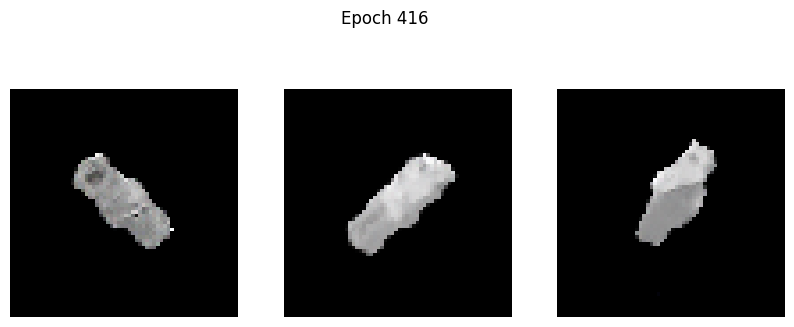

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0155 - g_loss: 5.8125
Epoch 417/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0489 - g_loss: 5.5639

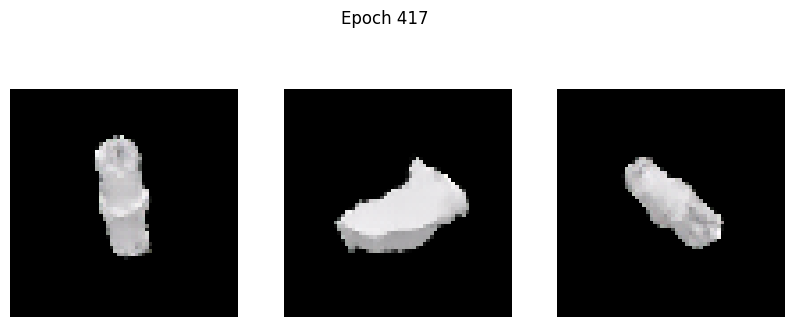

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0485 - g_loss: 5.5660
Epoch 418/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0092 - g_loss: 5.5355

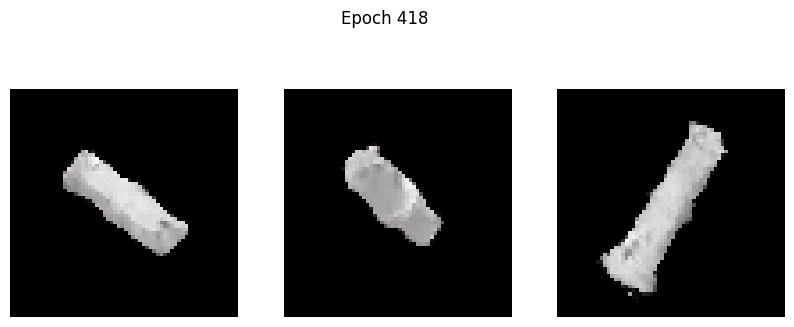

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0091 - g_loss: 5.5356
Epoch 419/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0284 - g_loss: 5.5656

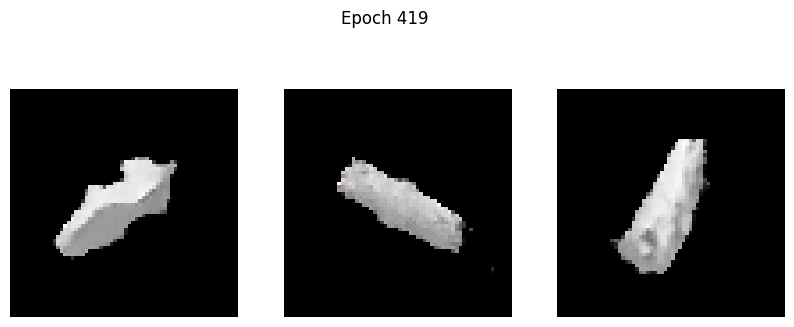

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0283 - g_loss: 5.5661
Epoch 420/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0207 - g_loss: 5.7770

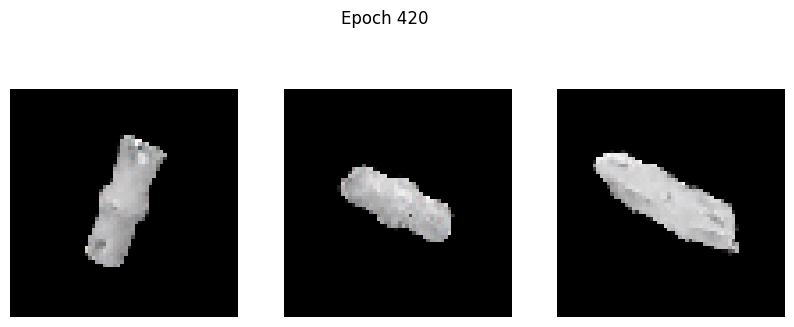

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0205 - g_loss: 5.7759
Epoch 421/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0637 - g_loss: 6.2494

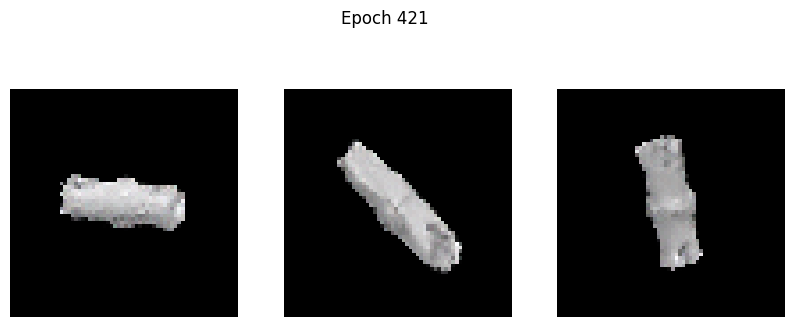

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0635 - g_loss: 6.2473
Epoch 422/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0079 - g_loss: 5.7231

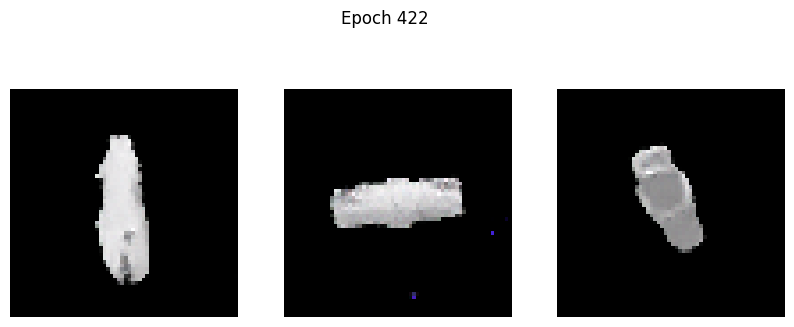

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0080 - g_loss: 5.7219
Epoch 423/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1031 - g_loss: 6.5590

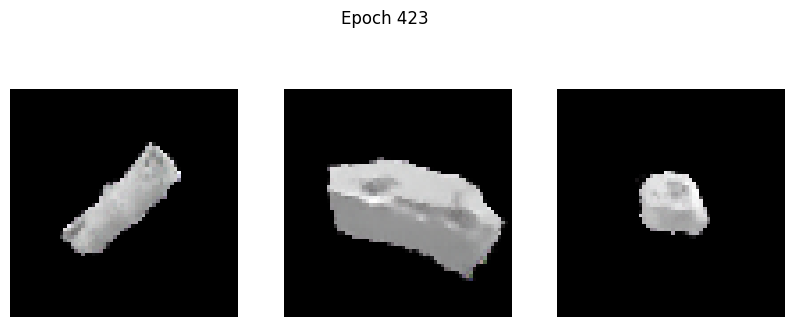

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1024 - g_loss: 6.5536
Epoch 424/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0100 - g_loss: 5.6404

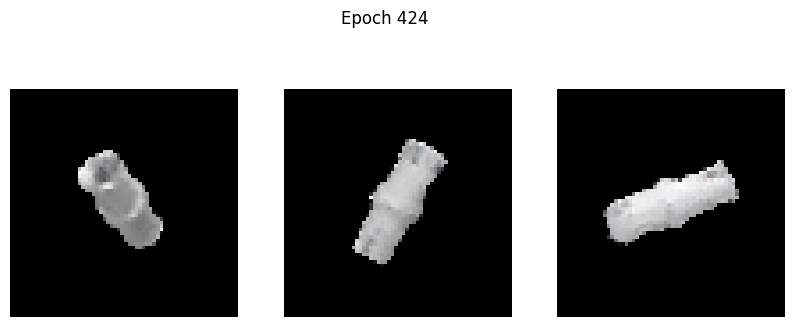

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0101 - g_loss: 5.6415
Epoch 425/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0224 - g_loss: 5.7112

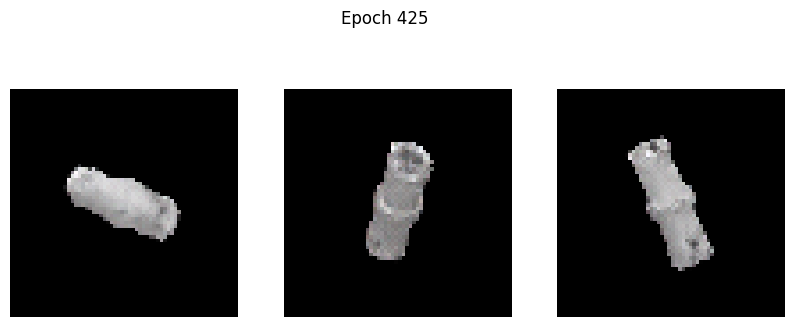

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - d_loss: -0.0221 - g_loss: 5.7119
Epoch 426/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.0220 - g_loss: 5.9653

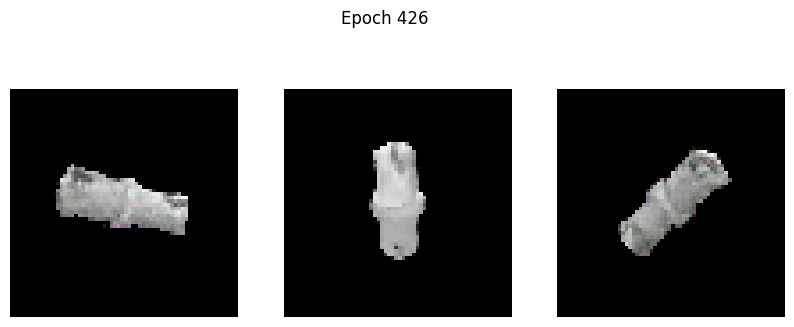

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.0226 - g_loss: 5.9671
Epoch 427/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.0037 - g_loss: 5.6655

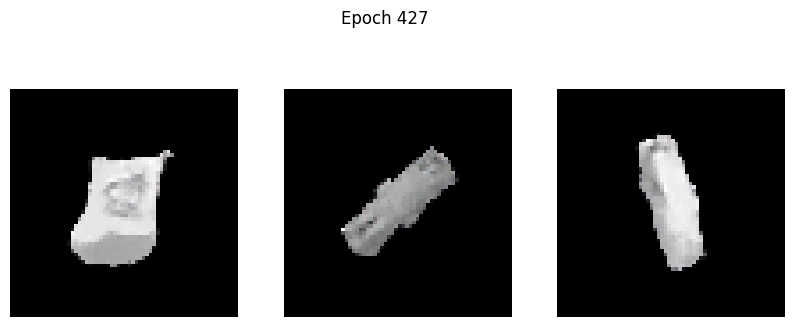

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.0041 - g_loss: 5.6679
Epoch 428/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0134 - g_loss: 5.8314

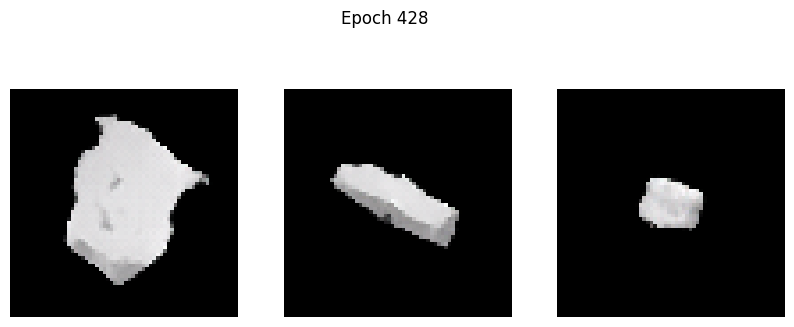

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - d_loss: 0.0132 - g_loss: 5.8305
Epoch 429/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0196 - g_loss: 5.4858

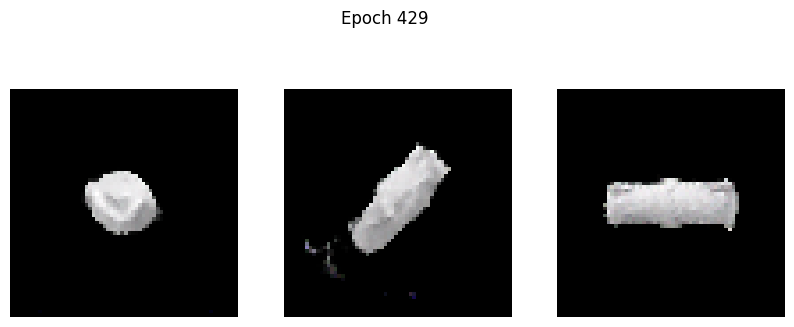

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0194 - g_loss: 5.4872
Epoch 430/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0153 - g_loss: 5.6039

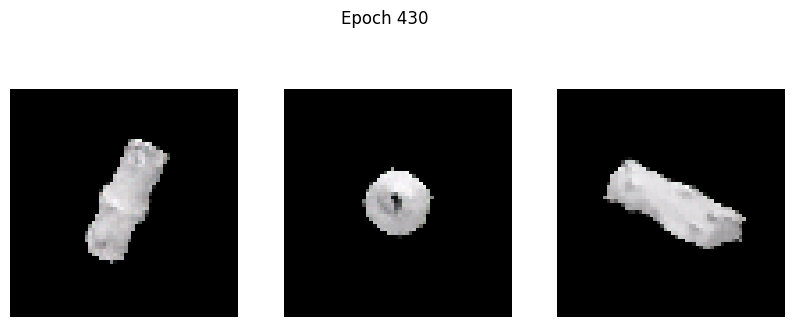

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0153 - g_loss: 5.6042
Epoch 431/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0141 - g_loss: 6.1668

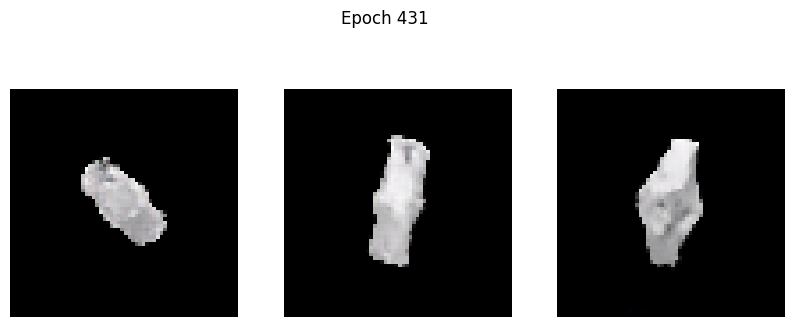

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0139 - g_loss: 6.1649
Epoch 432/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0011 - g_loss: 6.1569

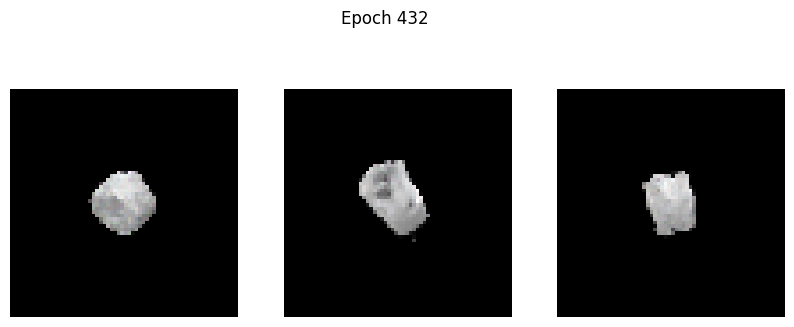

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -9.3414e-04 - g_loss: 6.1552
Epoch 433/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -8.4535e-04 - g_loss: 5.7508

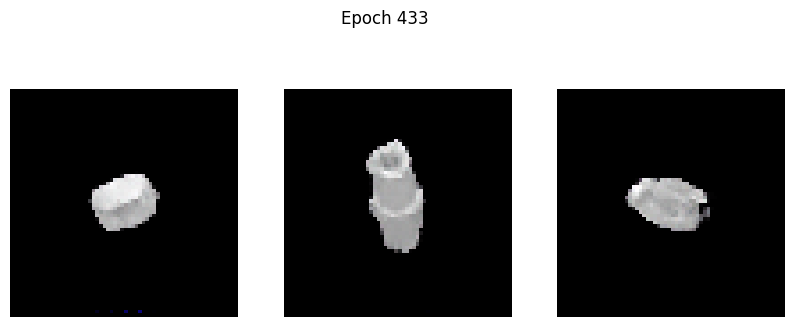

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -8.1279e-04 - g_loss: 5.7519
Epoch 434/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0373 - g_loss: 5.7931

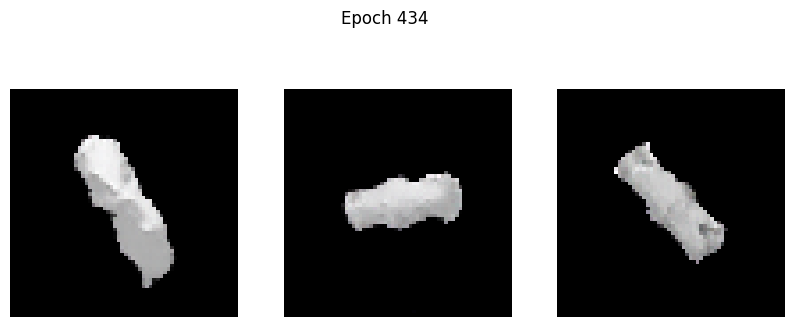

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0374 - g_loss: 5.7923
Epoch 435/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0194 - g_loss: 5.8263

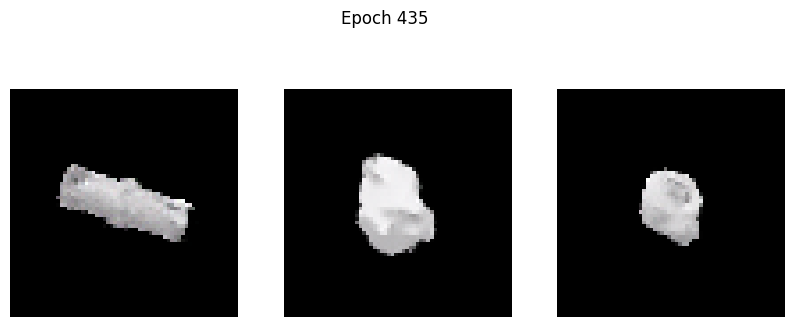

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0195 - g_loss: 5.8247
Epoch 436/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0067 - g_loss: 6.3508

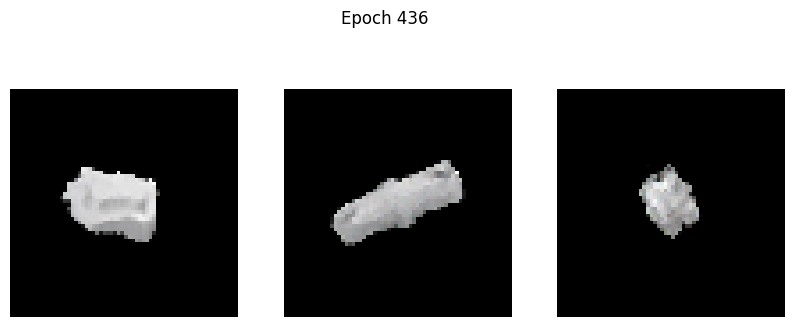

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0068 - g_loss: 6.3489
Epoch 437/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1887 - g_loss: 6.6920

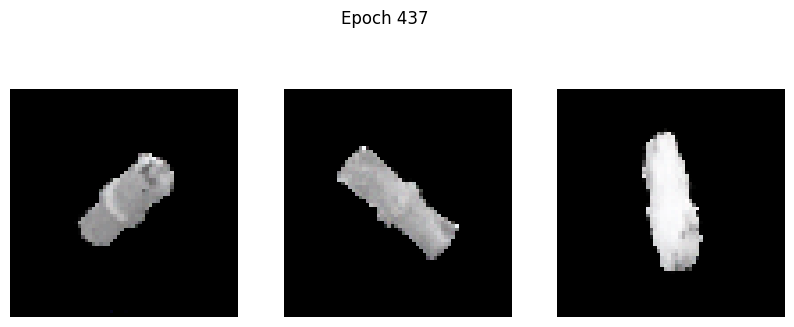

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1876 - g_loss: 6.6861
Epoch 438/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0443 - g_loss: 5.8481

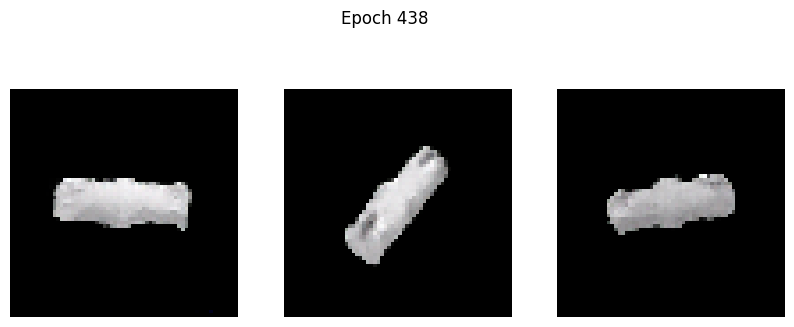

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0443 - g_loss: 5.8487
Epoch 439/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0292 - g_loss: 5.8000

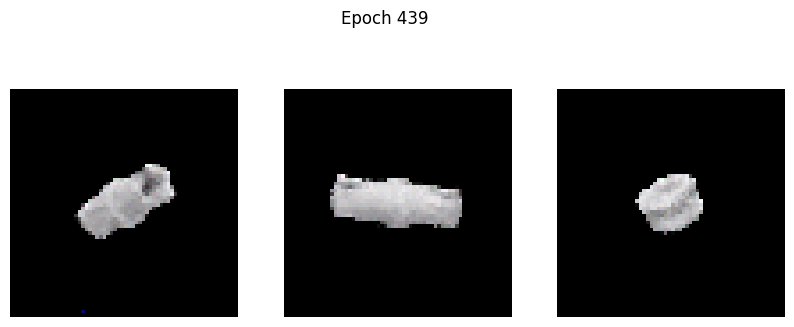

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0291 - g_loss: 5.8008
Epoch 440/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0540 - g_loss: 6.4099

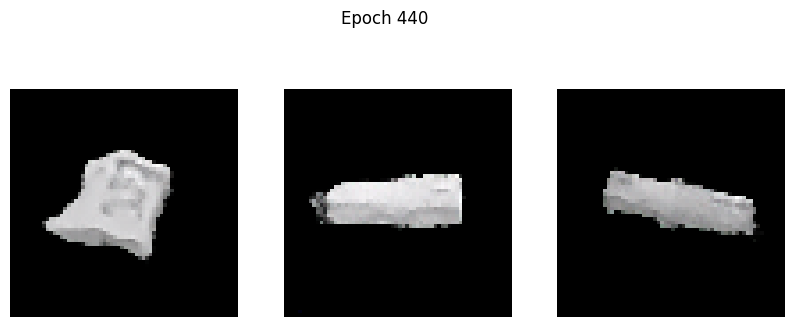

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0539 - g_loss: 6.4082
Epoch 441/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0228 - g_loss: 6.4748

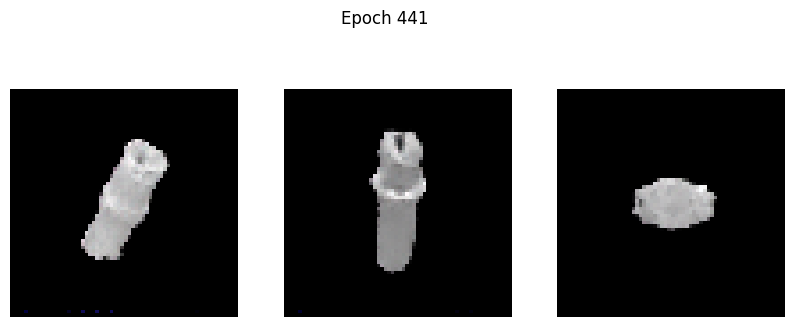

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0226 - g_loss: 6.4716
Epoch 442/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0342 - g_loss: 6.2584

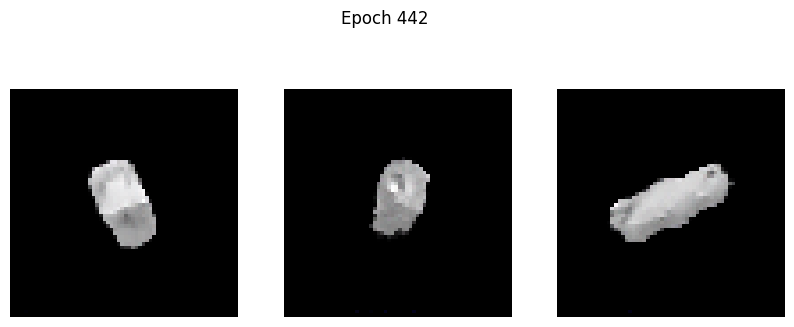

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0342 - g_loss: 6.2563
Epoch 443/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0361 - g_loss: 6.4490

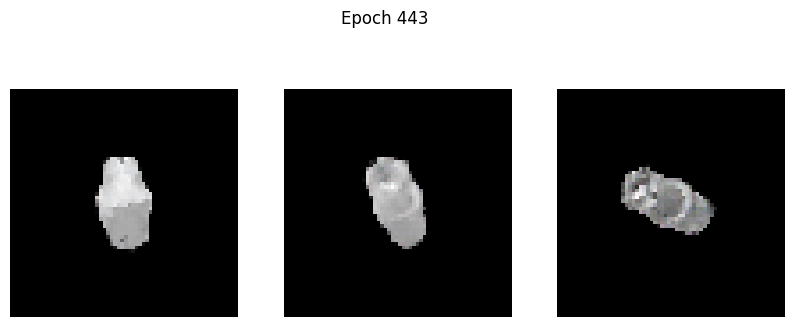

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0360 - g_loss: 6.4479
Epoch 444/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0135 - g_loss: 6.0694

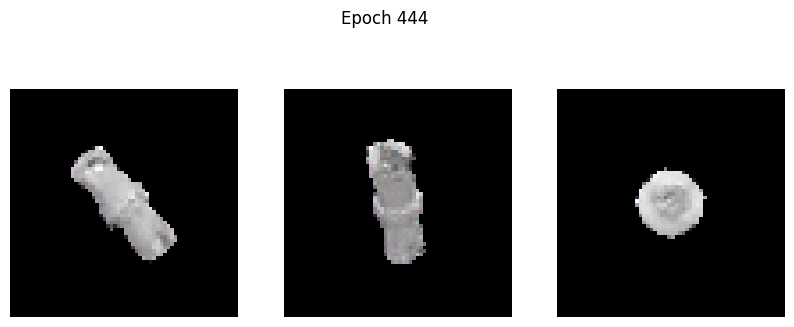

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0133 - g_loss: 6.0710
Epoch 445/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0234 - g_loss: 6.4285

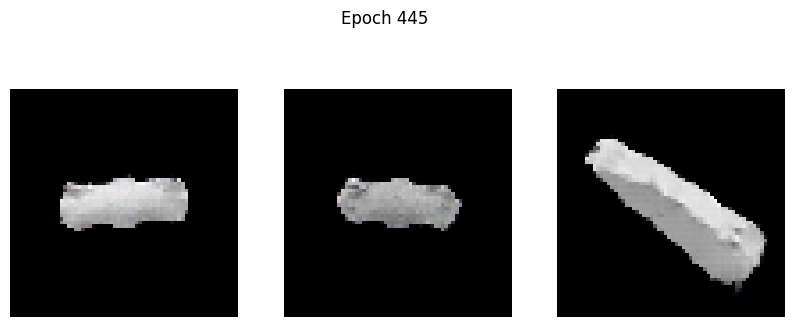

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0231 - g_loss: 6.4256
Epoch 446/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0380 - g_loss: 5.9892

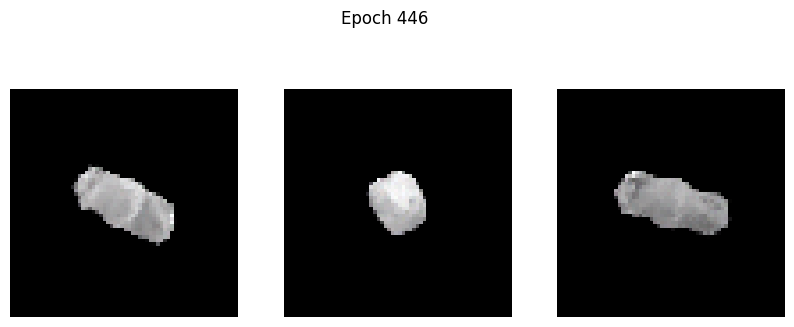

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0378 - g_loss: 5.9907
Epoch 447/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0095 - g_loss: 6.2945

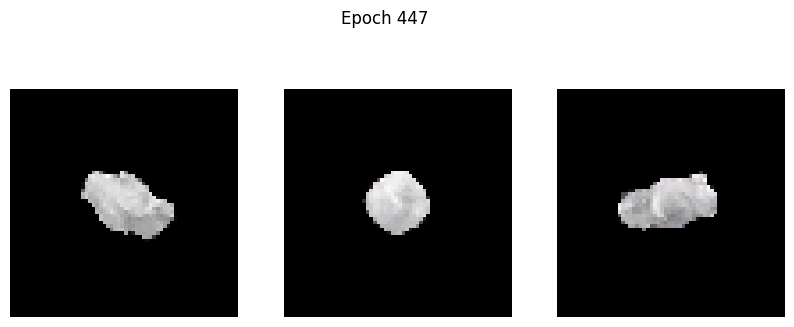

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0097 - g_loss: 6.2927
Epoch 448/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0191 - g_loss: 6.0352

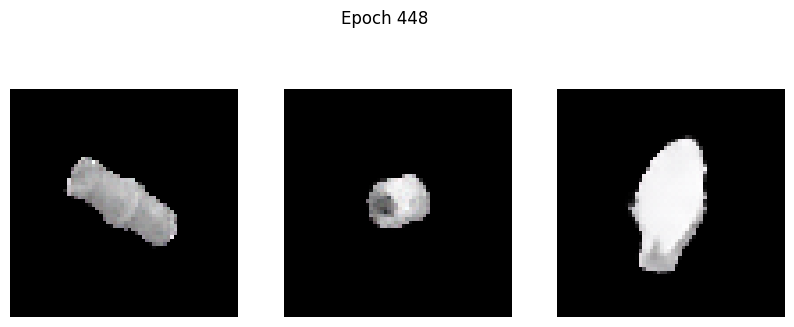

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0190 - g_loss: 6.0349
Epoch 449/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0106 - g_loss: 6.4074

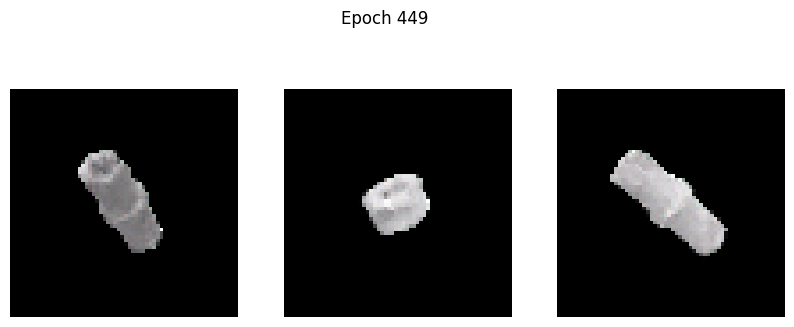

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0105 - g_loss: 6.4063
Epoch 450/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1851 - g_loss: 6.6329

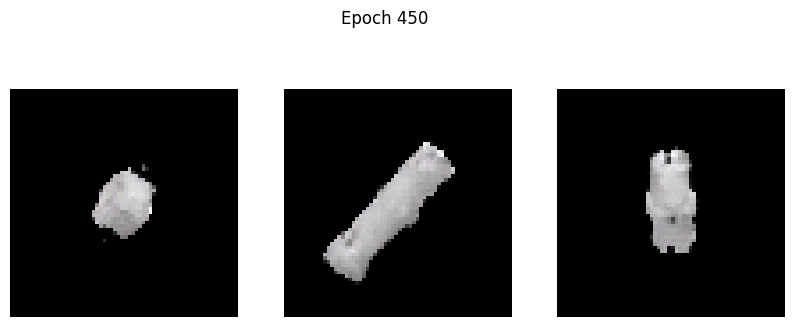

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1846 - g_loss: 6.6303
Epoch 451/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0205 - g_loss: 6.1977

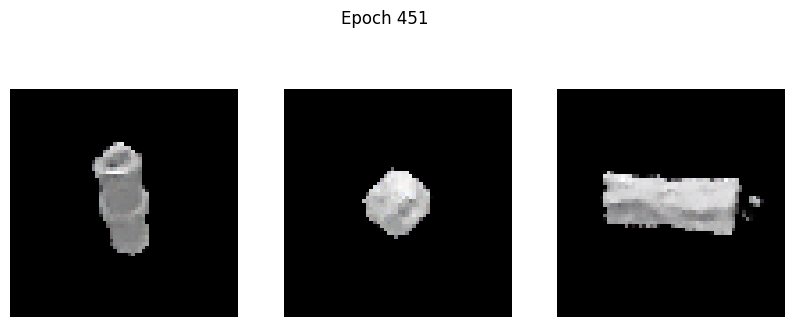

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0203 - g_loss: 6.1976
Epoch 452/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0123 - g_loss: 6.1475

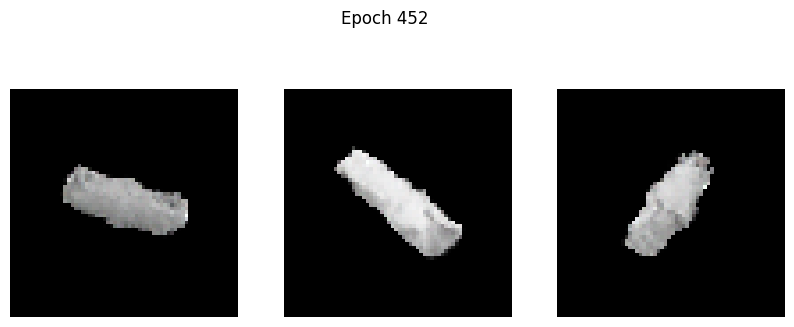

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0125 - g_loss: 6.1473
Epoch 453/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0382 - g_loss: 5.7658

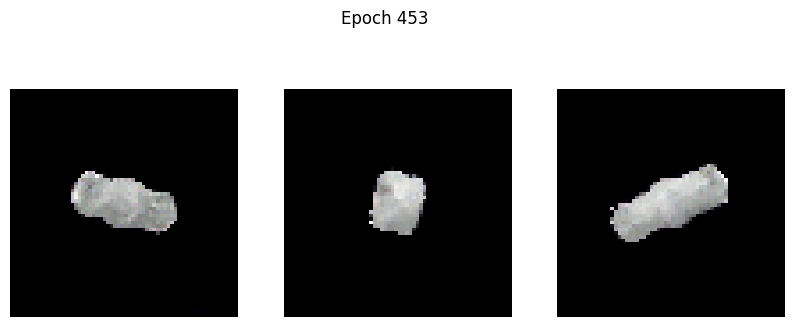

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0381 - g_loss: 5.7673
Epoch 454/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0392 - g_loss: 6.1550

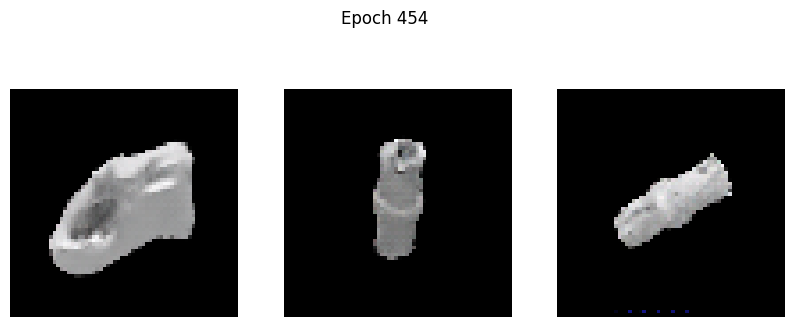

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0391 - g_loss: 6.1561
Epoch 455/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0205 - g_loss: 6.5509

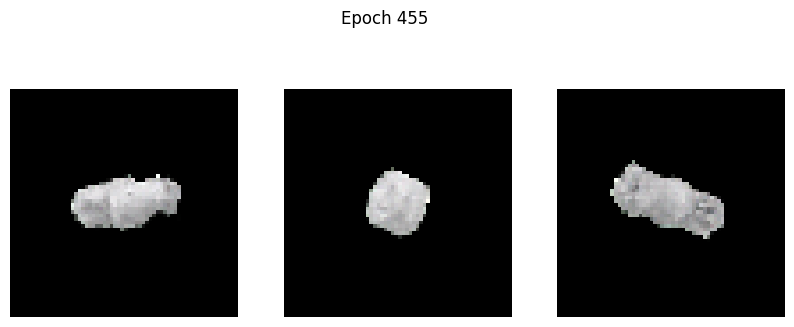

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0206 - g_loss: 6.5529
Epoch 456/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0561 - g_loss: 6.9933

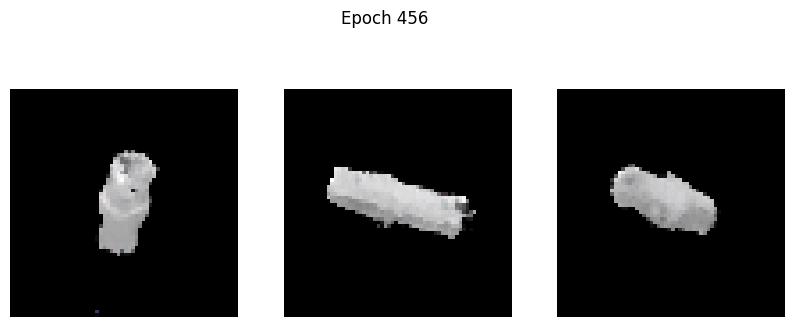

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.0561 - g_loss: 6.9911
Epoch 457/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0465 - g_loss: 6.1710

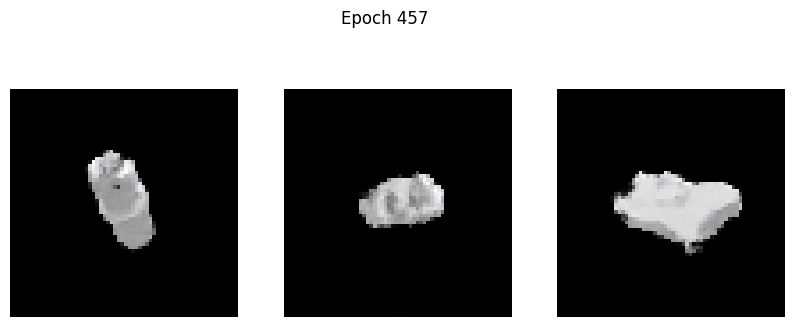

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0466 - g_loss: 6.1703
Epoch 458/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0316 - g_loss: 6.2823

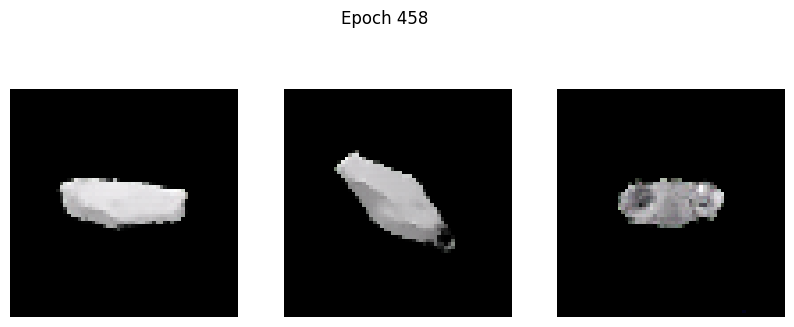

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0315 - g_loss: 6.2825
Epoch 459/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0441 - g_loss: 6.4291

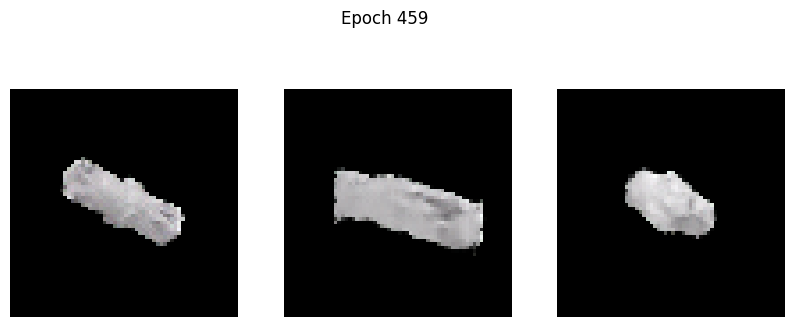

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0440 - g_loss: 6.4290
Epoch 460/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0456 - g_loss: 6.3499

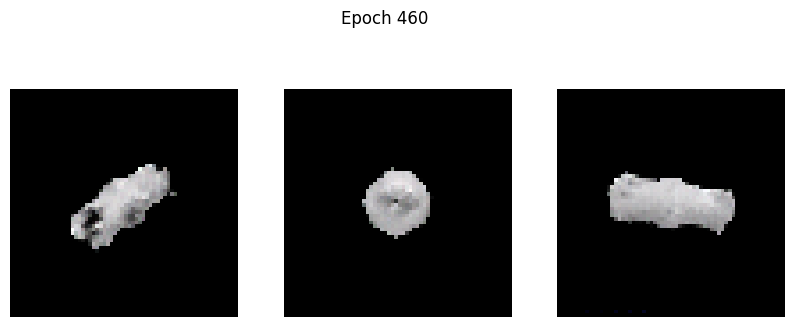

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0455 - g_loss: 6.3513
Epoch 461/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0362 - g_loss: 6.6203

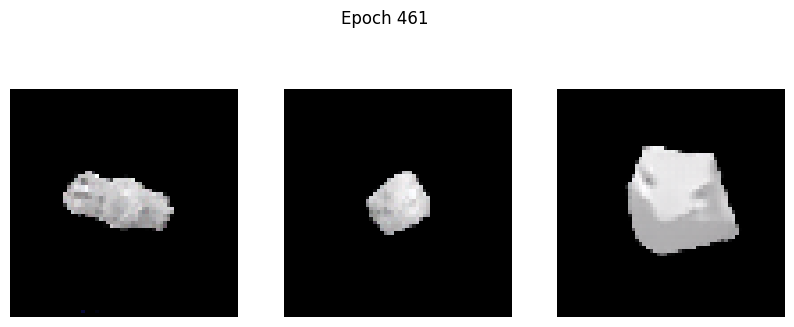

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0361 - g_loss: 6.6198
Epoch 462/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0063 - g_loss: 6.9800

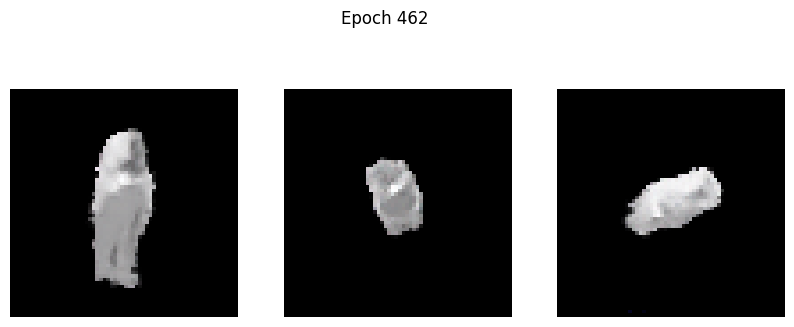

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0058 - g_loss: 6.9738
Epoch 463/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0634 - g_loss: 6.0629

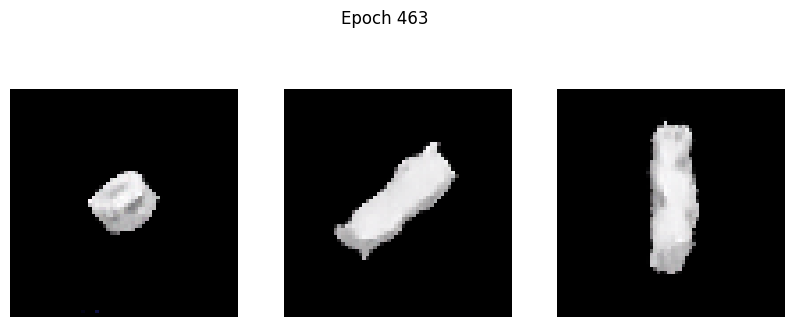

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0632 - g_loss: 6.0652
Epoch 464/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0486 - g_loss: 6.3409

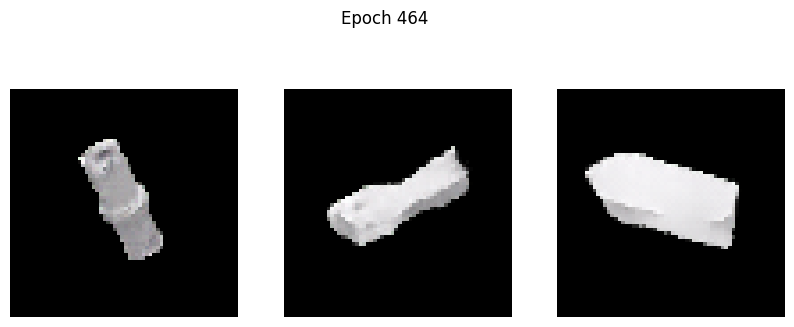

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0484 - g_loss: 6.3427
Epoch 465/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0616 - g_loss: 6.3920

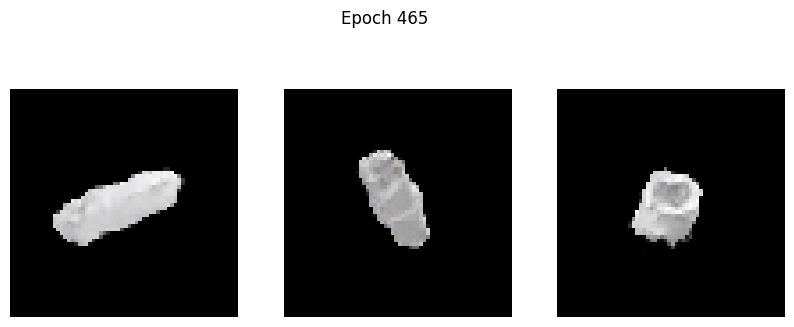

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0612 - g_loss: 6.3943
Epoch 466/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0613 - g_loss: 6.4335

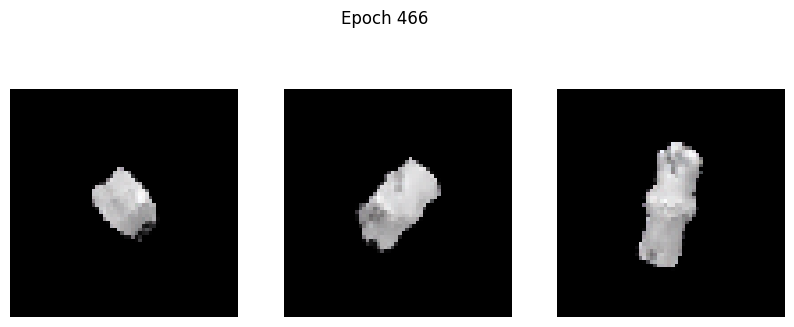

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0614 - g_loss: 6.4321
Epoch 467/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0418 - g_loss: 6.5393

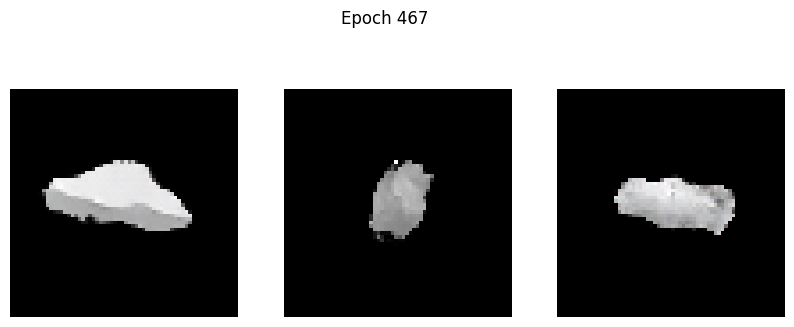

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0417 - g_loss: 6.5397
Epoch 468/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0410 - g_loss: 6.5460

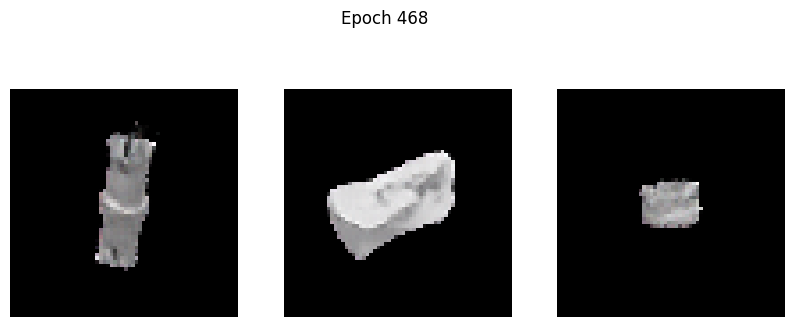

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0406 - g_loss: 6.5486
Epoch 469/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0379 - g_loss: 6.7119

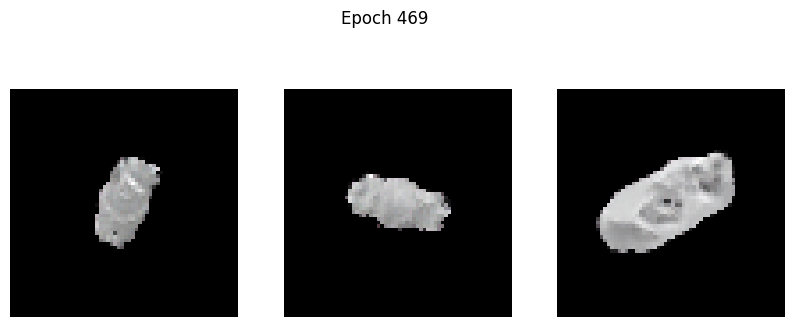

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0380 - g_loss: 6.7113
Epoch 470/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0160 - g_loss: 6.8347

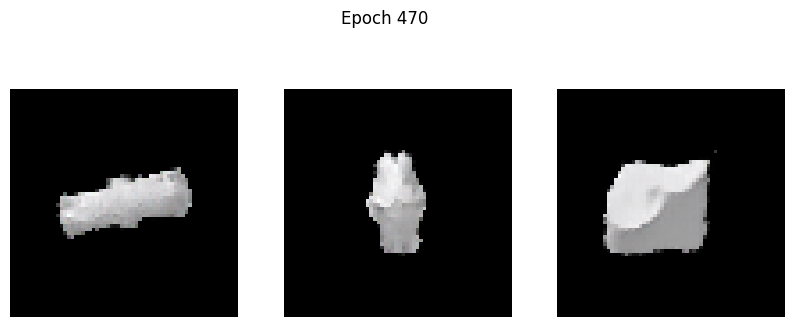

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0155 - g_loss: 6.8360
Epoch 471/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0529 - g_loss: 6.8885

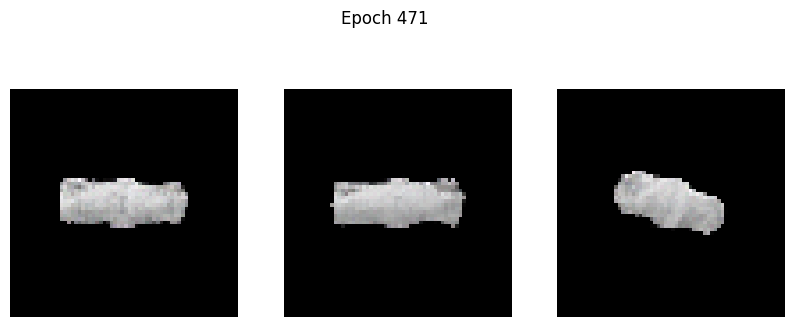

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0523 - g_loss: 6.8853
Epoch 472/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0903 - g_loss: 6.3666

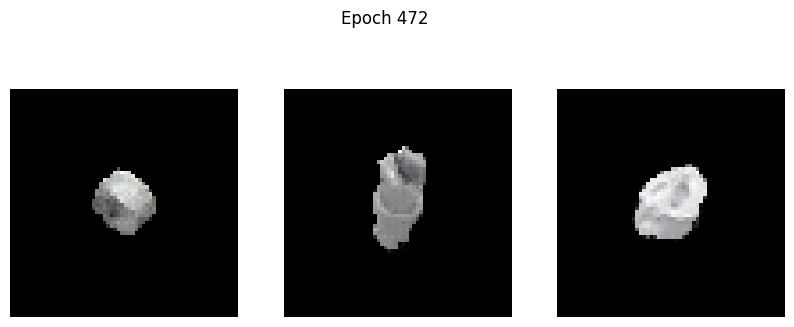

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0904 - g_loss: 6.3665
Epoch 473/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0690 - g_loss: 6.3738

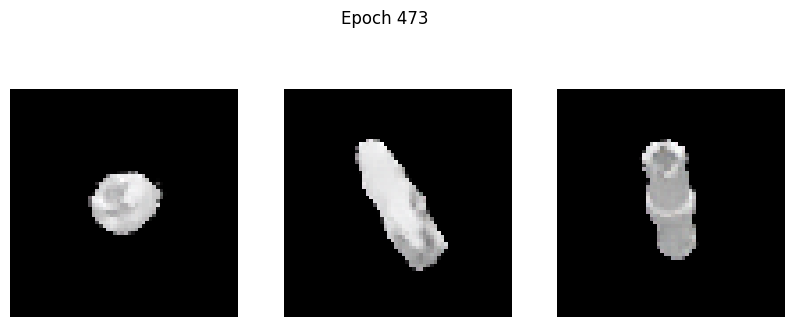

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0689 - g_loss: 6.3762
Epoch 474/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0609 - g_loss: 6.4299

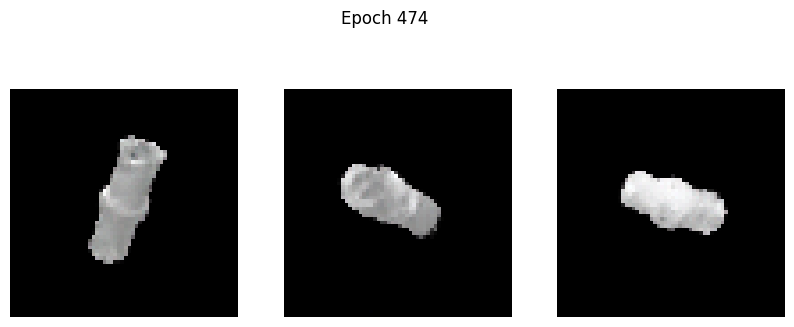

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0607 - g_loss: 6.4329
Epoch 475/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0781 - g_loss: 6.6369

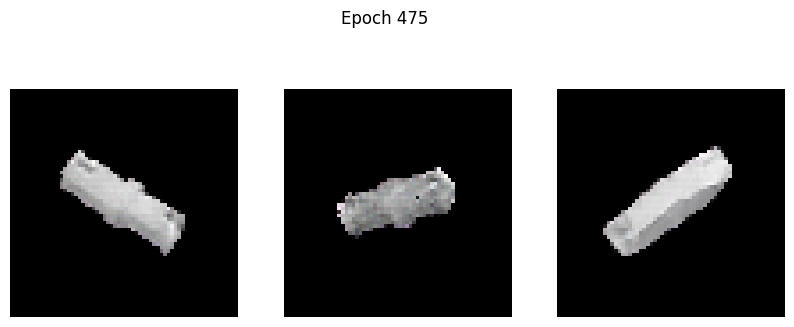

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0780 - g_loss: 6.6362
Epoch 476/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0153 - g_loss: 7.0118

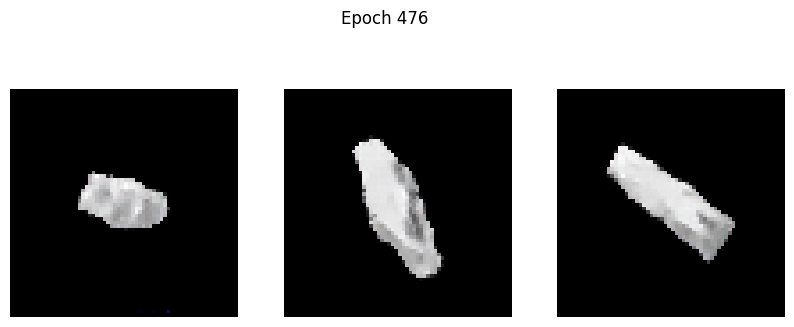

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0153 - g_loss: 7.0091
Epoch 477/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0254 - g_loss: 7.2175

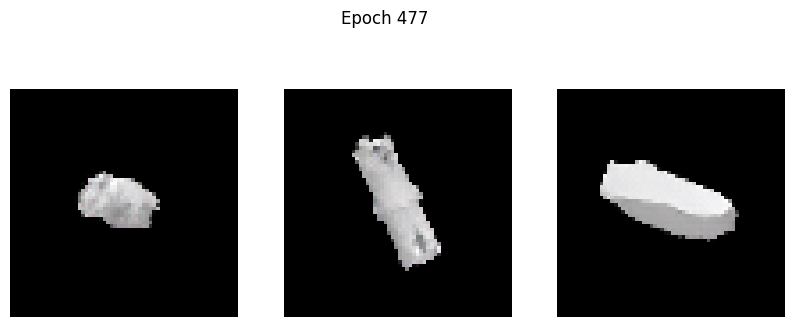

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0244 - g_loss: 7.2206
Epoch 478/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0519 - g_loss: 6.4753

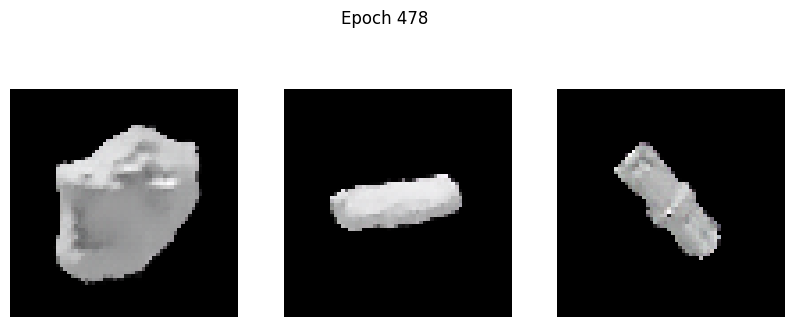

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0519 - g_loss: 6.4766
Epoch 479/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0680 - g_loss: 6.4345

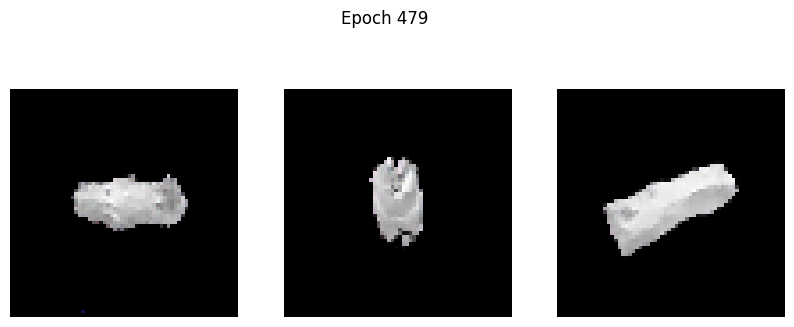

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0678 - g_loss: 6.4369
Epoch 480/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0269 - g_loss: 6.8636

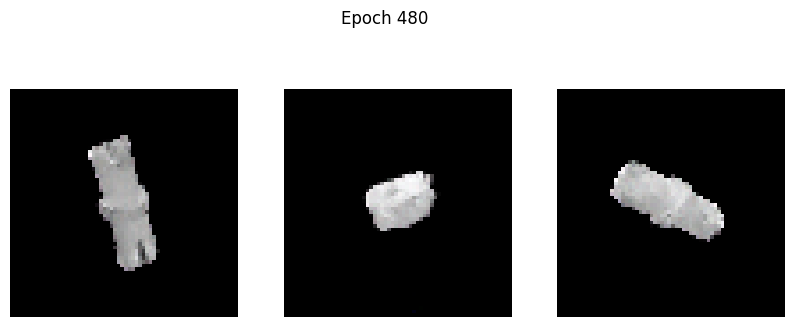

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0272 - g_loss: 6.8608
Epoch 481/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0727 - g_loss: 6.4347

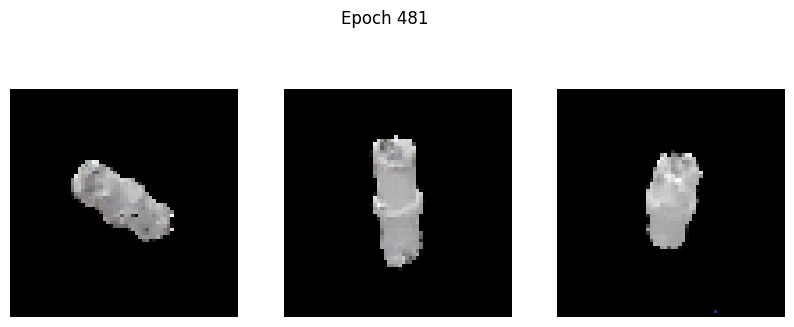

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0727 - g_loss: 6.4365
Epoch 482/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0182 - g_loss: 6.8550

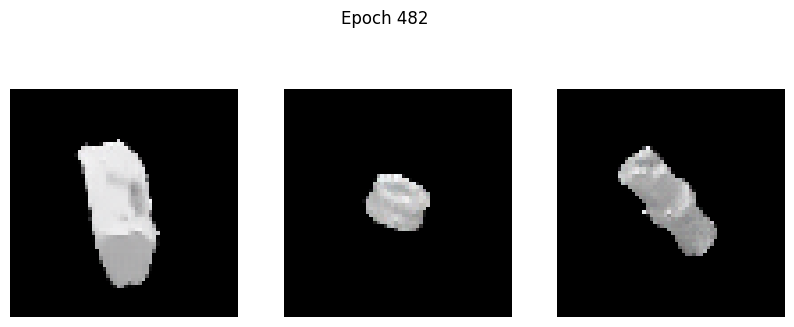

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0186 - g_loss: 6.8544
Epoch 483/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1494 - g_loss: 7.2933

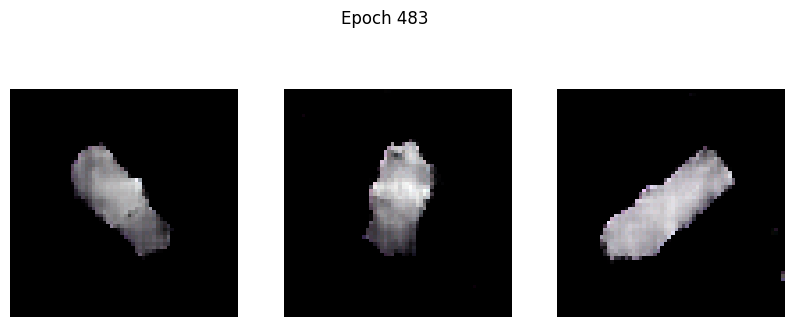

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1593 - g_loss: 7.3271
Epoch 484/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.2831 - g_loss: 6.8023

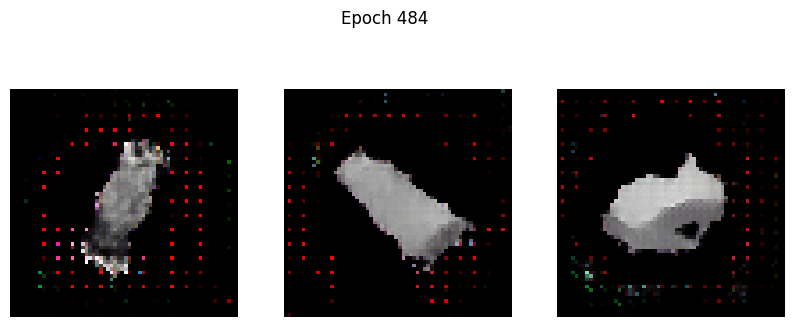

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.2824 - g_loss: 6.8039
Epoch 485/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.0086 - g_loss: 8.0027

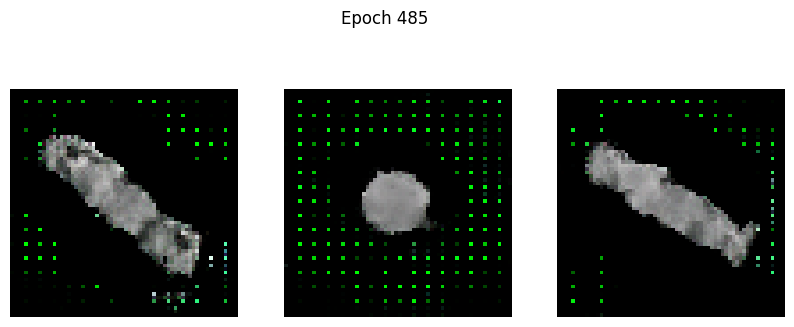

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.0082 - g_loss: 8.0022
Epoch 486/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: -0.0815 - g_loss: 9.2562

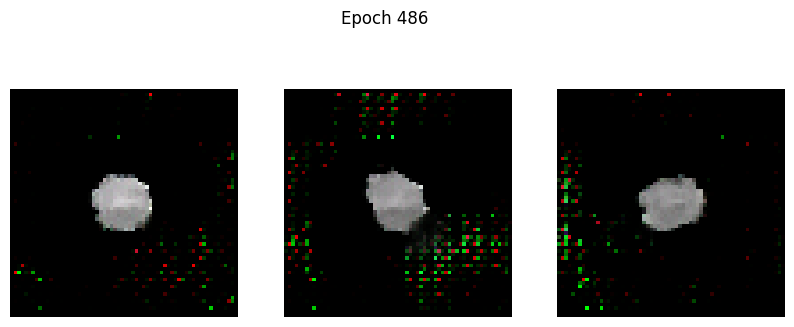

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: -0.0814 - g_loss: 9.2539
Epoch 487/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: -0.0388 - g_loss: 9.3506

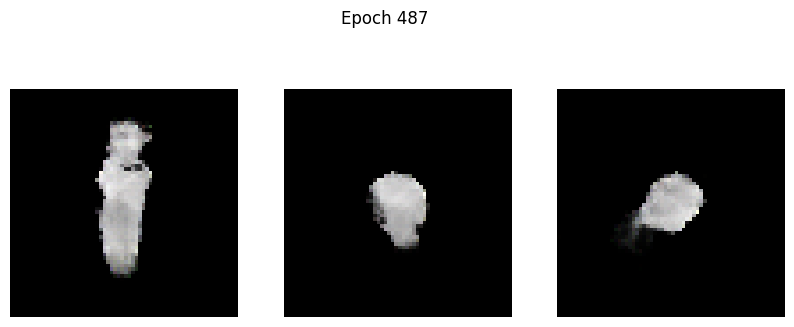

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: -0.0385 - g_loss: 9.3484
Epoch 488/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: -0.2050 - g_loss: 6.8492

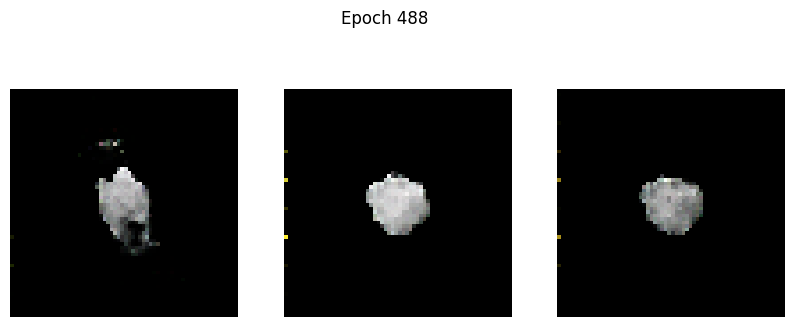

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: -0.2050 - g_loss: 6.8492
Epoch 489/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: -0.2105 - g_loss: 7.4508

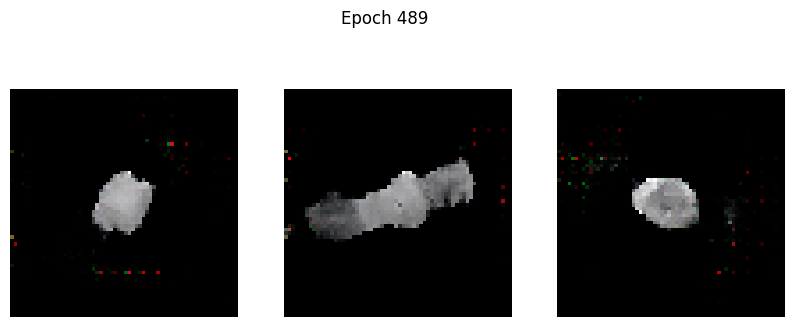

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: -0.2105 - g_loss: 7.4562
Epoch 490/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: -0.1706 - g_loss: 9.5475

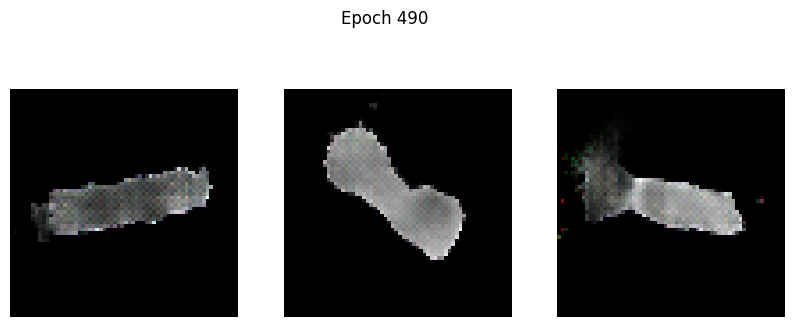

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: -0.1693 - g_loss: 9.5573
Epoch 491/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: -0.2187 - g_loss: 9.5774

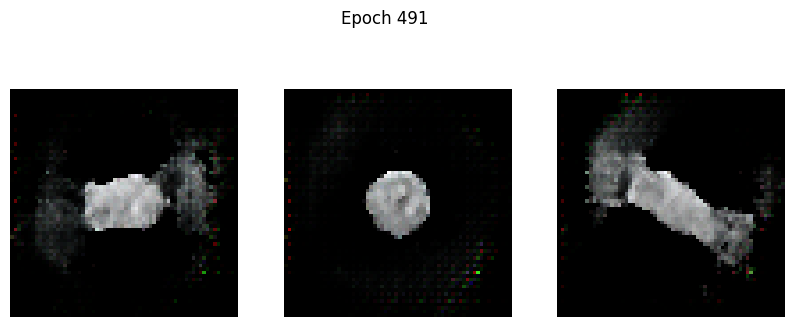

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: -0.2178 - g_loss: 9.5878
Epoch 492/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: -0.0952 - g_loss: 11.1831

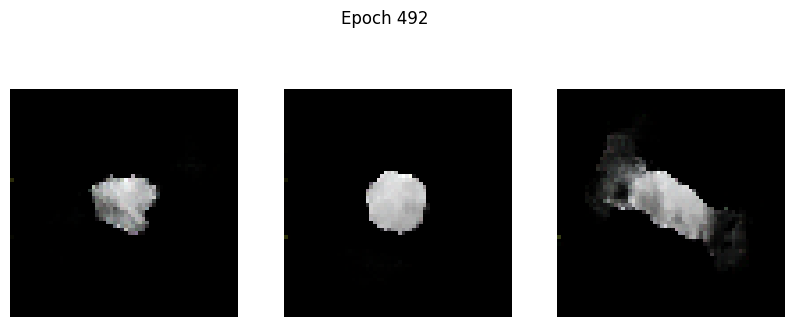

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: -0.0960 - g_loss: 11.1694
Epoch 493/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: -0.2495 - g_loss: 8.2223

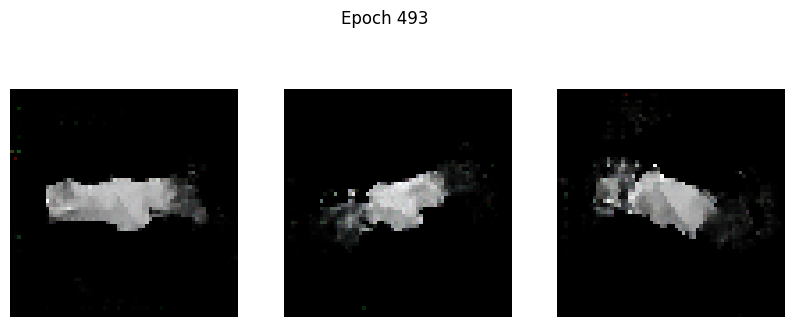

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: -0.2494 - g_loss: 8.2207
Epoch 494/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: -0.2073 - g_loss: 9.6071

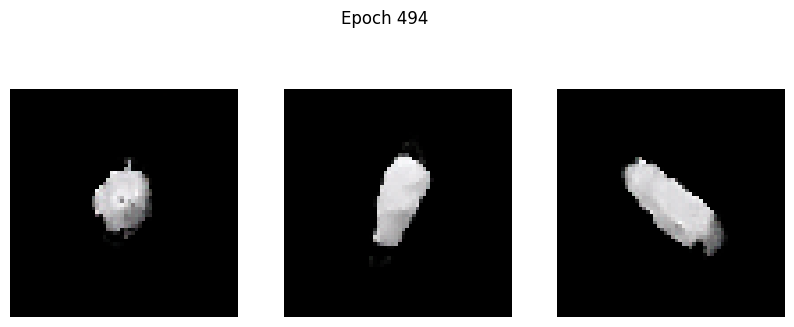

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: -0.2071 - g_loss: 9.6180
Epoch 495/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: -0.2670 - g_loss: 9.1171

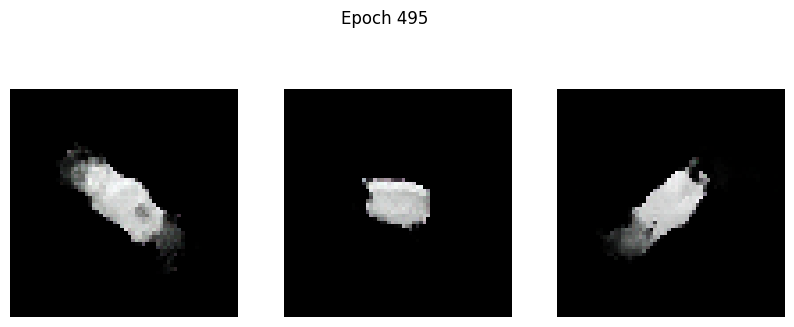

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: -0.2669 - g_loss: 9.1146
Epoch 496/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: -0.2590 - g_loss: 8.2888

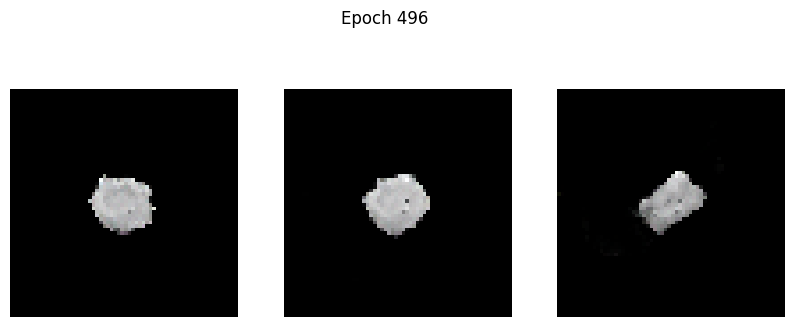

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: -0.2588 - g_loss: 8.2901
Epoch 497/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.2582 - g_loss: 8.3022

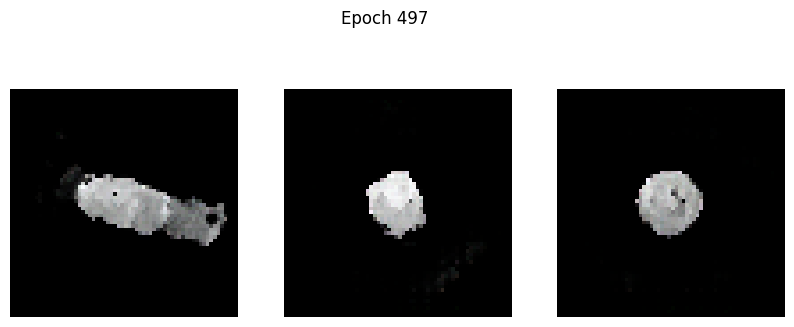

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - d_loss: -0.2582 - g_loss: 8.3015
Epoch 498/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.0357 - g_loss: 10.6708

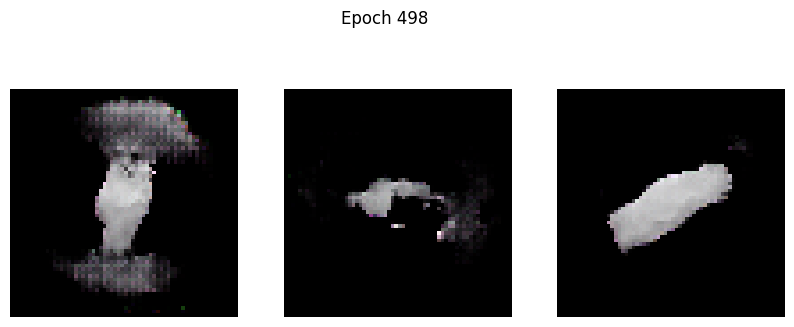

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.0380 - g_loss: 10.6937
Epoch 499/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0469 - g_loss: 10.2860

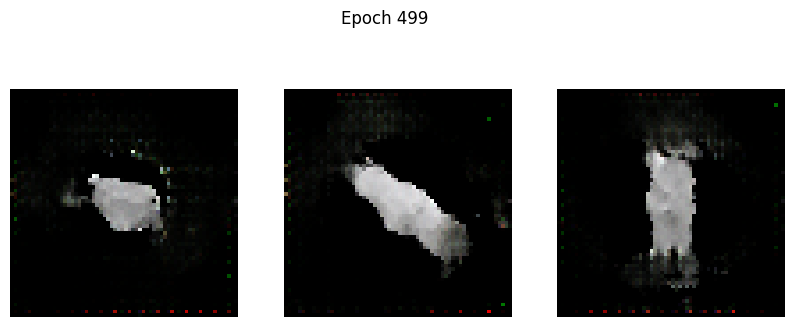

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0474 - g_loss: 10.2789
Epoch 500/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: -0.1339 - g_loss: 8.9228

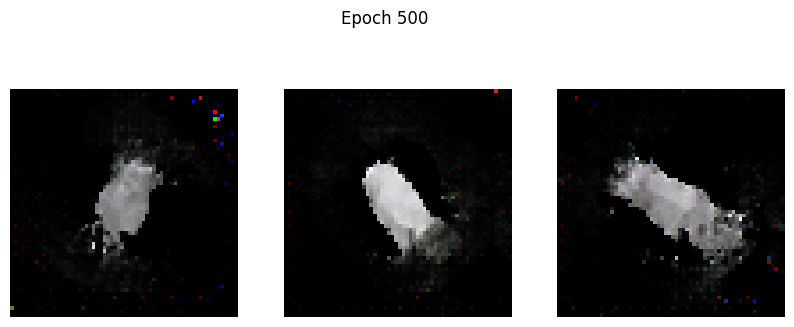

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: -0.1339 - g_loss: 8.9251


In [8]:
# Hyperparameters
EPOCHS = 500  # Tambahkan jumlah epoch untuk hasil lebih baik (misal: 100-200)
lr_generator = 0.0002
lr_discriminator = 0.0002

# Inisialisasi DCGAN
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

# Compile
dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=lr_discriminator, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=lr_generator, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

# Jalankan Training
print("Mulai Training...")
dcgan.fit(
    train_dataset,
    epochs=EPOCHS,
    callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

In [9]:
generator.save('generator model.keras')
print("Generator model saved successfully as 'generator model.keras'")

Generator model saved successfully as 'generator model.keras'


In [10]:
import keras
import numpy as np
from PIL import Image
import os
# ... (impor lainnya)

# --- Konfigurasi ---
MODEL_PATH = '/content/generator model.keras' # Nama file baru tanpa spasi dan tanda kurung
NUM_IMAGES = 5

def generate_and_save_images():
    # 1. Muat model generator
    try:
        # Pemuatan model menggunakan path yang dikonstruksi
        generator = keras.saving.load_model(MODEL_PATH)
    except Exception as e:
        print(f"Error loading model '{MODEL_PATH}': {e}")
        return

    # Deteksi dimensi laten
    latent_dim = generator.input_shape[1]

    # 2. Hasilkan 5 vektor laten acak (noise)
    # Menggunakan distribusi normal standar (umum untuk GAN)
    noise = np.random.normal(size=(NUM_IMAGES, latent_dim)).astype(np.float32)

    # 3. Hasilkan gambar
    generated_data = generator.predict(noise, verbose=0)

    # 4. Proses dan simpan gambar

    # Rescale dari rentang [-1, 1] (asumsi umum GAN) ke [0, 255]
    if generated_data.min() < 0:
      generated_images_scaled = 0.5 * generated_data + 0.5
    else:
      generated_images_scaled = generated_data

    generated_images_scaled = (generated_images_scaled * 255).astype(np.uint8)

    # Deteksi dimensi output (H, W, C)
    output_shape = generator.output_shape
    H, W, C = output_shape[1:]

    for i in range(NUM_IMAGES):
        img_array = generated_images_scaled[i]

        # Atur mode PIL berdasarkan jumlah channel
        # Parameter `mode` tidak lagi diperlukan karena `Image.fromarray` dapat menginfer mode dengan benar
        # dari bentuk dan tipe data array NumPy.
        if C == 1:
            img_array = img_array.squeeze(axis=-1) # Hapus dimensi channel jika hanya satu
            img = Image.fromarray(img_array) # Pillow akan infer 'L' (grayscale)
        elif C == 3:
            img = Image.fromarray(img_array) # Pillow akan infer 'RGB' (warna)
        else:
            print(f"Peringatan: Gambar {i+1} memiliki {C} channel. Diskip.")
            continue

        filename = f'generated_image_{i+1}.png'
        img.save(filename)
        print(f"Tersimpan: {filename}")

# Jalankan fungsi
generate_and_save_images()

Tersimpan: generated_image_1.png
Tersimpan: generated_image_2.png
Tersimpan: generated_image_3.png
Tersimpan: generated_image_4.png
Tersimpan: generated_image_5.png


Menampilkan 5 gambar baru (64x64x3)...


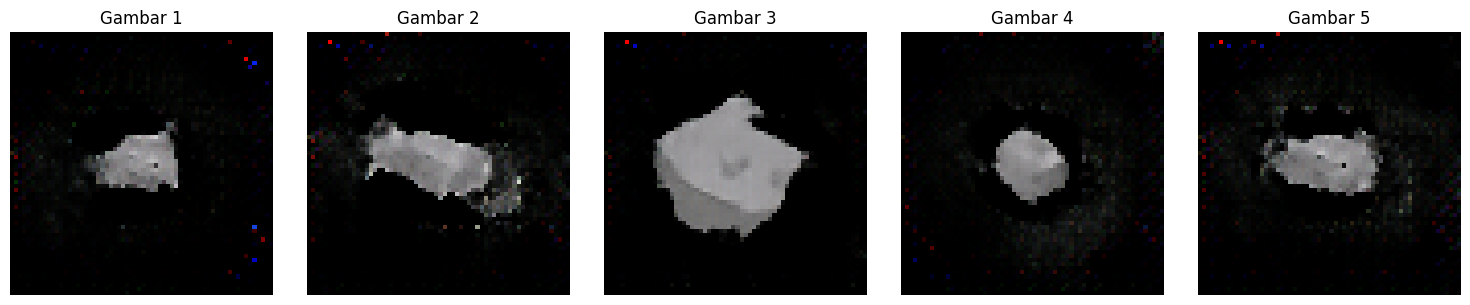

In [11]:
import keras
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt # Pustaka utama untuk plotting
import os

# --- Konfigurasi ---
MODEL_PATH = '/content/generator model.keras'
NUM_IMAGES = 5
ROWS = 1 # Jumlah baris di grid output
COLS = 5 # Jumlah kolom di grid output (karena ada 5 gambar)

def generate_and_display_images():
    # 1. Muat model generator (Langkah yang sama)
    try:
        generator = keras.saving.load_model(MODEL_PATH)
    except Exception as e:
        print(f"Error: Gagal memuat model Keras '{MODEL_PATH}'. Error: {e}")
        return

    latent_dim = generator.input_shape[1]

    # 2. Hasilkan vektor laten acak dan gambar (Langkah yang sama)
    noise = np.random.normal(size=(NUM_IMAGES, latent_dim)).astype(np.float32)
    generated_data = generator.predict(noise, verbose=0)

    # Rescale dari rentang [-1, 1] ke [0, 255] (Langkah yang sama)
    if generated_data.min() < 0:
      generated_images_scaled = 0.5 * generated_data + 0.5
    else:
      generated_images_scaled = generated_data

    # TIDAK PERLU diubah ke np.uint8 jika akan diplot dengan Matplotlib
    # Biarkan dalam rentang [0, 1] atau float

    # Deteksi dimensi output (H, W, C)
    output_shape = generator.output_shape
    H, W, C = output_shape[1:]

    # 3. Tampilkan Gambar menggunakan Matplotlib
    print(f"Menampilkan {NUM_IMAGES} gambar baru ({H}x{W}x{C})...")

    # Buat figure dan subplot (grid)
    plt.figure(figsize=(15, 3)) # Atur ukuran figure agar gambar terlihat jelas (lebar 15, tinggi 3)

    for i in range(NUM_IMAGES):
        # Tambahkan subplot ke grid (1 baris, 5 kolom, posisi ke-i+1)
        plt.subplot(ROWS, COLS, i + 1)

        img_array = generated_images_scaled[i]

        # Jika Grayscale (C=1), hapus dimensi channel agar Matplotlib menampilkannya dengan benar
        if C == 1:
            img_array = img_array.squeeze(axis=-1)
            # Gunakan colormap 'gray' untuk tampilan grayscale
            plt.imshow(img_array, cmap='gray')
        else: # Untuk RGB (C=3)
            plt.imshow(img_array)

        # Sembunyikan sumbu X dan Y agar gambar terlihat bersih
        plt.axis('off')
        plt.title(f"Gambar {i+1}")

    plt.tight_layout() # Sesuaikan layout
    plt.show() # Tampilkan semua plot

# Jalankan fungsi baru
generate_and_display_images()